In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import gym
import random
from collections import defaultdict
import itertools
import cv2
import sys
import plotting
from BrainDQN_Nature import *
import scipy
from ipywidgets import widgets
from IPython.display import display

from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from time import gmtime, strftime
import atari_py as ap

matplotlib.style.use('ggplot')

In [2]:
# Gamespace Variables

env = gym.make("Pong-v0") # environment info
xs,rs,ys = [],[],[] # State, Reward, Action History
average_reward = None # Reward for measuring average performance
G = 0
n_episode = 0

In [3]:
# Hyper Paremeters
n_input = 84**2                # size of input
n_hidden = 200                 # number of hidden layer neurons
n_actions = 3 # number of available actions i.e. fire (do nothing), left & right
learning_rate = 1e-3
gamma = .9                   # discount factor for reward
decay1, decay2 = 0.9, 0.999    # decay rates for Adam optimizer
save_path='models/pong.ckpt'

In [4]:
tf_model = {}
# Initialize random weights using xavier initialization
with tf.variable_scope('weights_one',reuse=False):
    xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(n_input), dtype=tf.float32)
    tf_model['W1'] = tf.get_variable("W1", [n_input, n_hidden], initializer=xavier_l1)
with tf.variable_scope('weights_two',reuse=False):
    xavier_l2 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(n_hidden), dtype=tf.float32)
    tf_model['W2'] = tf.get_variable("W2", [n_hidden,n_actions], initializer=xavier_l2)

In [5]:
#Functions
def preprocess(observation):
    observation = cv2.cvtColor(cv2.resize(observation, (84, 110)), cv2.COLOR_BGR2GRAY)
    observation = observation[26:110 ,:]
    ret, observation = cv2.threshold(observation,1,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(-1))
           
# Apply reward discounting to a series of rewards
def tf_discount(tf_r): #tf_r ~ [game_steps,1]
    discount_f = lambda a, v: a*gamma + v;  # Function for calculating discounted reward
    tf_r_reverse = tf.scan(discount_f, tf.reverse(tf_r,[True, False])) # Reverses and applies discounts
    tf_discounted_r = tf.reverse(tf_r_reverse,[True, False]) # Reverse back so in ascending time steps
    return tf_discounted_r

# Feed input and calculate action using weights
def tf_policy_forward(x): #x ~ [1,D]
    h = tf.nn.relu(tf.matmul(x, tf_model['W1'])) # Calulates hidden layer
    logp = tf.matmul(h, tf_model['W2']) # Calculates output value
    p = tf.nn.softmax(logp) # Converts out values into a probability i.e. sum of outputs = 1
    return p

In [9]:
# TF Placeholders
X = tf.placeholder(dtype=tf.float32, shape=[None, n_input],name="X")
Y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="Y")
tf_epr = tf.placeholder(dtype=tf.float32, shape=[None,1], name="tf_epr")

# Discount rewards 
tf_discounted_g = tf_discount(tf_epr)
# Normalize rewards
tf_mean, tf_variance = tf.nn.moments(tf_discounted_g, [0], shift=None, name="reward_moments")
tf_discounted_g -= tf_mean
tf_discounted_g /= tf.sqrt(tf_variance + 1e-6)

# TF optimizer op
tf_aprob = tf_policy_forward(X)
loss = tf.nn.l2_loss(Y - tf_aprob)
optimizer = tf.train.AdamOptimizer(learning_rate, beta1=decay1, beta2=decay2)
#optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=decay1)
tf_grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=tf_discounted_g)
train_op = optimizer.apply_gradients(tf_grads)

In [10]:
# TF Graph initialization
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [11]:
# Load model if exists
saver = tf.train.Saver(tf.global_variables())
load_was_success = True 
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print("no saved model to load. starting new session")
    load_was_success = False
else:
    print("loaded model: {}".format(load_path))
    saver = tf.train.Saver(tf.global_variables())
    episode_number = int(load_path.split('-')[-1])

no saved model to load. starting new session


In [10]:
state1 = np.zeros([1,n_input])
state2 = preprocess(env.reset())
render = False

while True:
    # Decay learning rate
    if n_episode > 4000:
        learning_rate = 1e-4
    elif n_episode > 5000:
        learning_rate = 1e-5
    elif n_episode > 6000:
        learning_rate = 1e-6

    # Subtract current state from previous state to visualize motion
    state = state2 - state1
    state1 = state2
    
    # Sample a action based from the network weights
    feed = {X: np.reshape(state, (1,n_input))}
    # Feed state forward through the network, returns an action between 0 and 2
    aprob = sess.run(tf_aprob,feed) ; aprob = aprob[0,:]
    # Choose random action based upon action probabilities
    action = np.random.choice(n_actions, p=aprob)
    # Convert action into one hot vector
    label = np.zeros_like(aprob) ; label[action] = 1

    # Take an action and get new variables, we add 1 to action based upon env.env.get_action_meanings()
    state2, reward, done, info = env.step(action+1)
    state2 = preprocess(state2)
    if render:
        env.render()
    G += reward
    
    # Record state, action & reward history
    xs.append(state) ; ys.append(label) ; rs.append(reward)
    
    if done:
        # parameter update
        feed = {X: np.vstack(xs), tf_epr: np.vstack(rs), Y: np.vstack(ys)}
        _ = sess.run(train_op,feed)
            
        
        # update average reward
        average_reward = G if average_reward is None else average_reward * 0.99 + G * 0.01
            
        G = 0 # Reset episode reward
        n_episode += 1 # the Next Episode
        state1 = np.zeros([1,n_input])
        state2 = preprocess(env.reset()) # Reset environment
        xs,rs,ys = [],[],[] # reset game history
        
        if n_episode % 50 == 0:
            saver.save(sess, save_path, global_step=n_episode)
            print("SAVED MODEL #{}".format(n_episode))
        
        if n_episode == 5000:
            break
        


KeyboardInterrupt: 

In [12]:
def display_frames_as_gif(frames, filename_gif = None):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    if filename_gif: 
        anim.save(filename_gif, writer = 'imagemagick', fps=20)
    display(display_animation(anim, default_mode='loop'))

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))


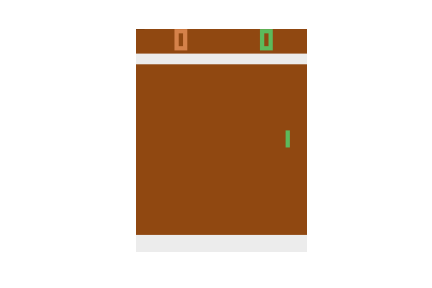
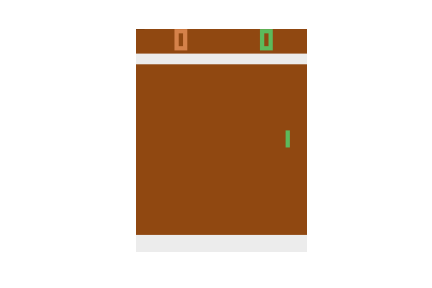
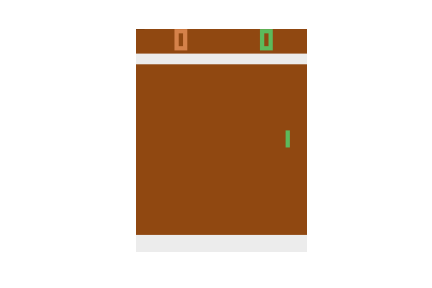
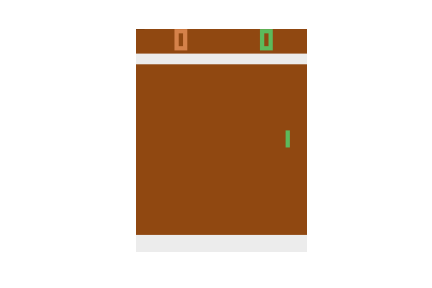
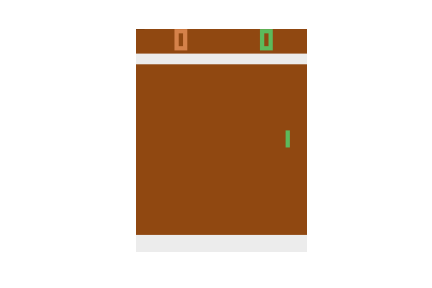
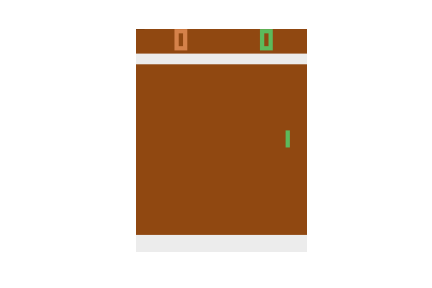
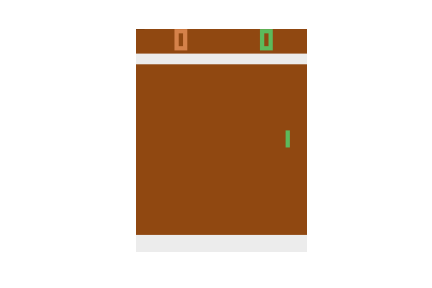
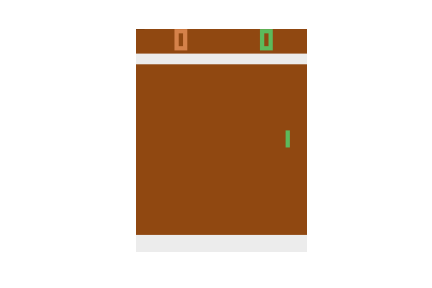
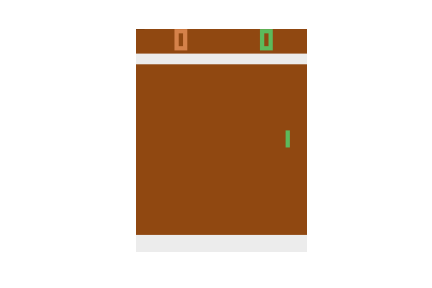
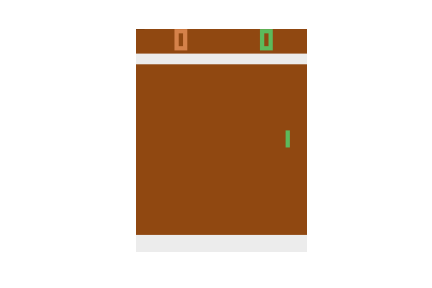
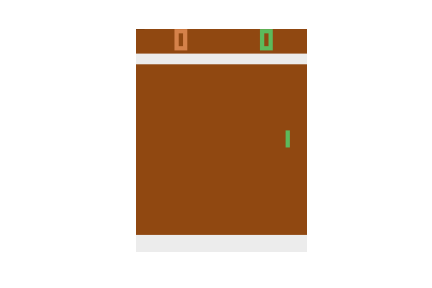
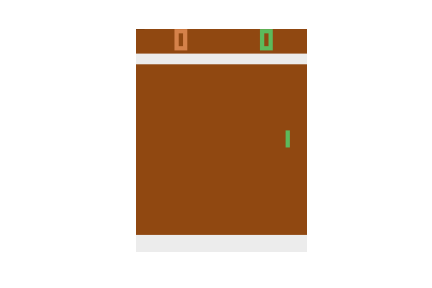
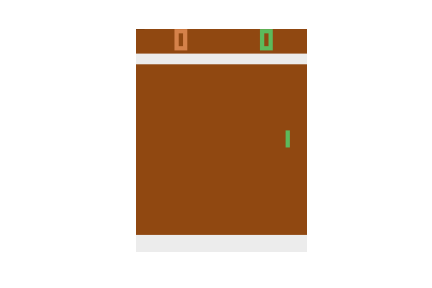
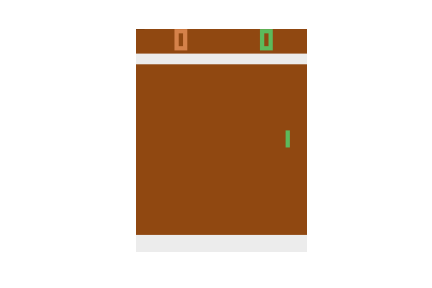
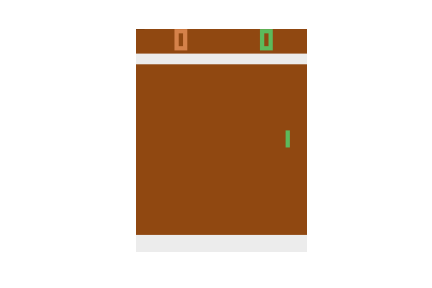
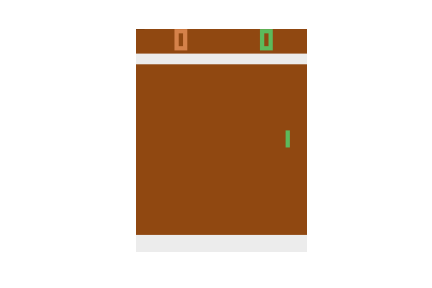
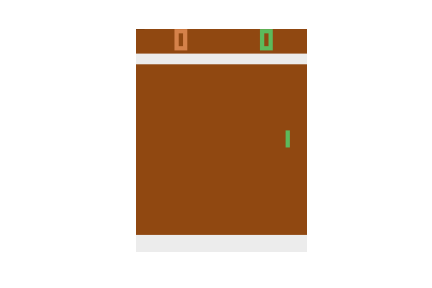
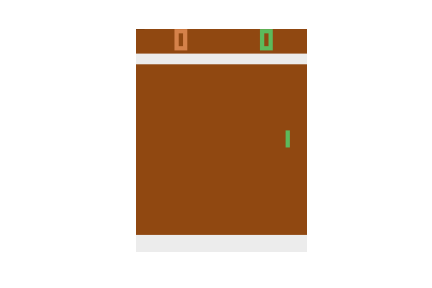
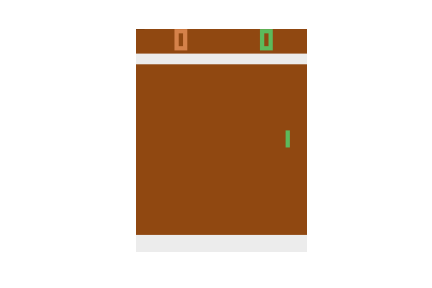
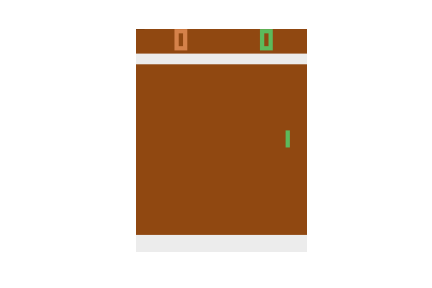
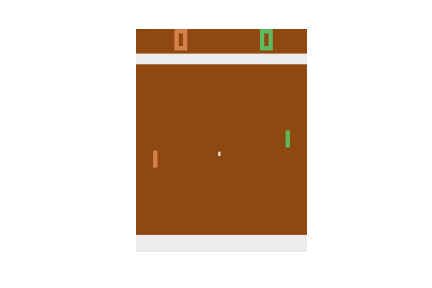
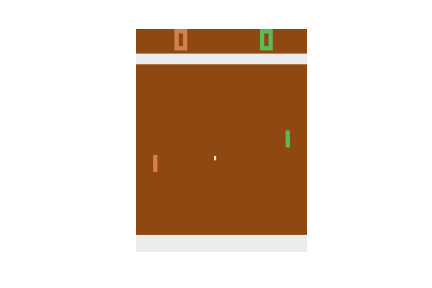
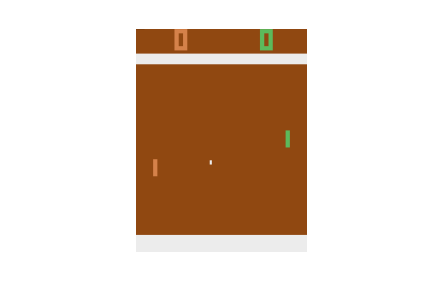
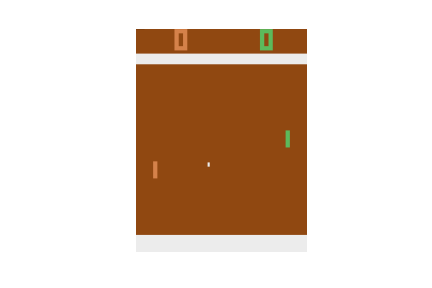
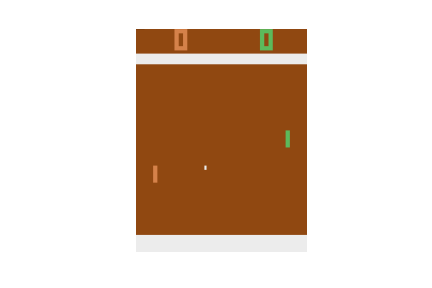
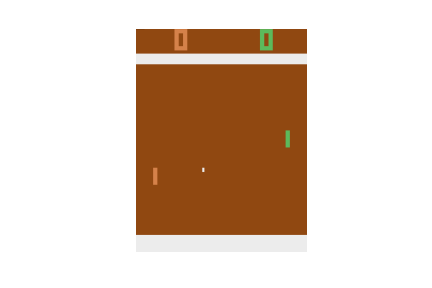
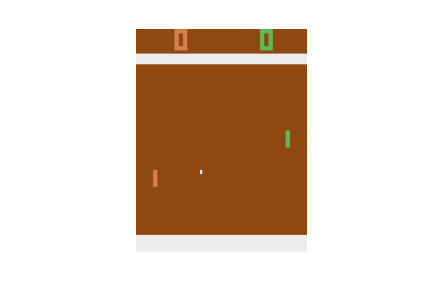
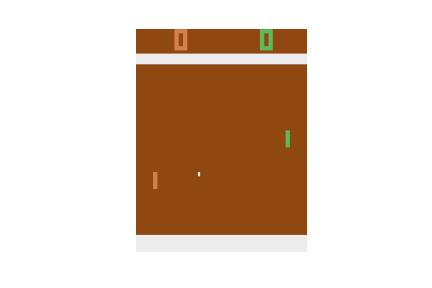
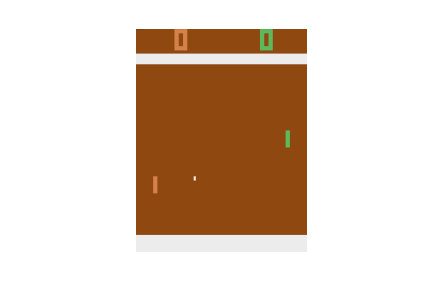
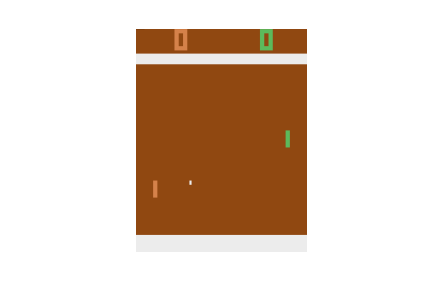
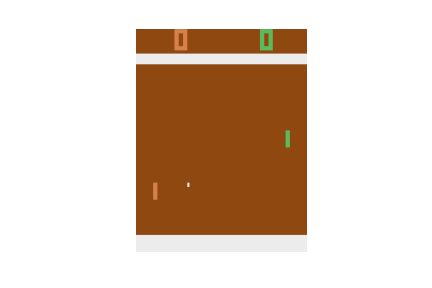
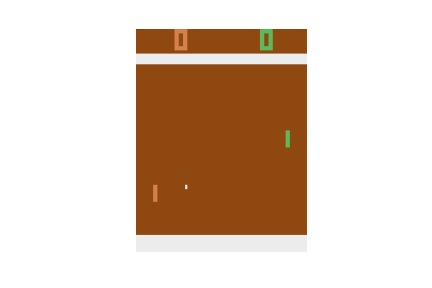
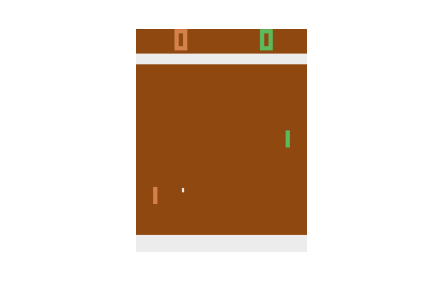
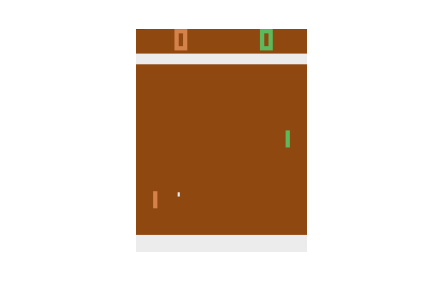
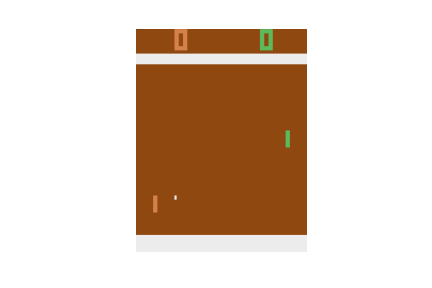
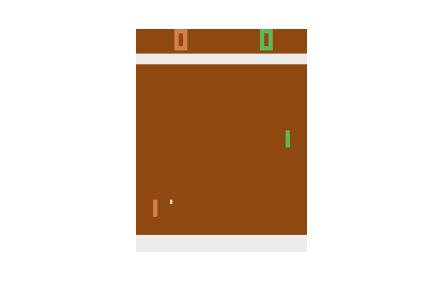
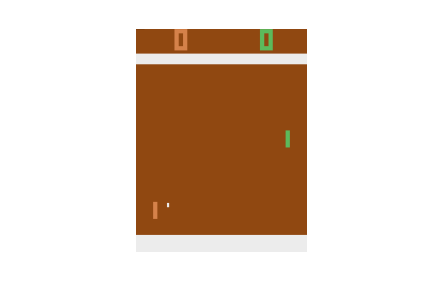
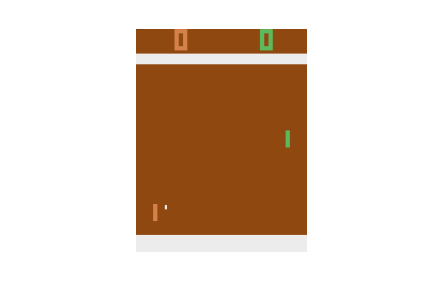
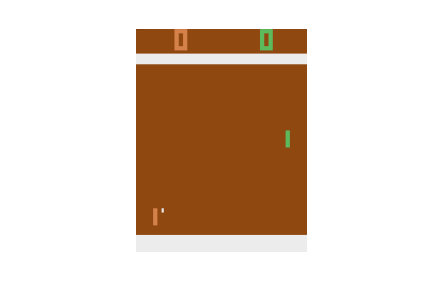
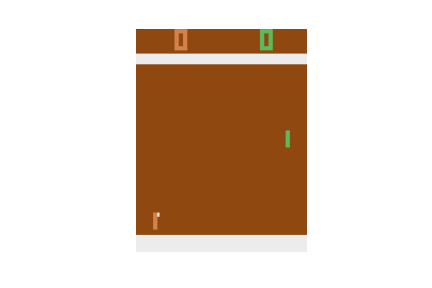
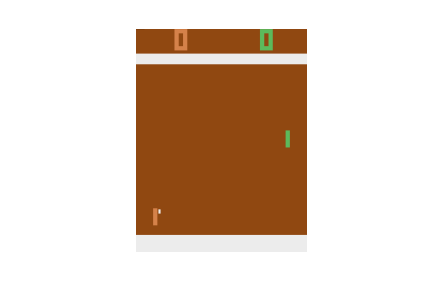
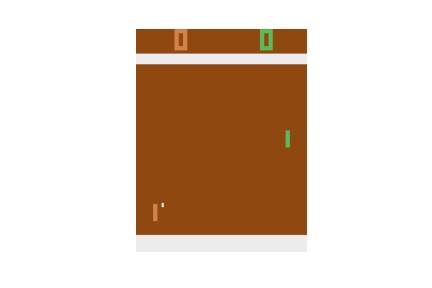
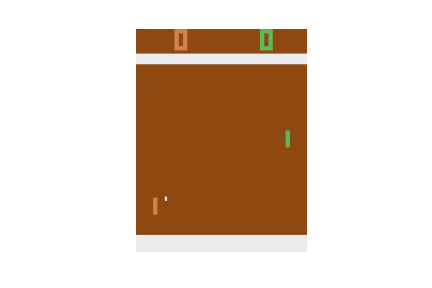
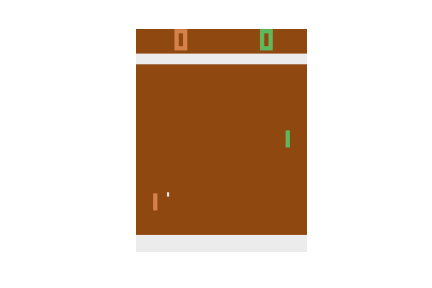
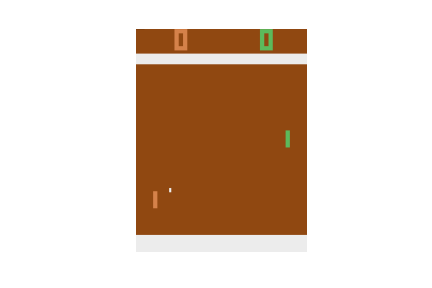
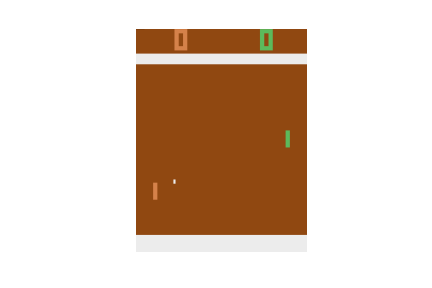
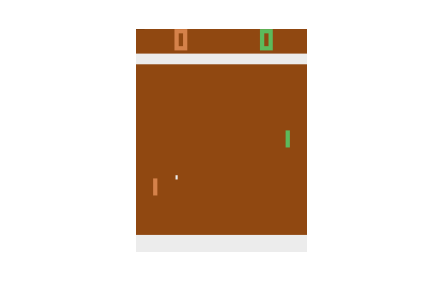
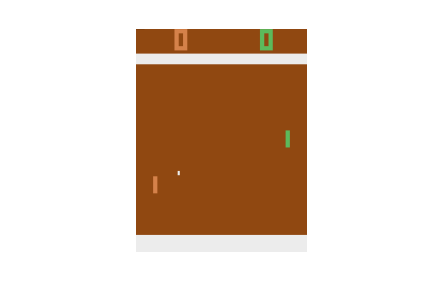
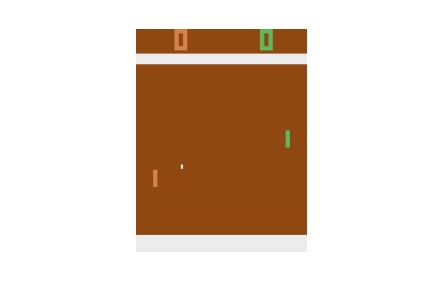
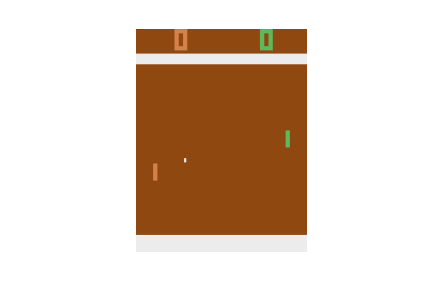
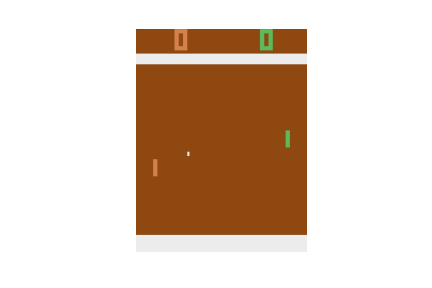
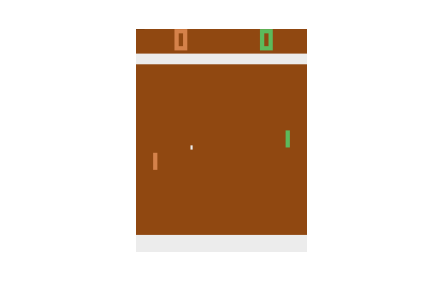
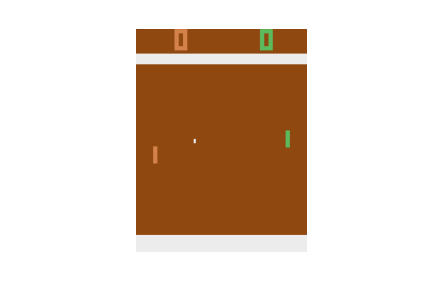
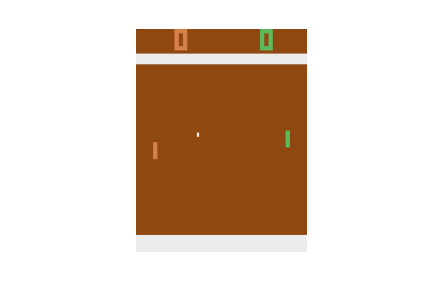
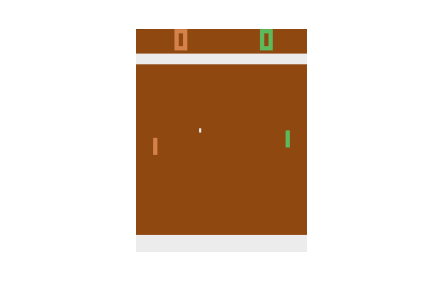
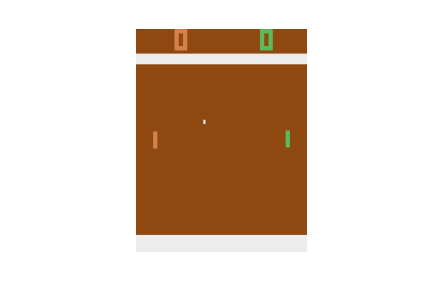
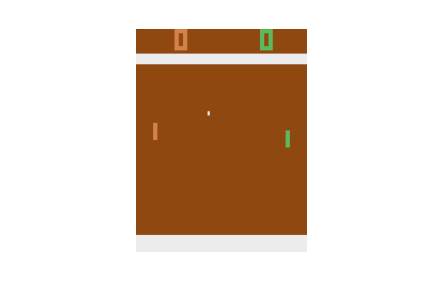
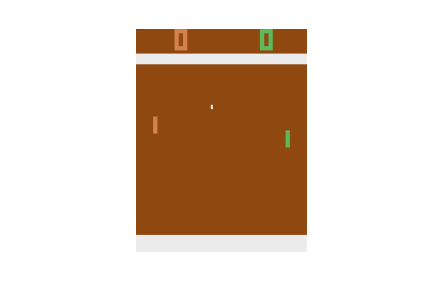
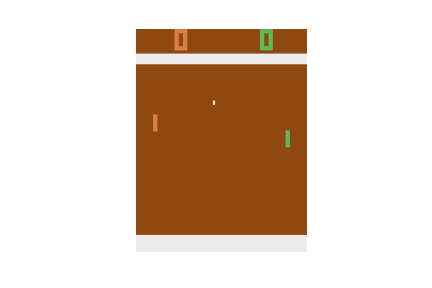
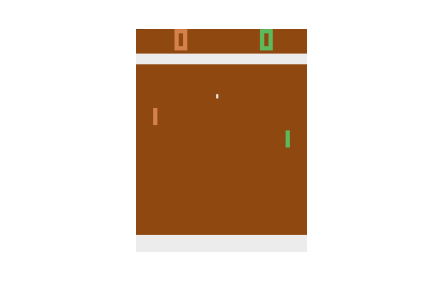
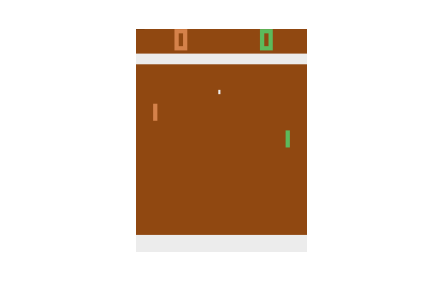
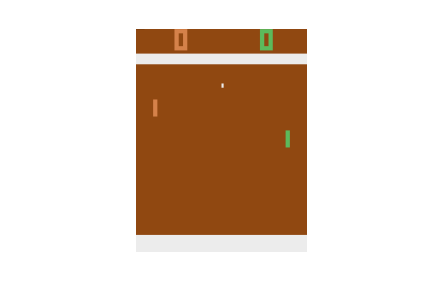
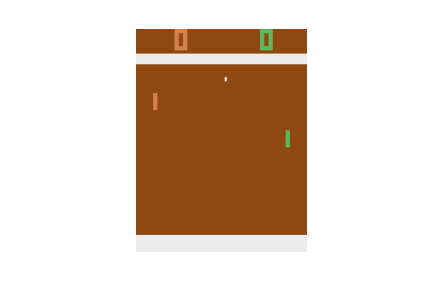
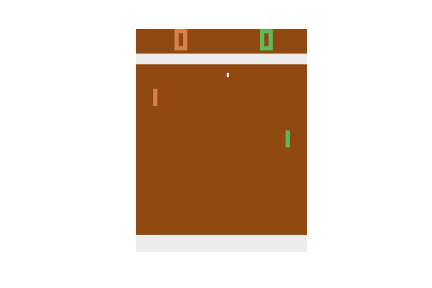
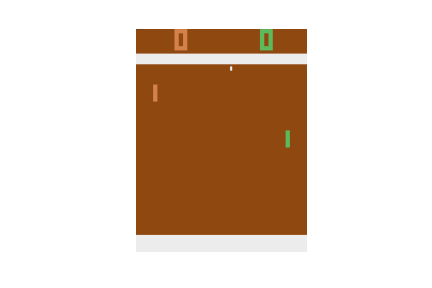
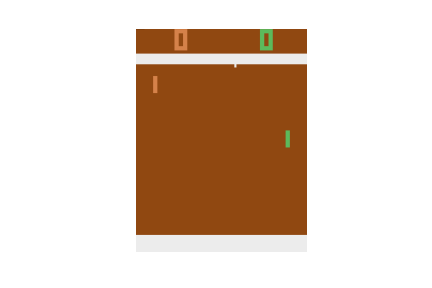
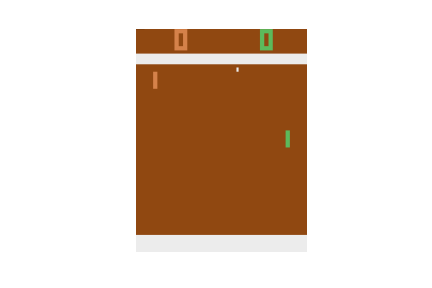
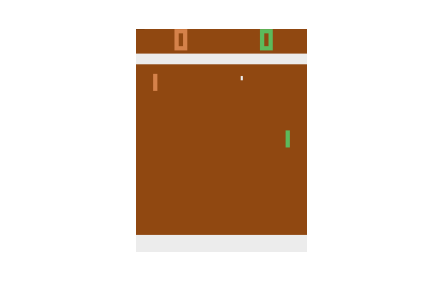
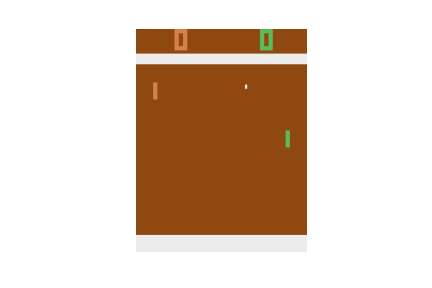
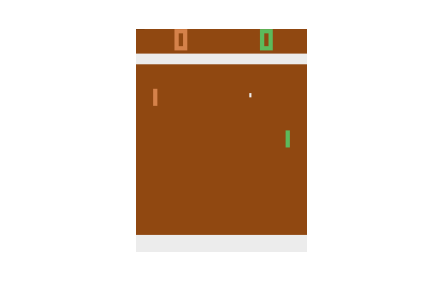
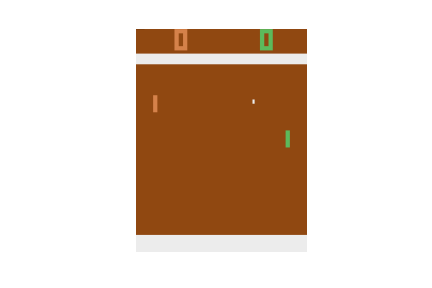
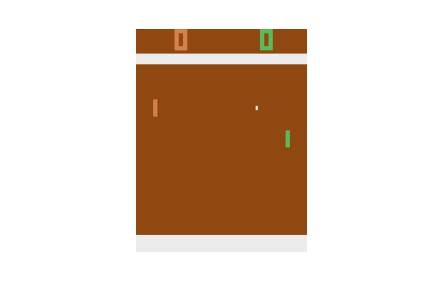
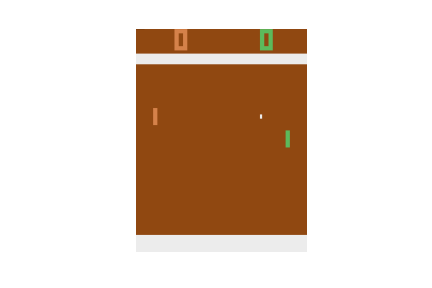
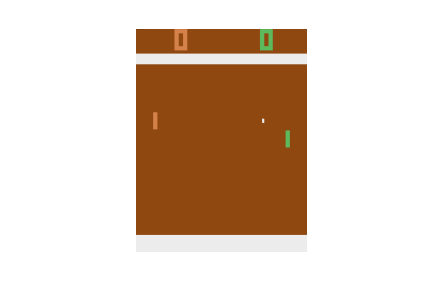
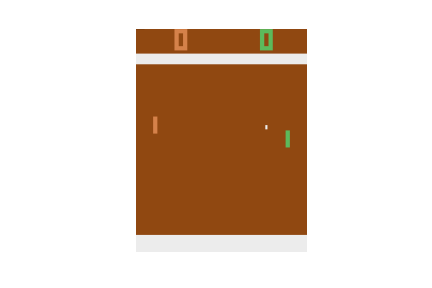
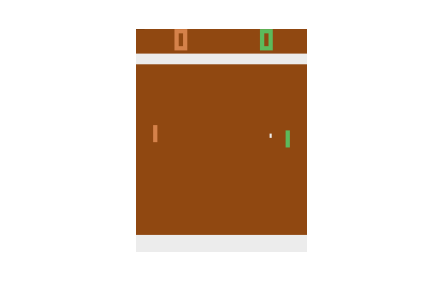
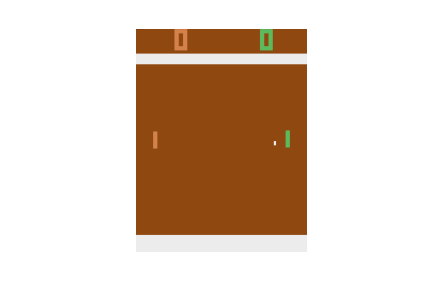
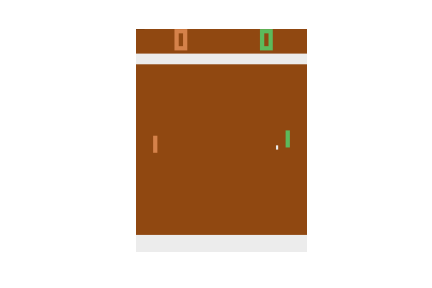
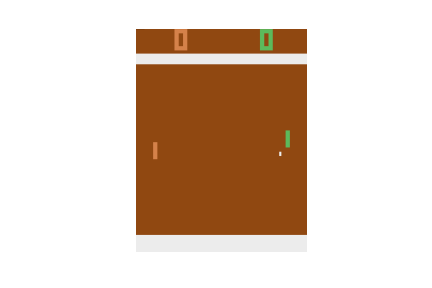
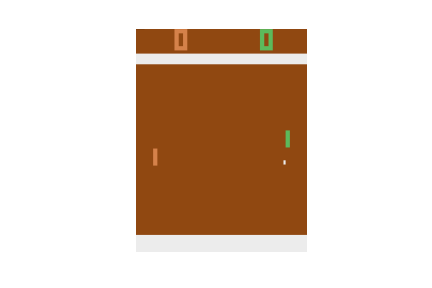
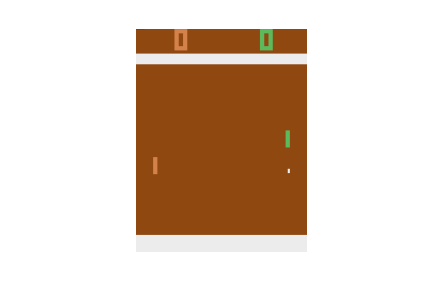
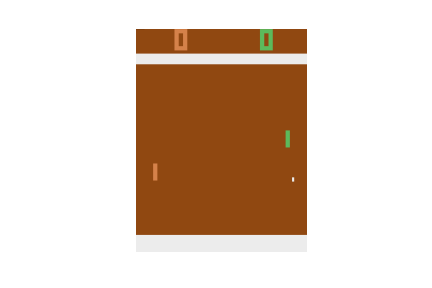
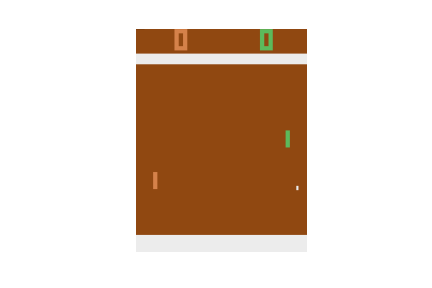
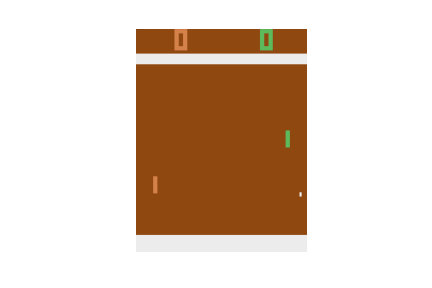
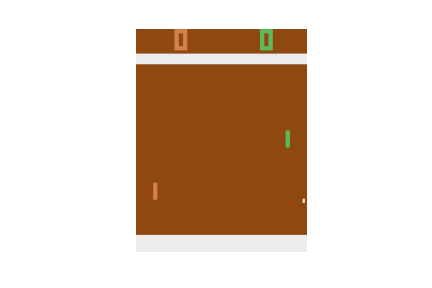
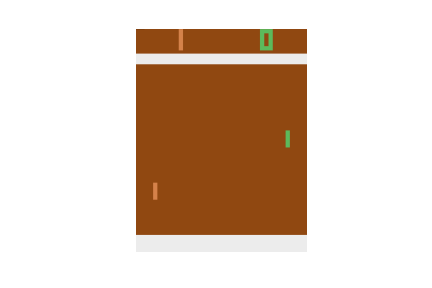
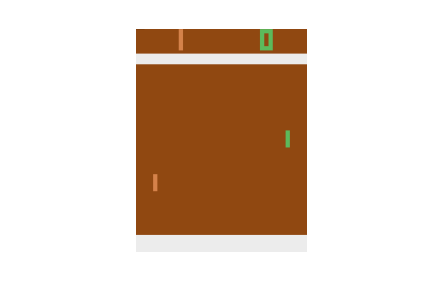
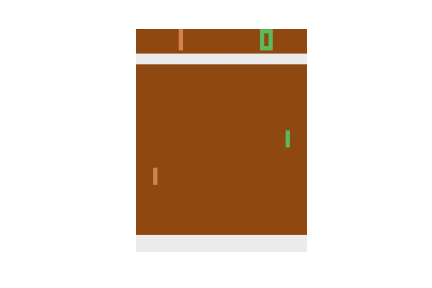
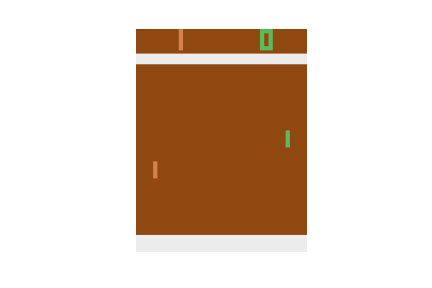
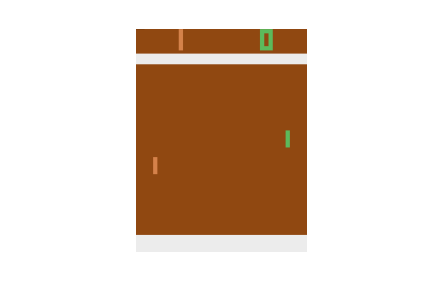
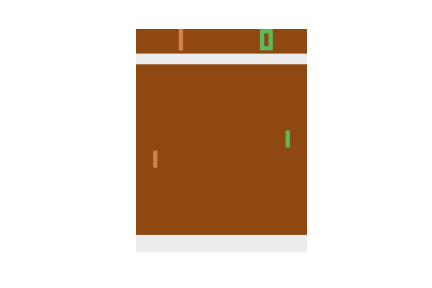
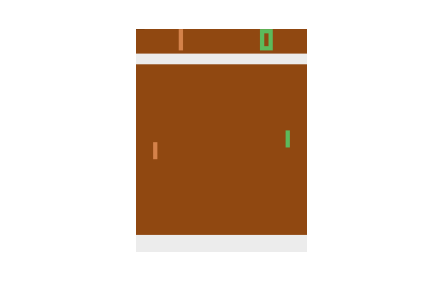
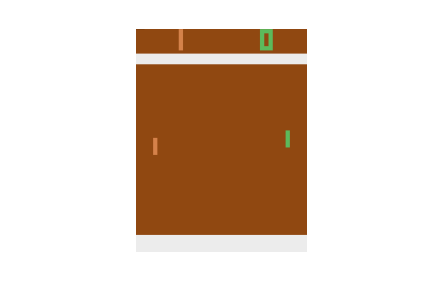
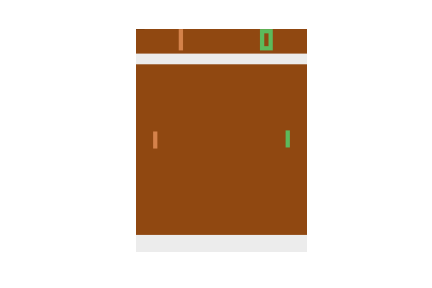
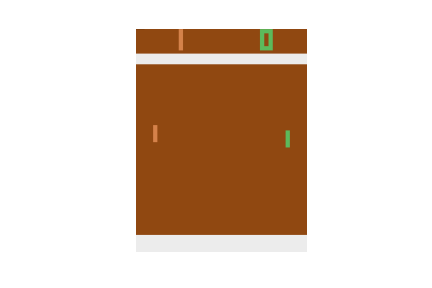
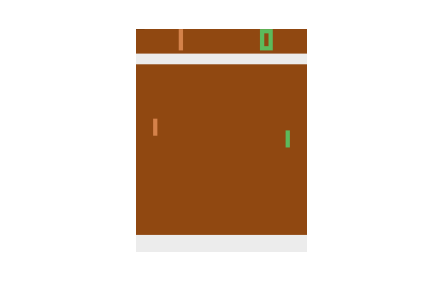
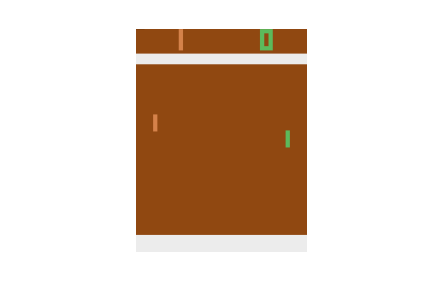
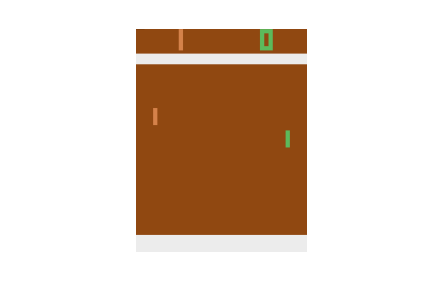
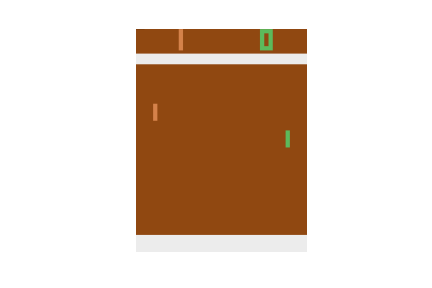
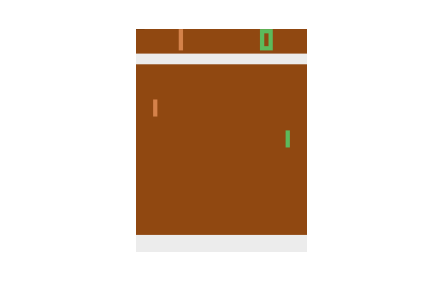
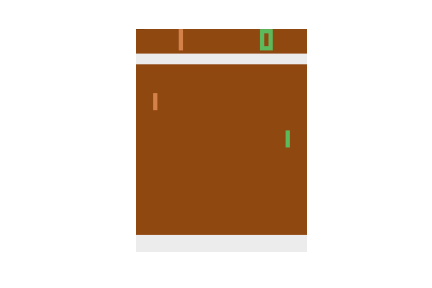
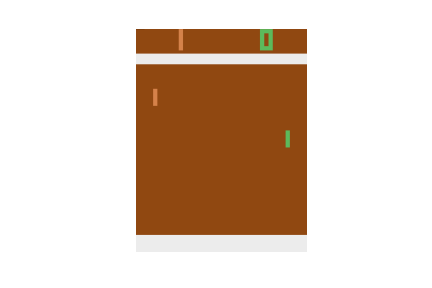
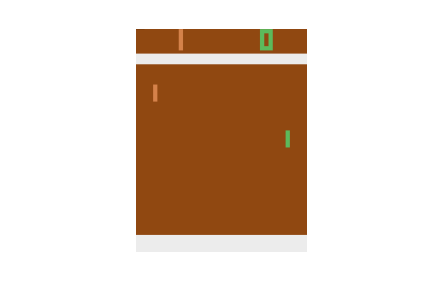
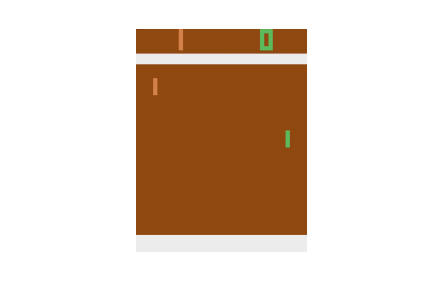
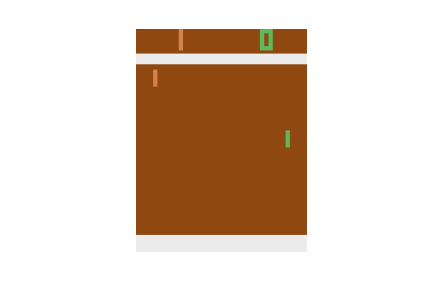
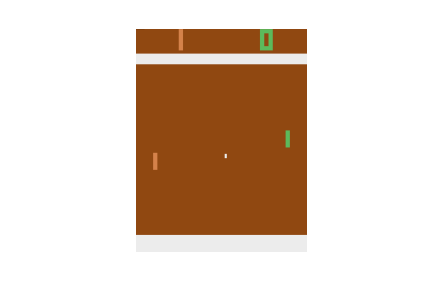
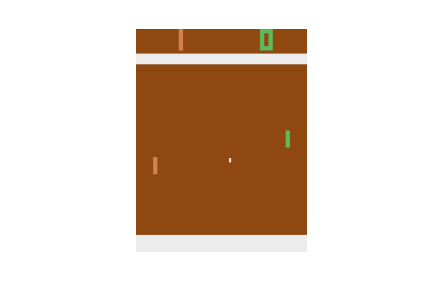
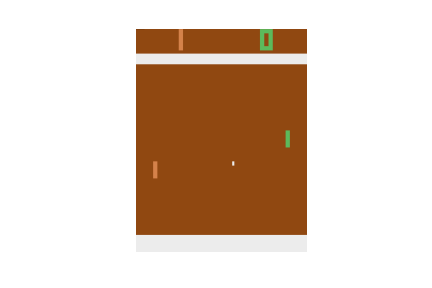
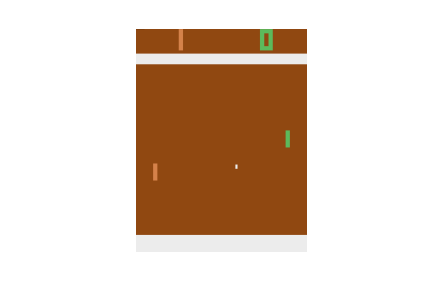
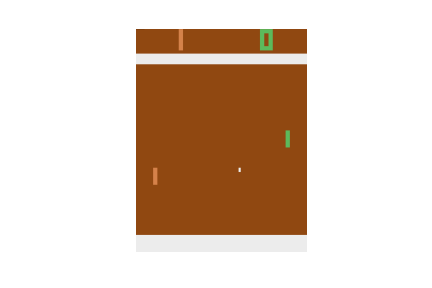
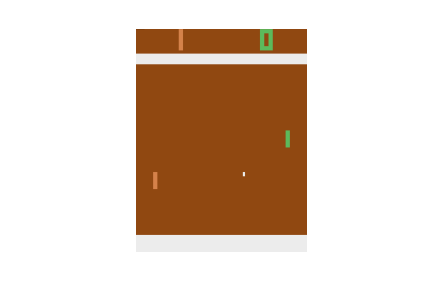
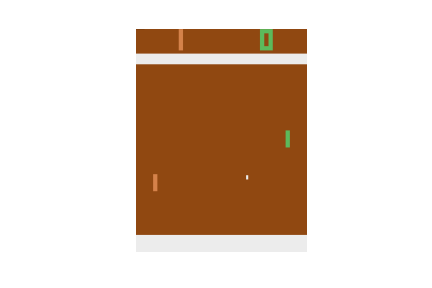
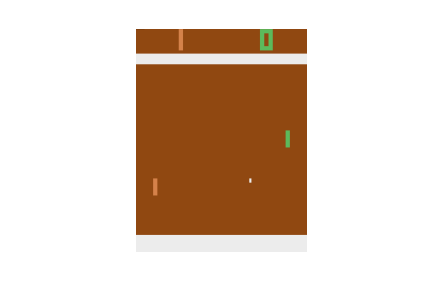
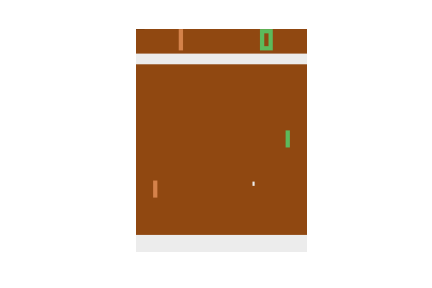
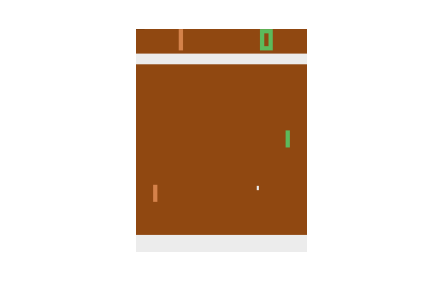
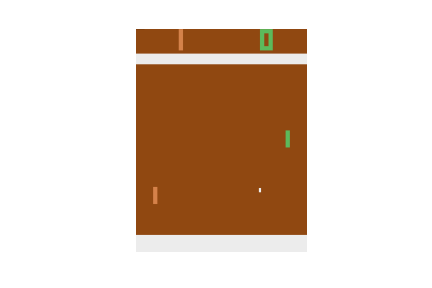
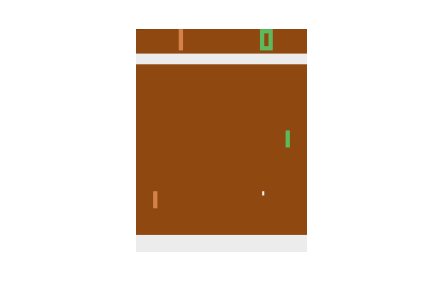
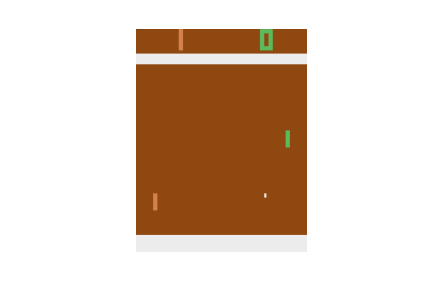
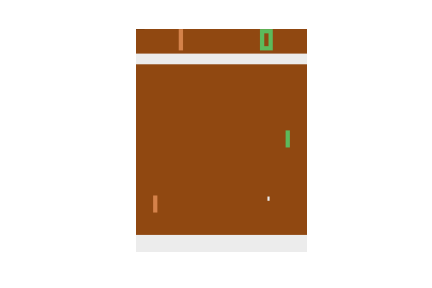
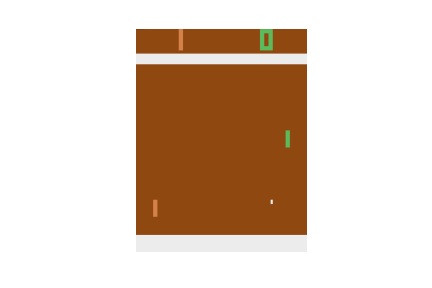
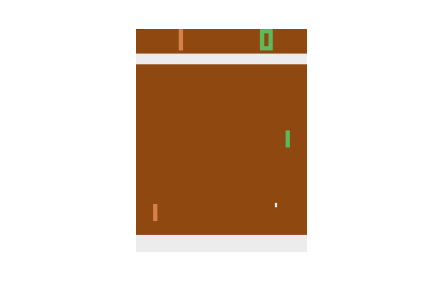
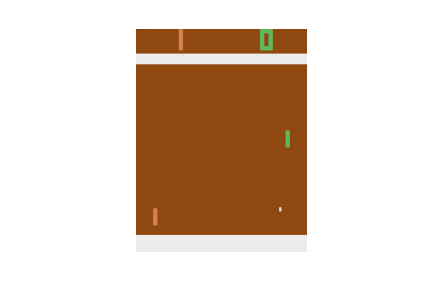
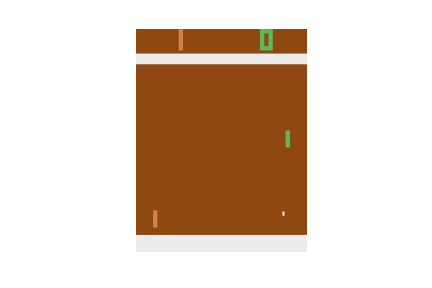
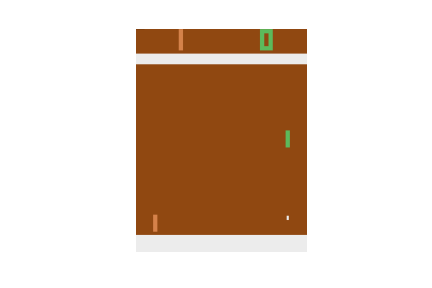
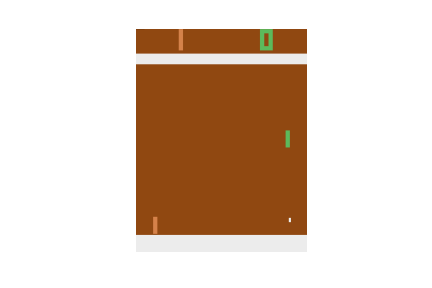
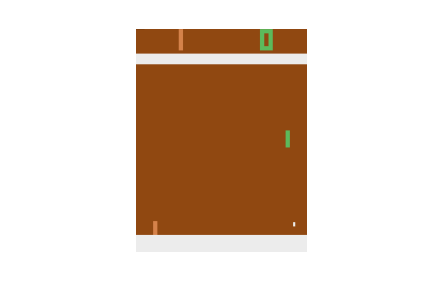
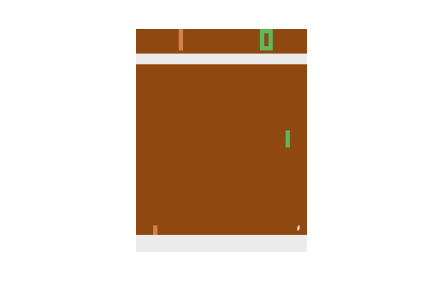
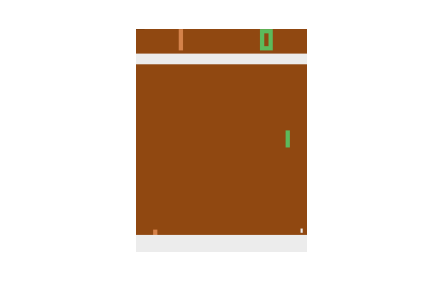
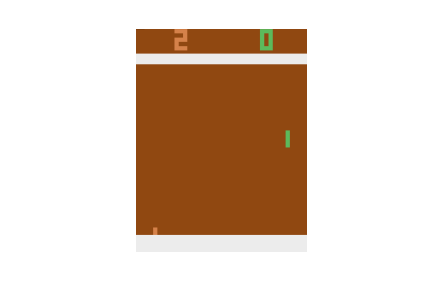
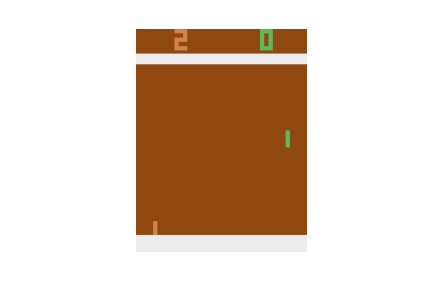
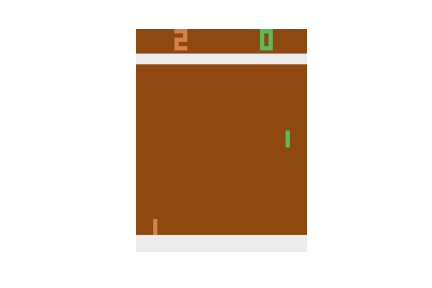
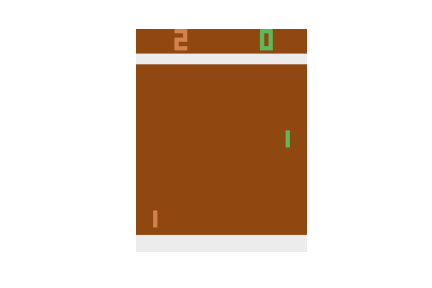
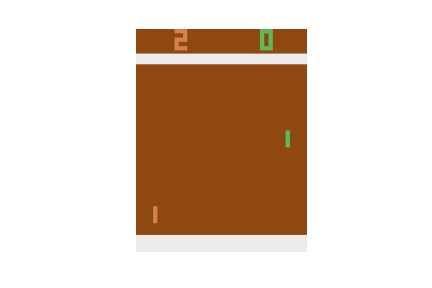
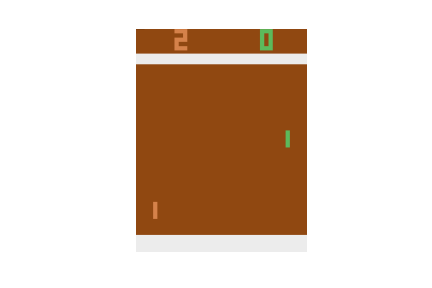
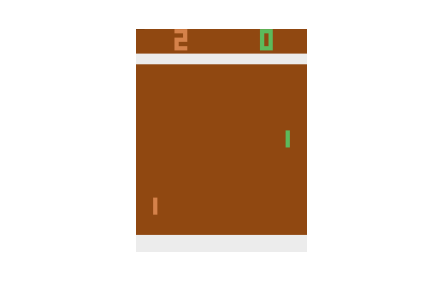
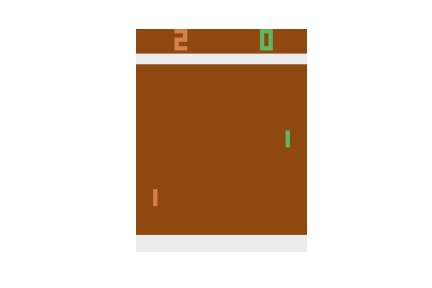
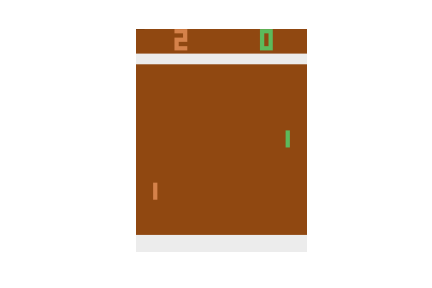
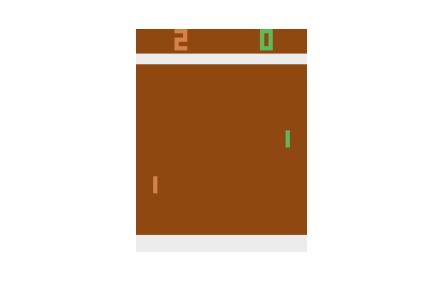
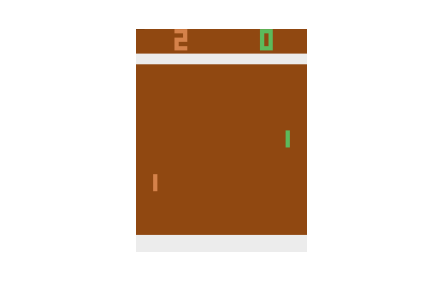
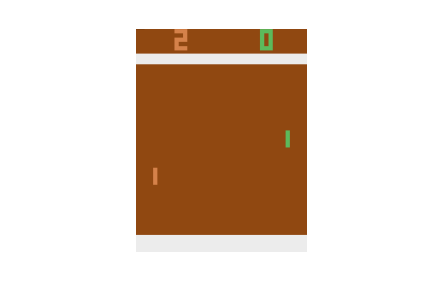
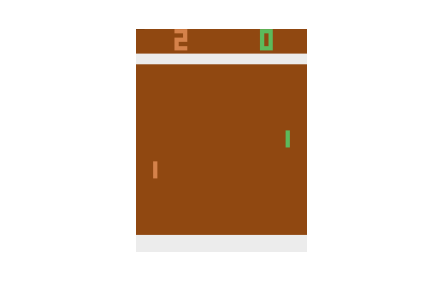
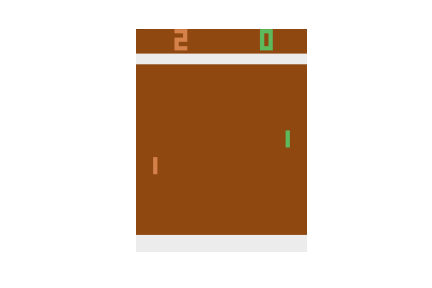
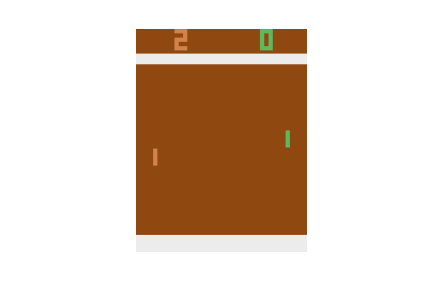
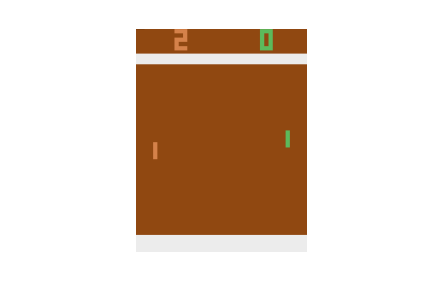
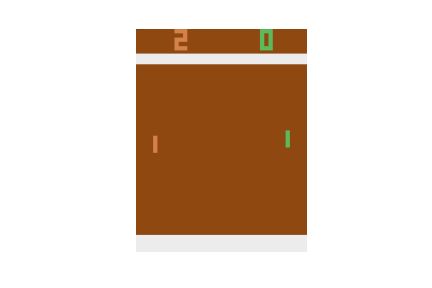
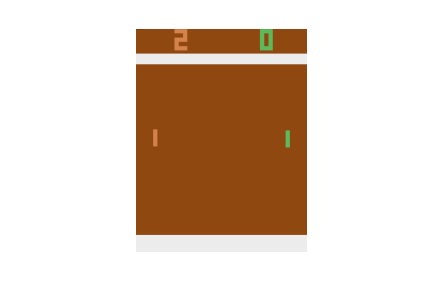
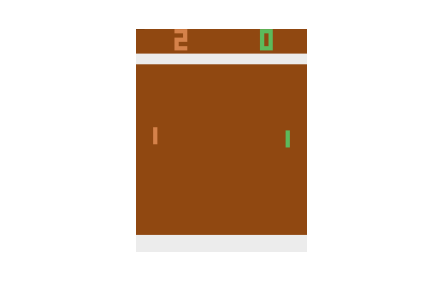
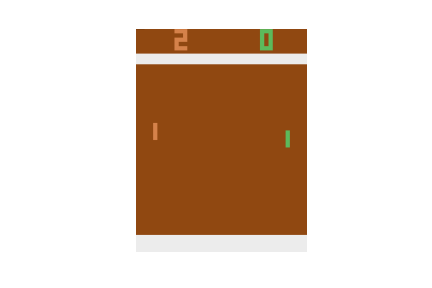
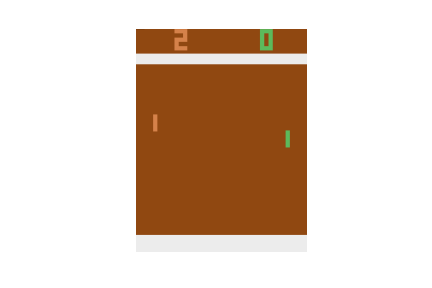
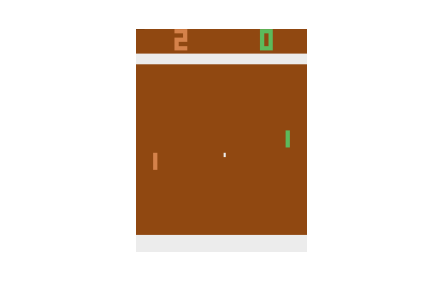
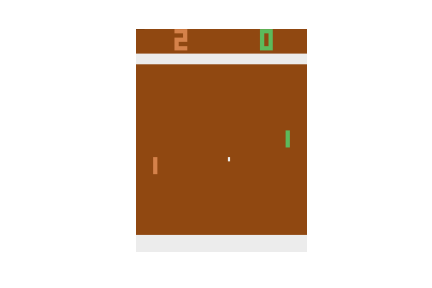
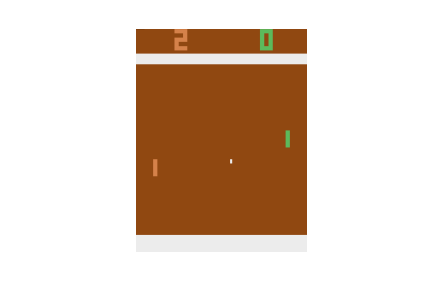
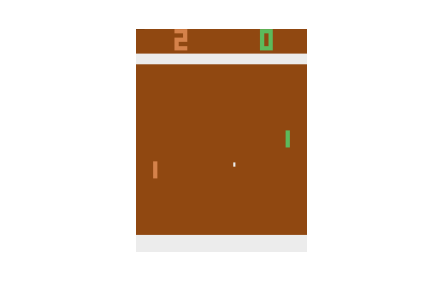
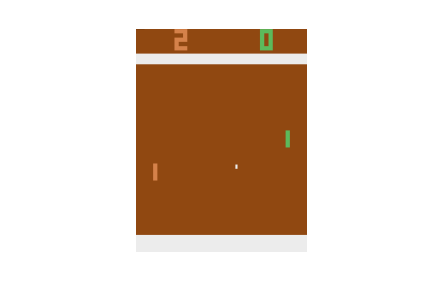
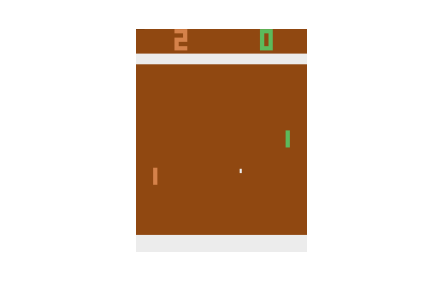
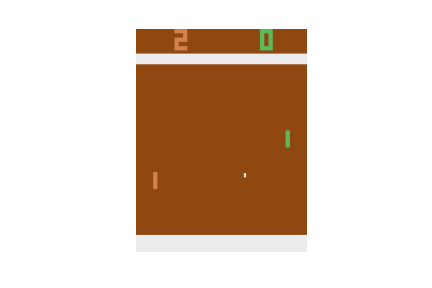
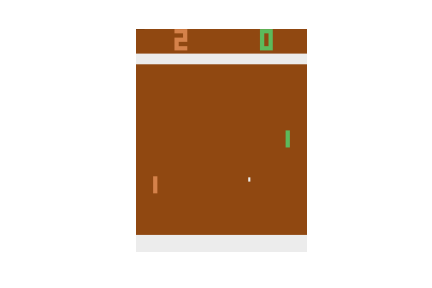
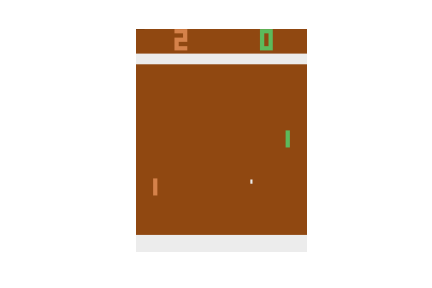
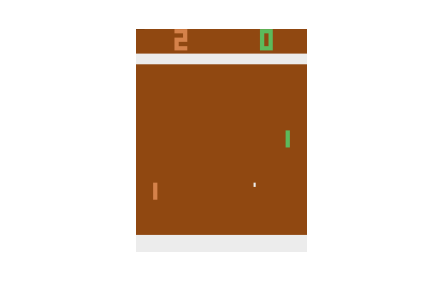
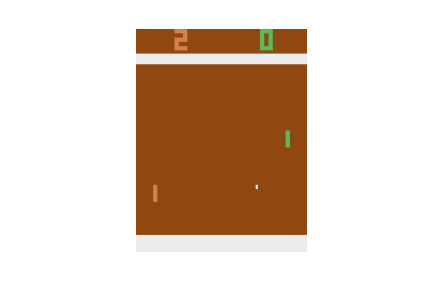
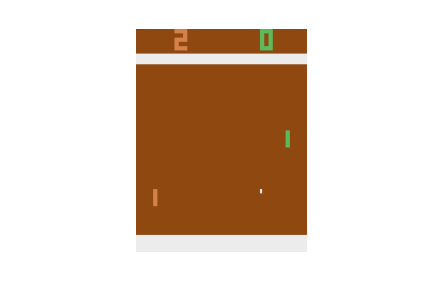
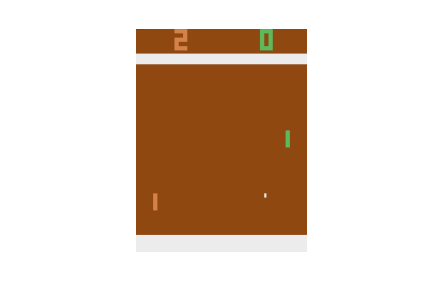
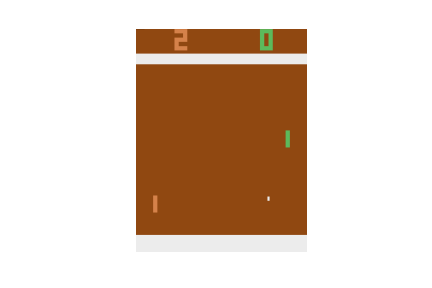
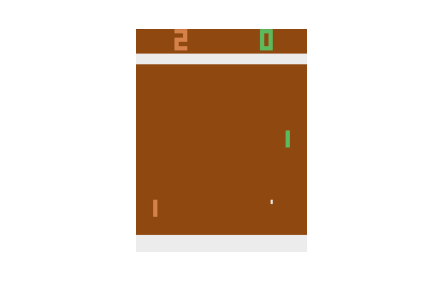
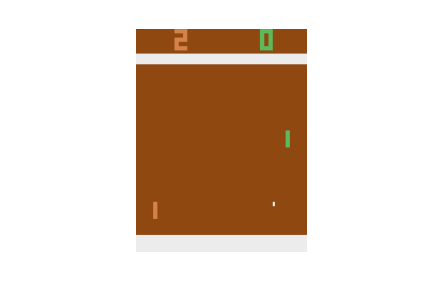
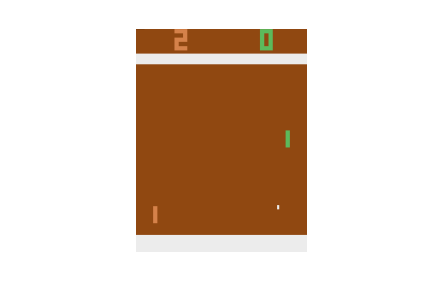
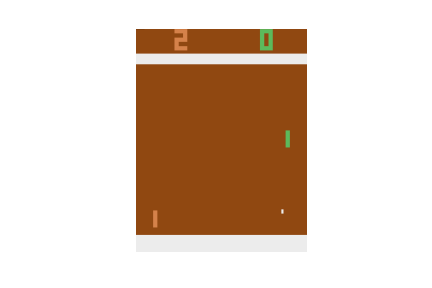
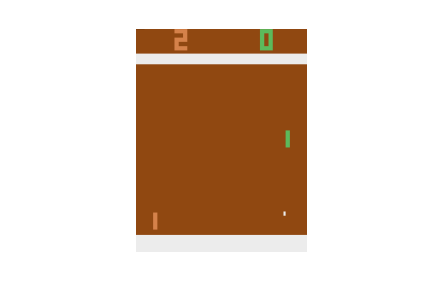
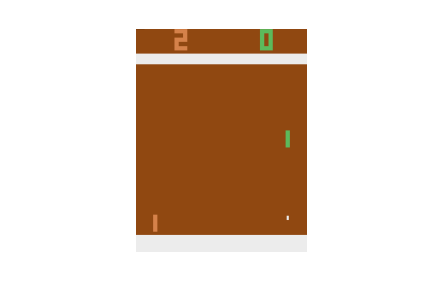
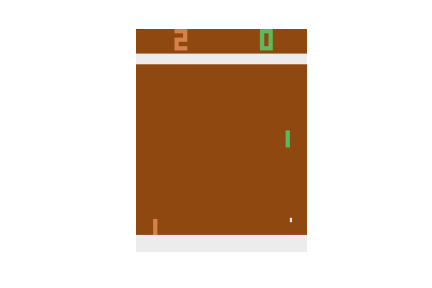
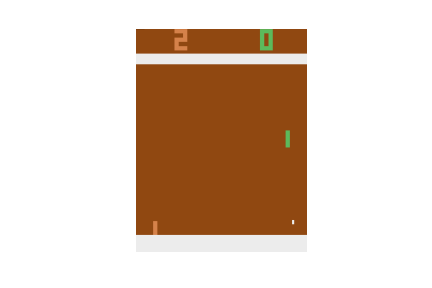
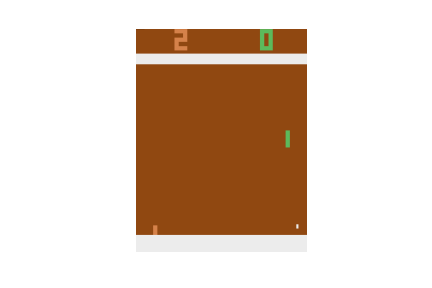
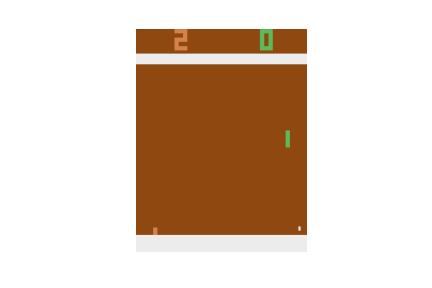
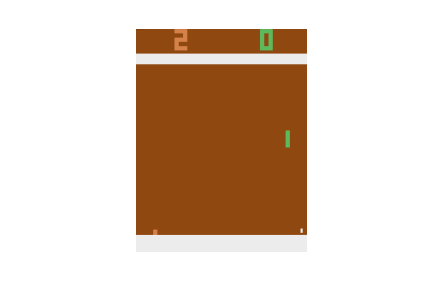
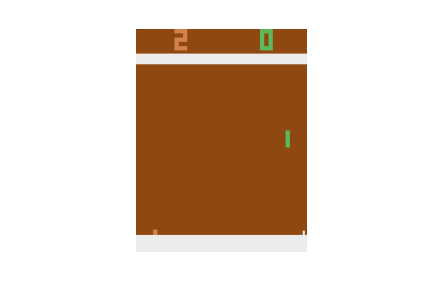
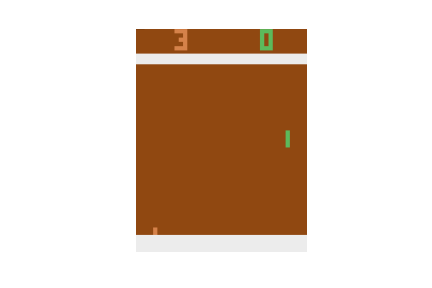
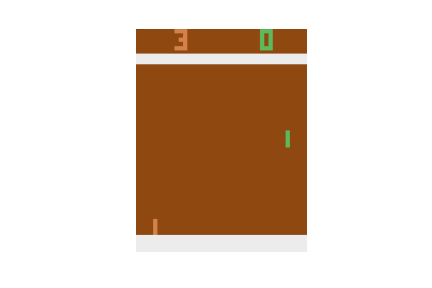
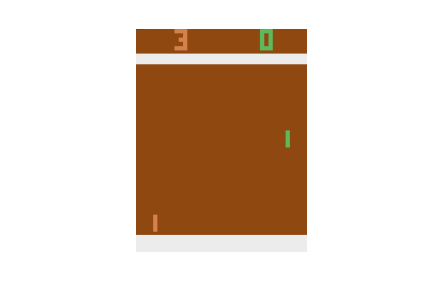
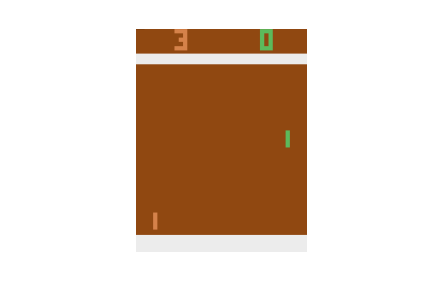
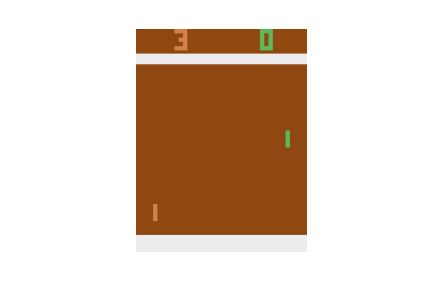
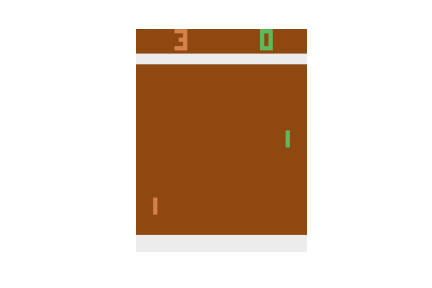
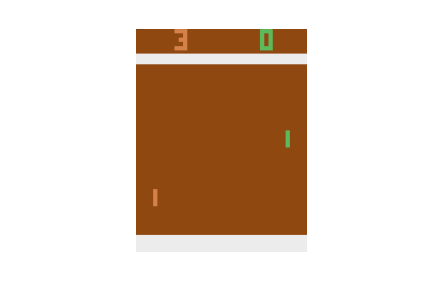
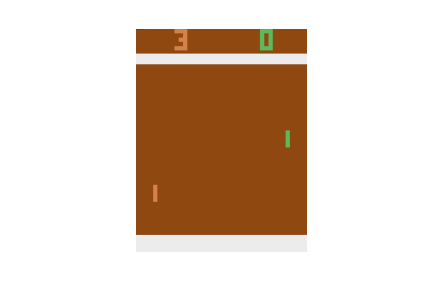
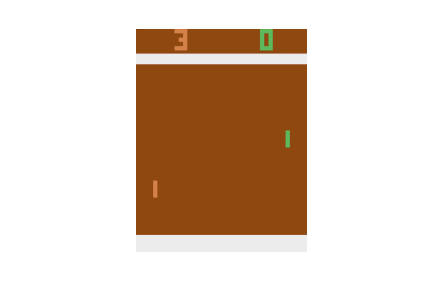
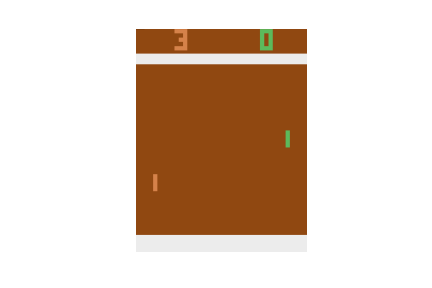
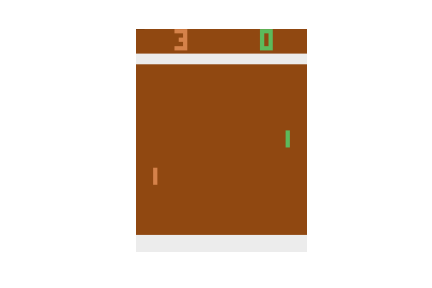
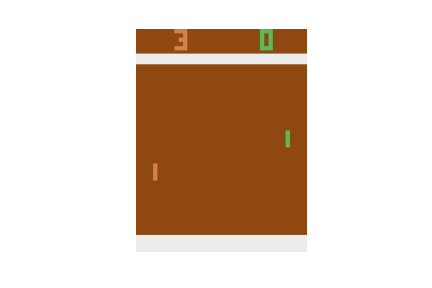
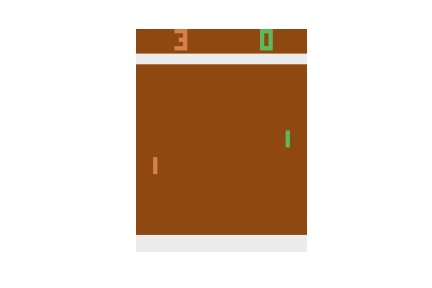
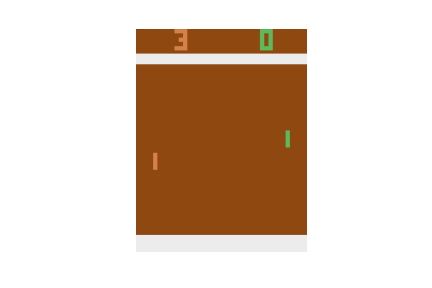
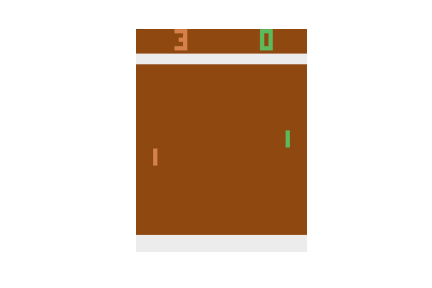
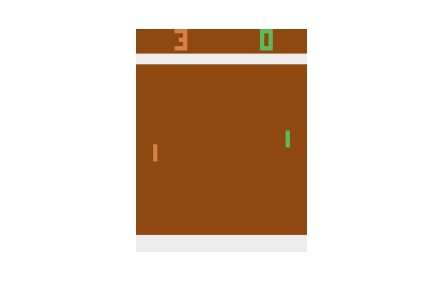
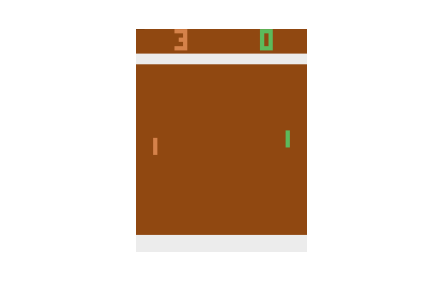
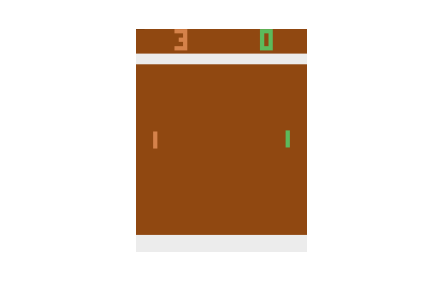
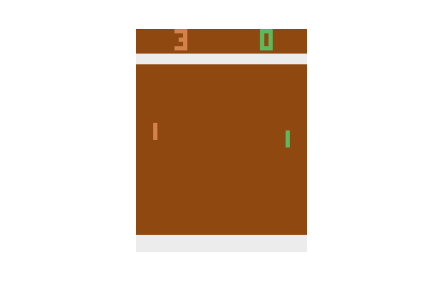
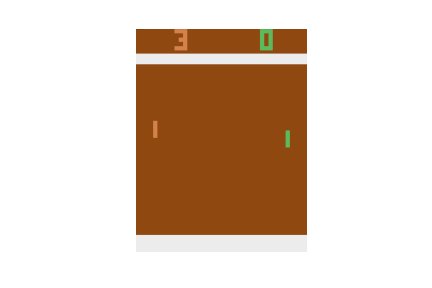
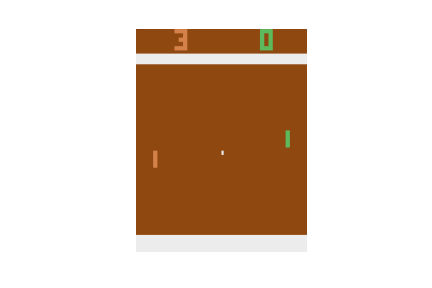
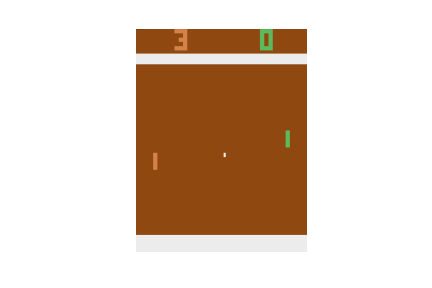
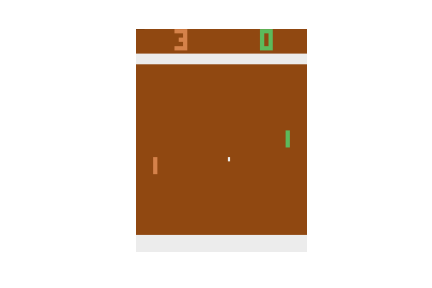
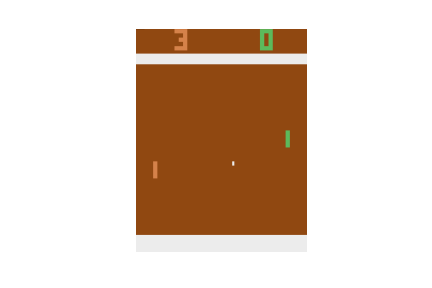
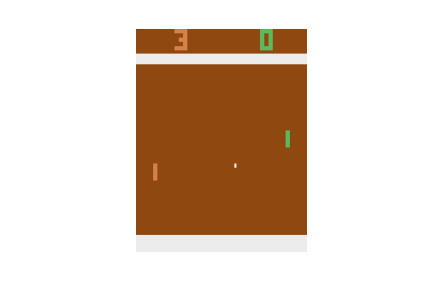
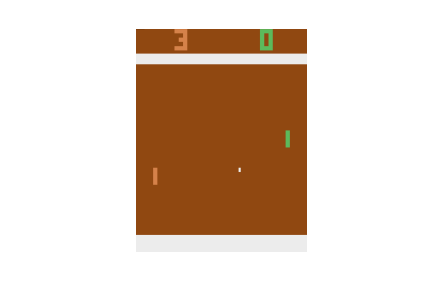
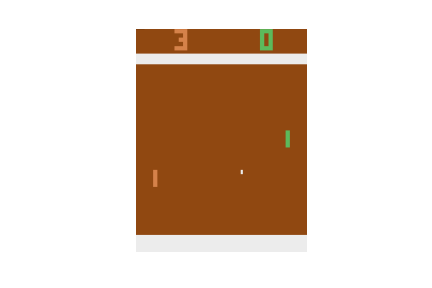
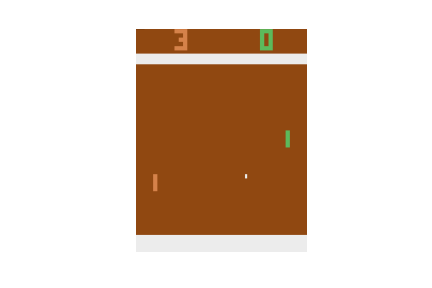
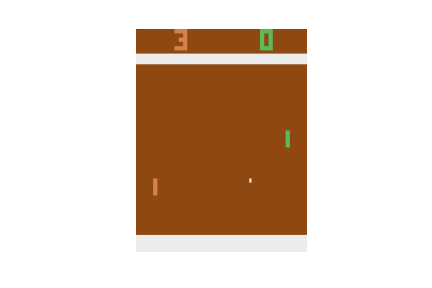
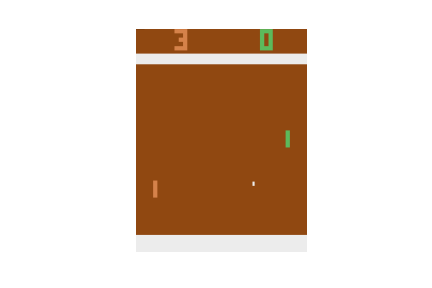
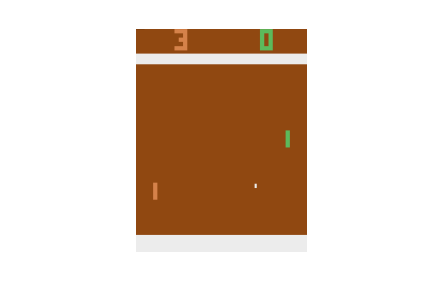
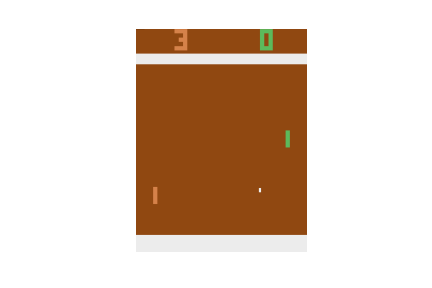
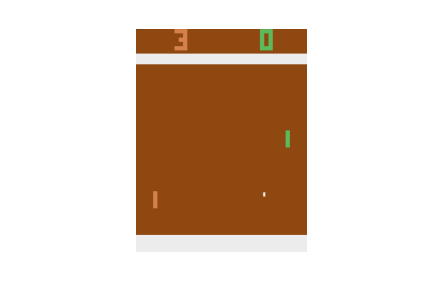
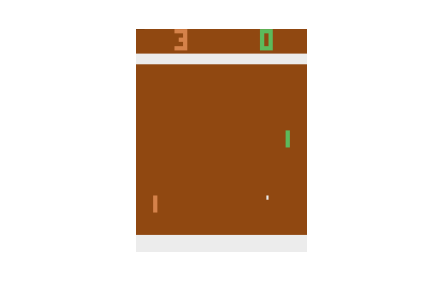
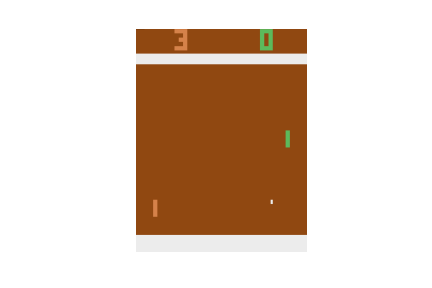
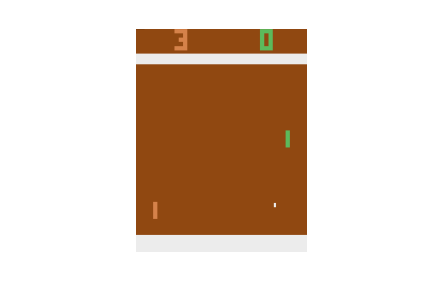
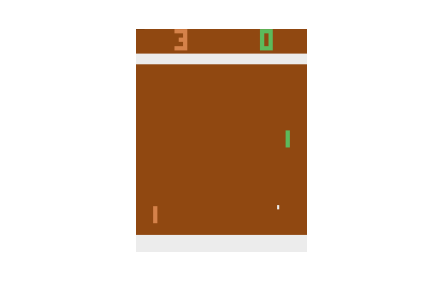
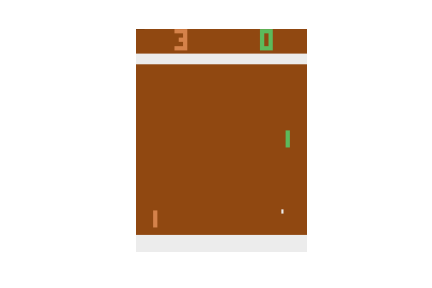
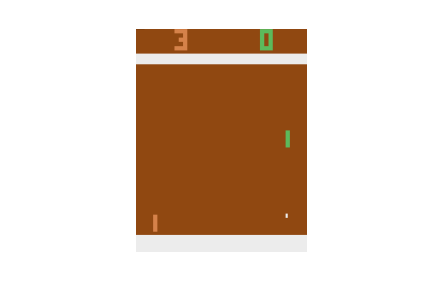
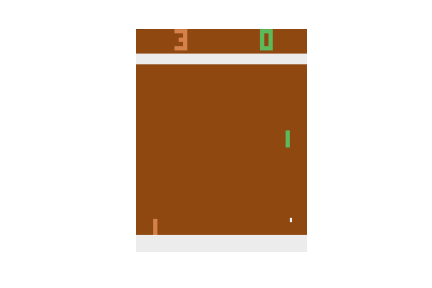
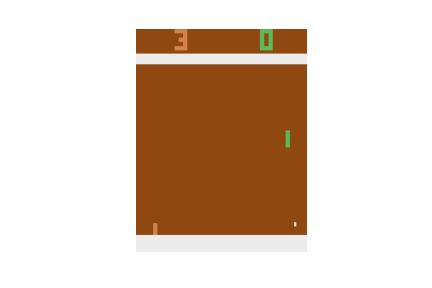
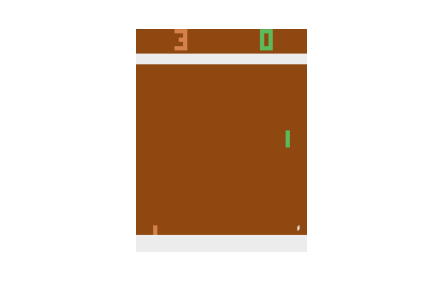
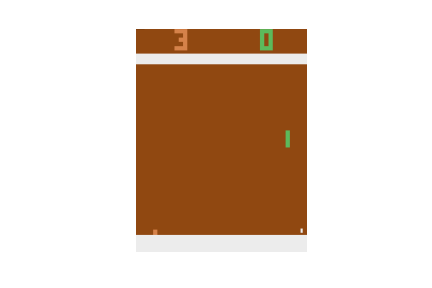
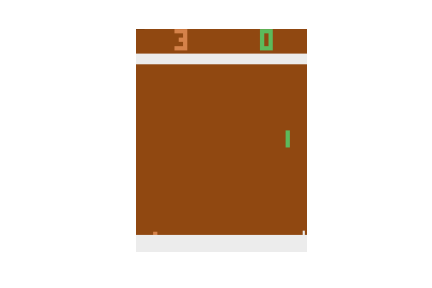
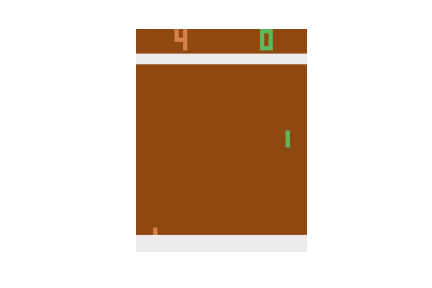
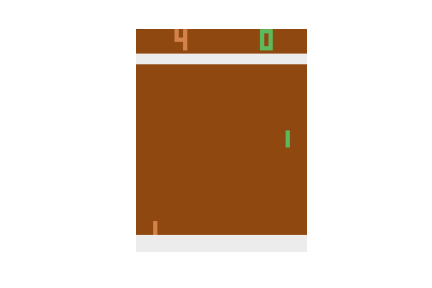
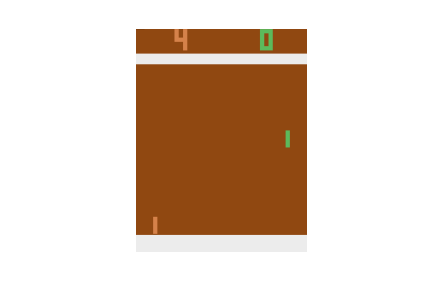
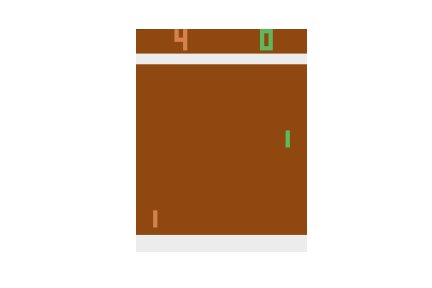
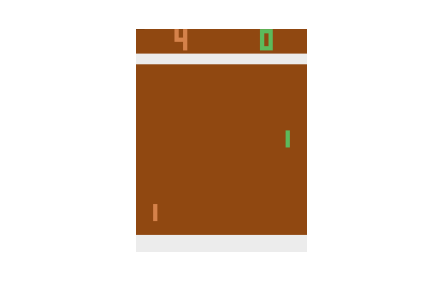
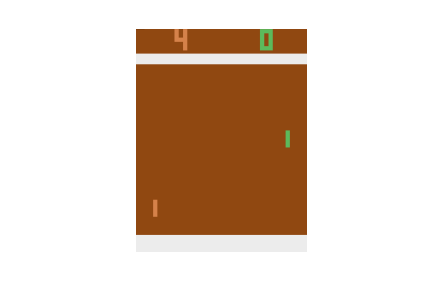
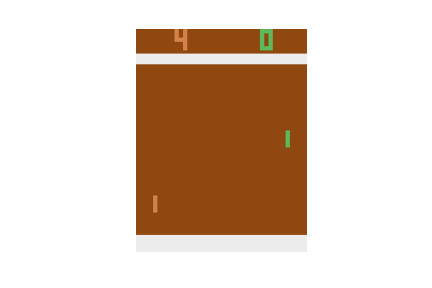
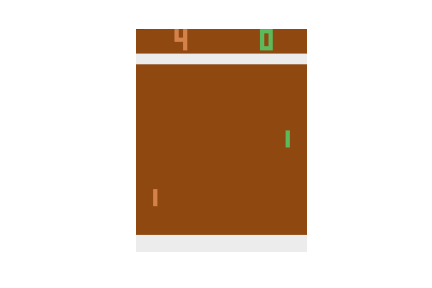
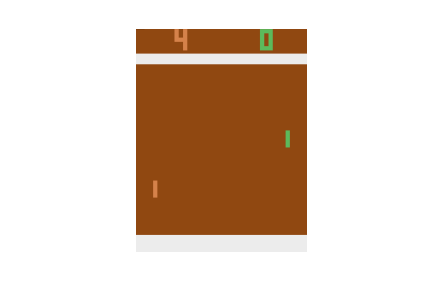
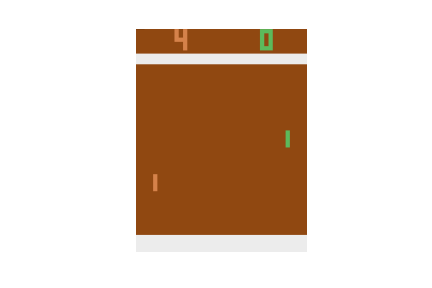
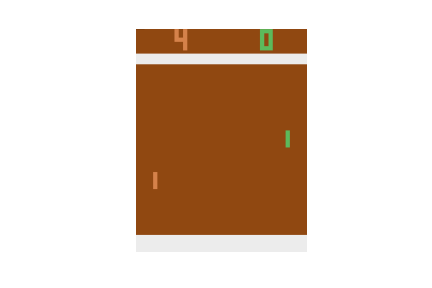
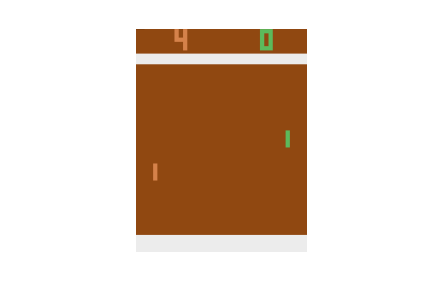
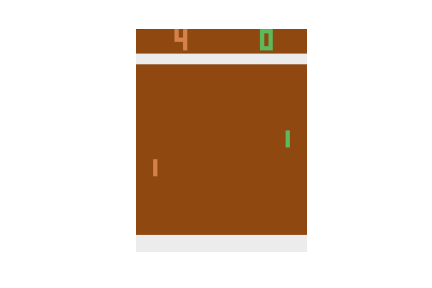
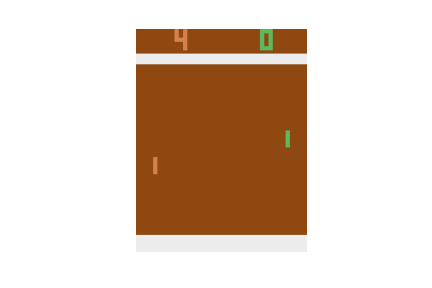
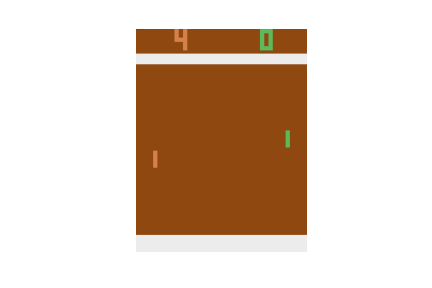
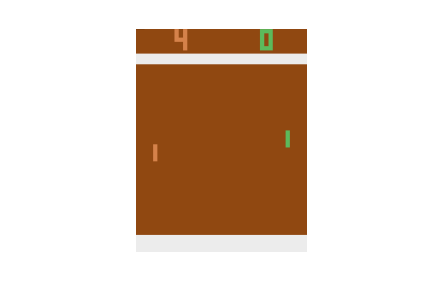
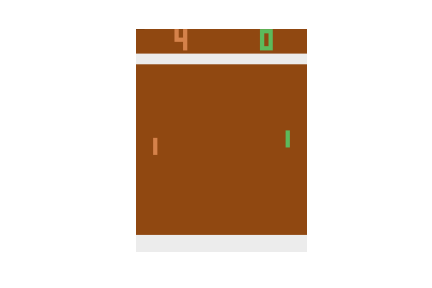
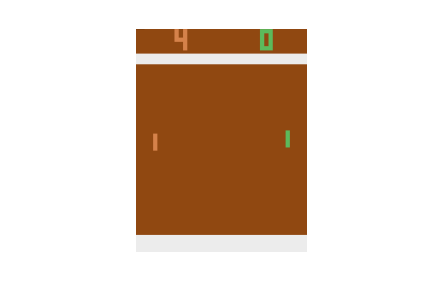
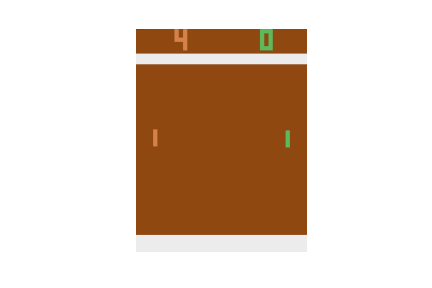
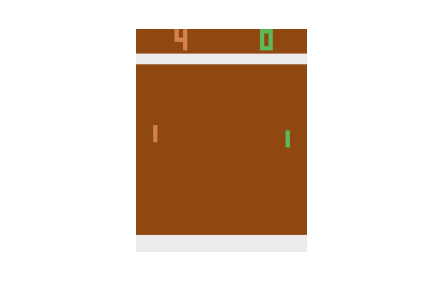
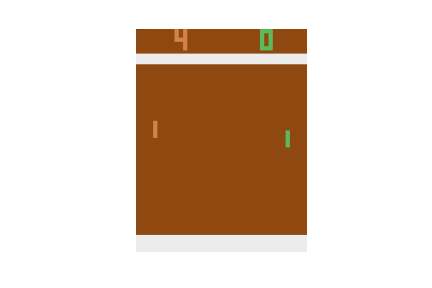
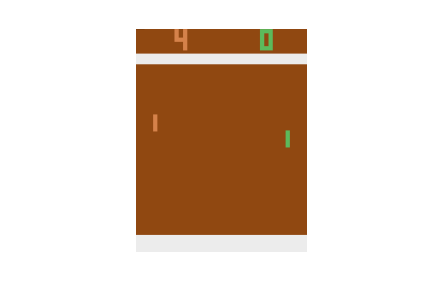
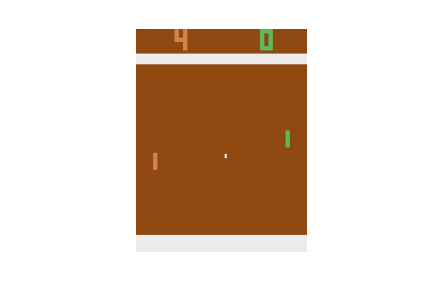
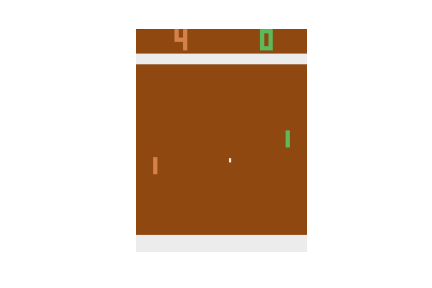
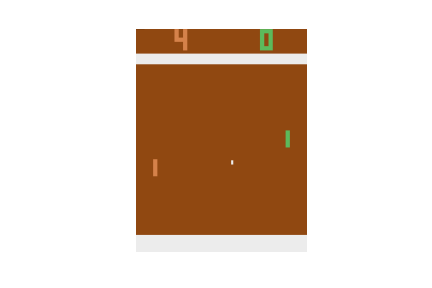
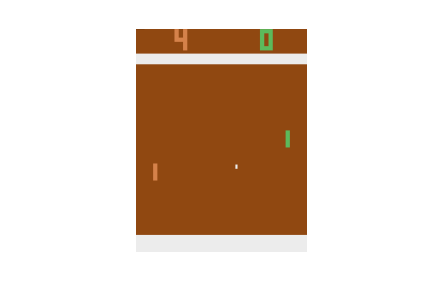
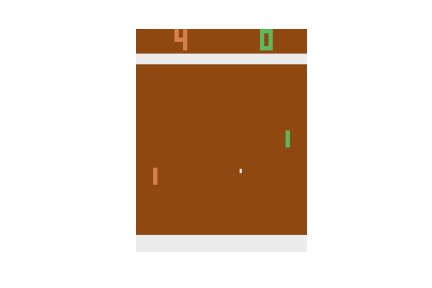
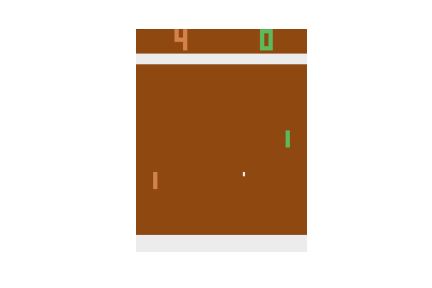
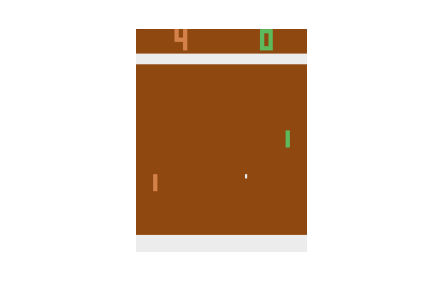
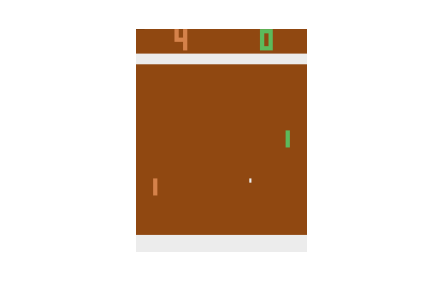
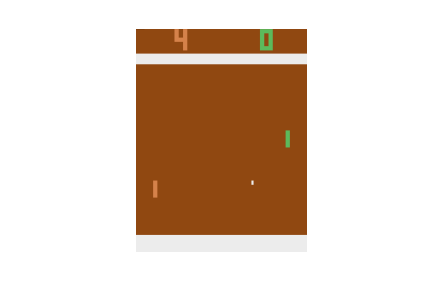
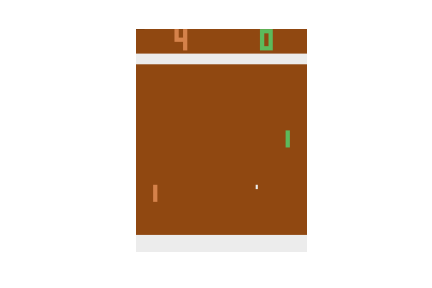
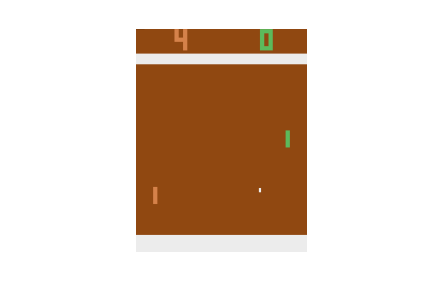
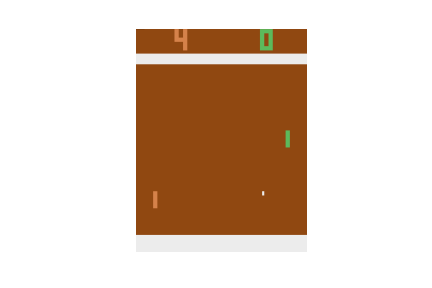
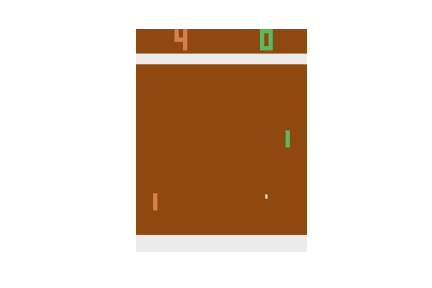
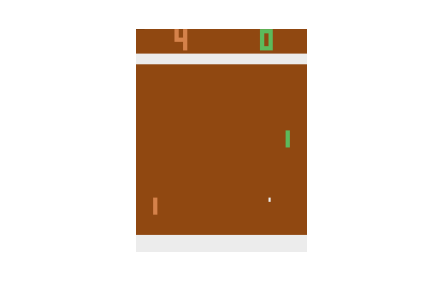
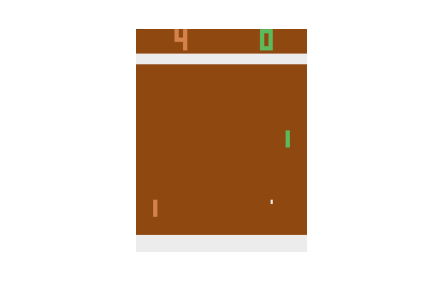
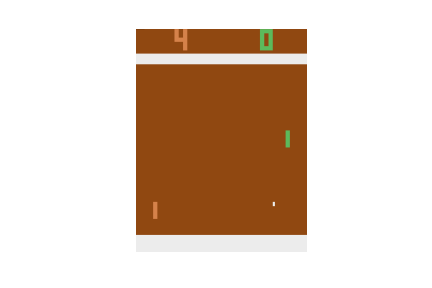
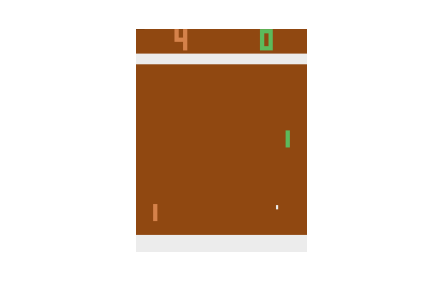
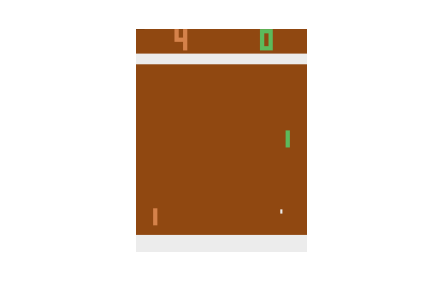
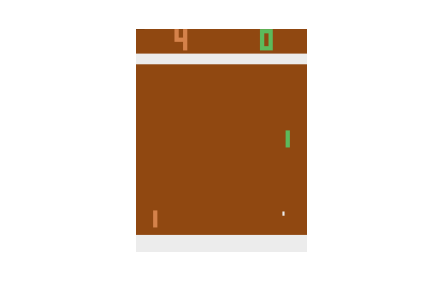
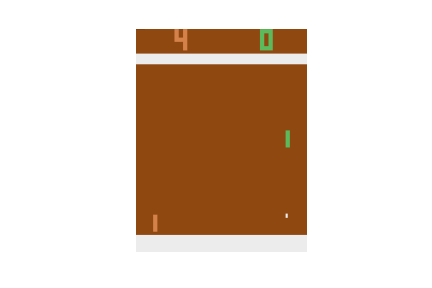
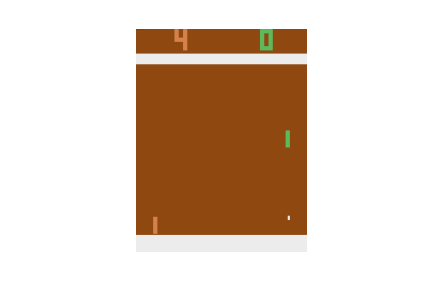
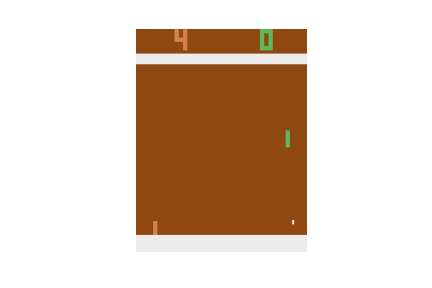
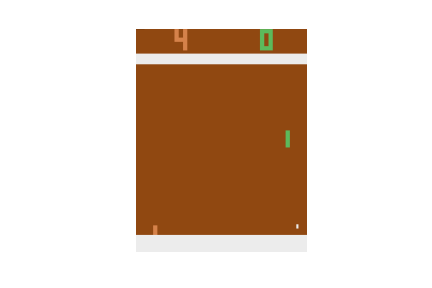
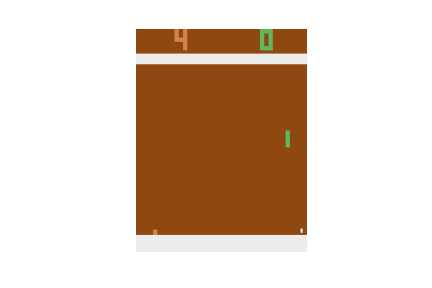
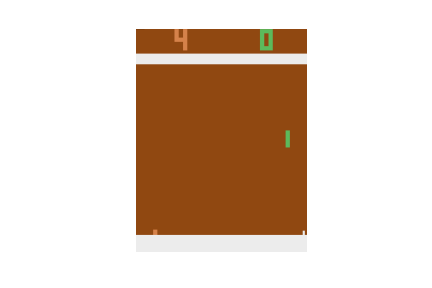
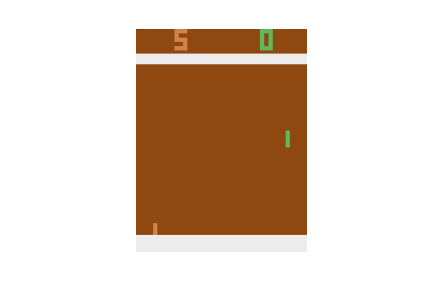
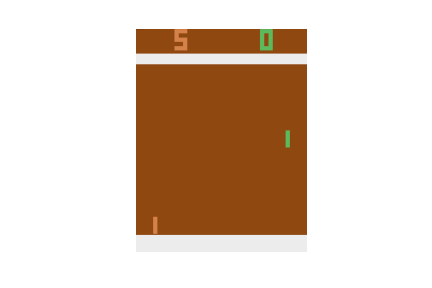
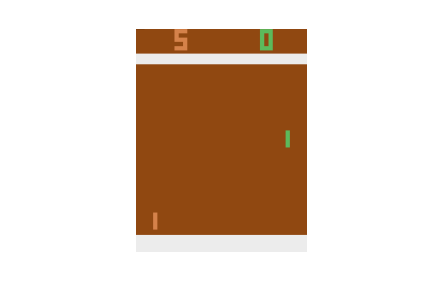
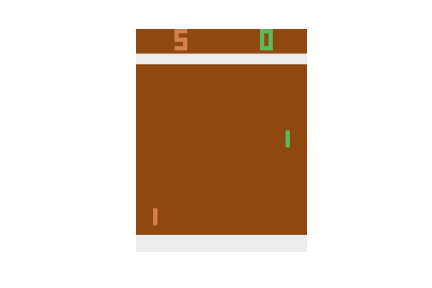
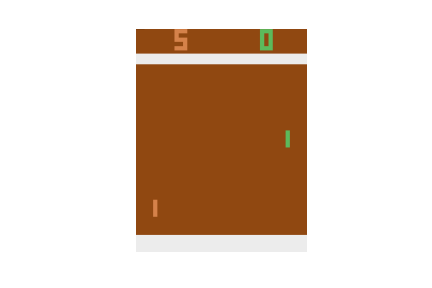
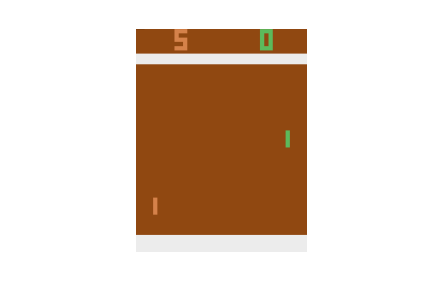
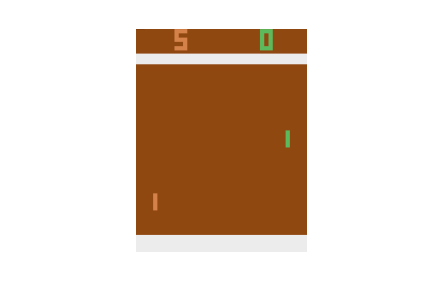
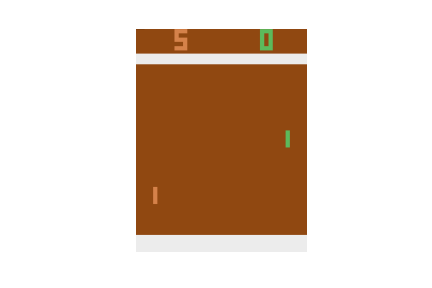
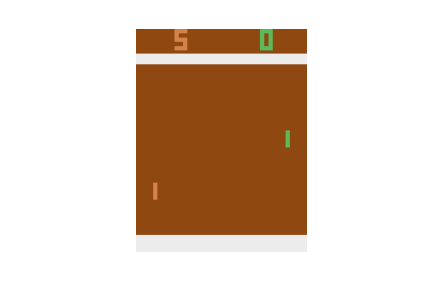
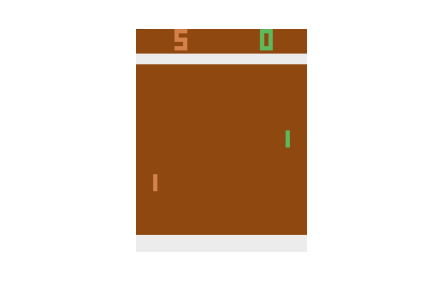
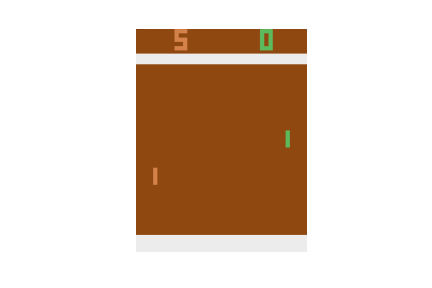
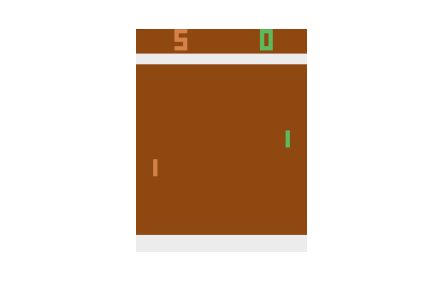
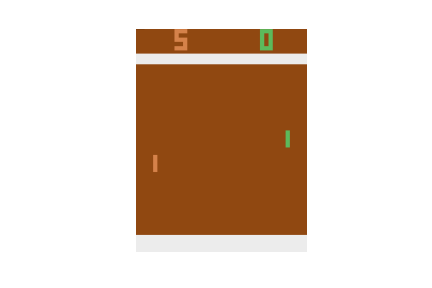
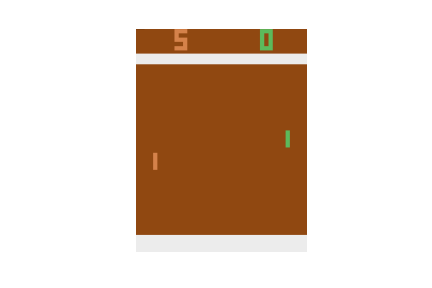
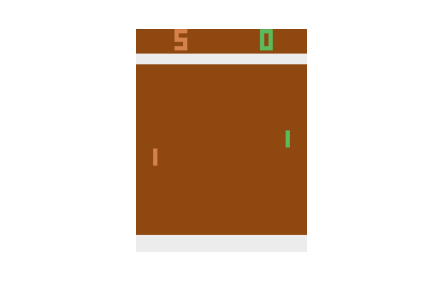
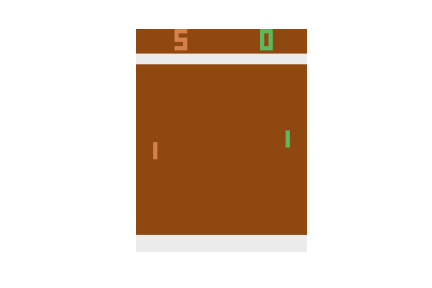
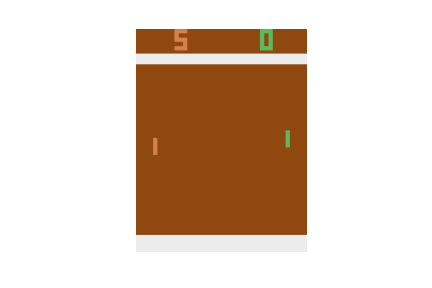
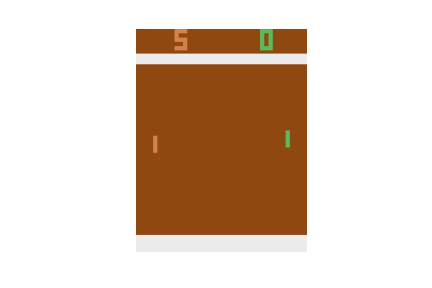
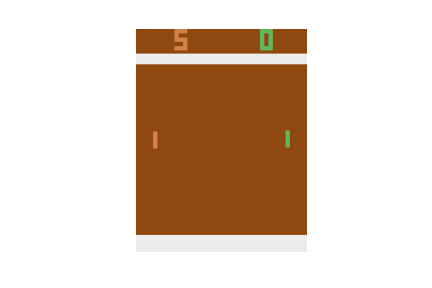
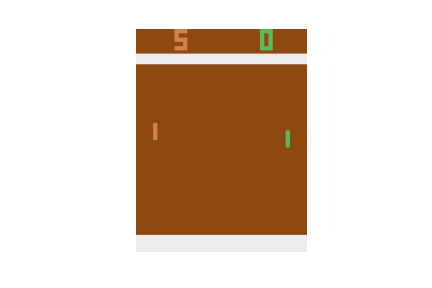
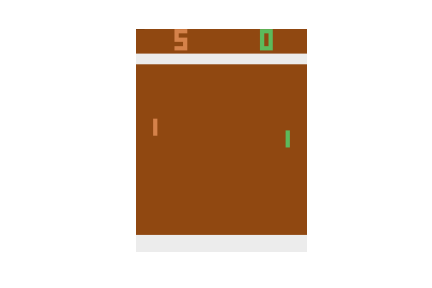
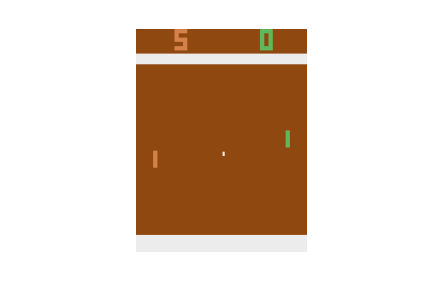
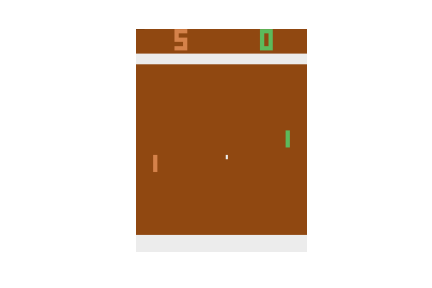
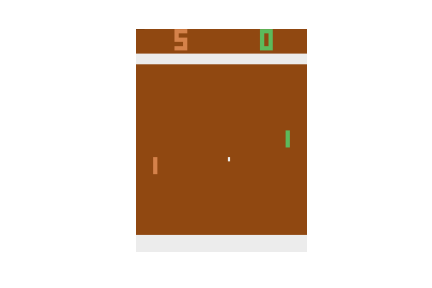
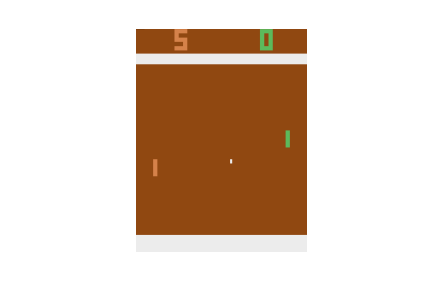
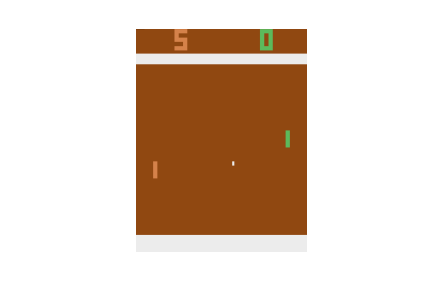
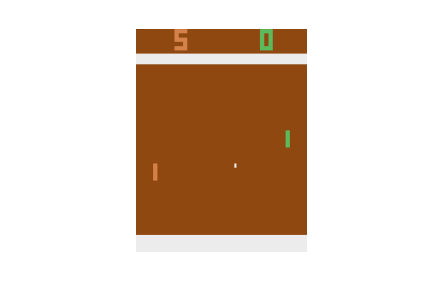
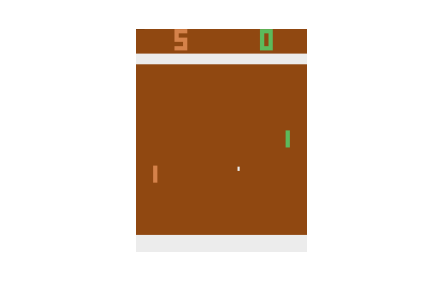
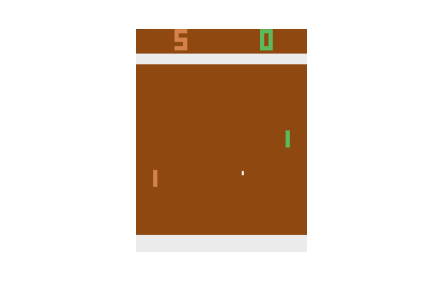
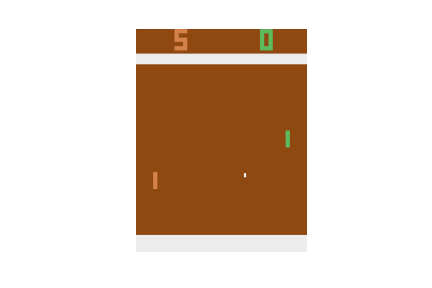
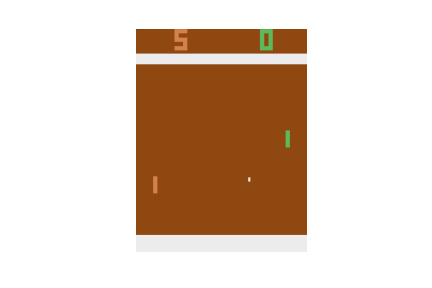
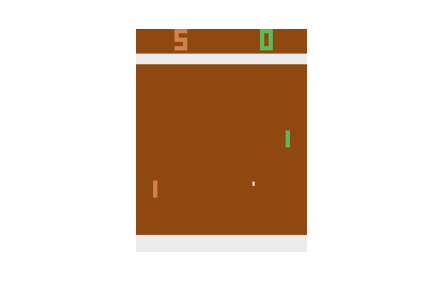
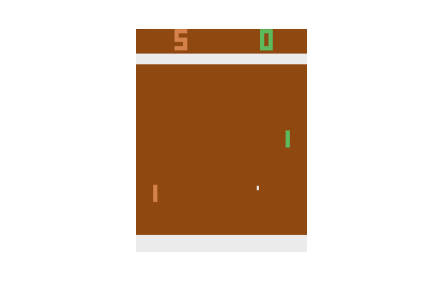
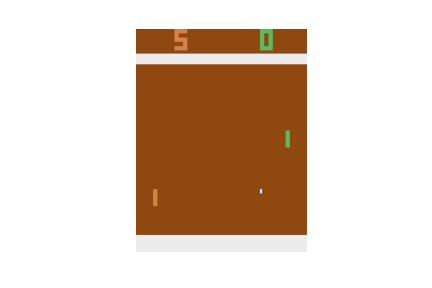
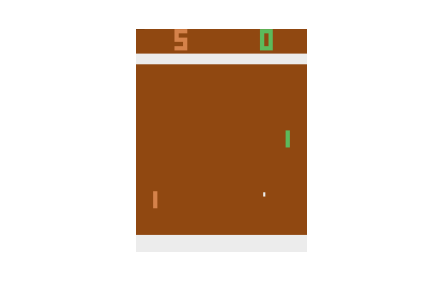
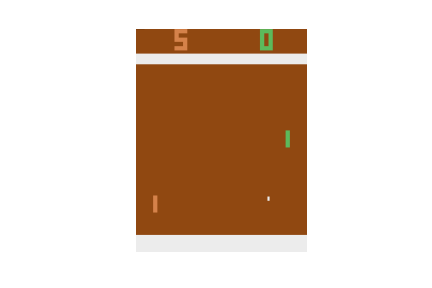
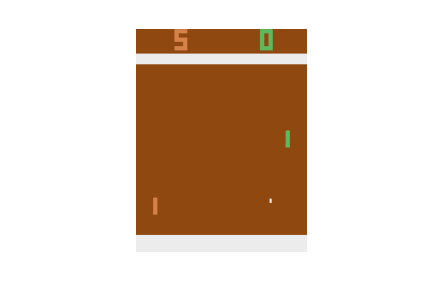
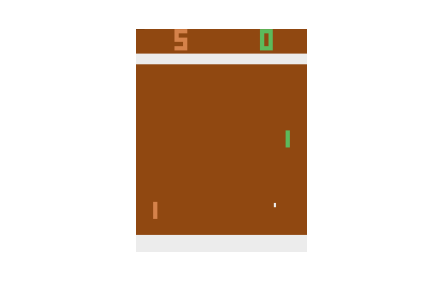
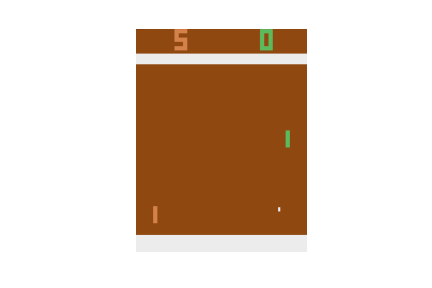
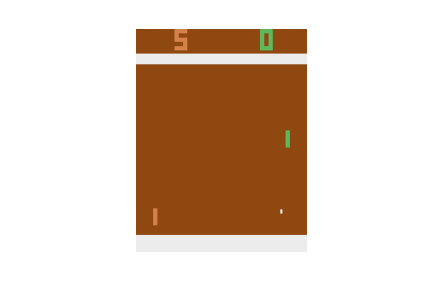
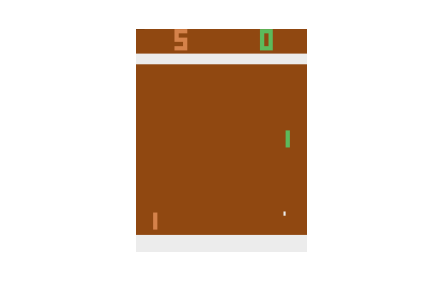
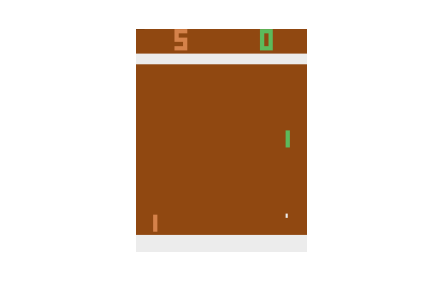
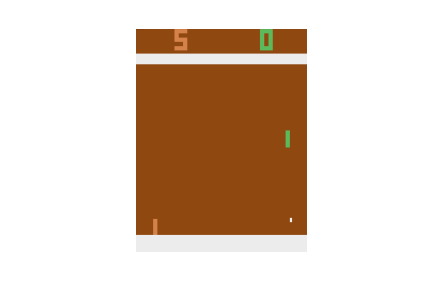
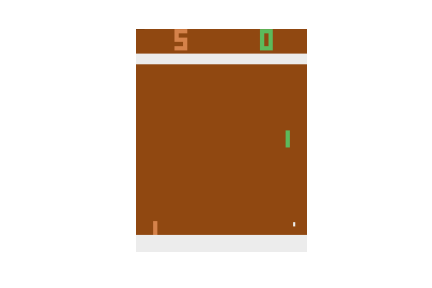
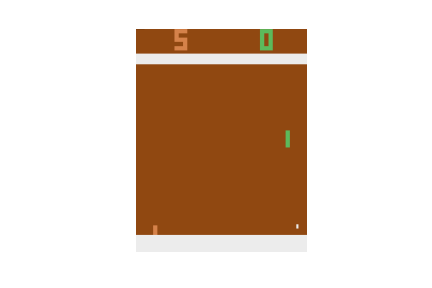
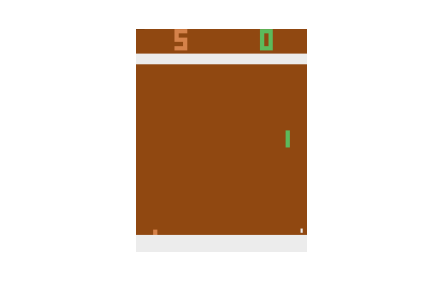
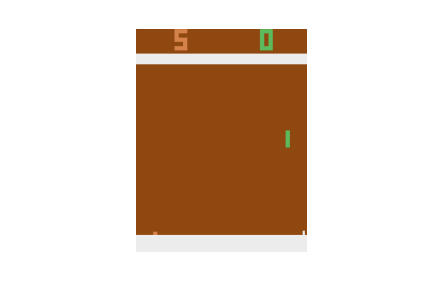
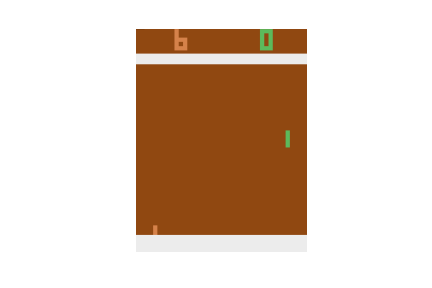
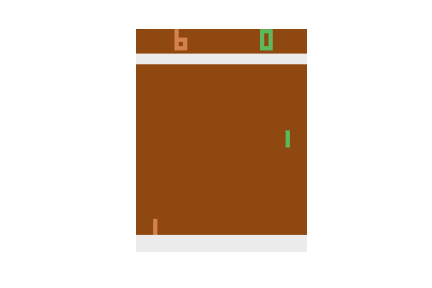
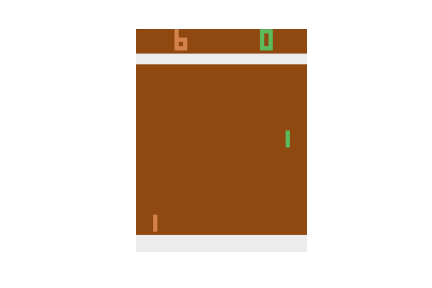
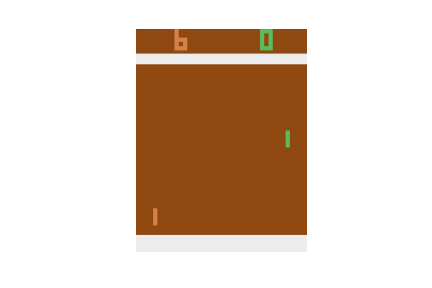
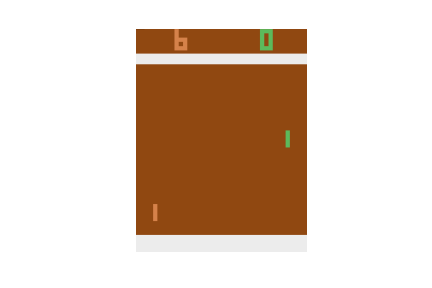
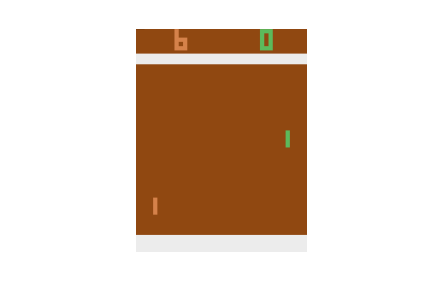
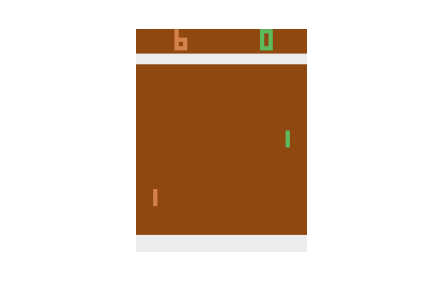
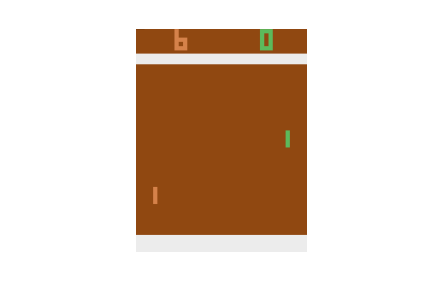
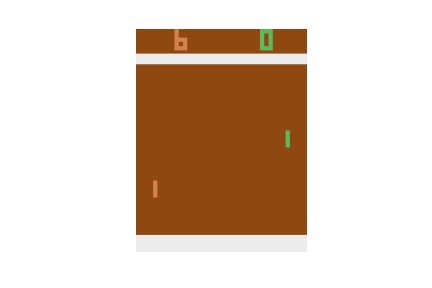
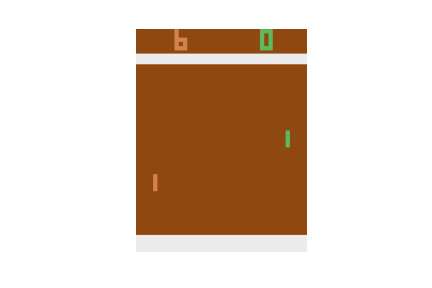
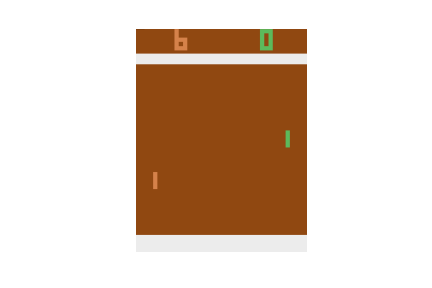
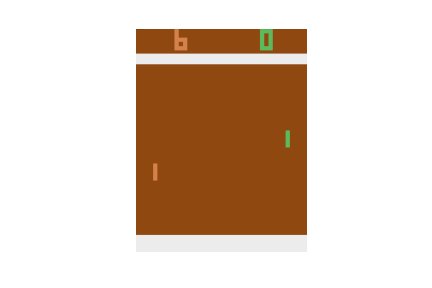
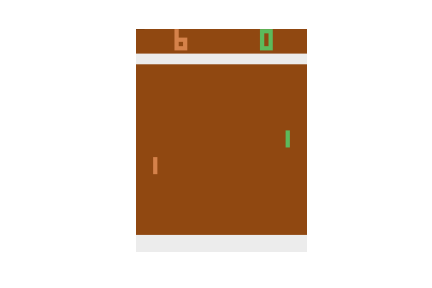
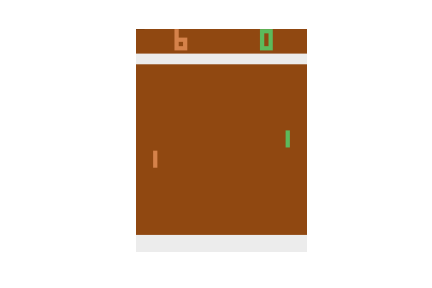
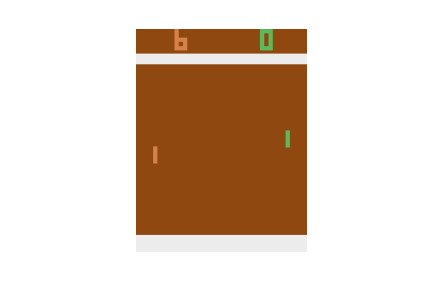
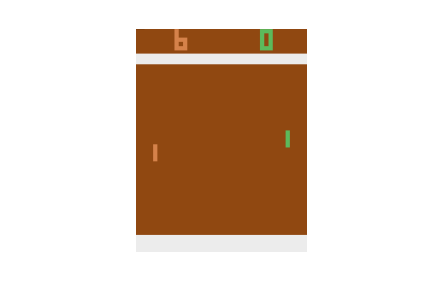
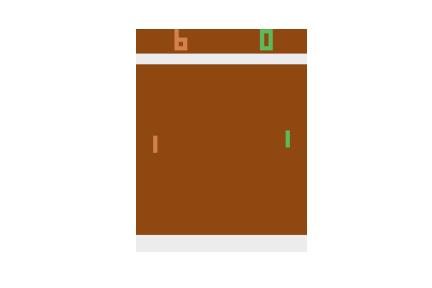
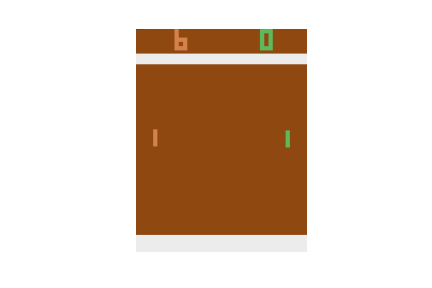
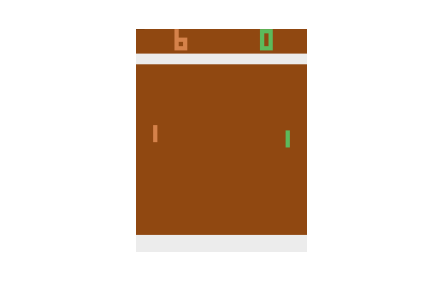
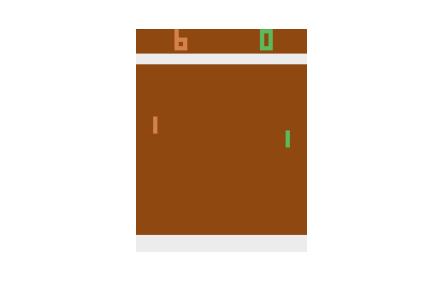
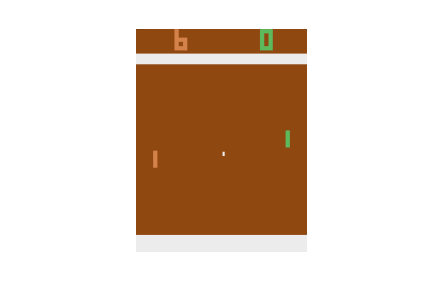
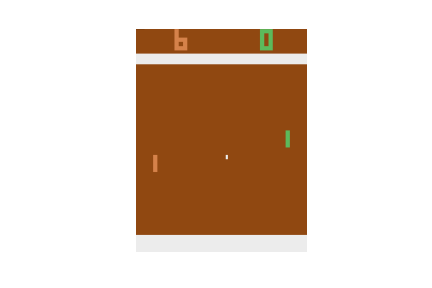
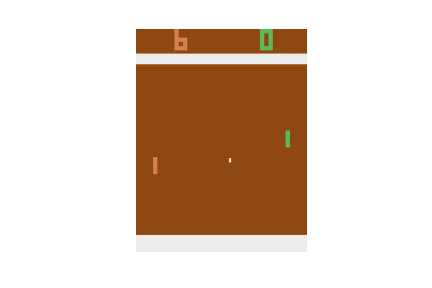
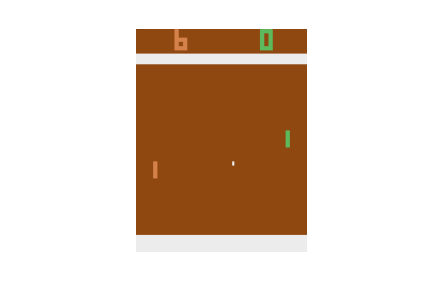
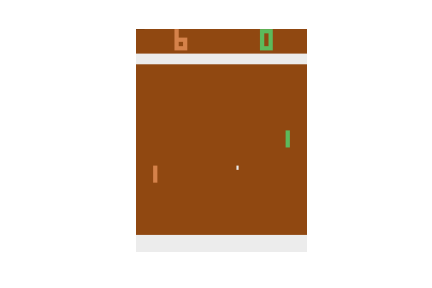
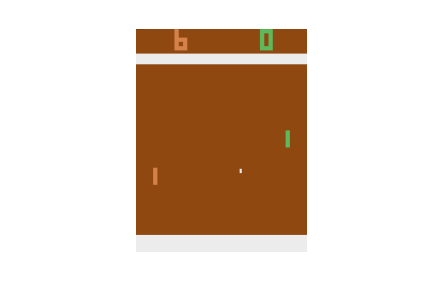
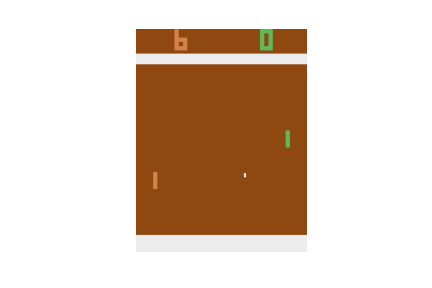
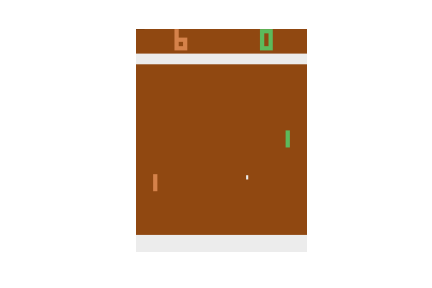
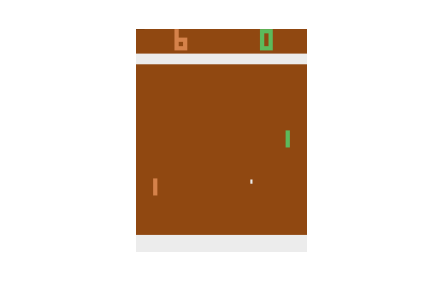
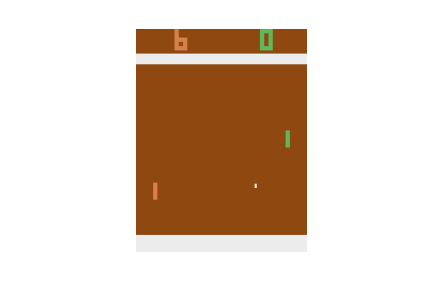
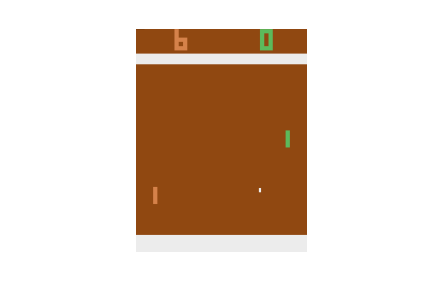
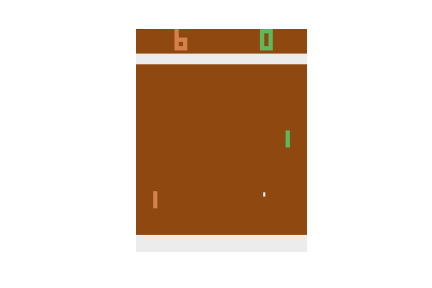
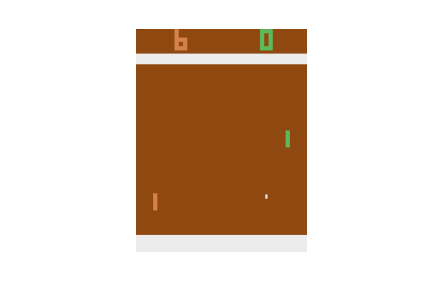
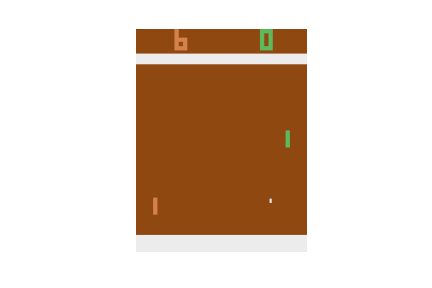
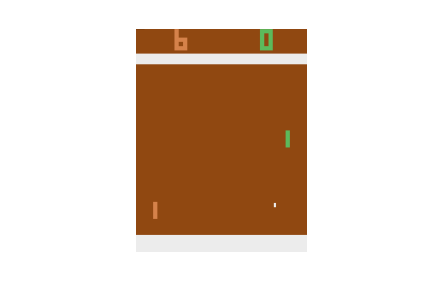
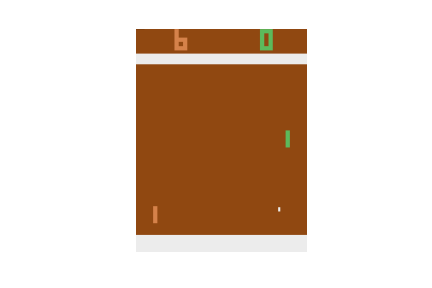
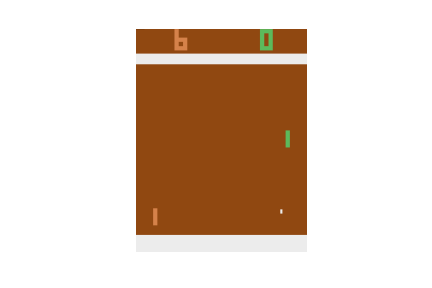
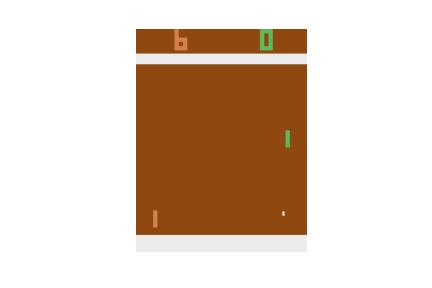
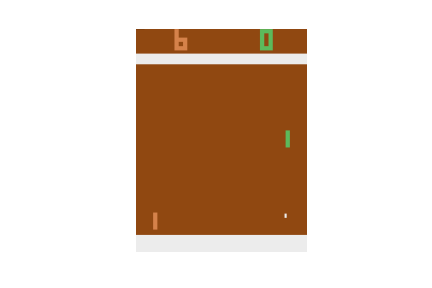
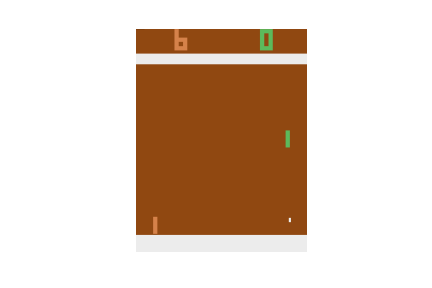
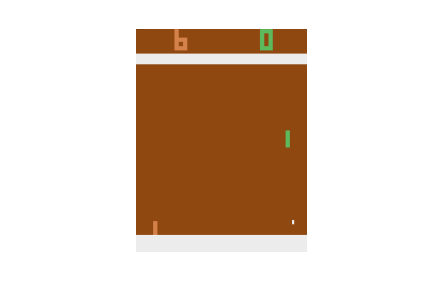
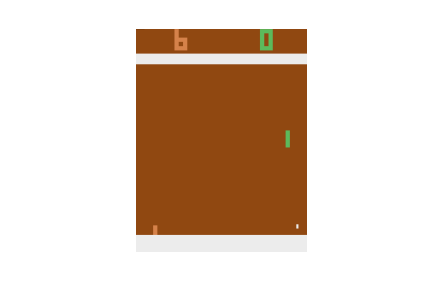
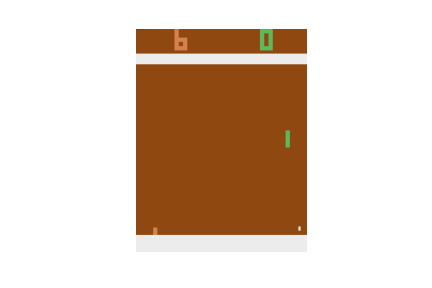
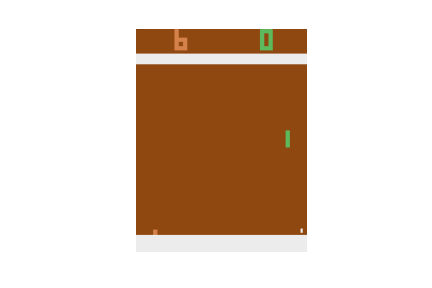
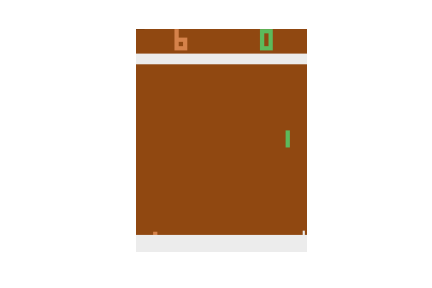
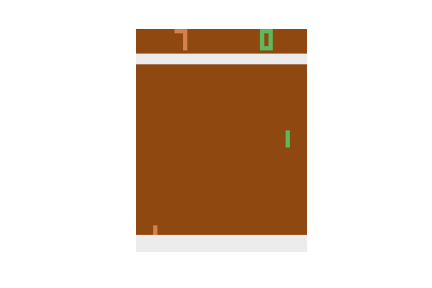
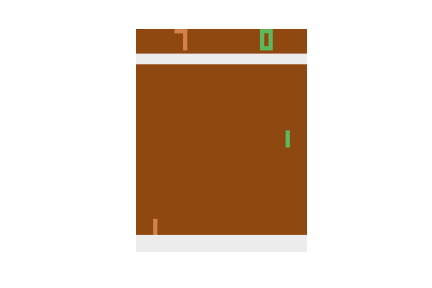
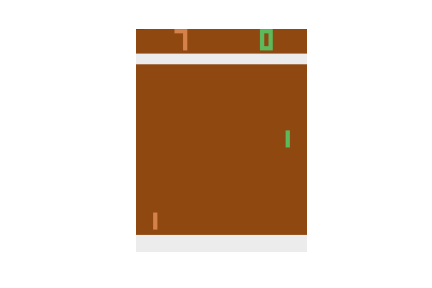
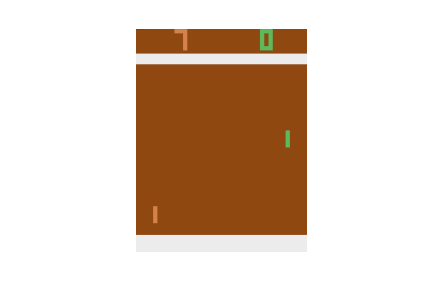
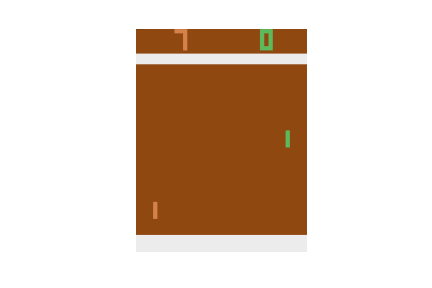
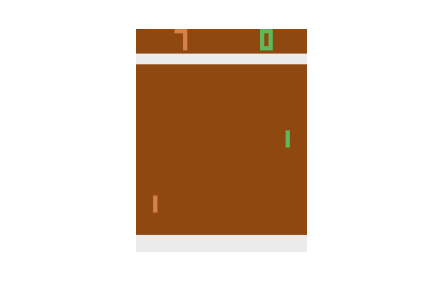
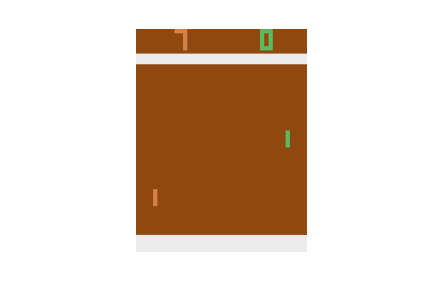
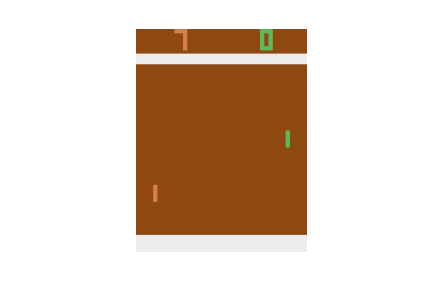
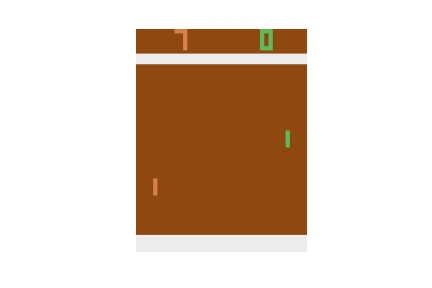
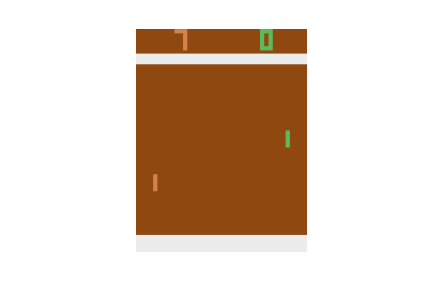
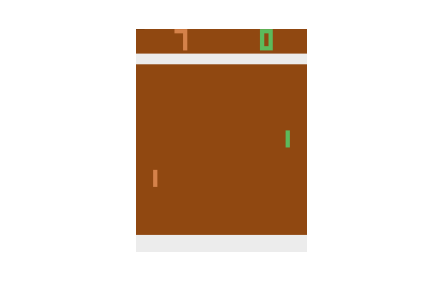
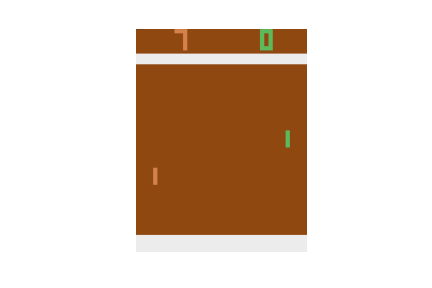
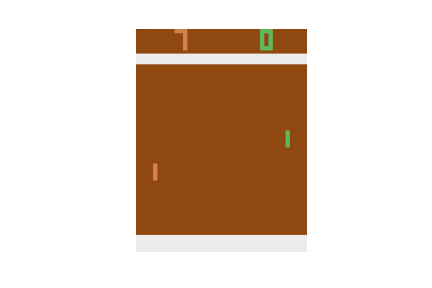
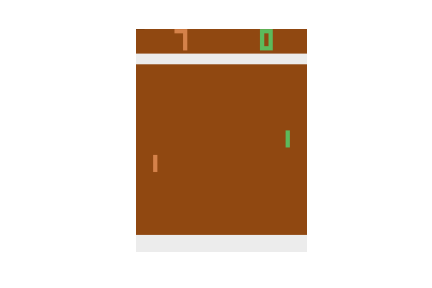
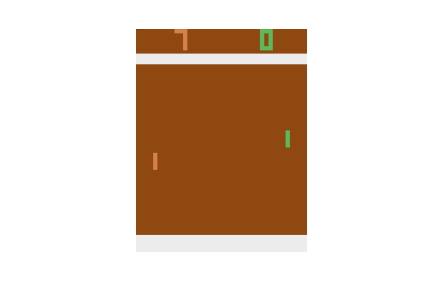
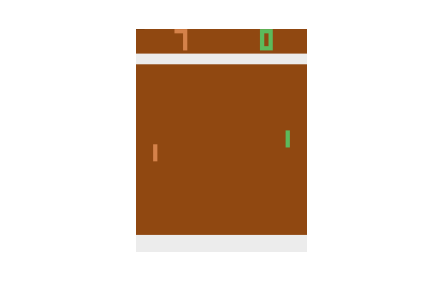
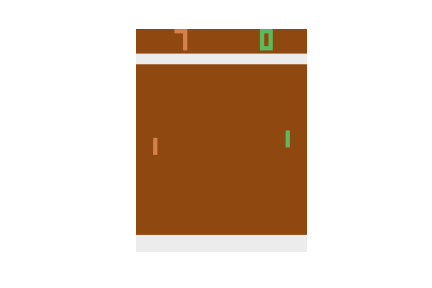
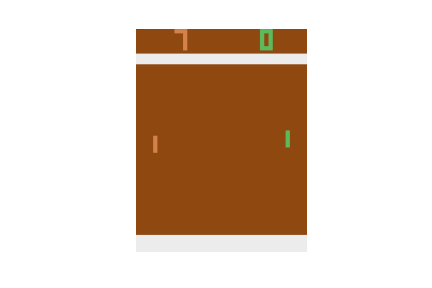
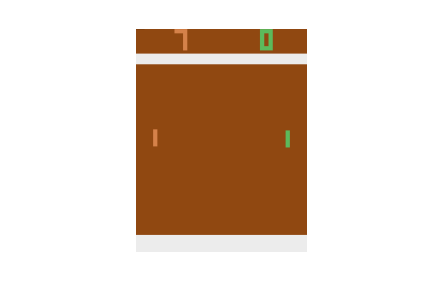
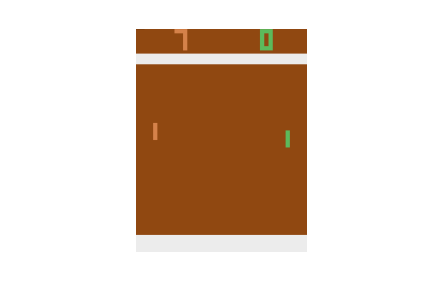
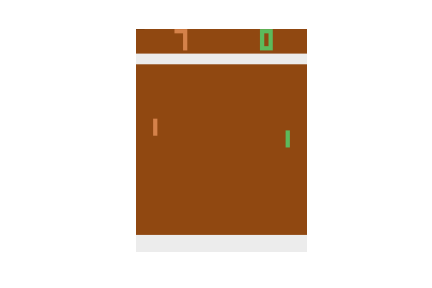
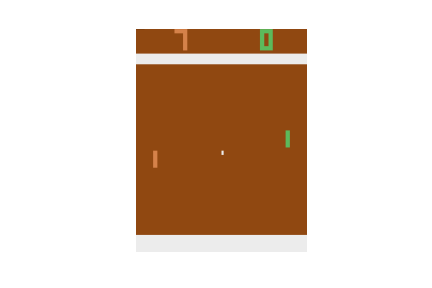
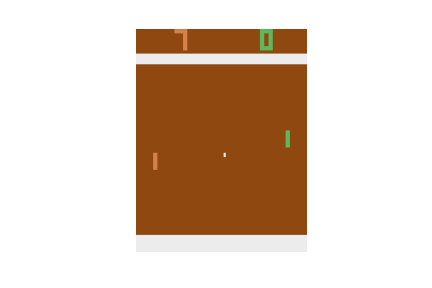
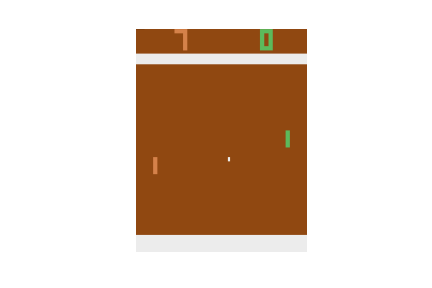
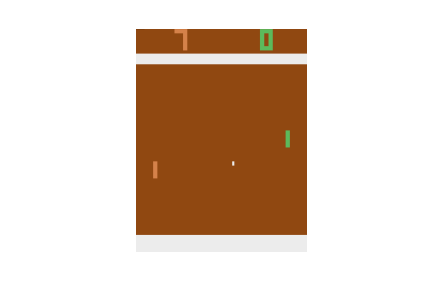
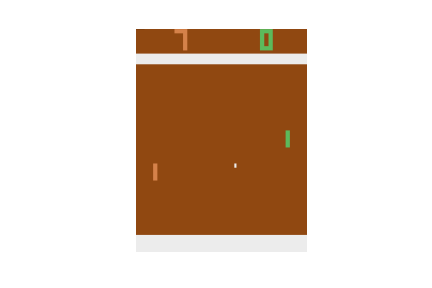
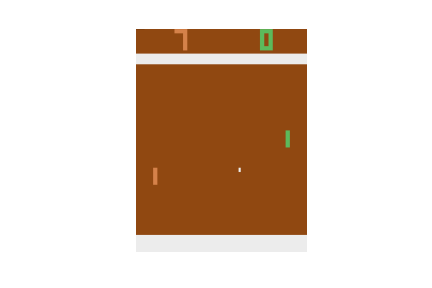
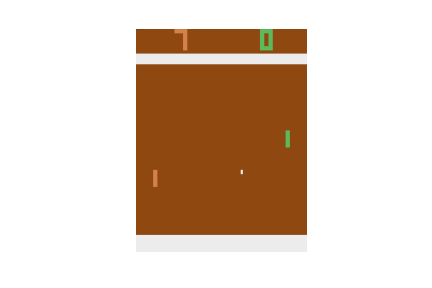
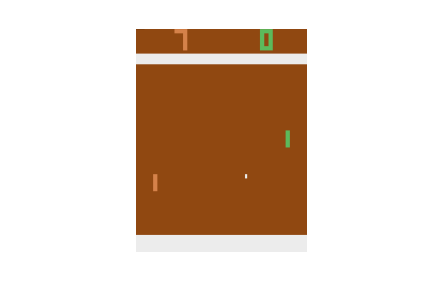
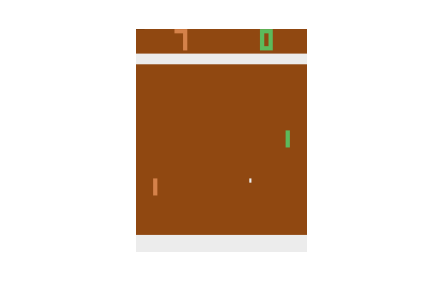
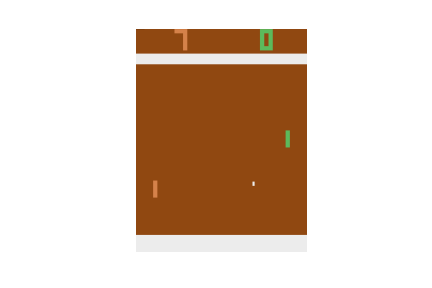
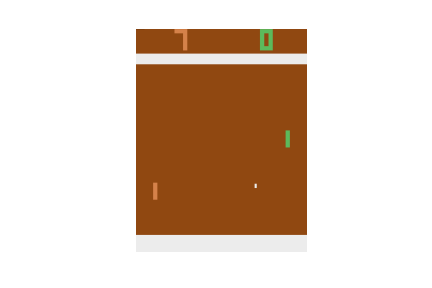
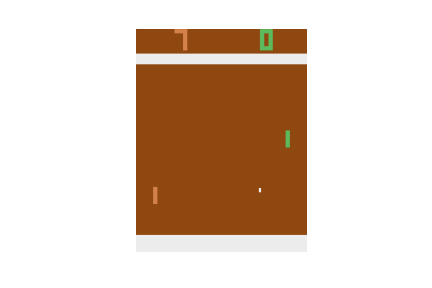
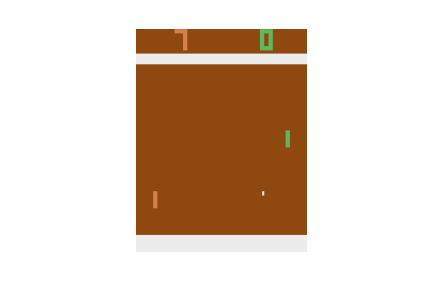
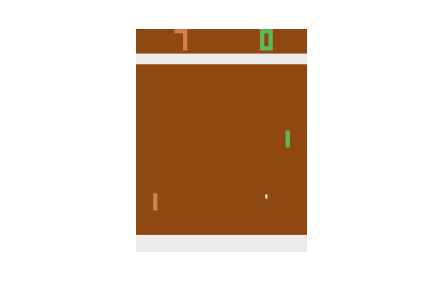
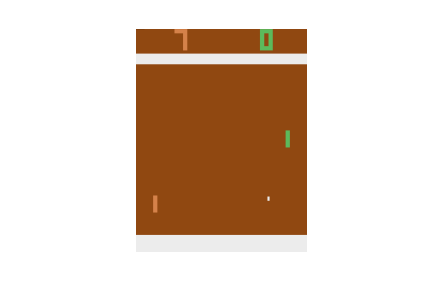
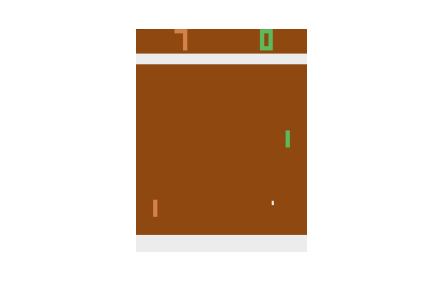
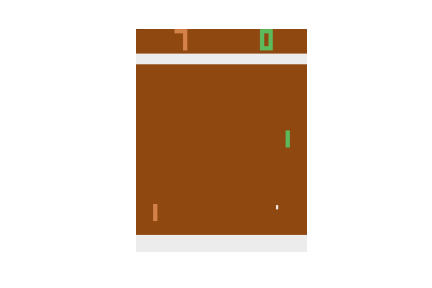
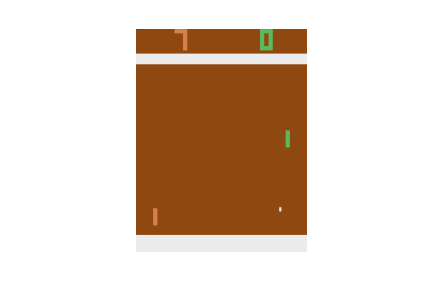
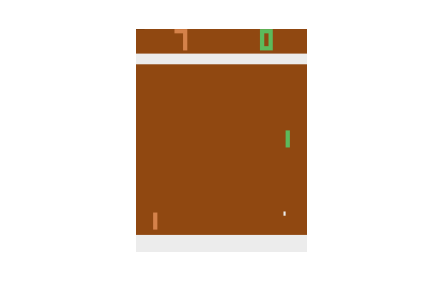
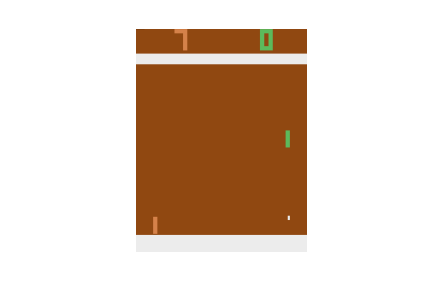
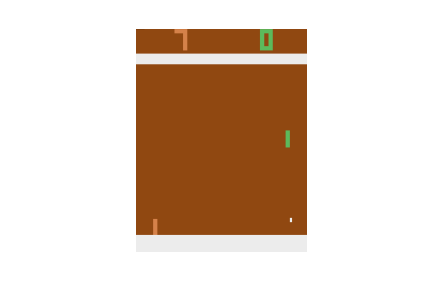
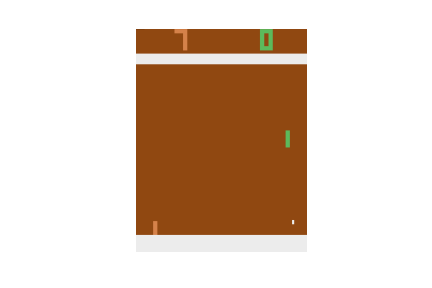
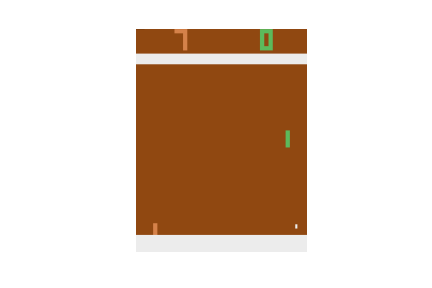
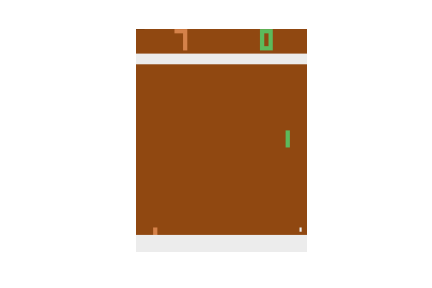
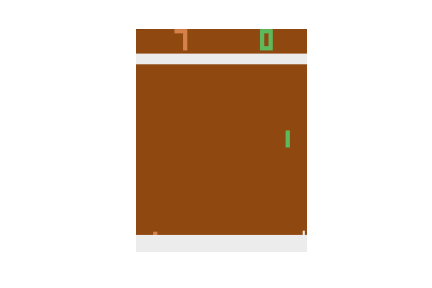
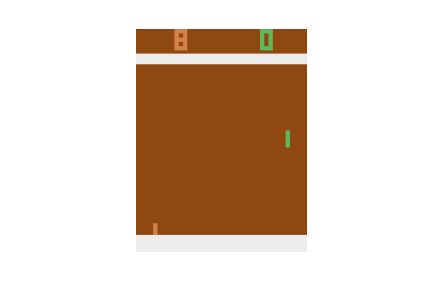
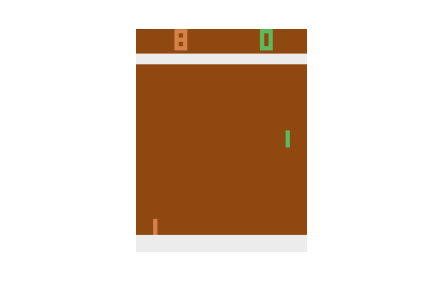
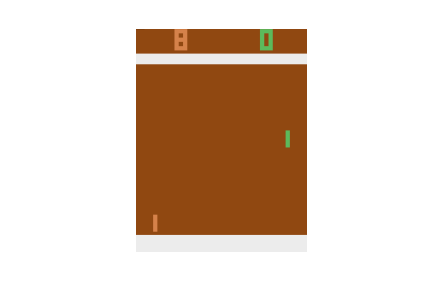
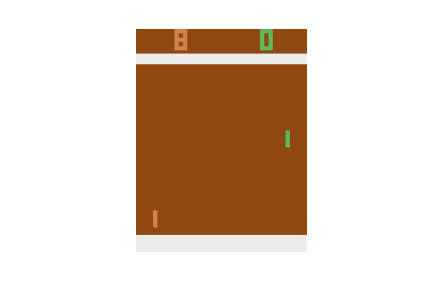
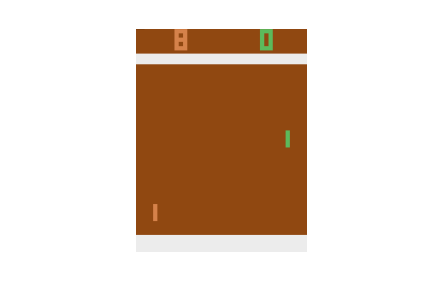
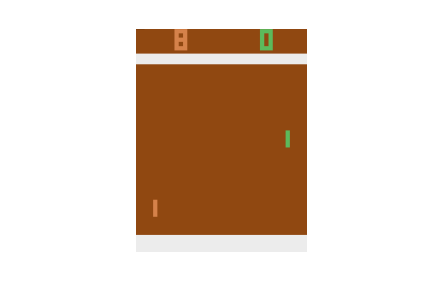
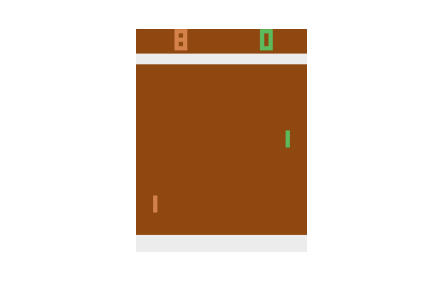
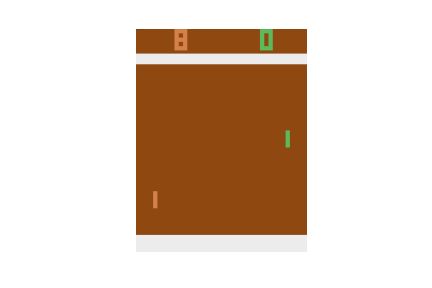
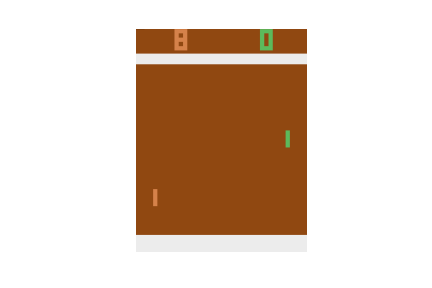
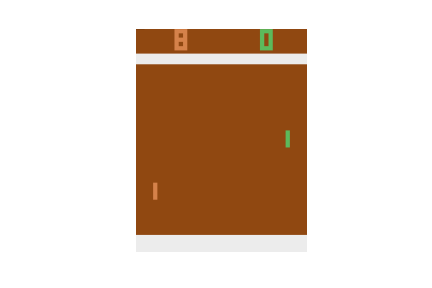
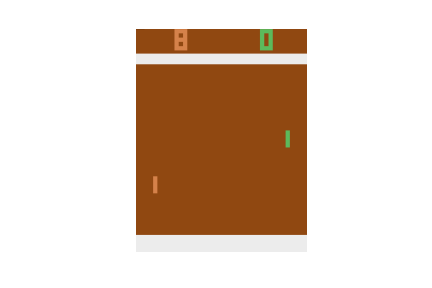
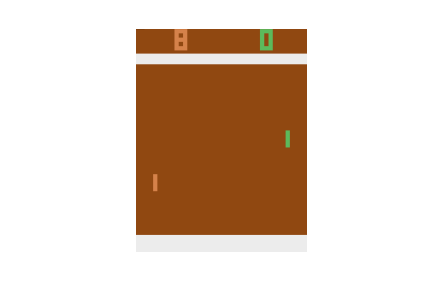
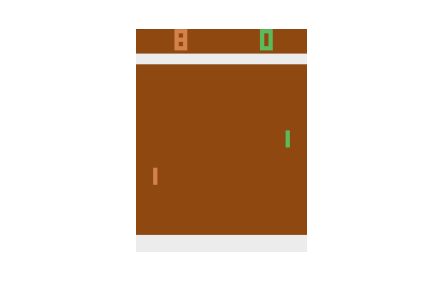
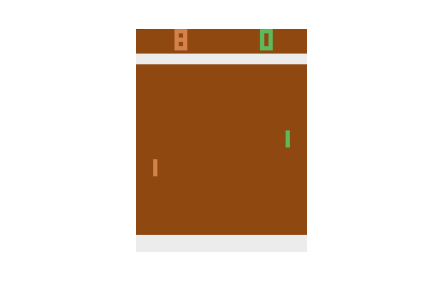
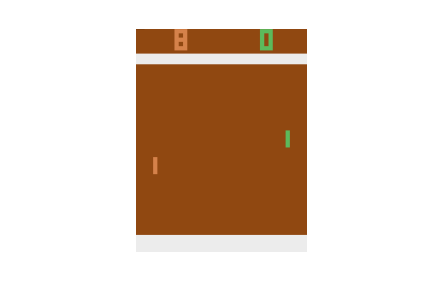
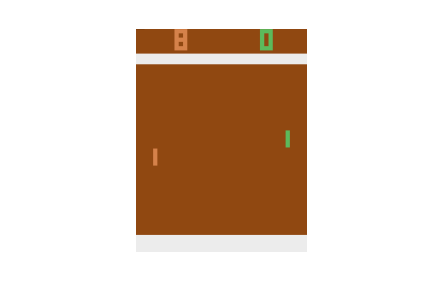
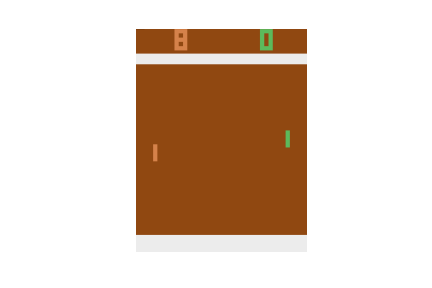
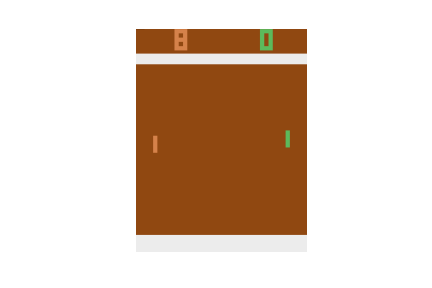
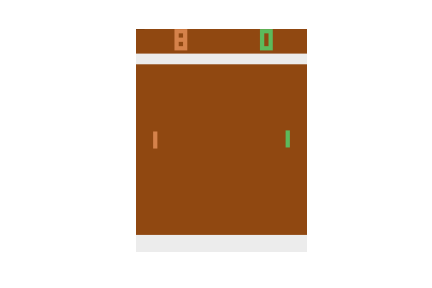
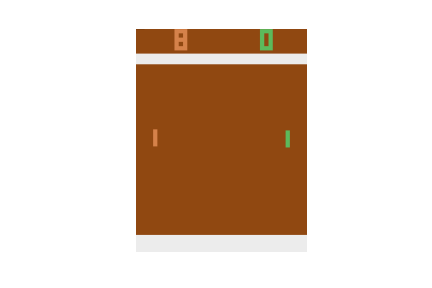
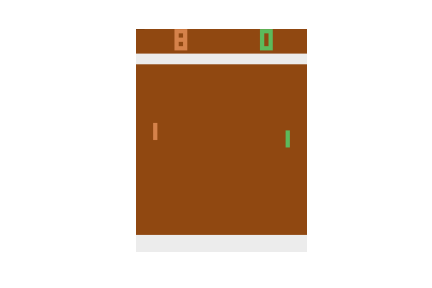
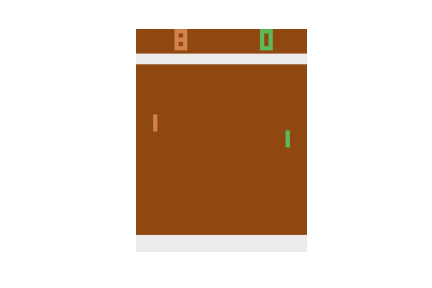
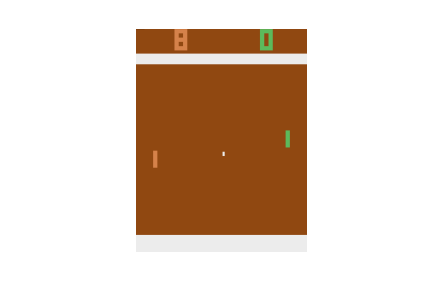
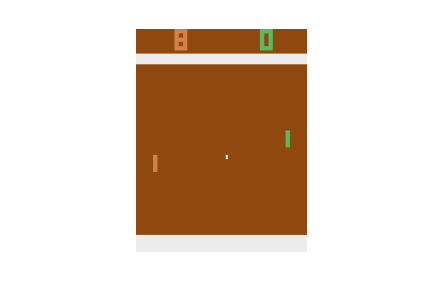
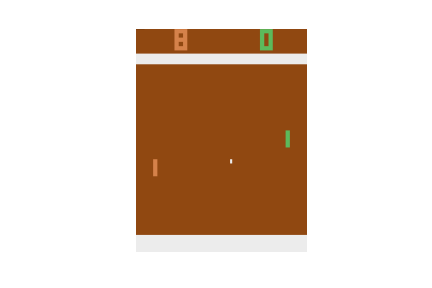
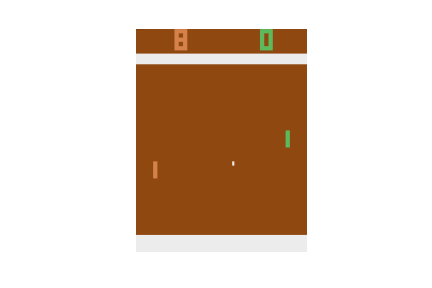
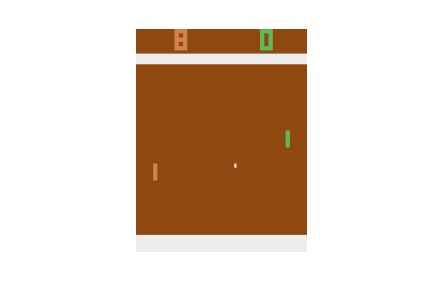
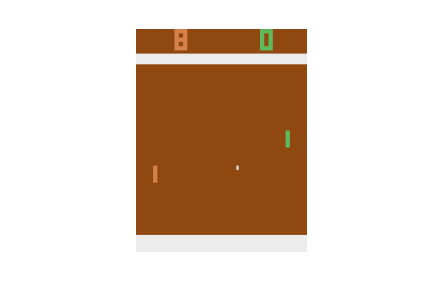
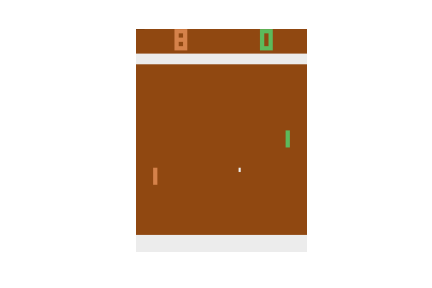
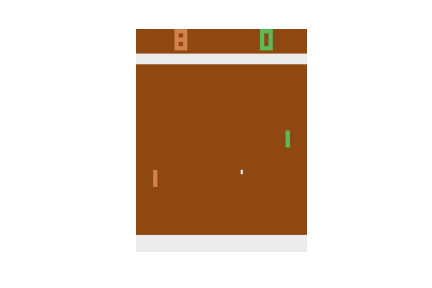
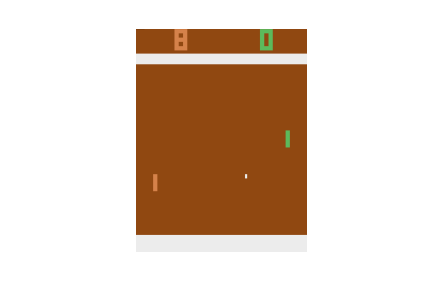
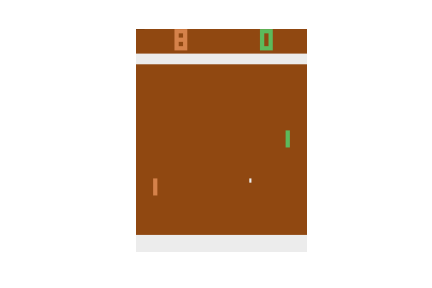
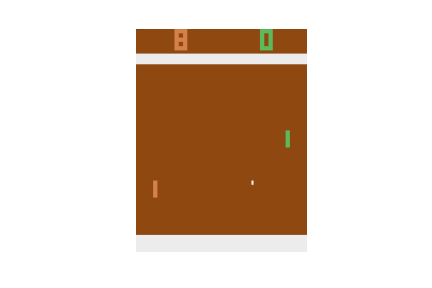
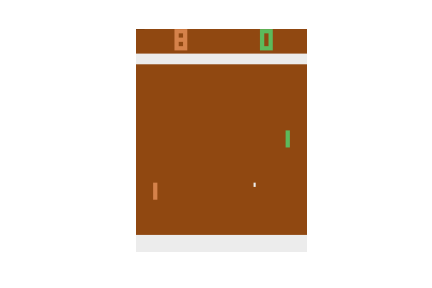
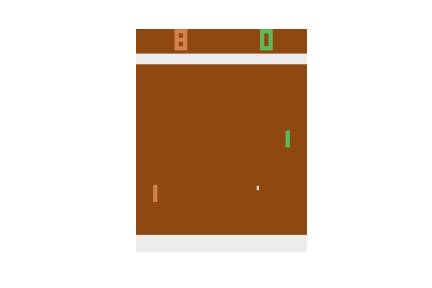
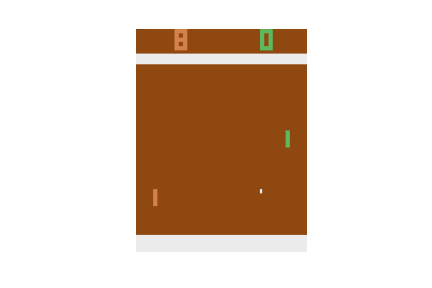
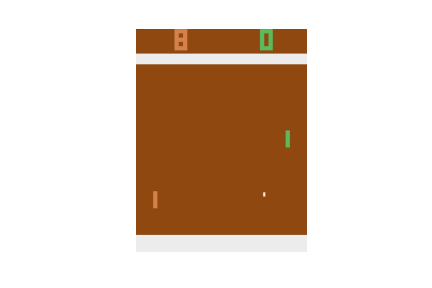
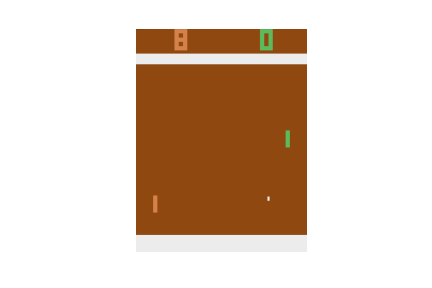
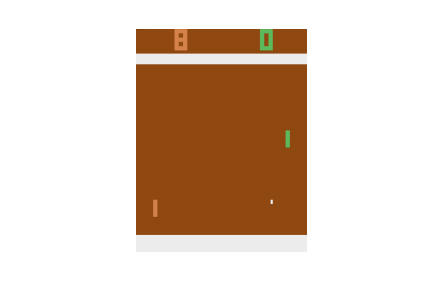
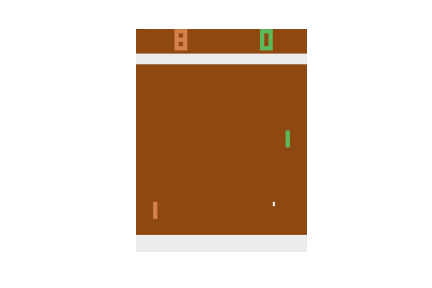
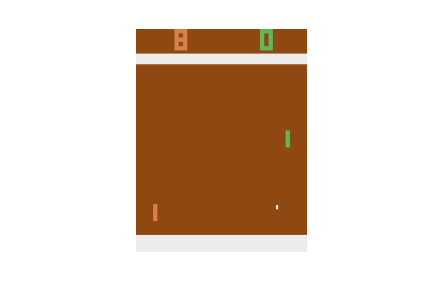
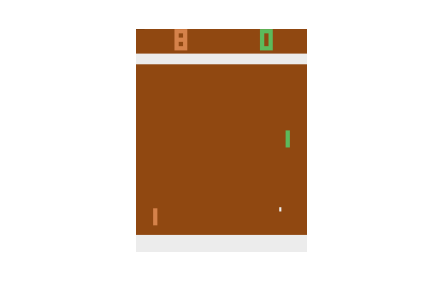
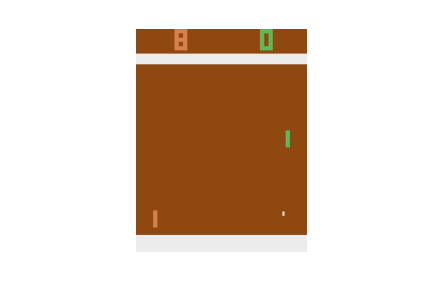
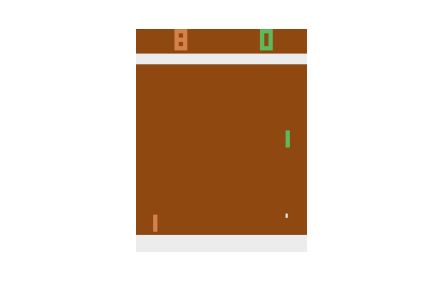
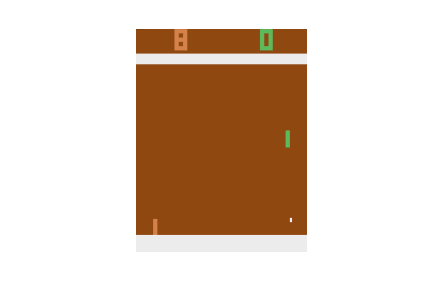
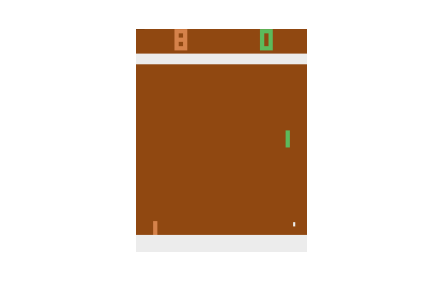
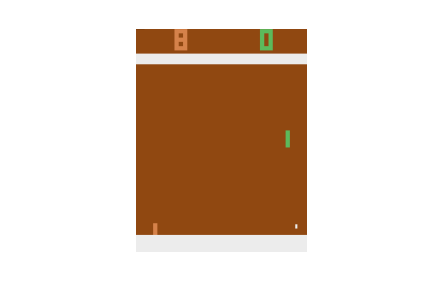
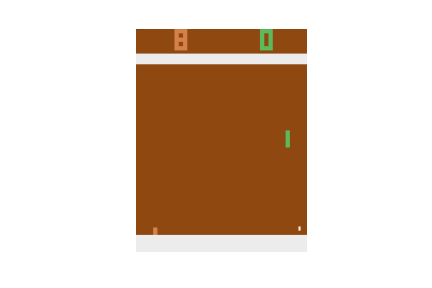
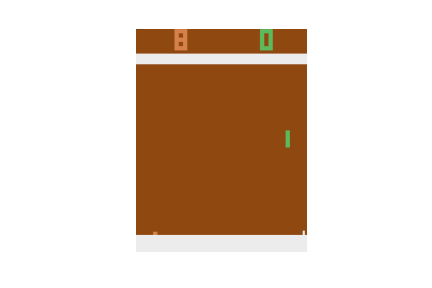
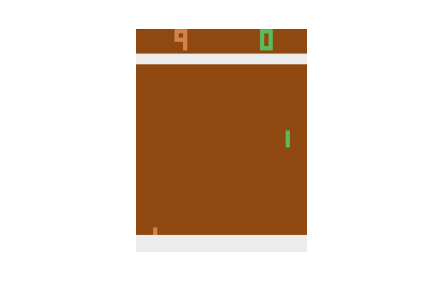
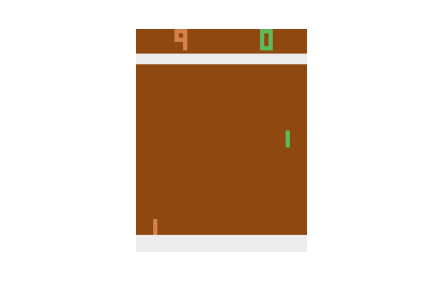
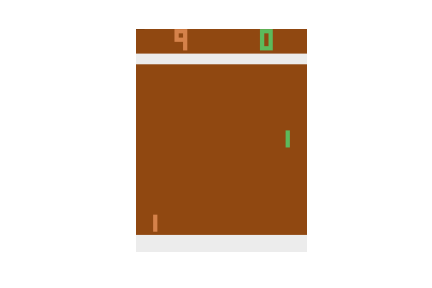
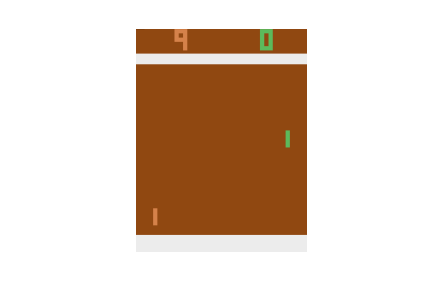
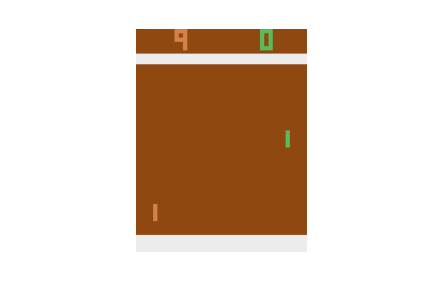
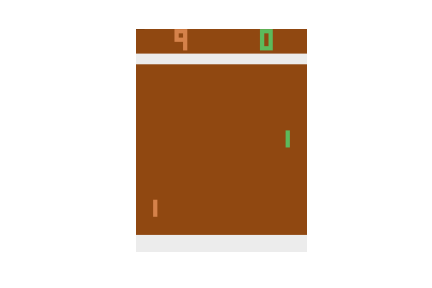
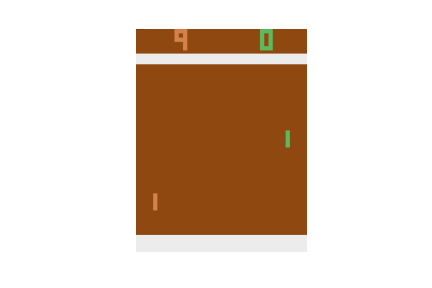
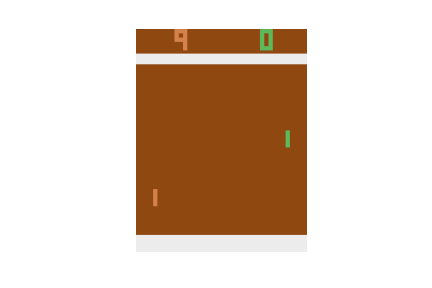
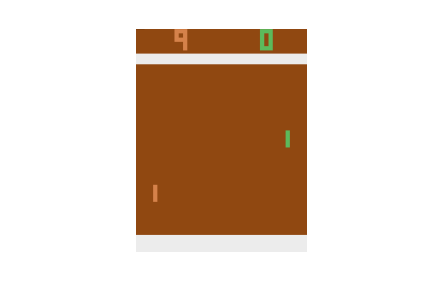
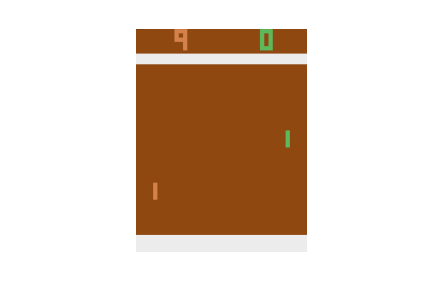
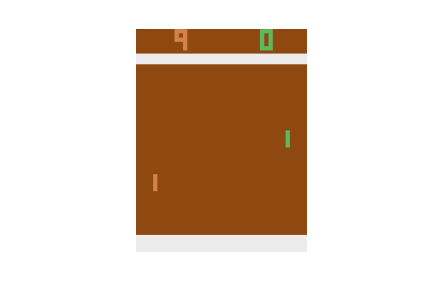
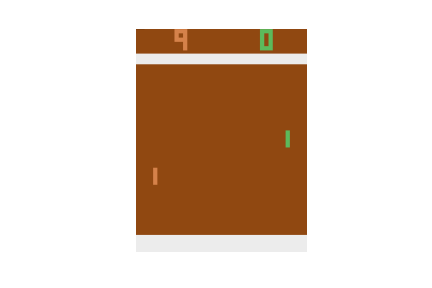
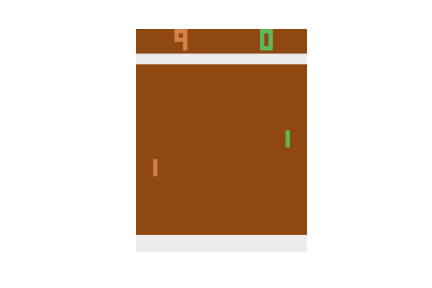
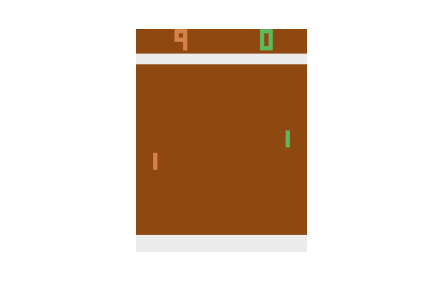
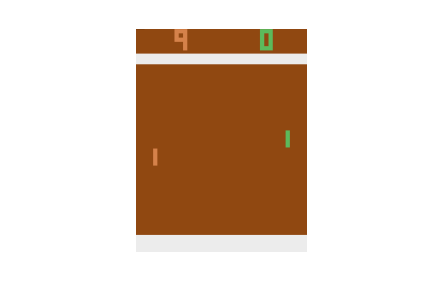
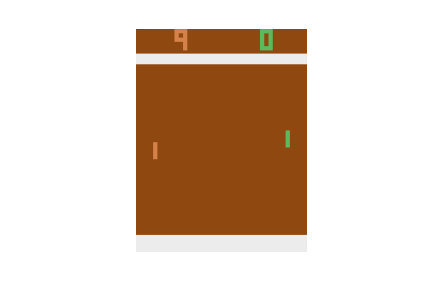
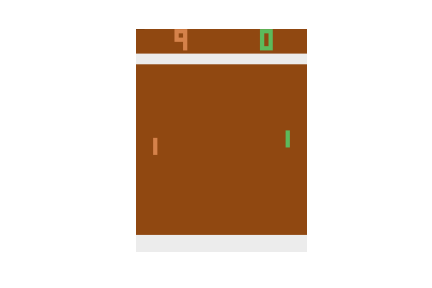
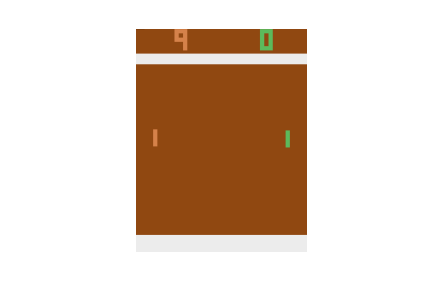
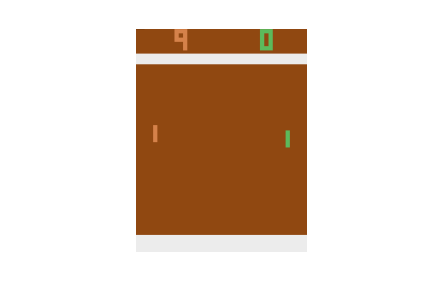
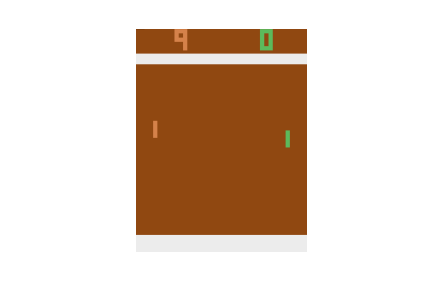
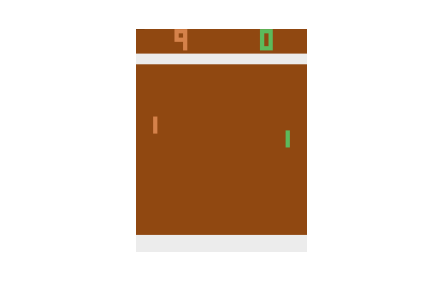
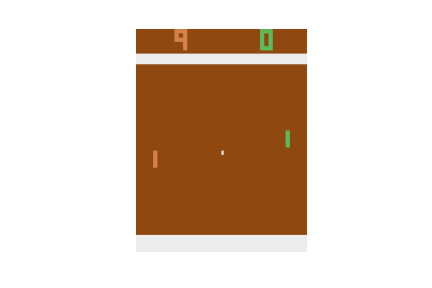
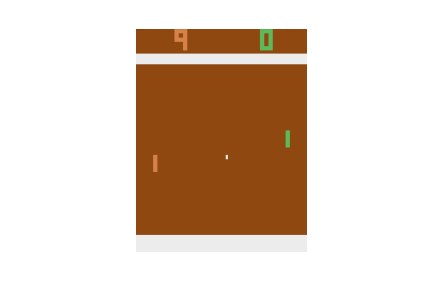
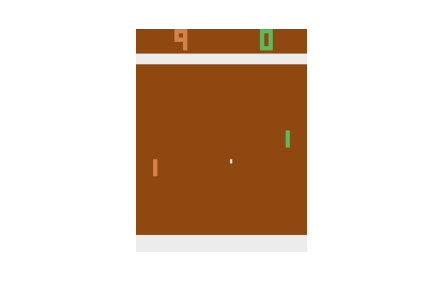
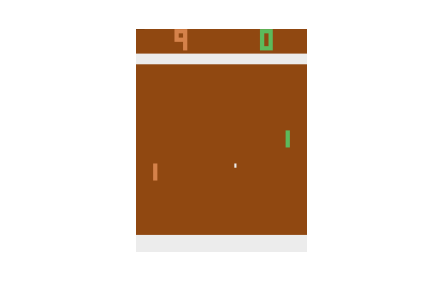
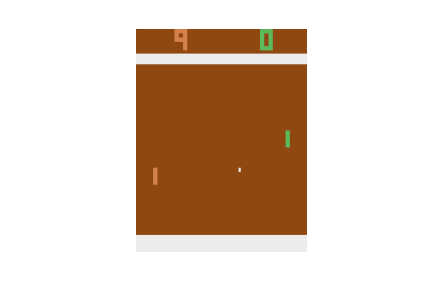
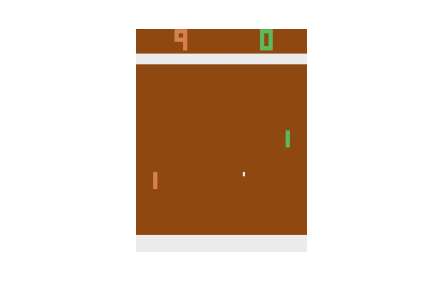
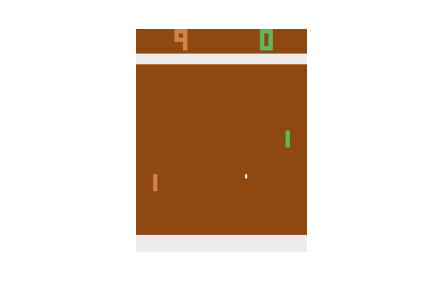
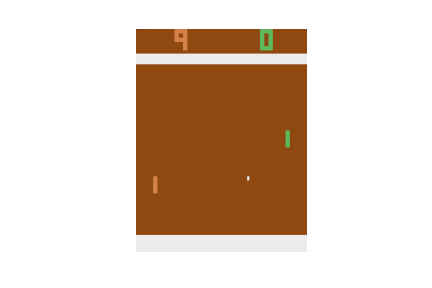
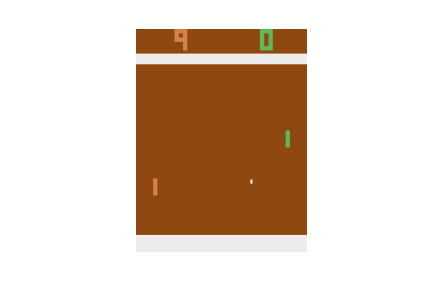
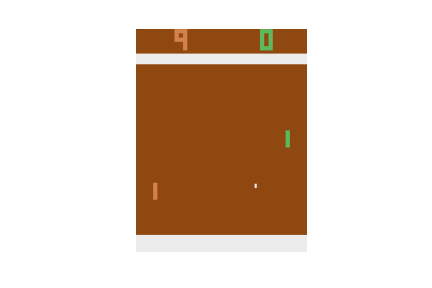
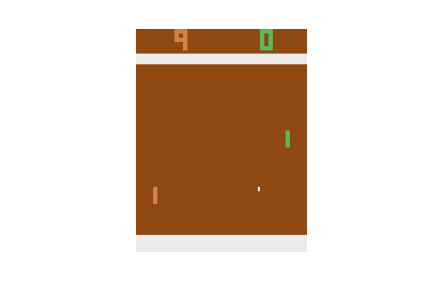
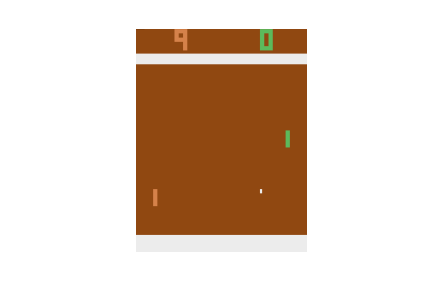
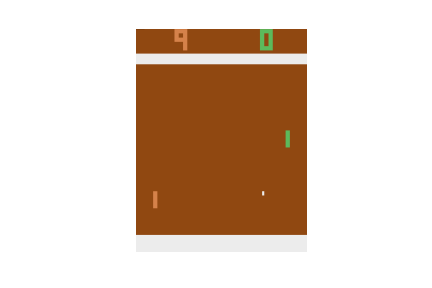
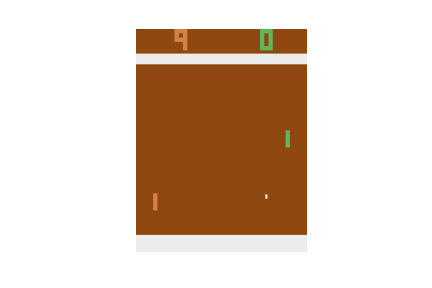
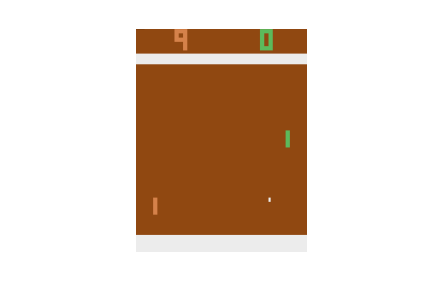
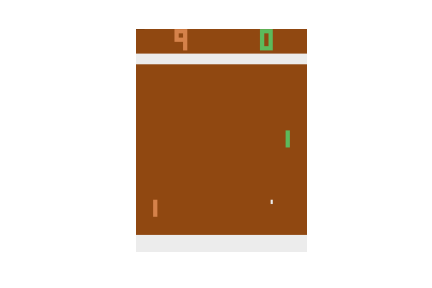
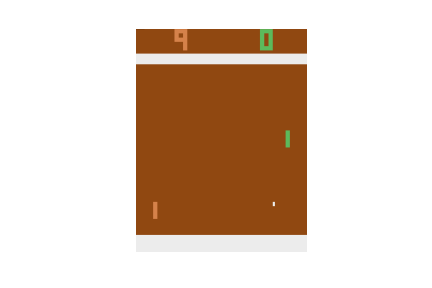
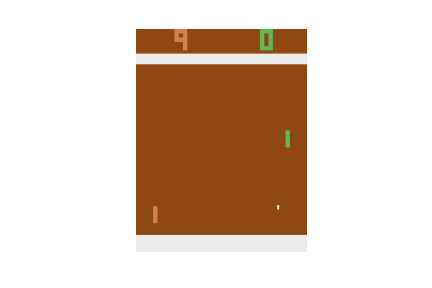
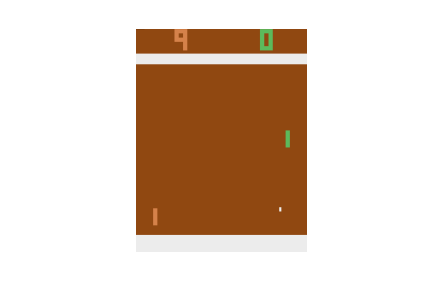
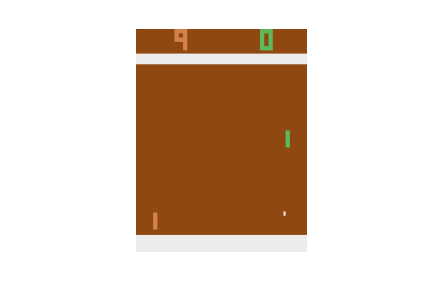
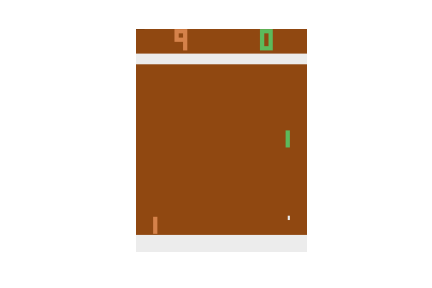
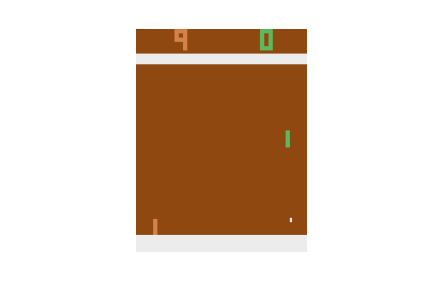
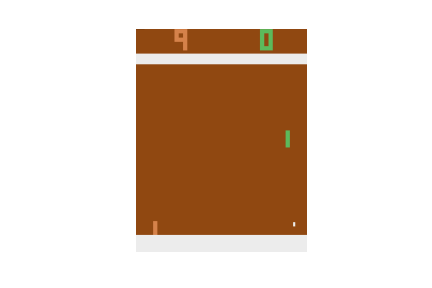
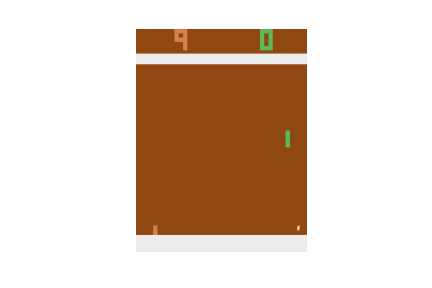
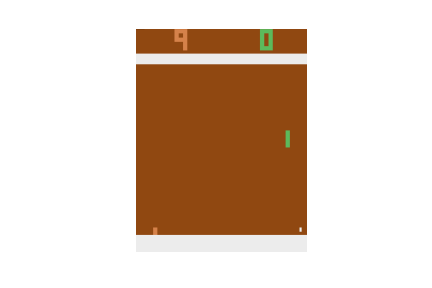
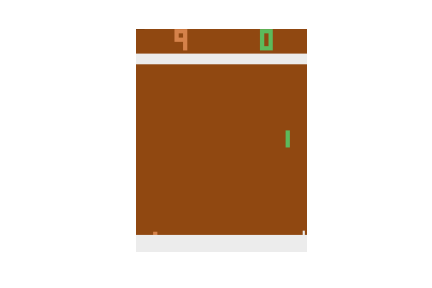
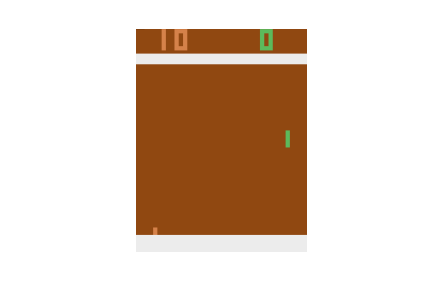
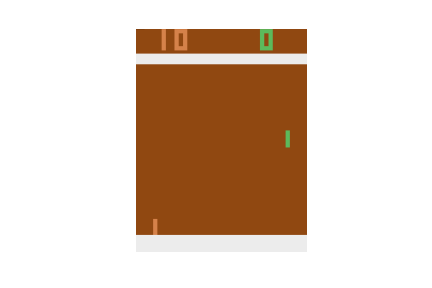
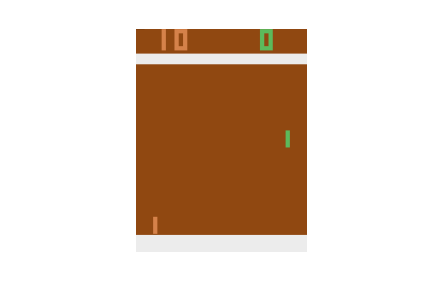
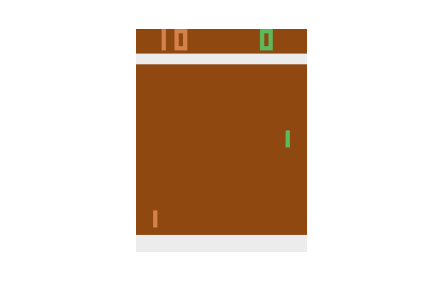
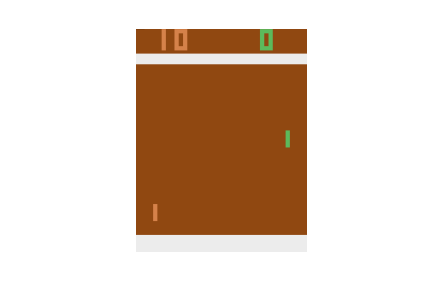
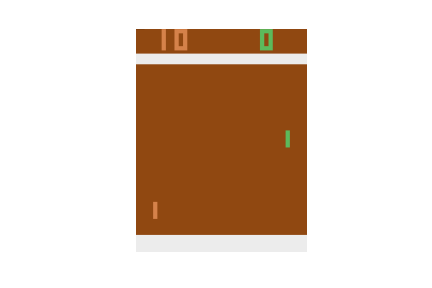
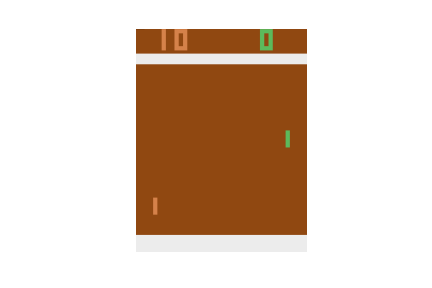
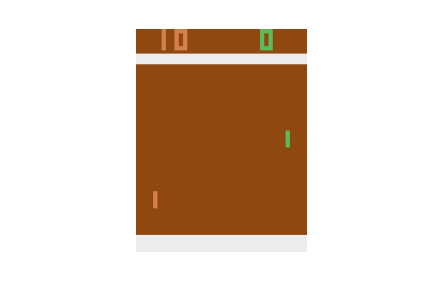
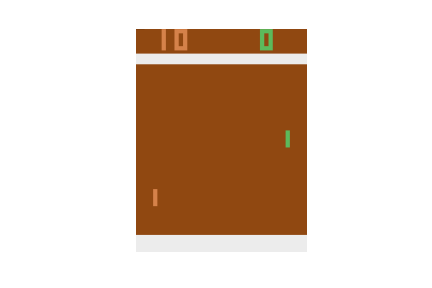
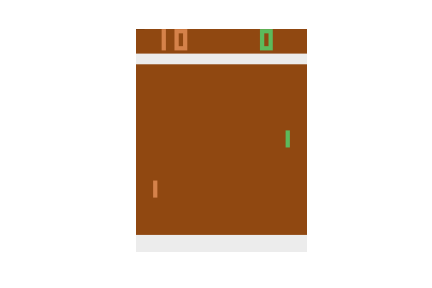
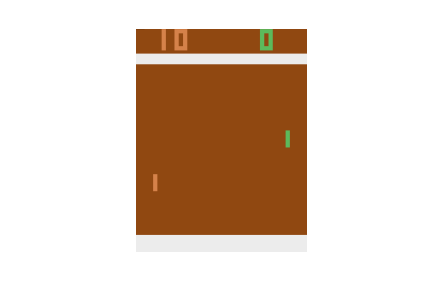
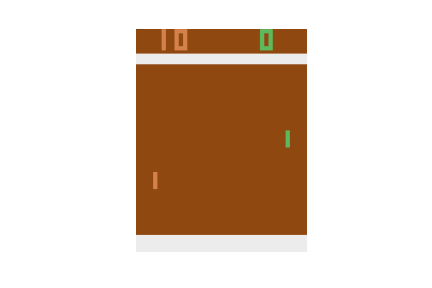
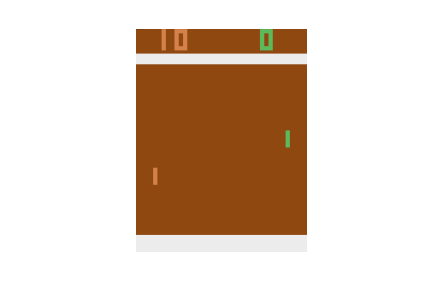
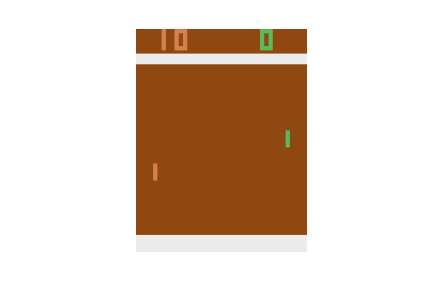
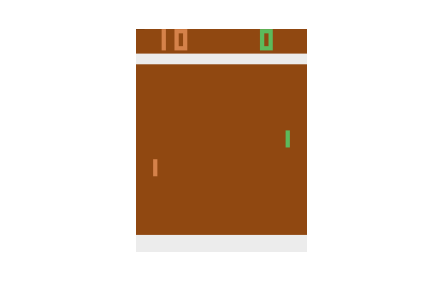
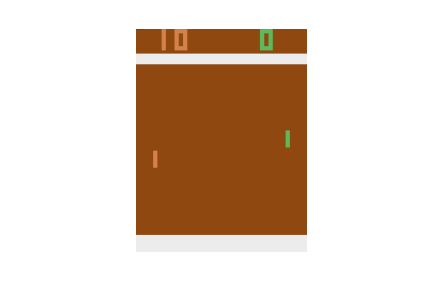
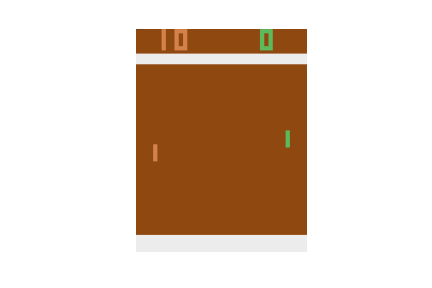
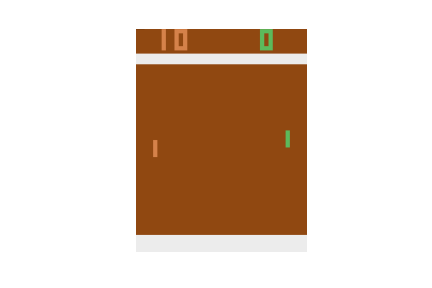
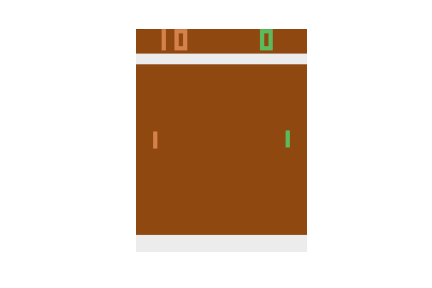
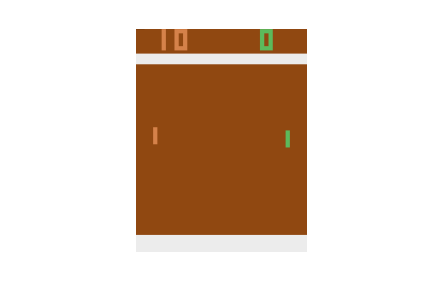
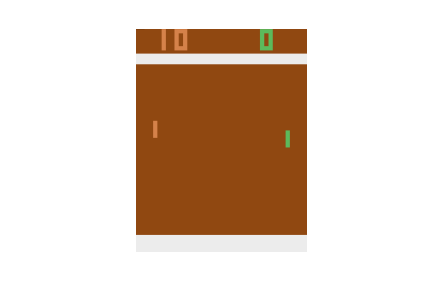
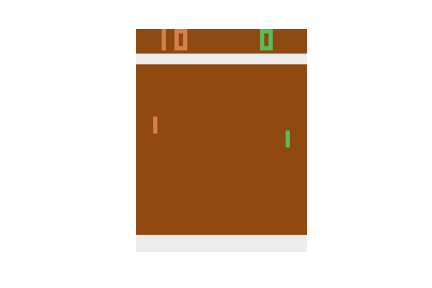
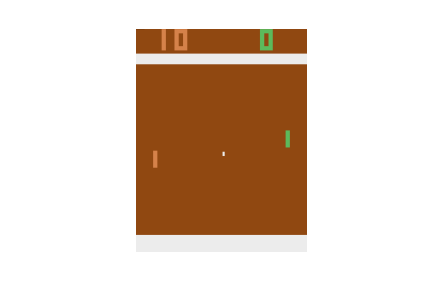
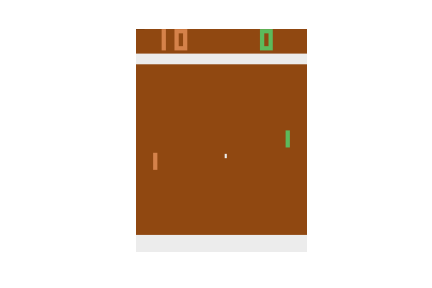
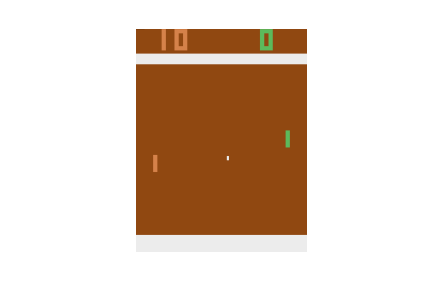
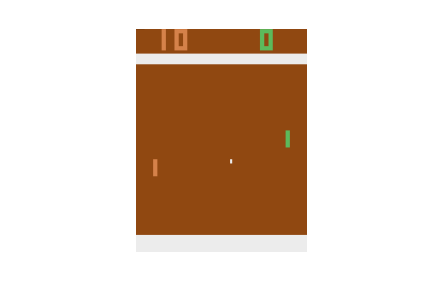
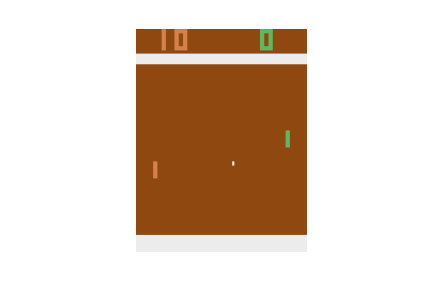
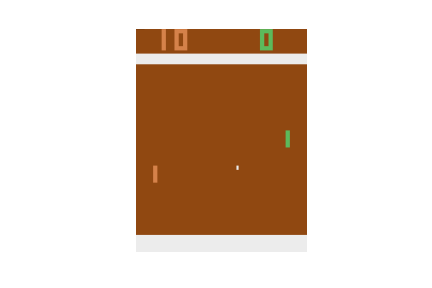
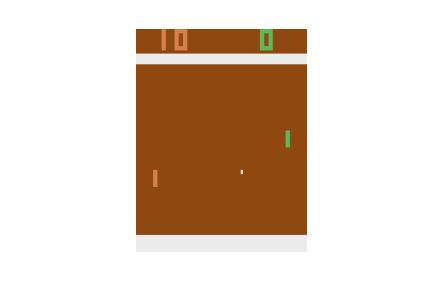
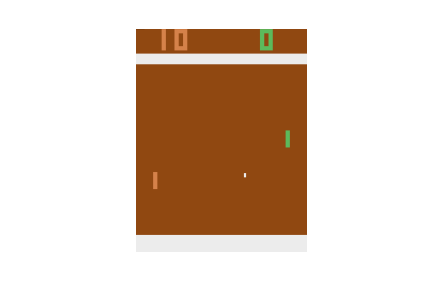
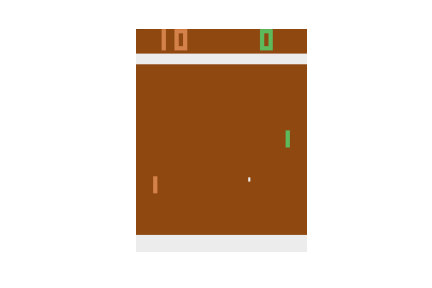
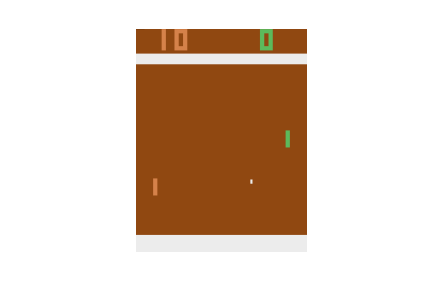
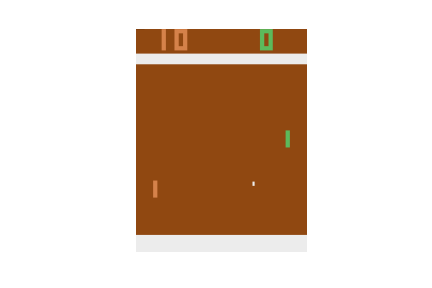
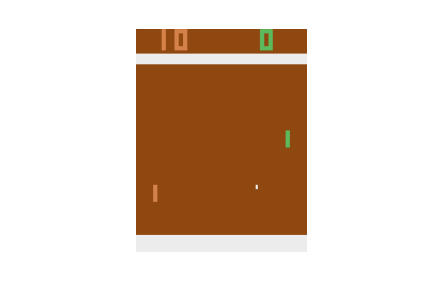
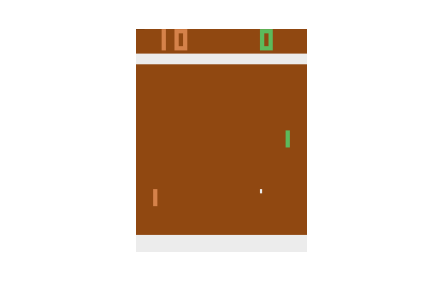
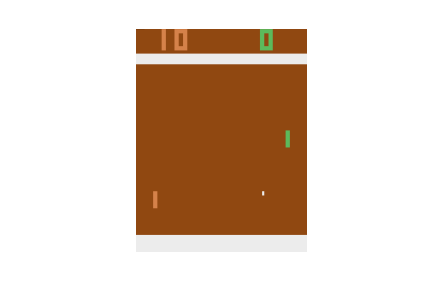
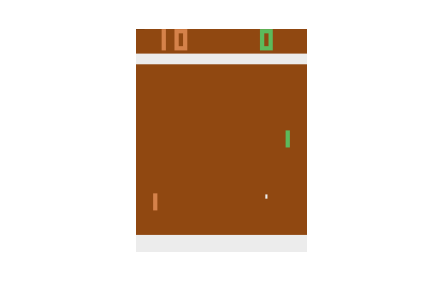
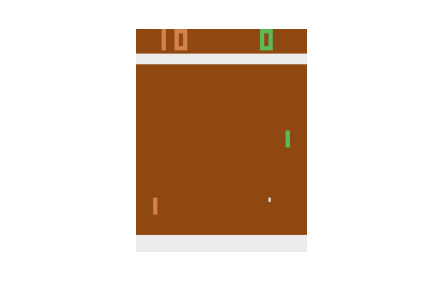
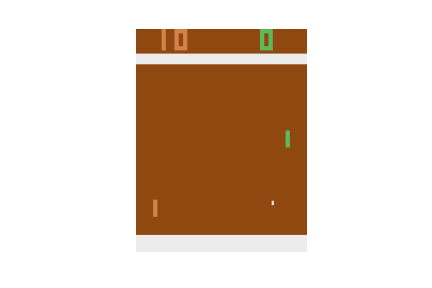
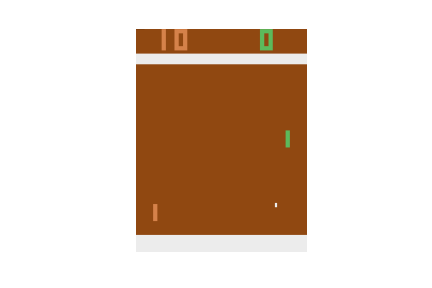
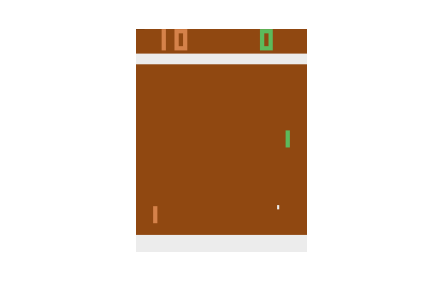
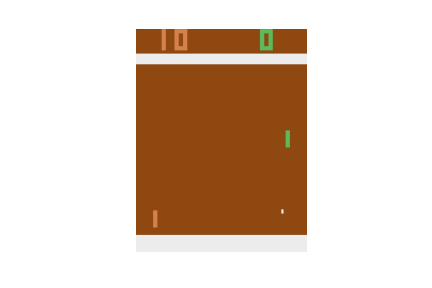
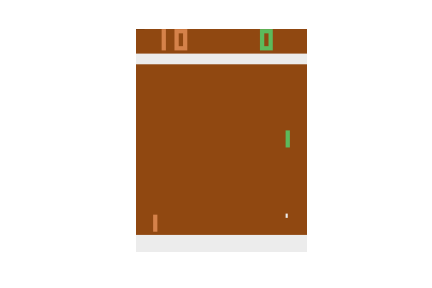
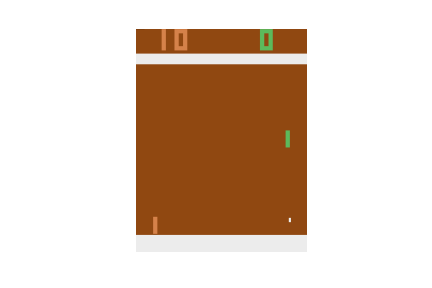
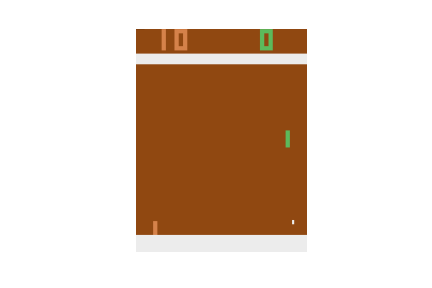
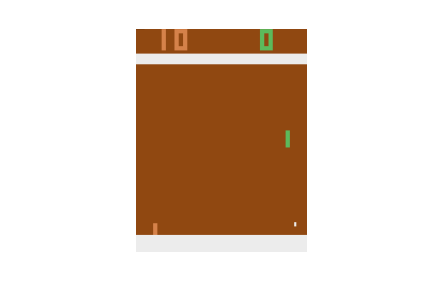
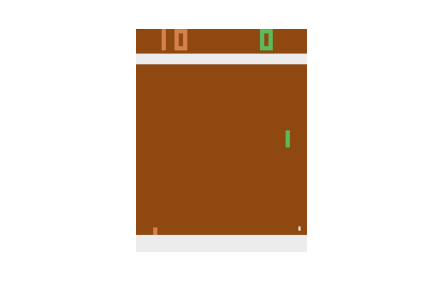
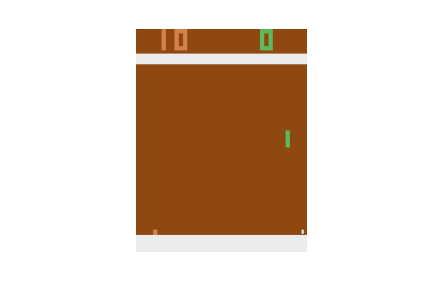
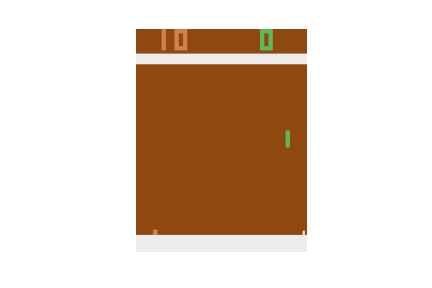
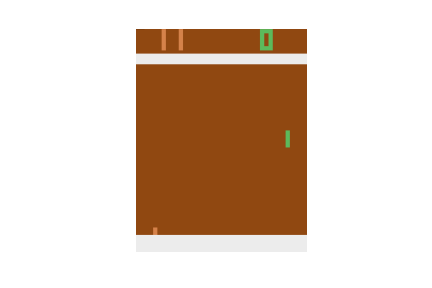
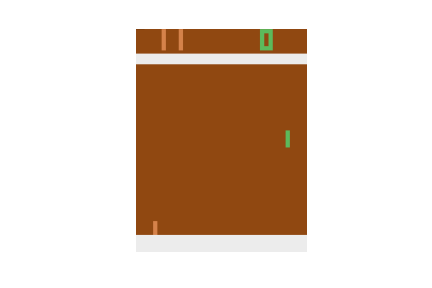
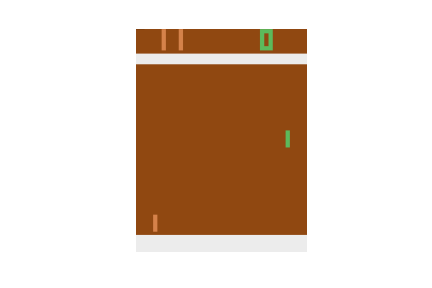
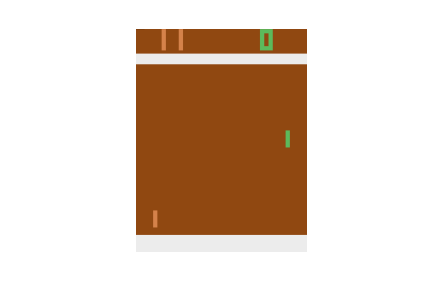
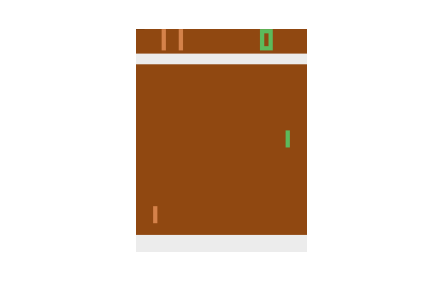
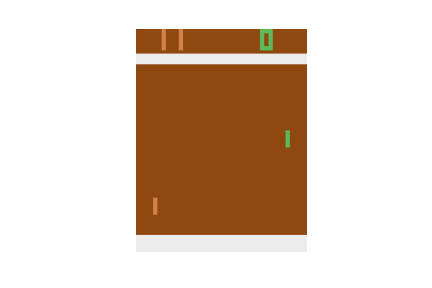
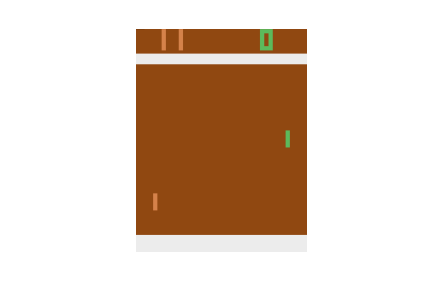
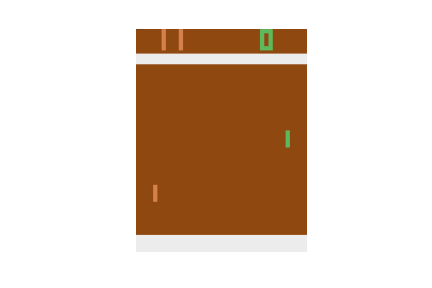
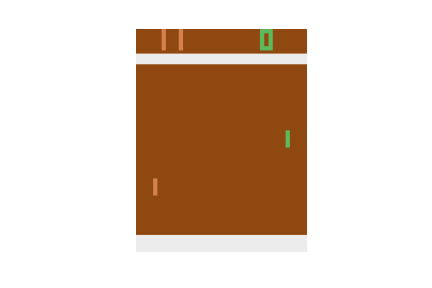
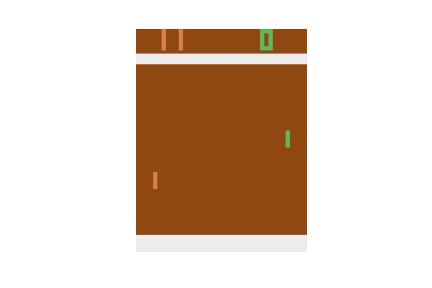
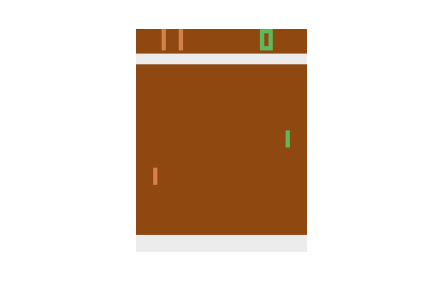
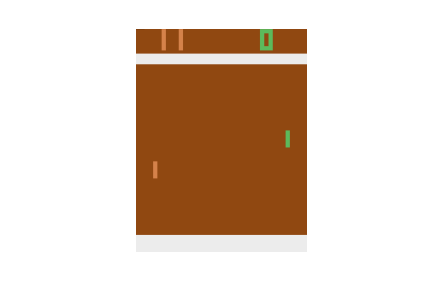
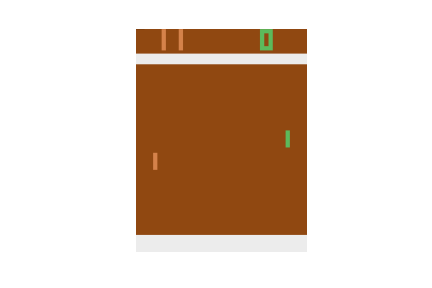
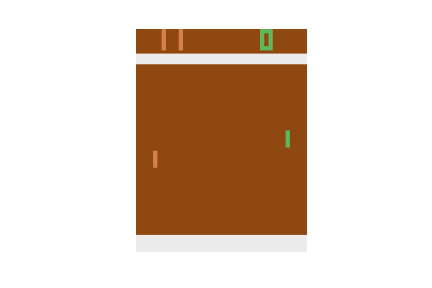
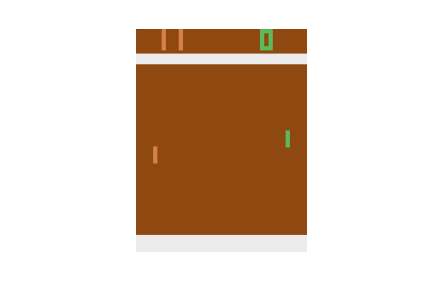
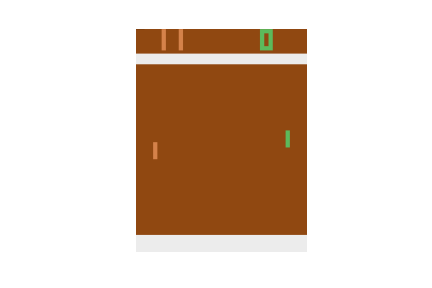
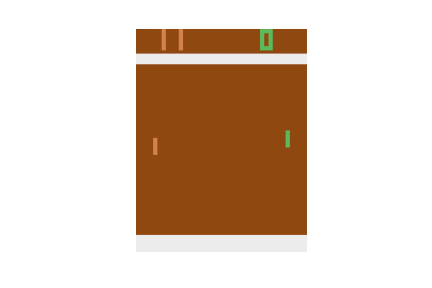
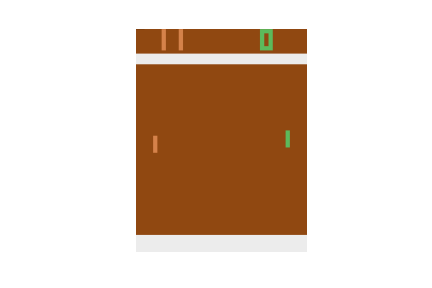
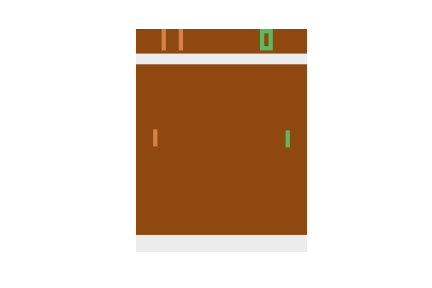
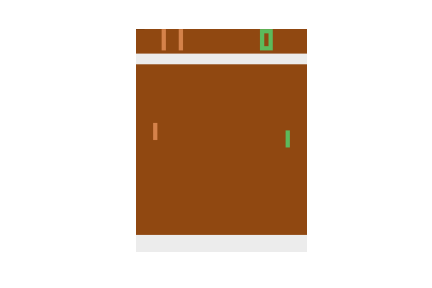
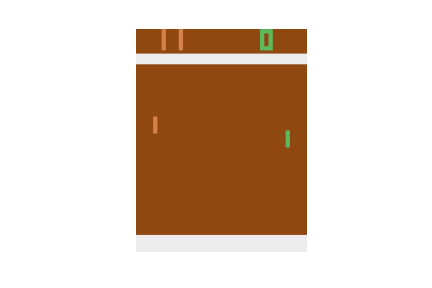
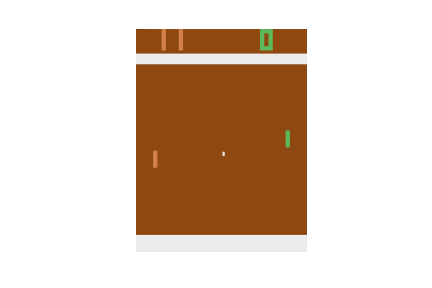
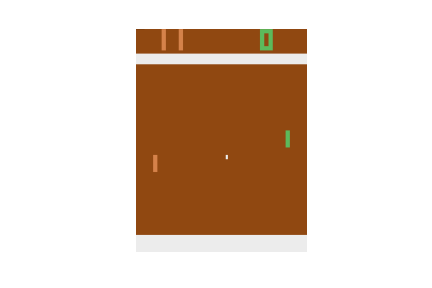
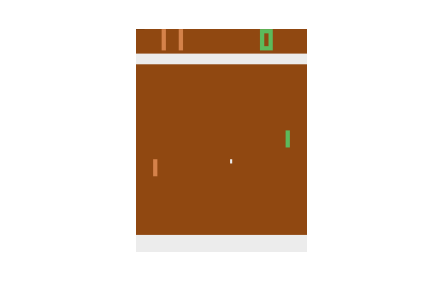
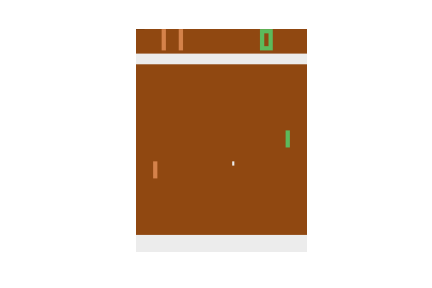
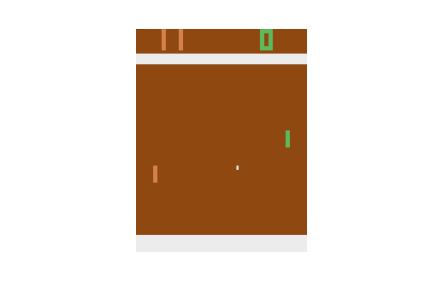
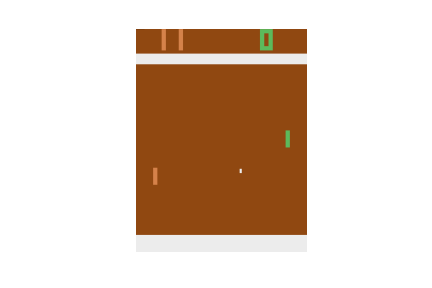
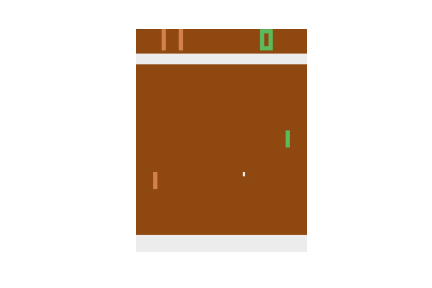
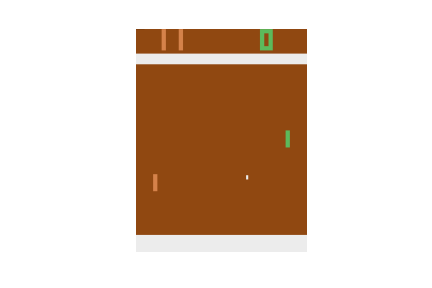
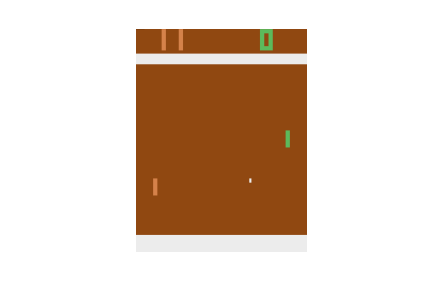
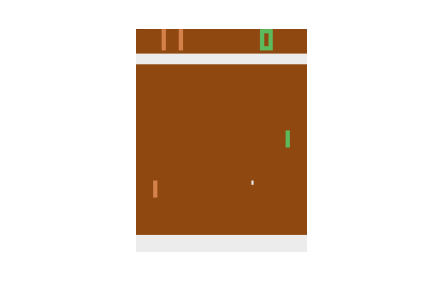
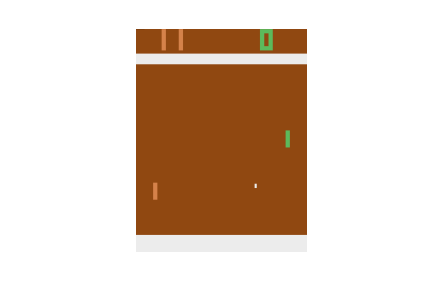
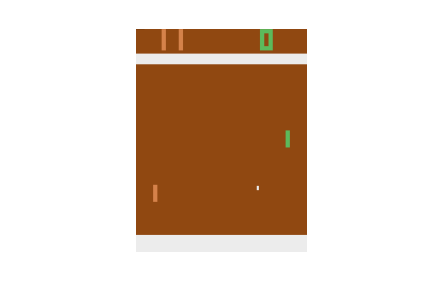
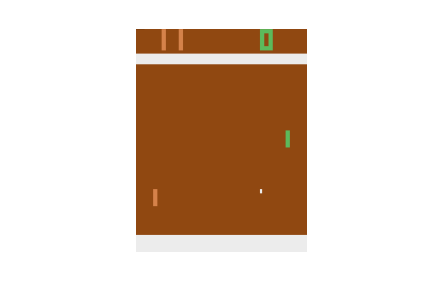
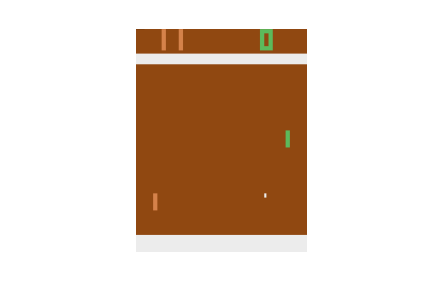
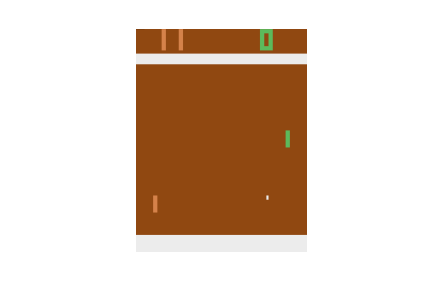
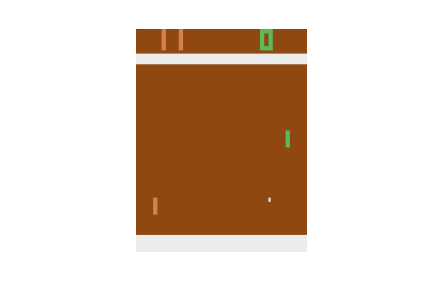
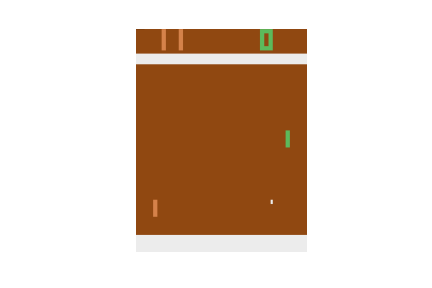
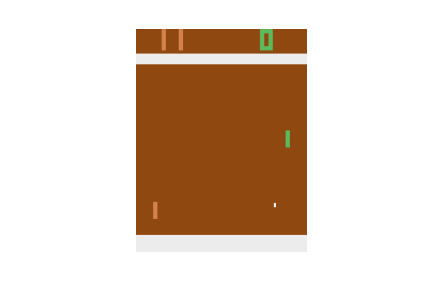
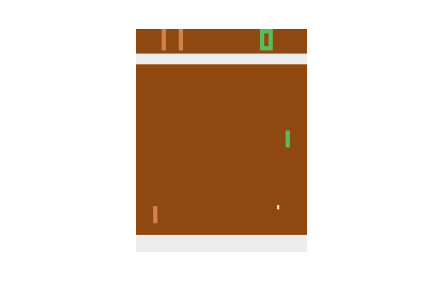
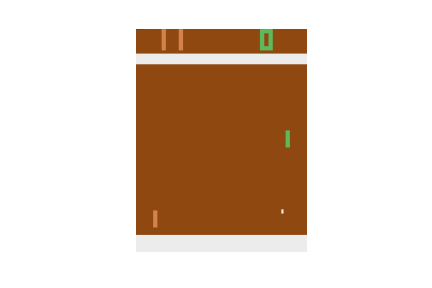
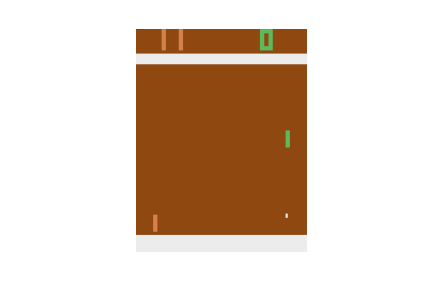
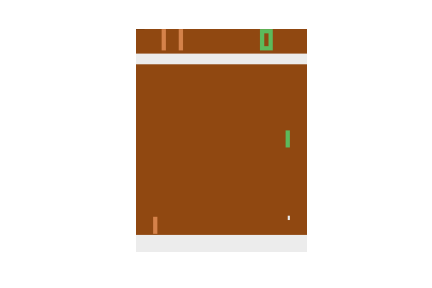
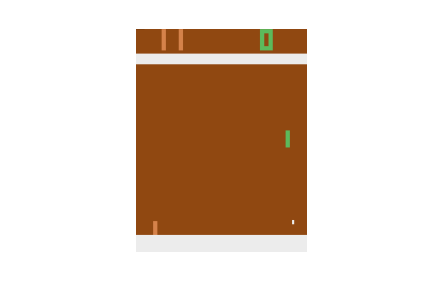
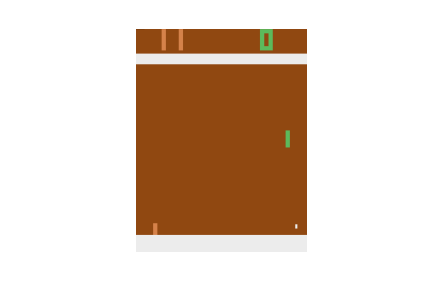
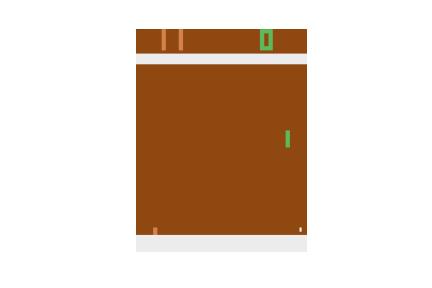
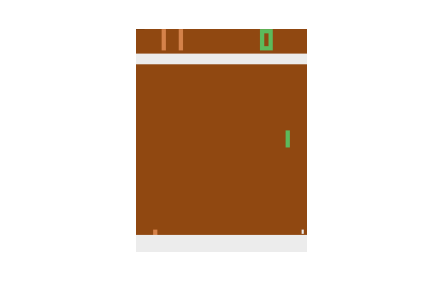
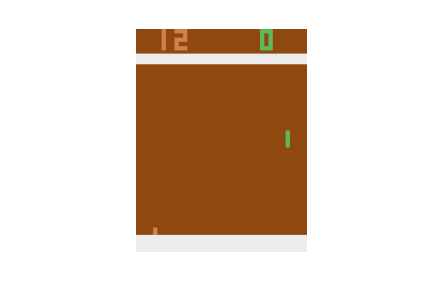
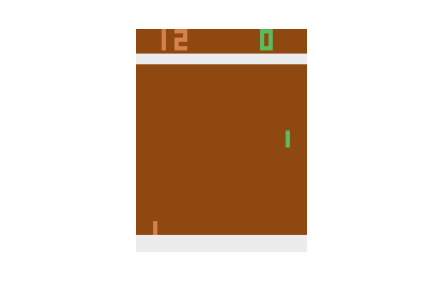
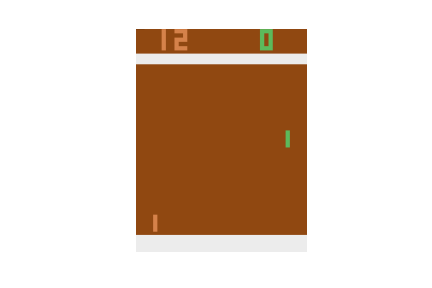
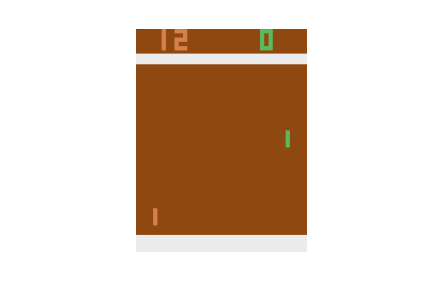
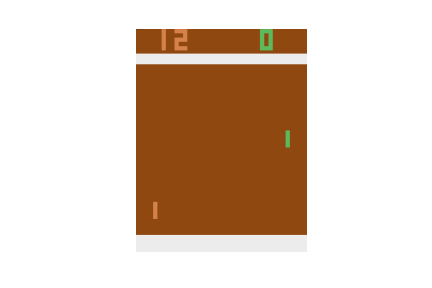
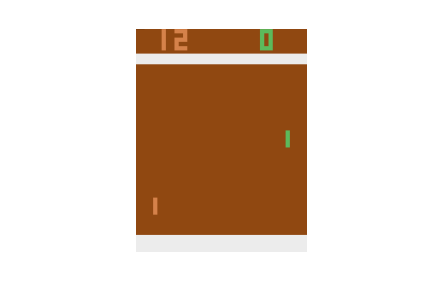
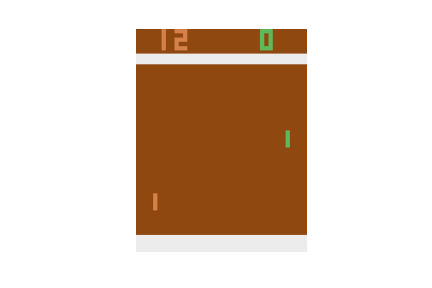
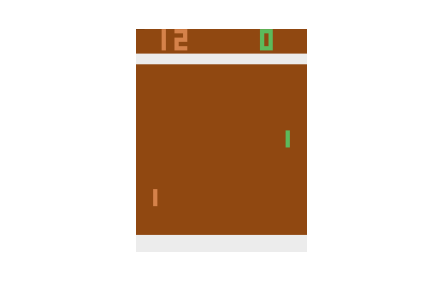
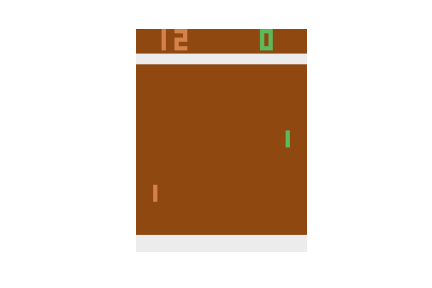
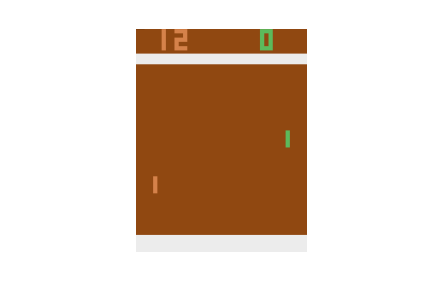
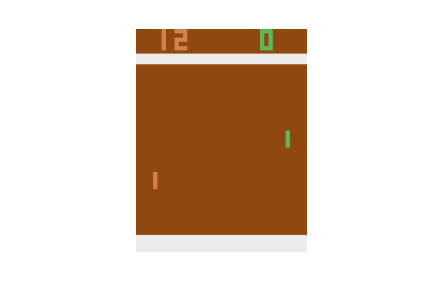
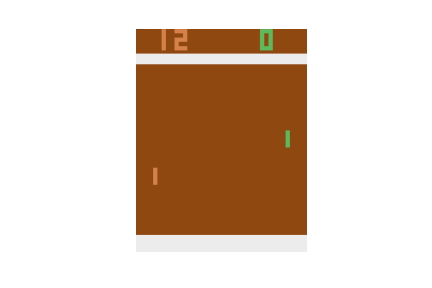
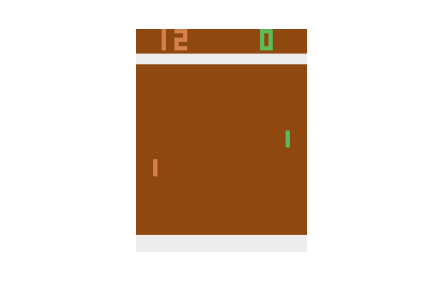
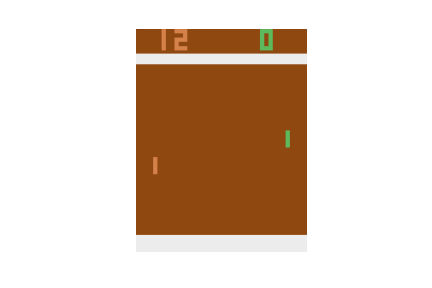
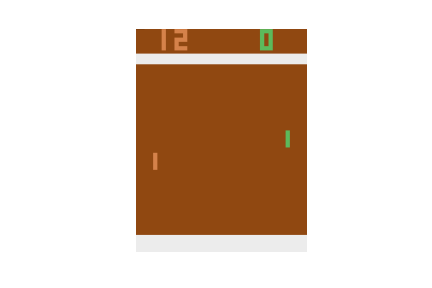
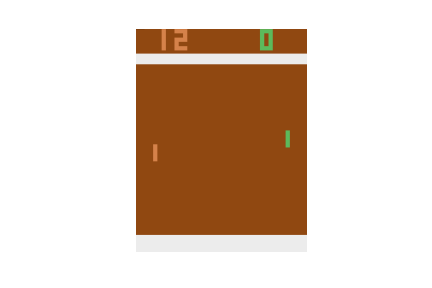
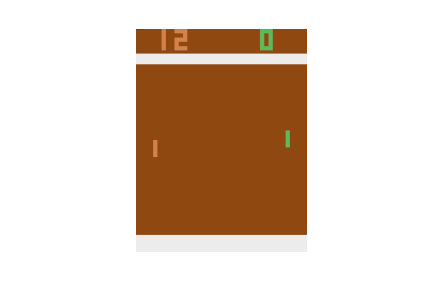
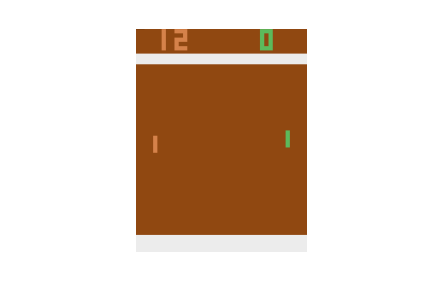
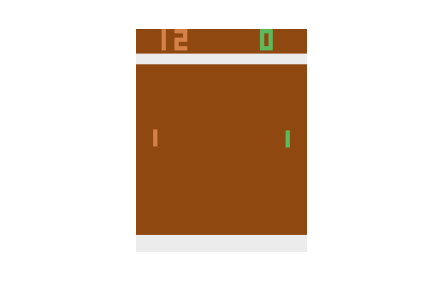
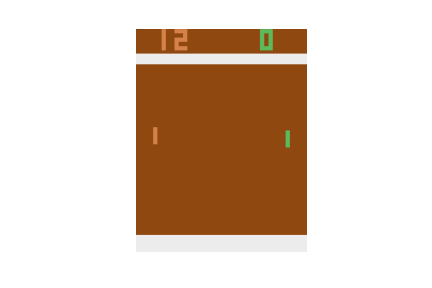
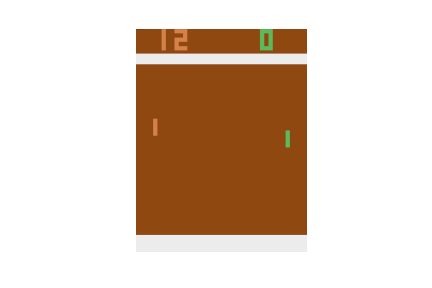
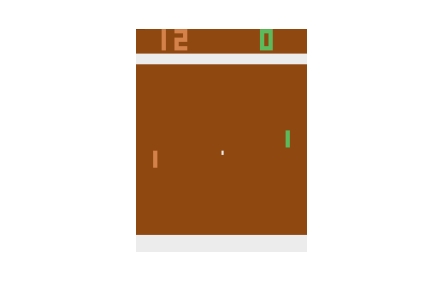
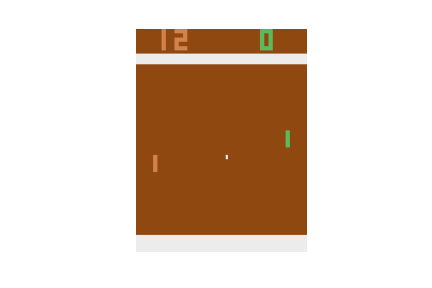
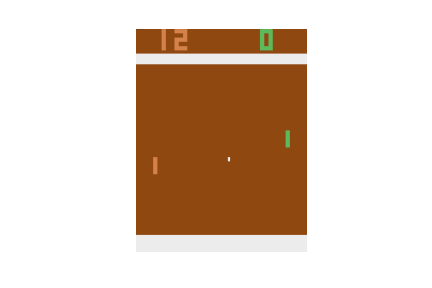
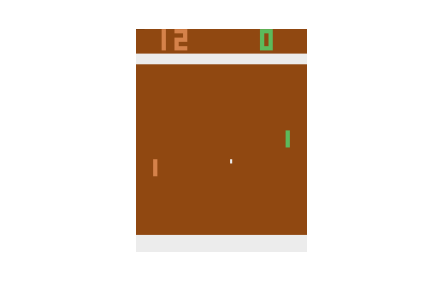
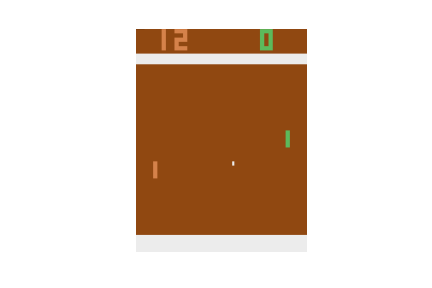
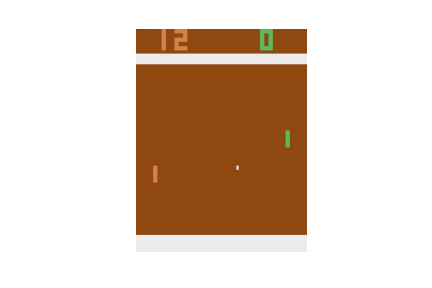
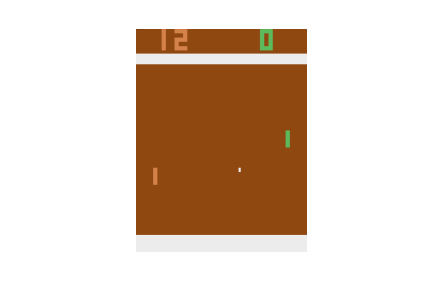
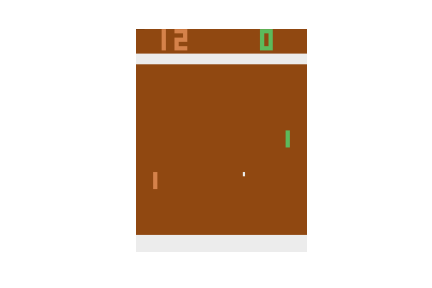
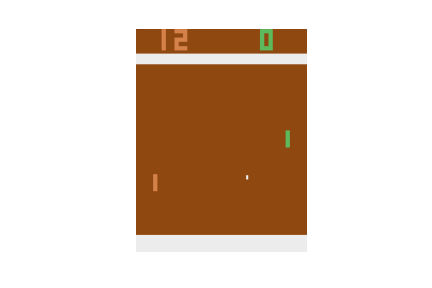
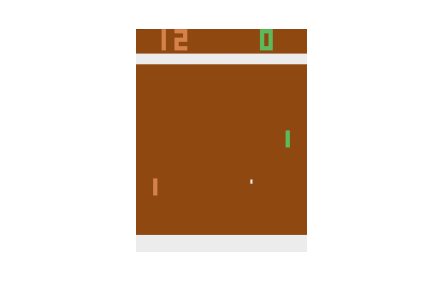
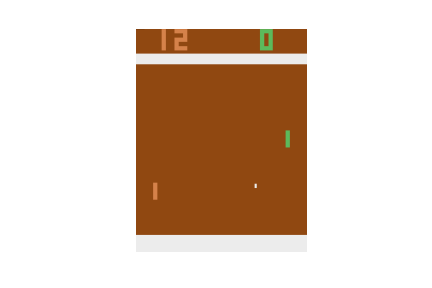
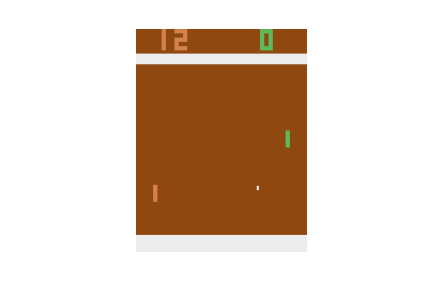
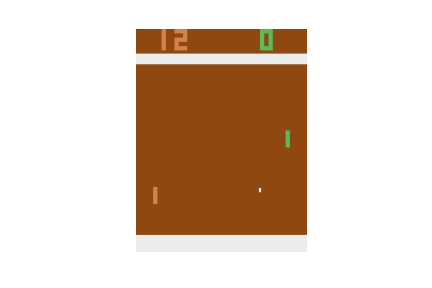
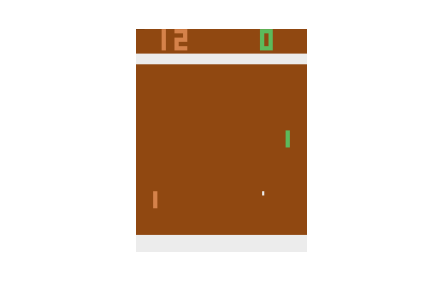
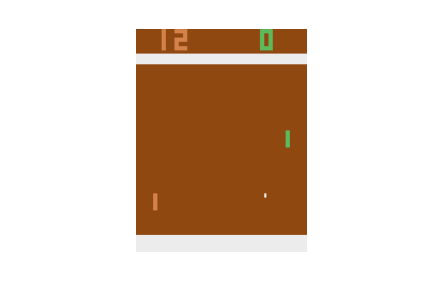
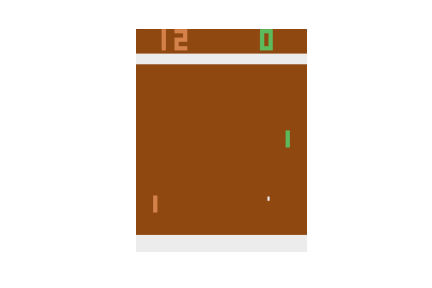
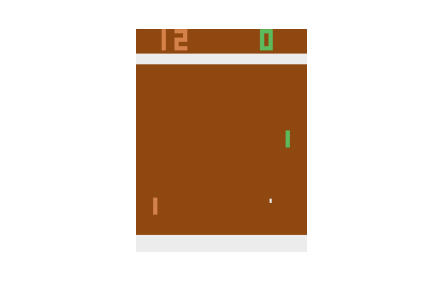
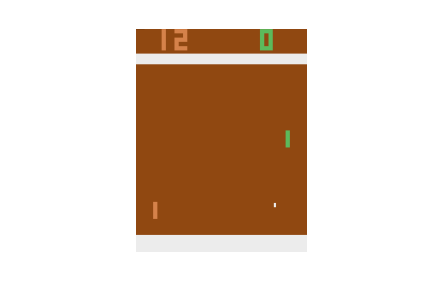
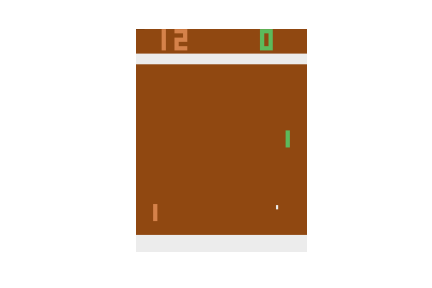
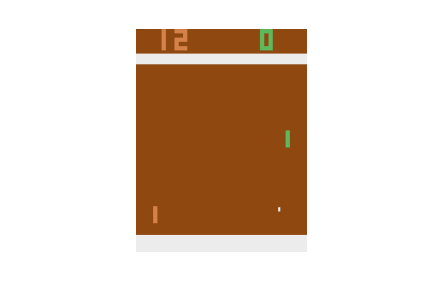
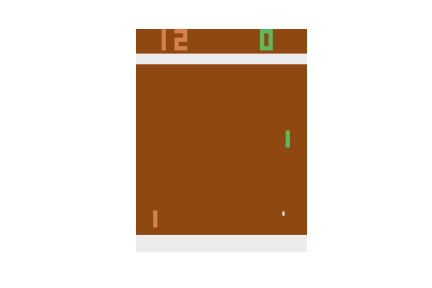
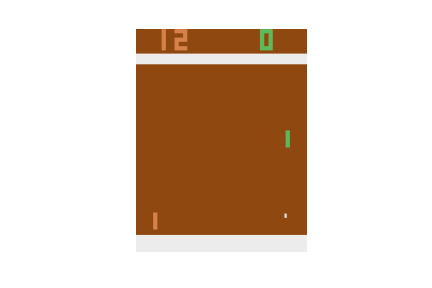
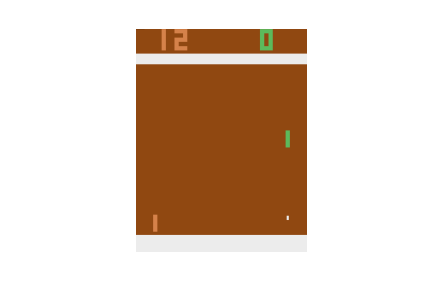
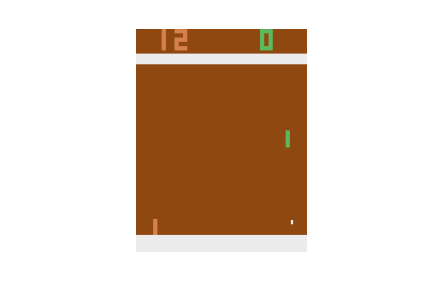
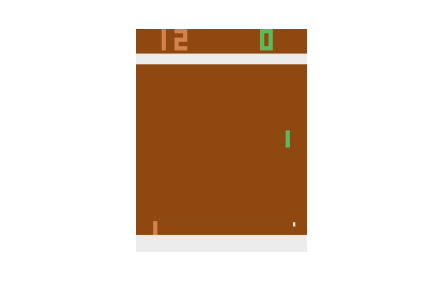
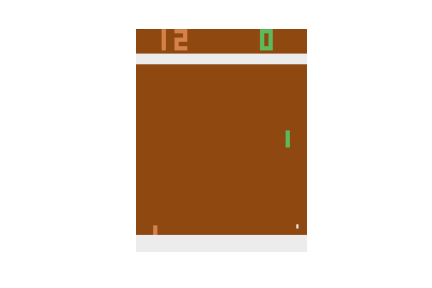
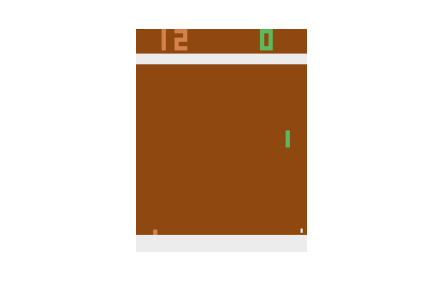
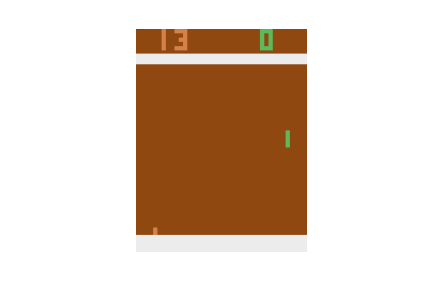
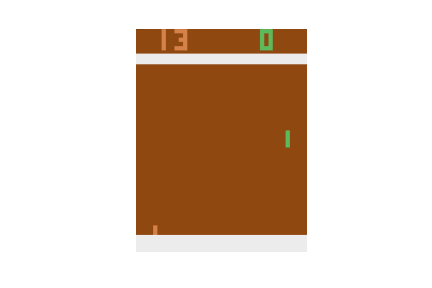
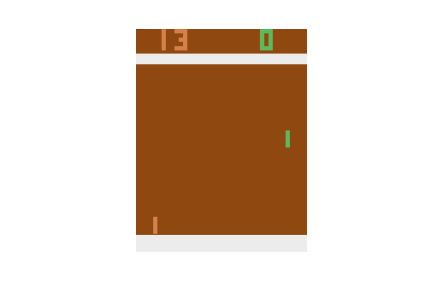
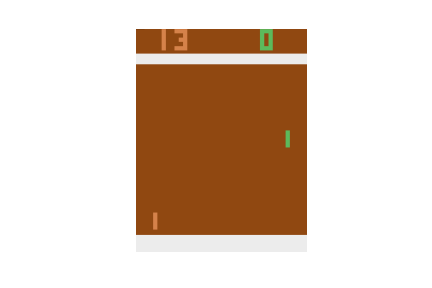
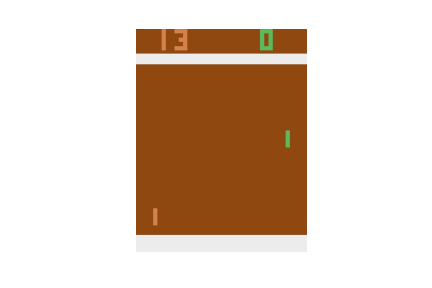
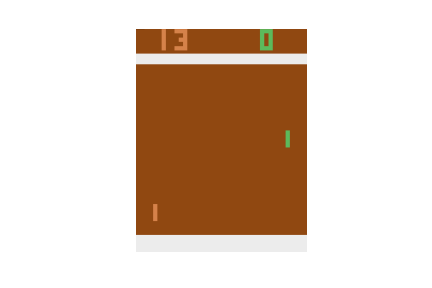
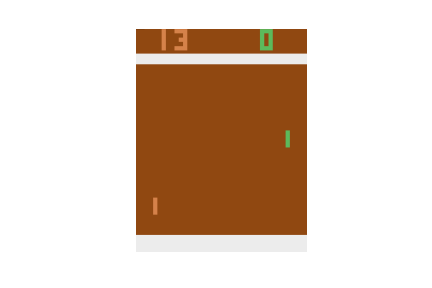
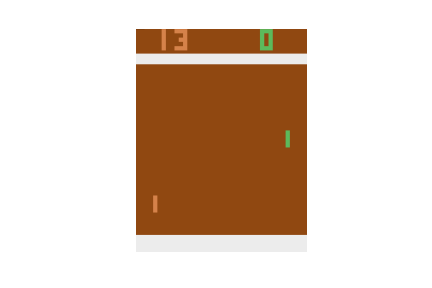
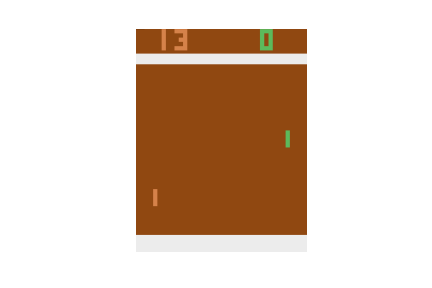
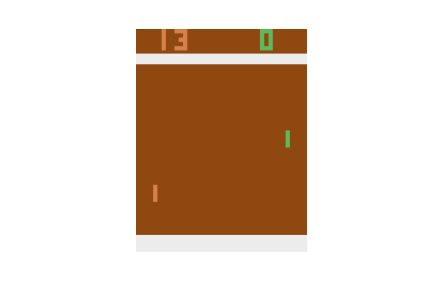
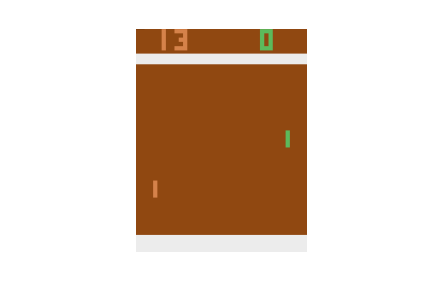
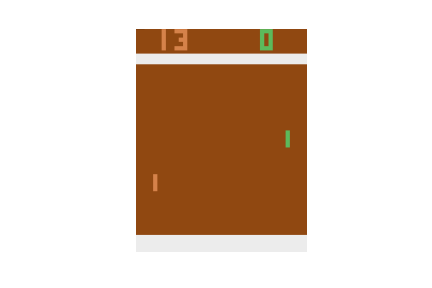
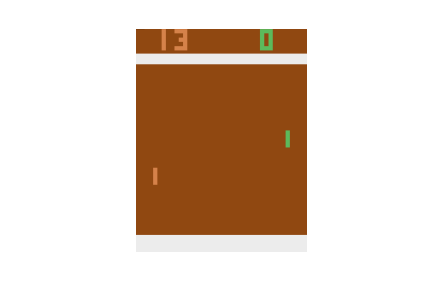
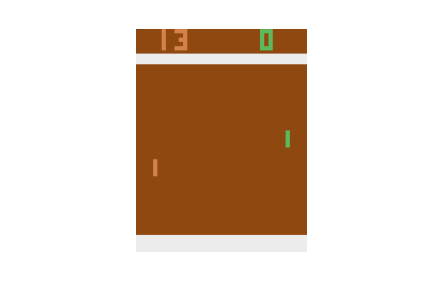
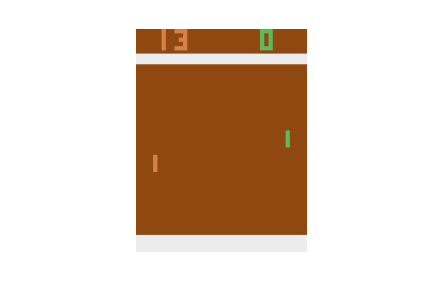
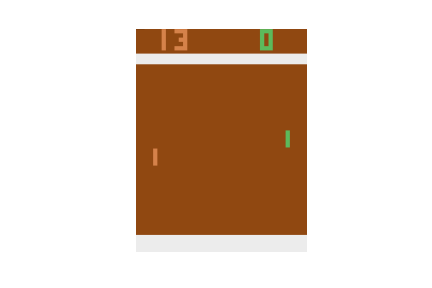
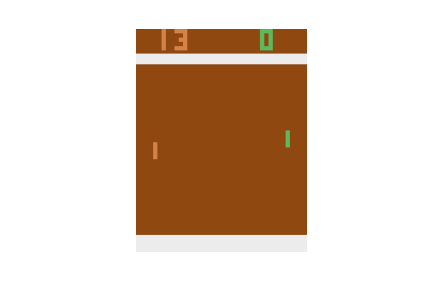
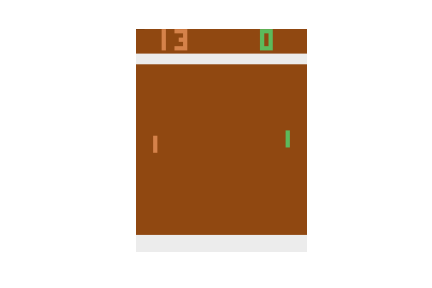
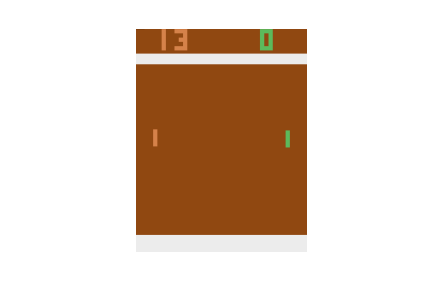
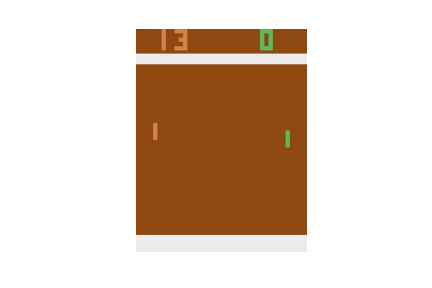
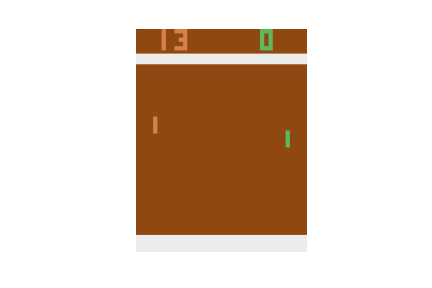
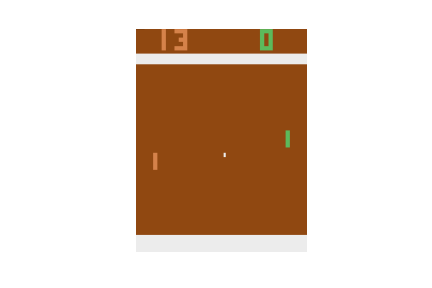
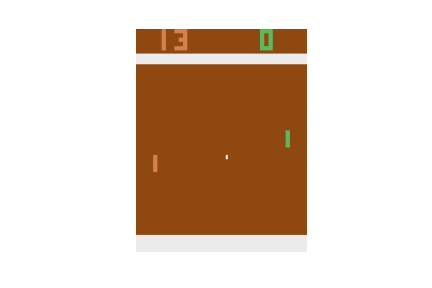
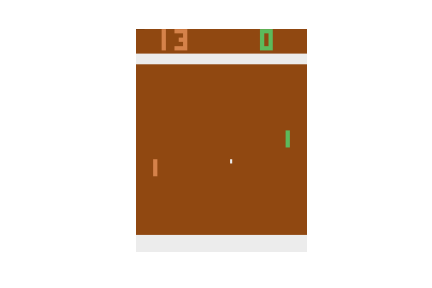
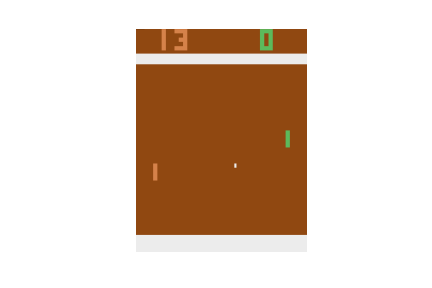
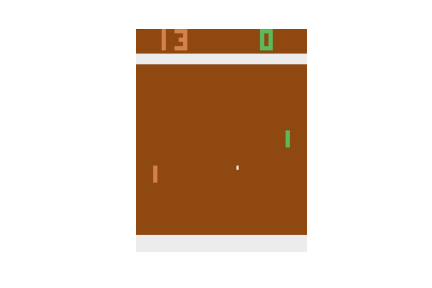
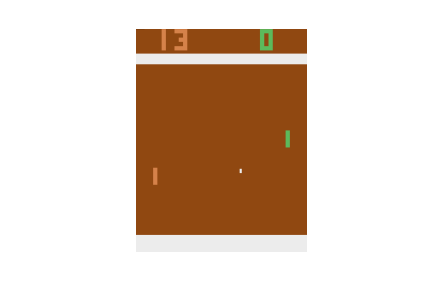
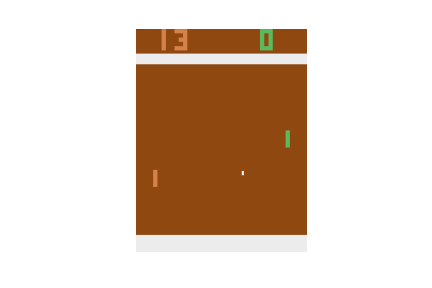
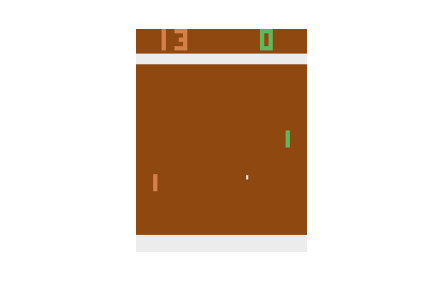
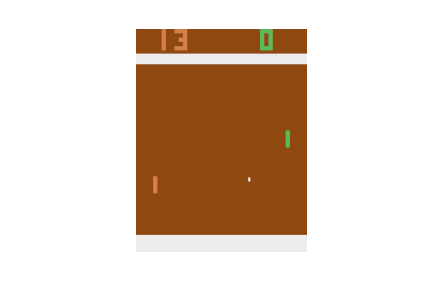
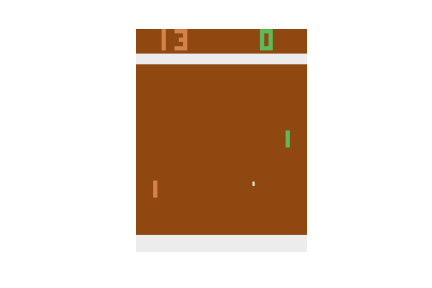
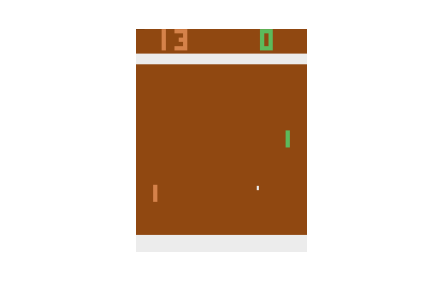
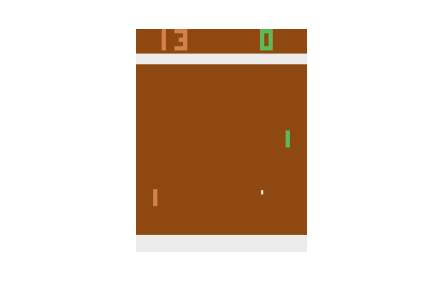
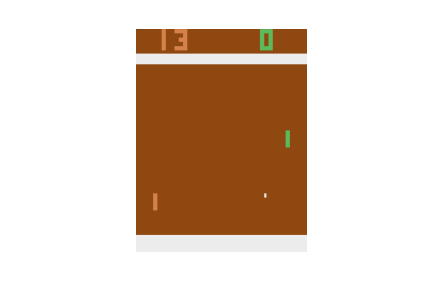
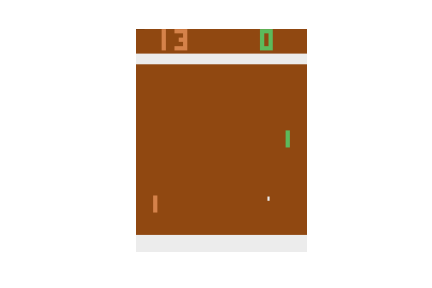
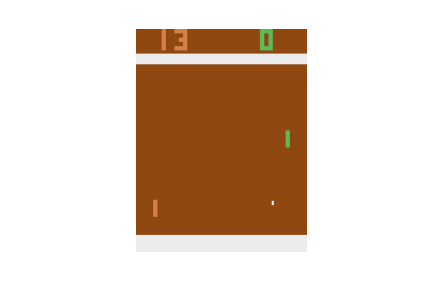
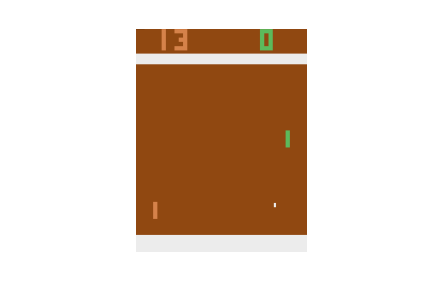
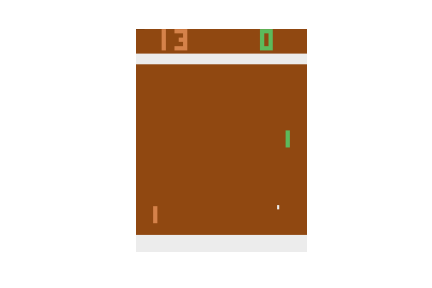
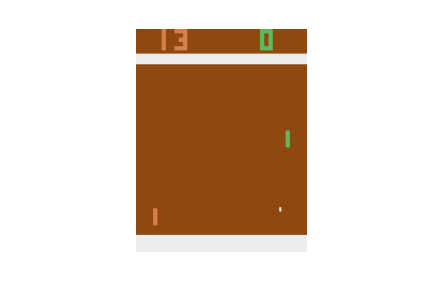
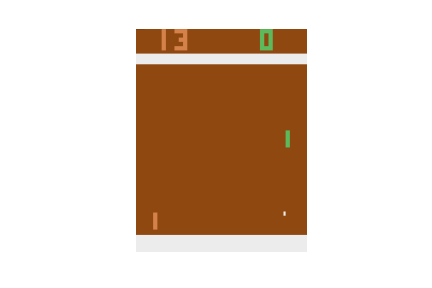
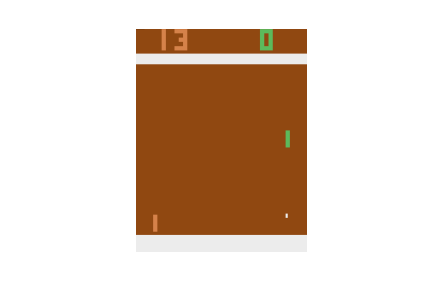
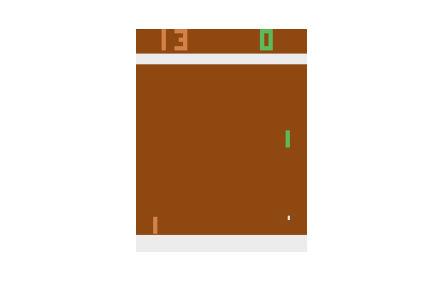
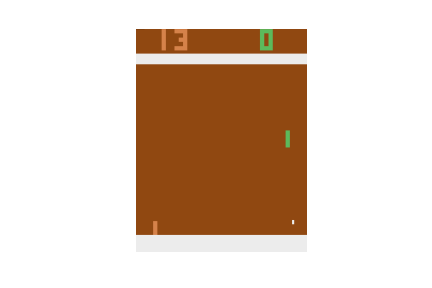
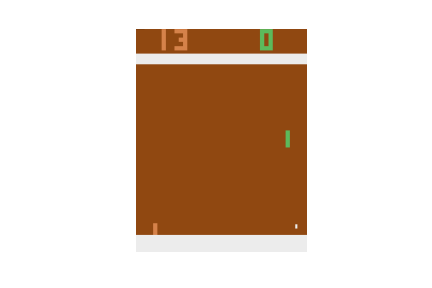
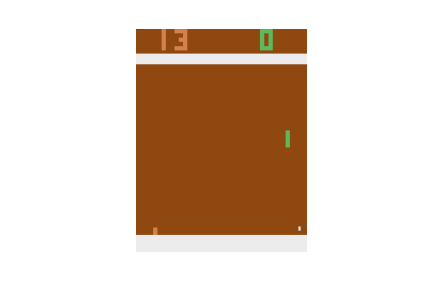
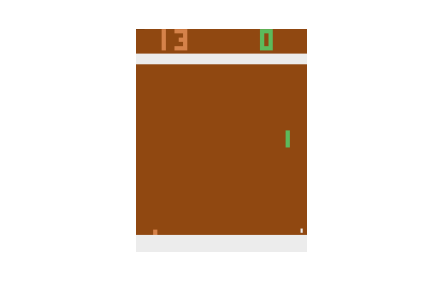
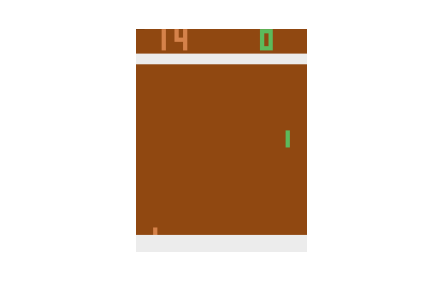
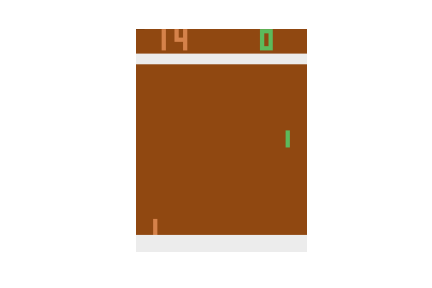
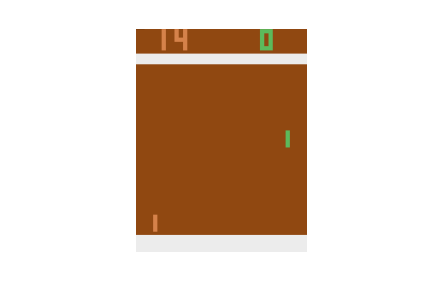
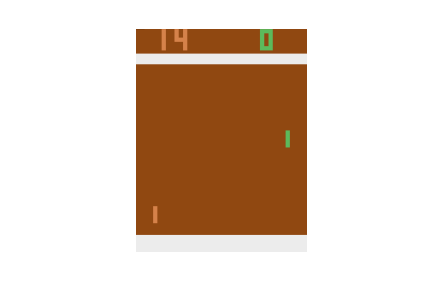
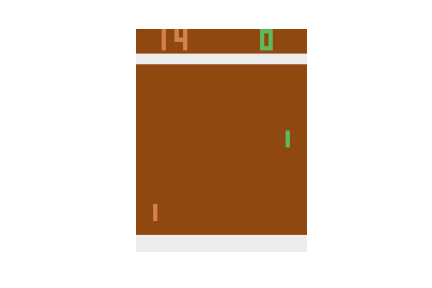
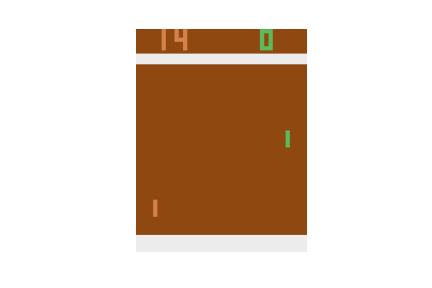
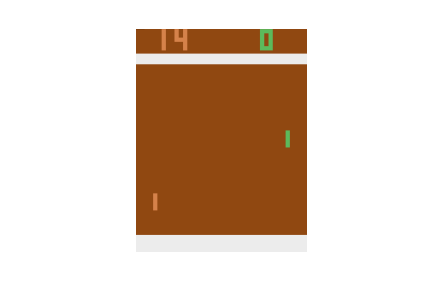
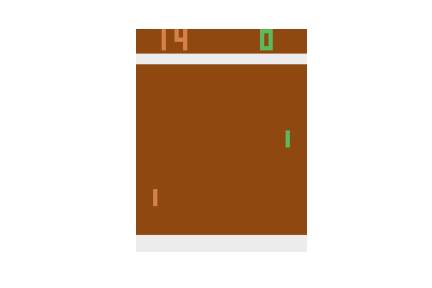
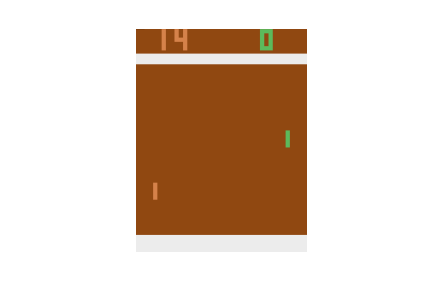
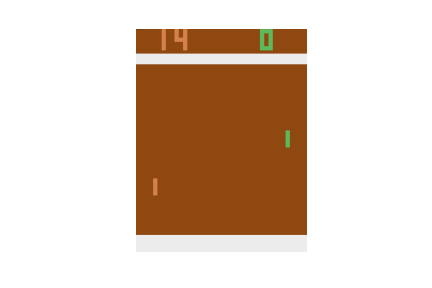
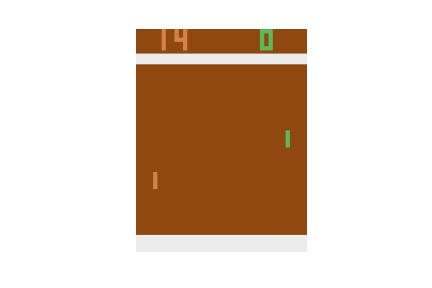
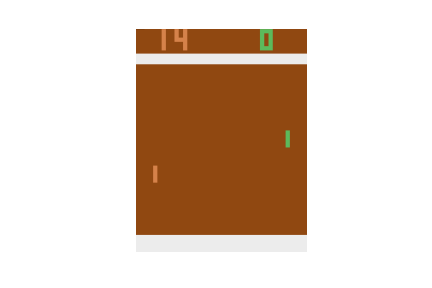
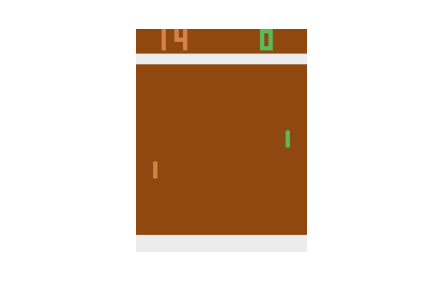
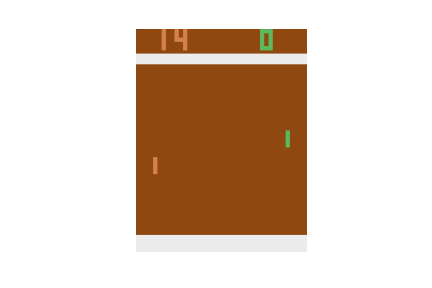
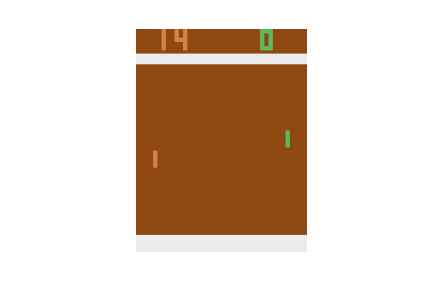
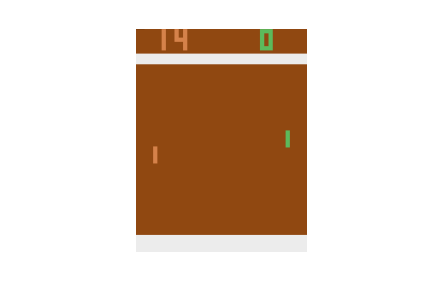
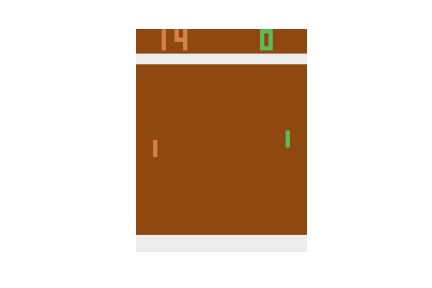
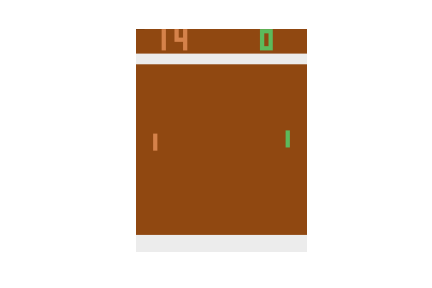
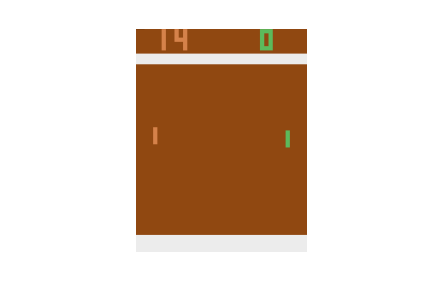
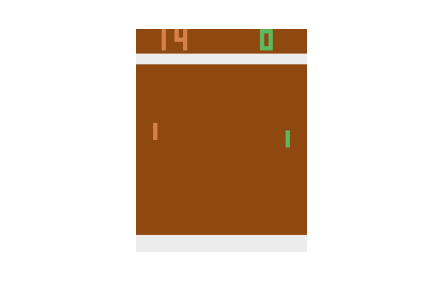
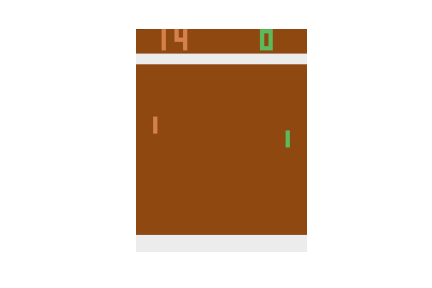
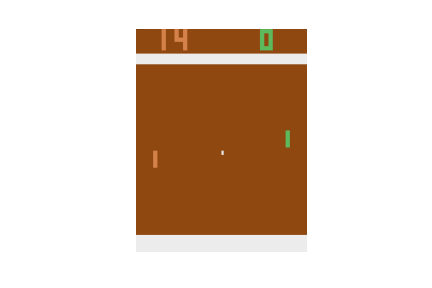
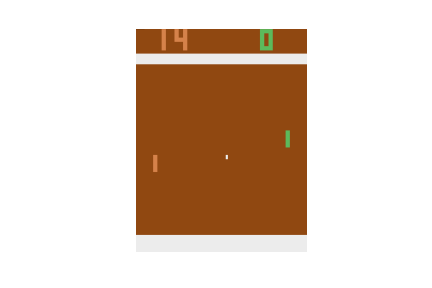
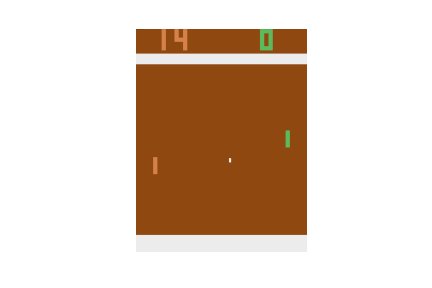
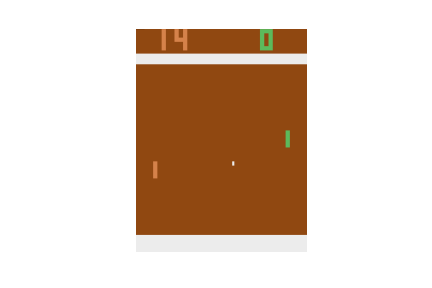
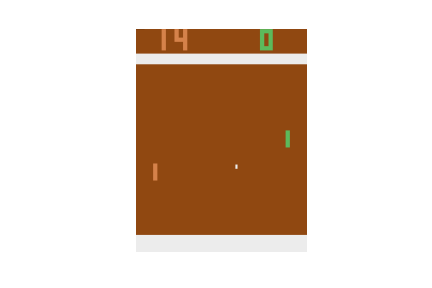
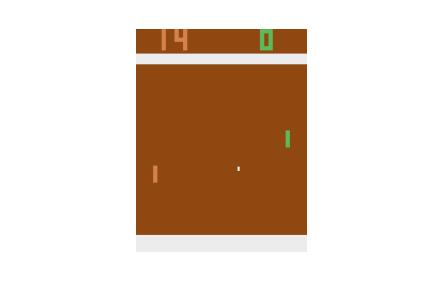
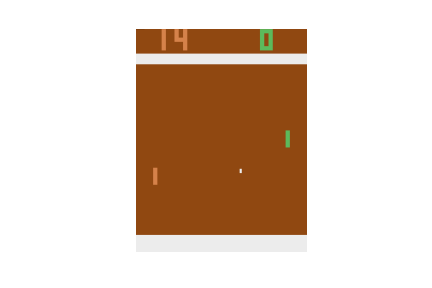
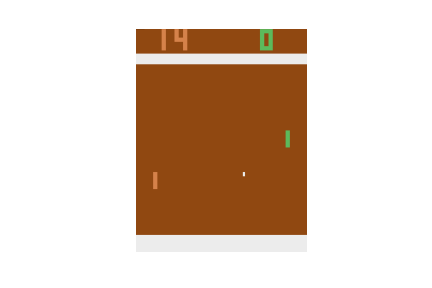
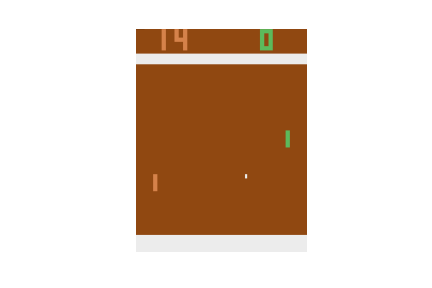
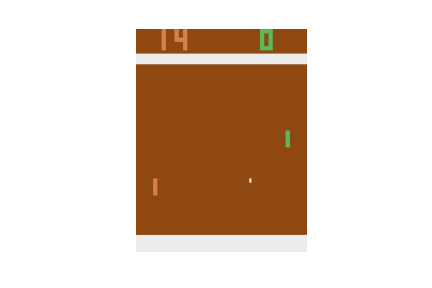
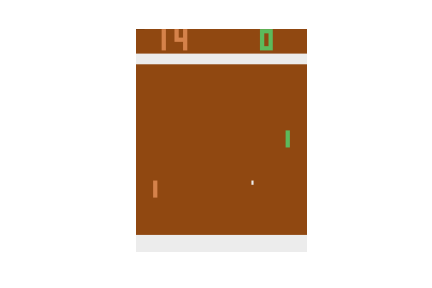
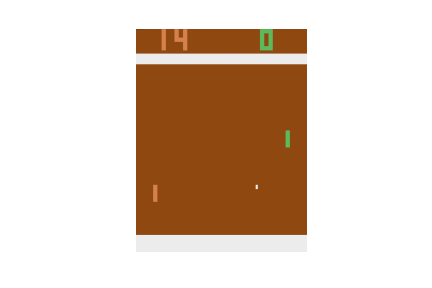
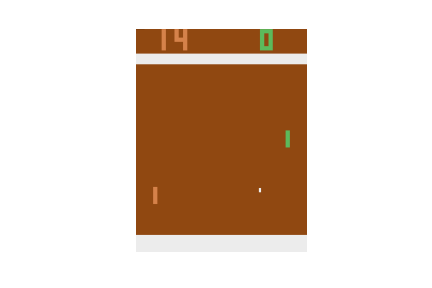
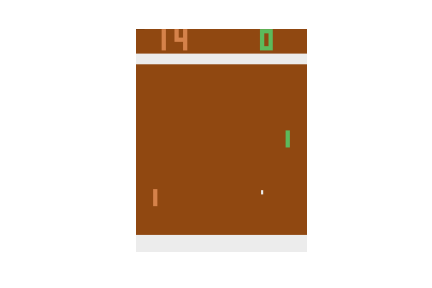
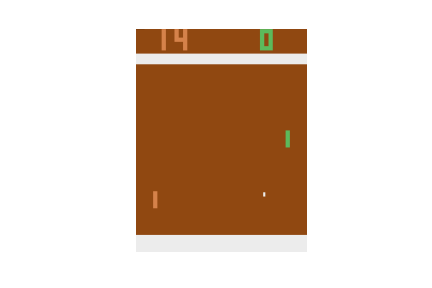
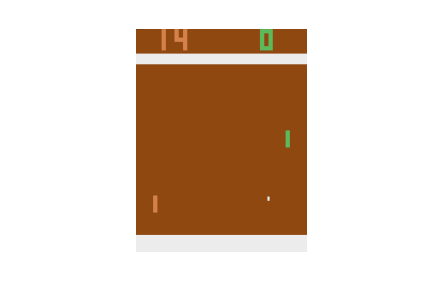
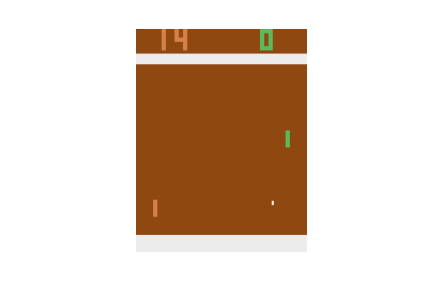
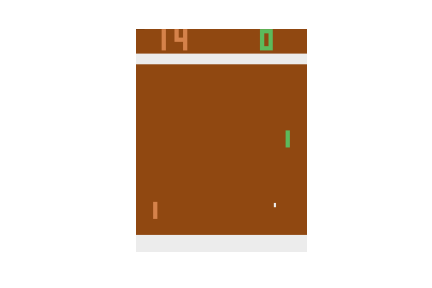
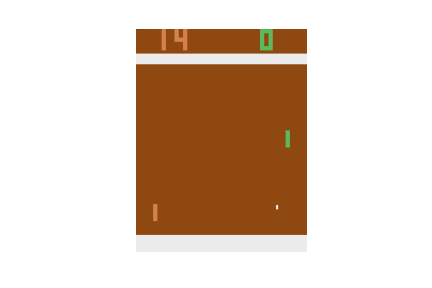
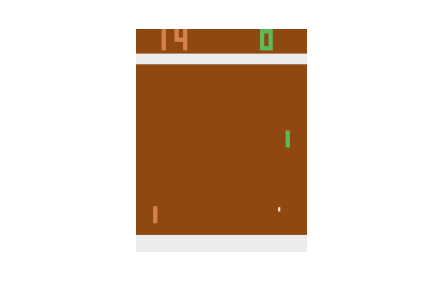
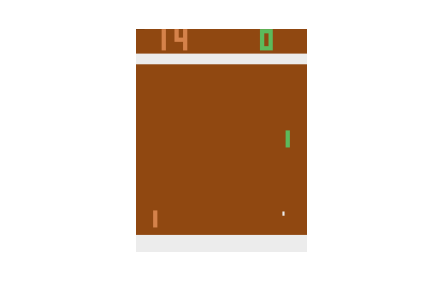
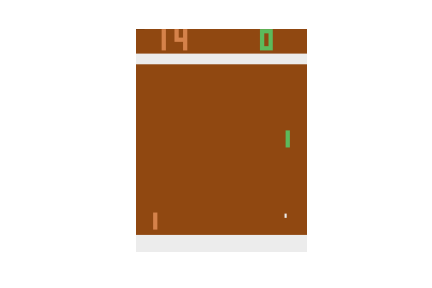
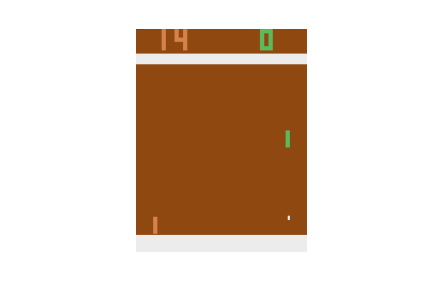
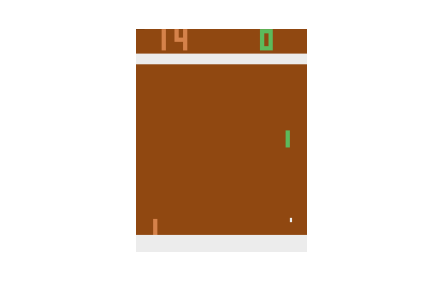
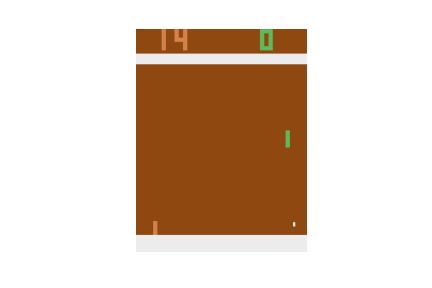
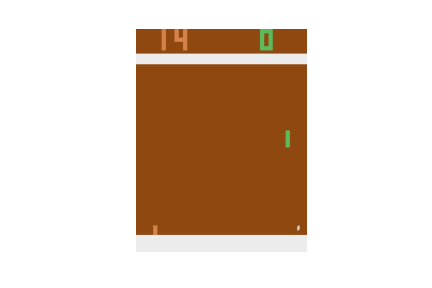
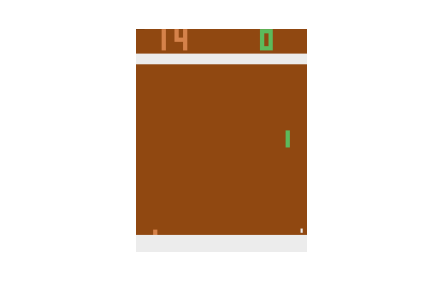
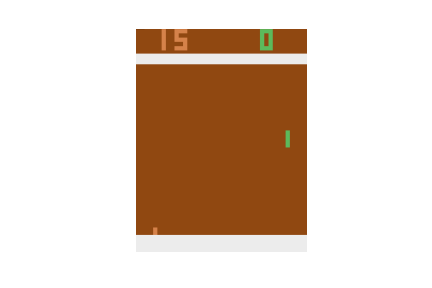
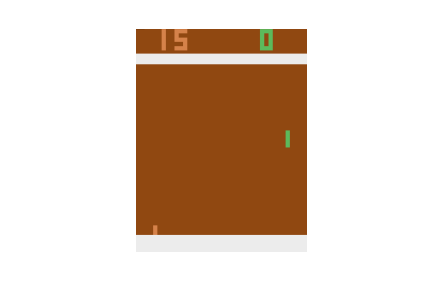
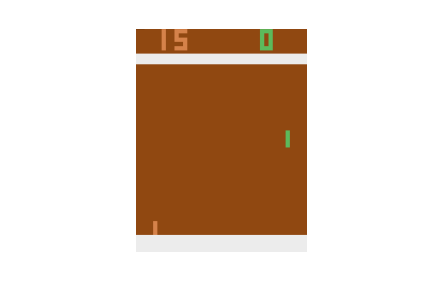
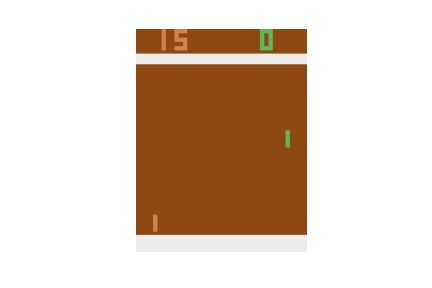
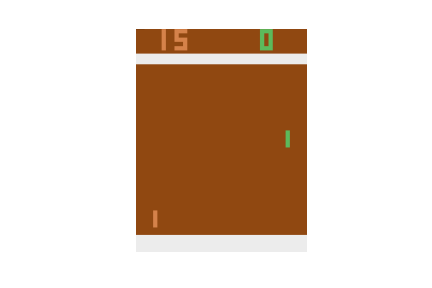
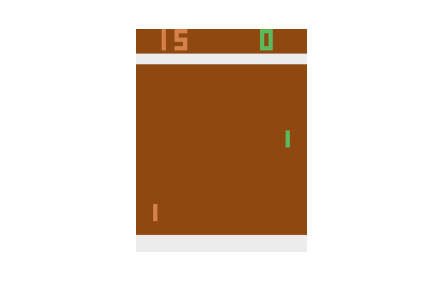
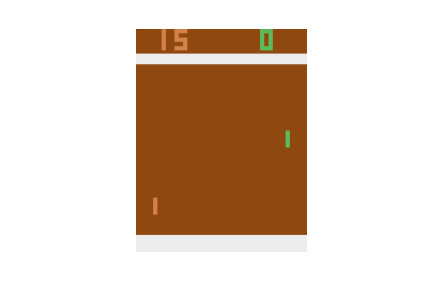
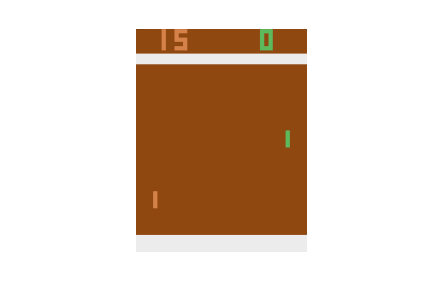
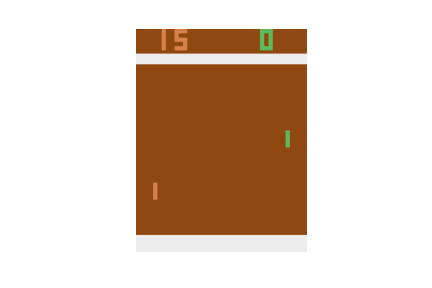
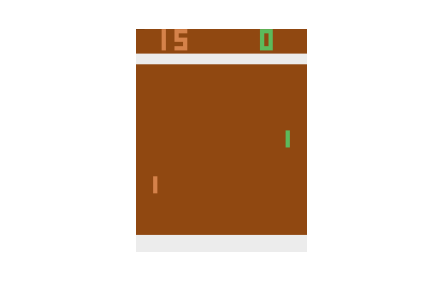
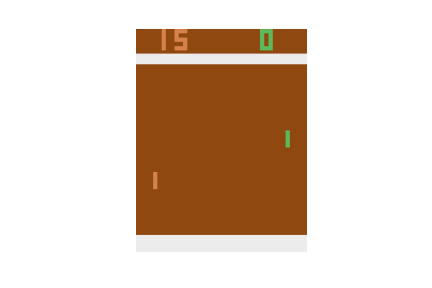
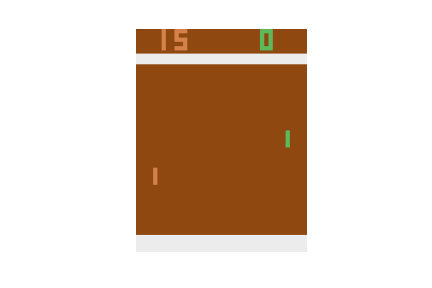
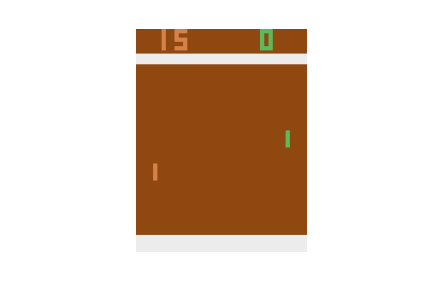
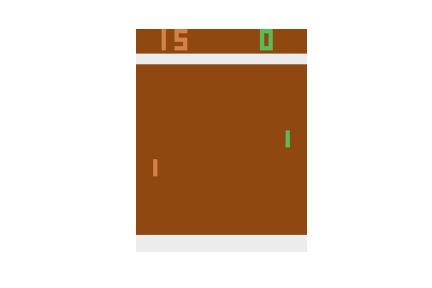
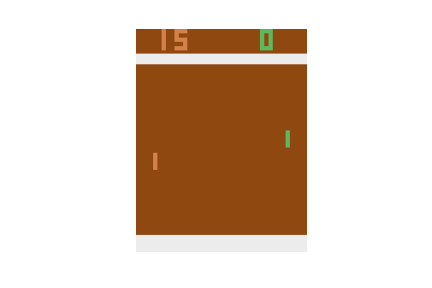
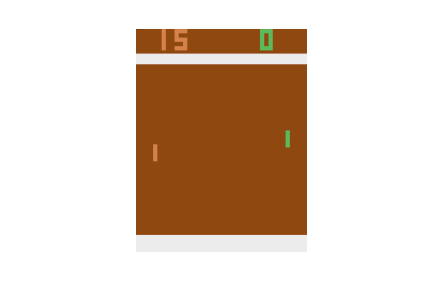
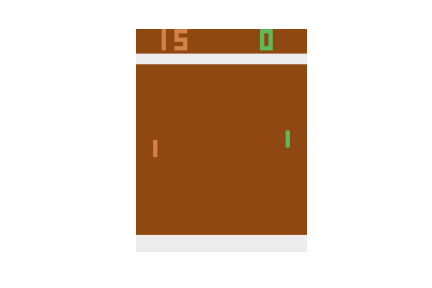
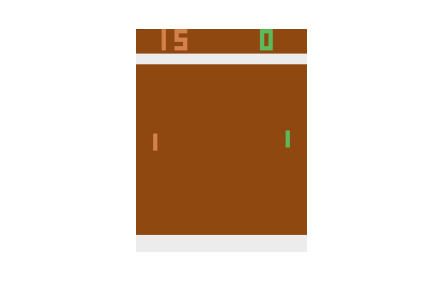
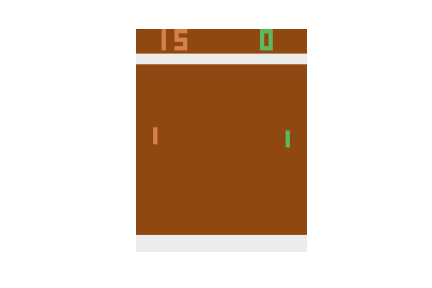
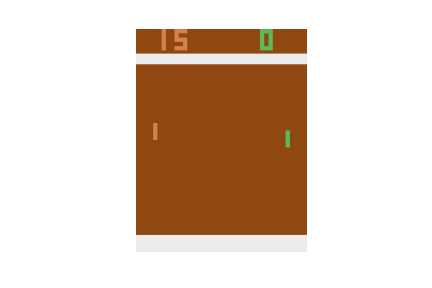
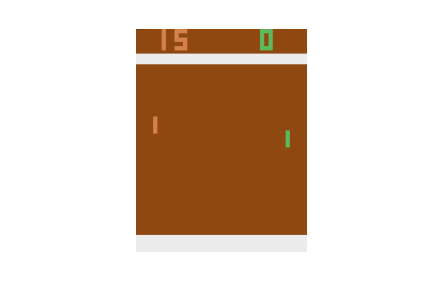
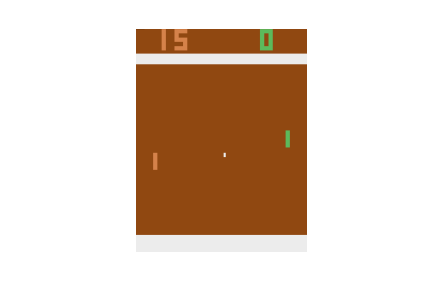
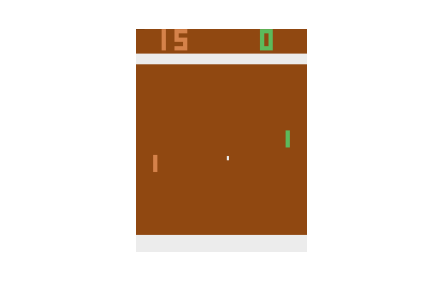
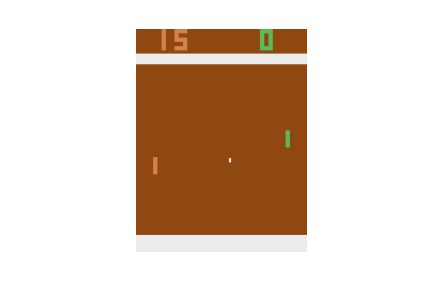
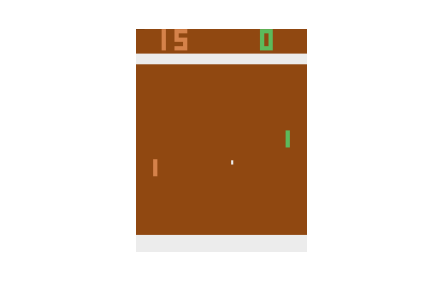
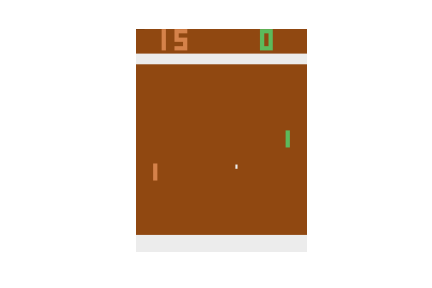
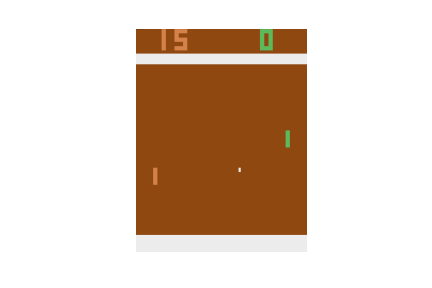
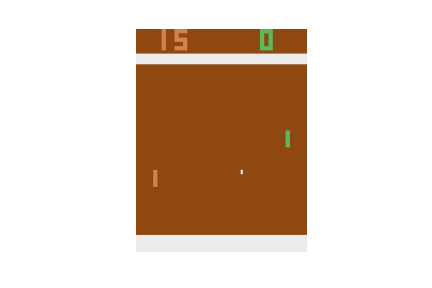
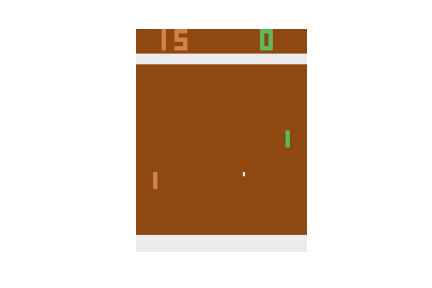
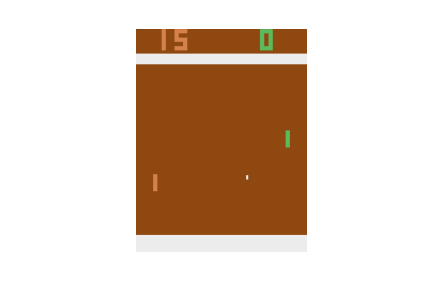
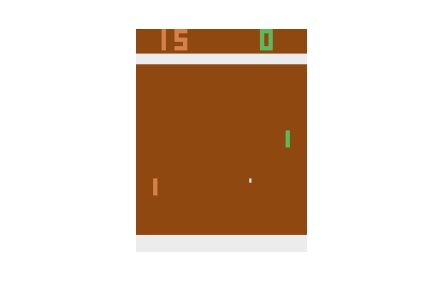
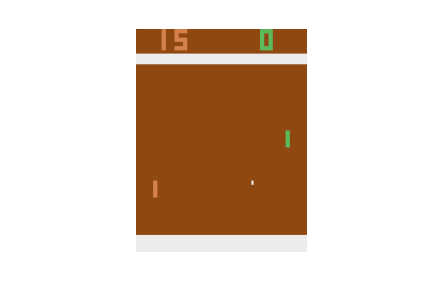
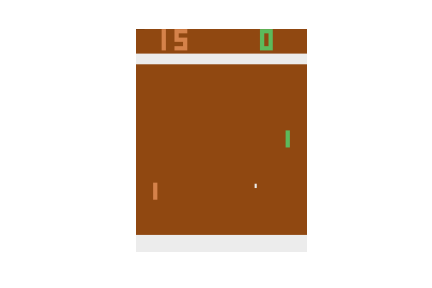
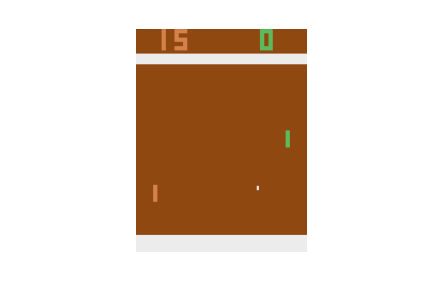
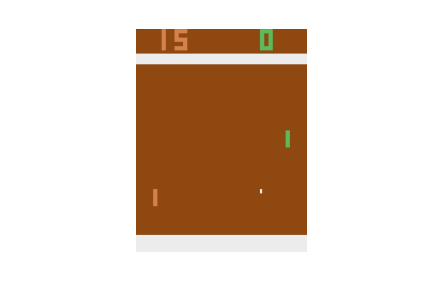
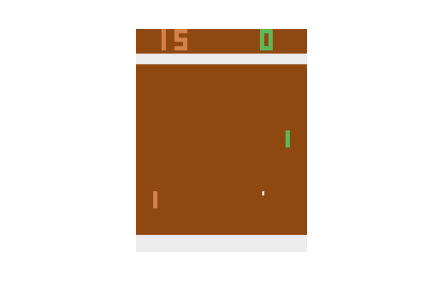
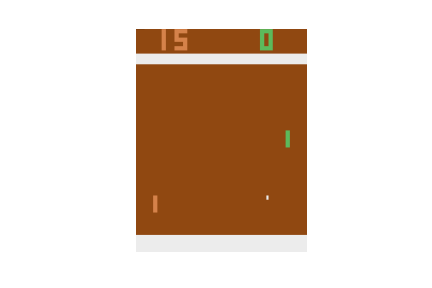
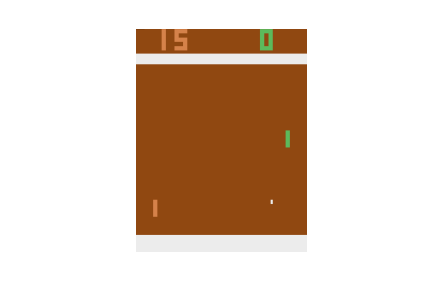
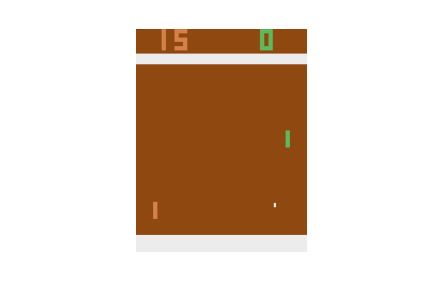
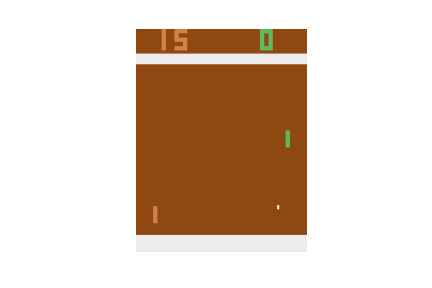
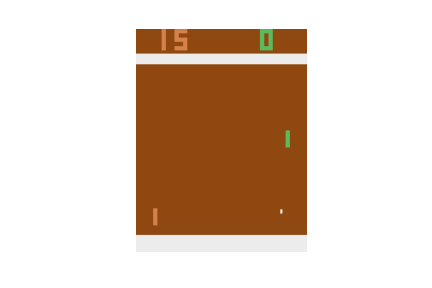
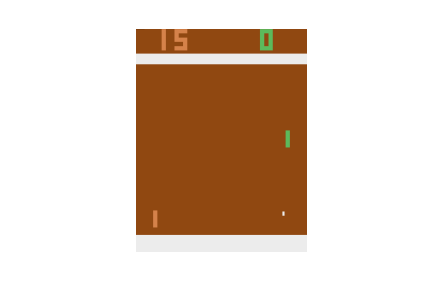
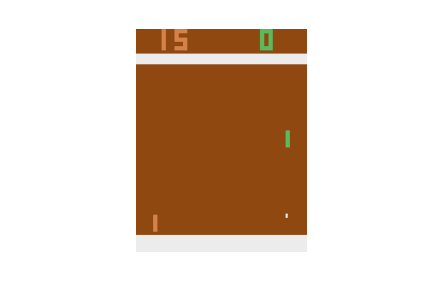
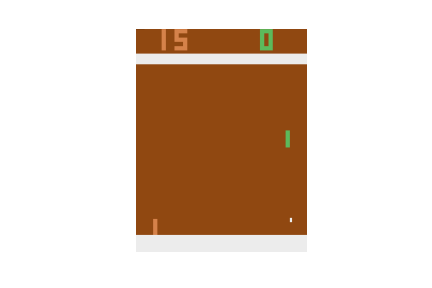
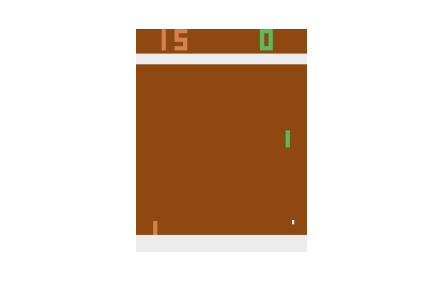
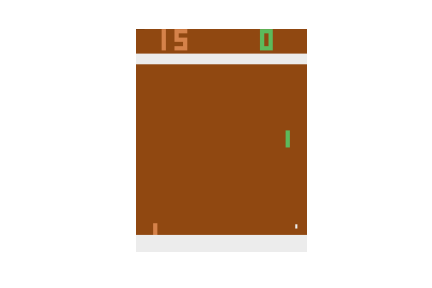
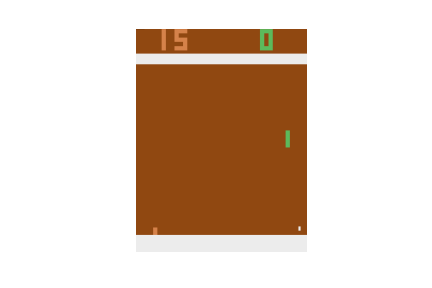
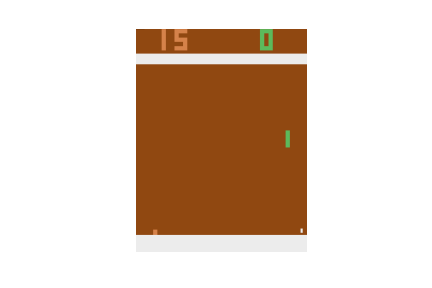
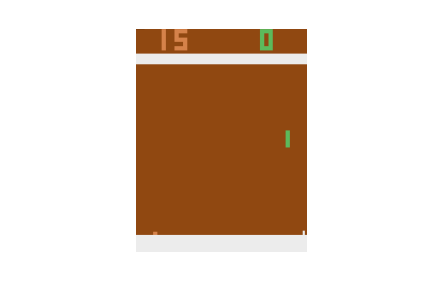
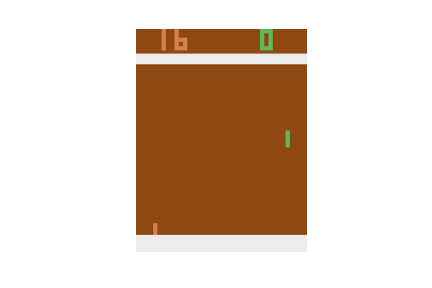
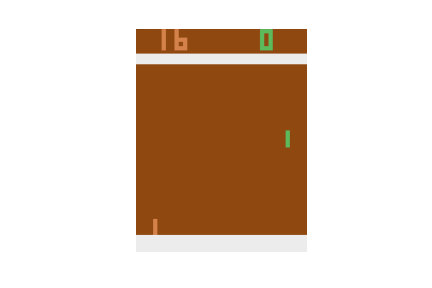
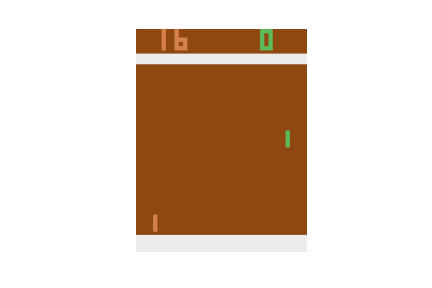
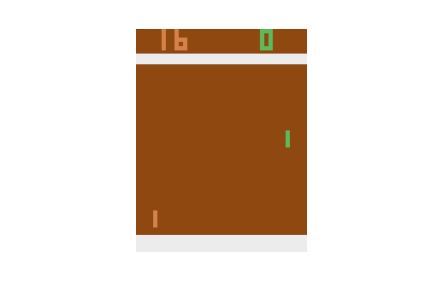
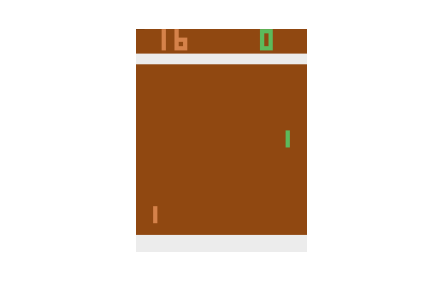
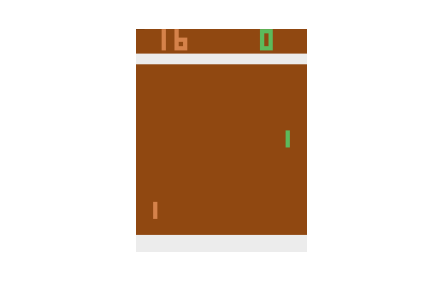
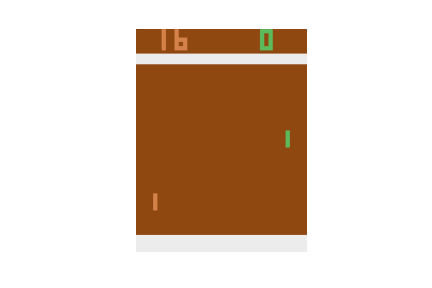
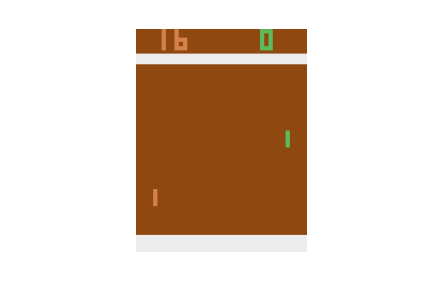
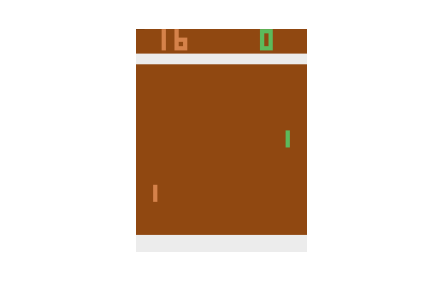
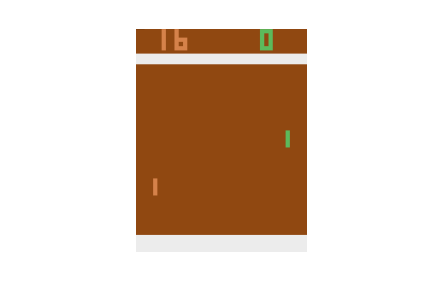
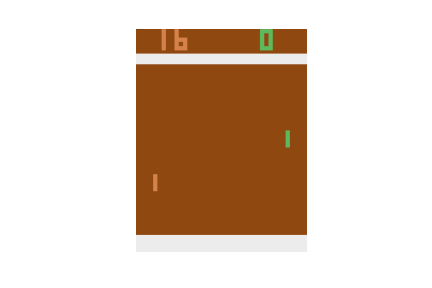
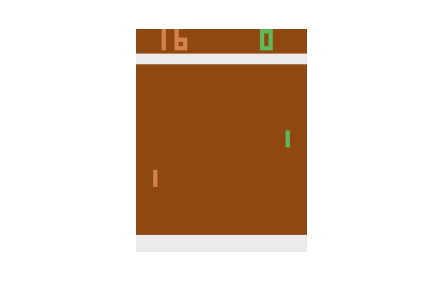
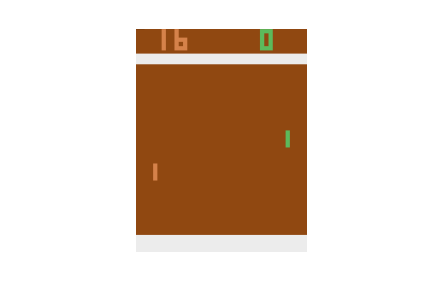
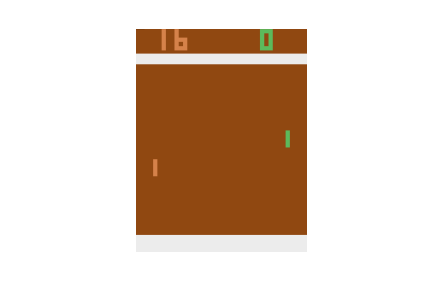
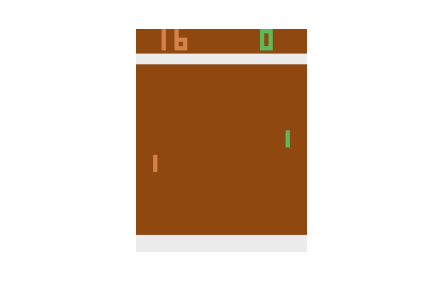
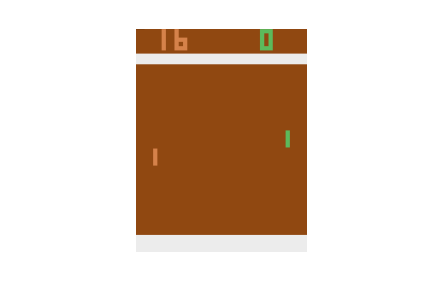
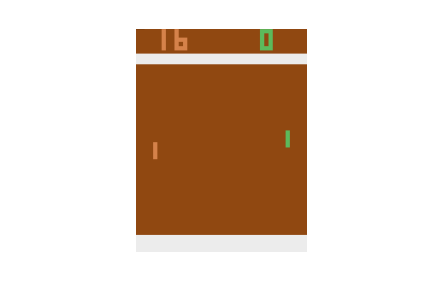
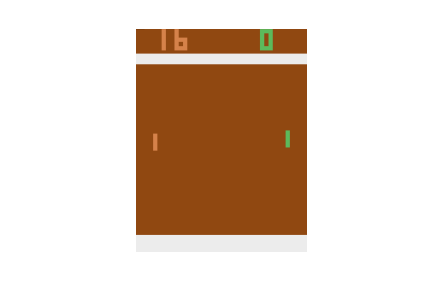
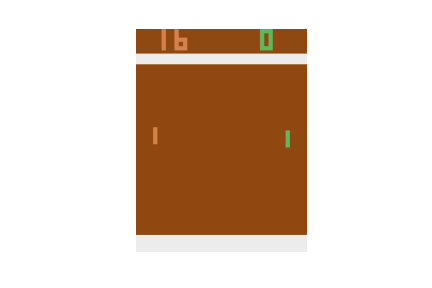
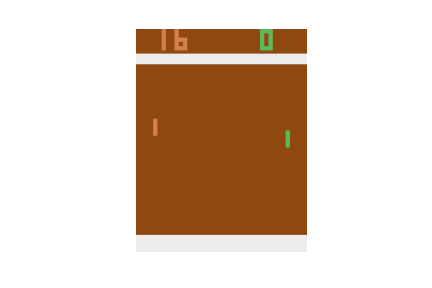
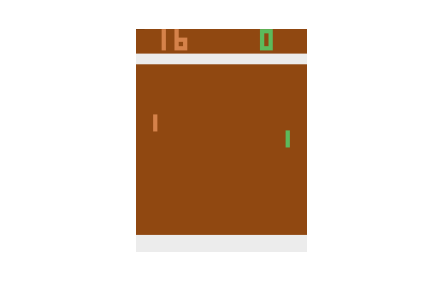
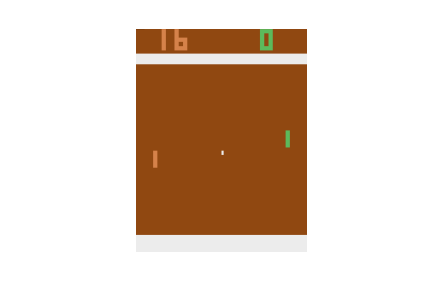
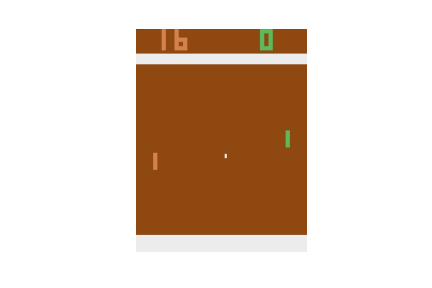
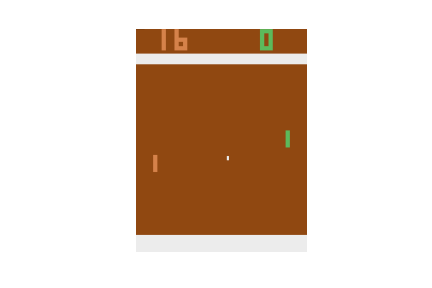
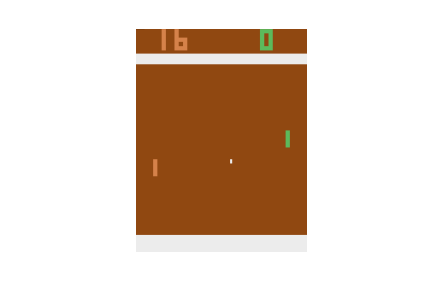
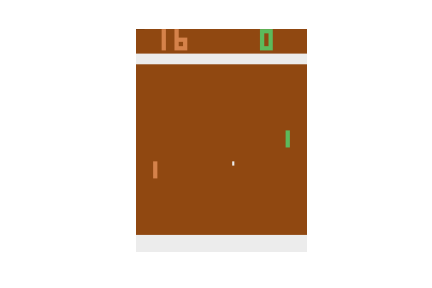
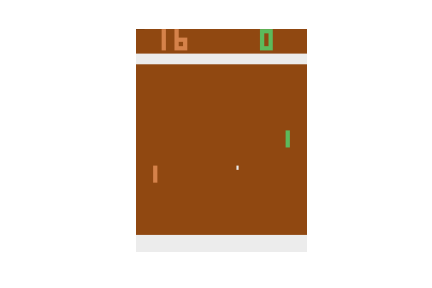
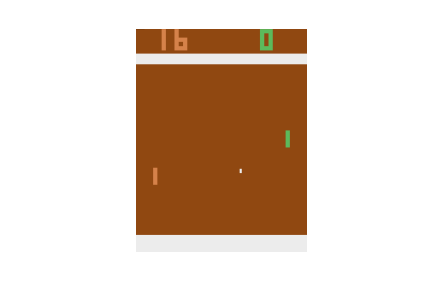
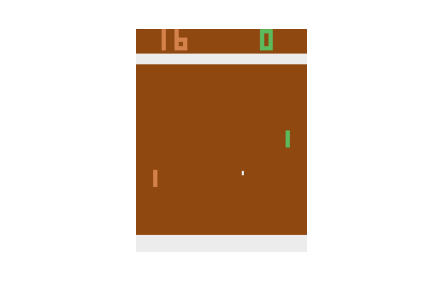
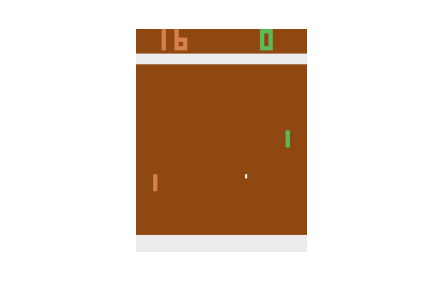
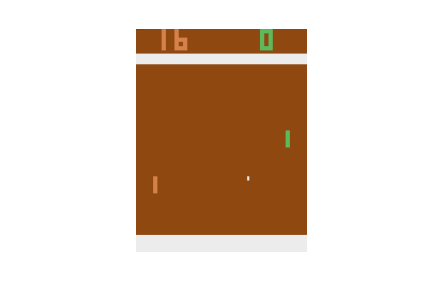
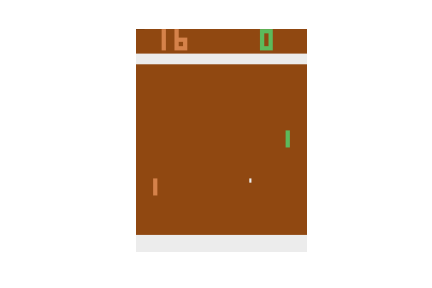
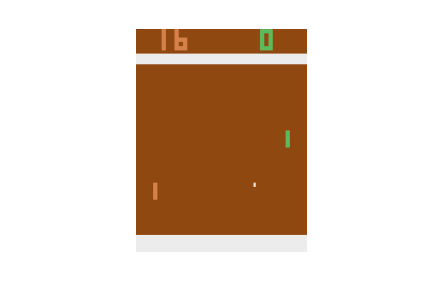
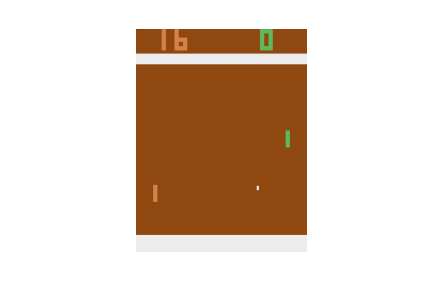
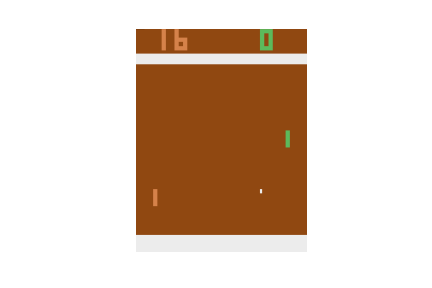
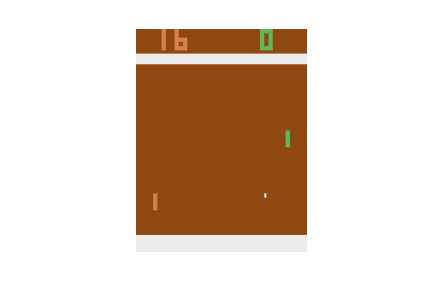
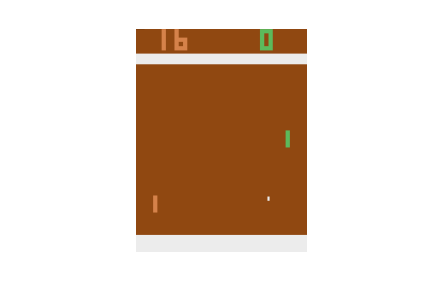
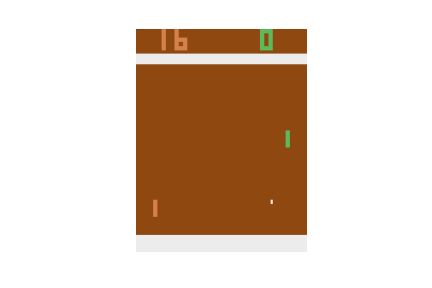
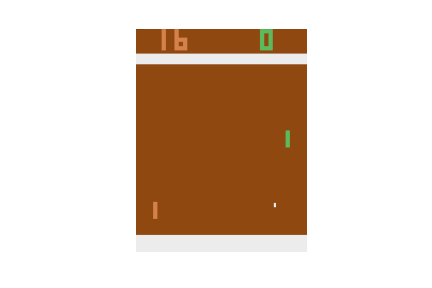
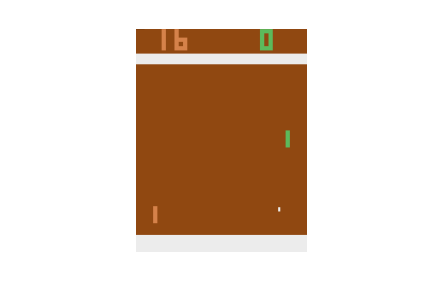
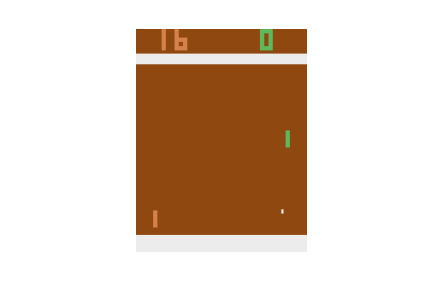
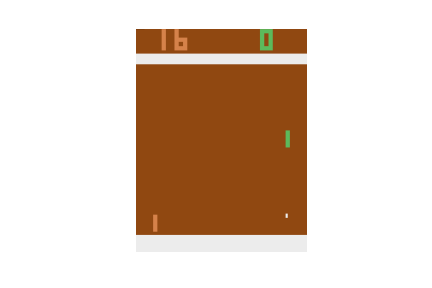
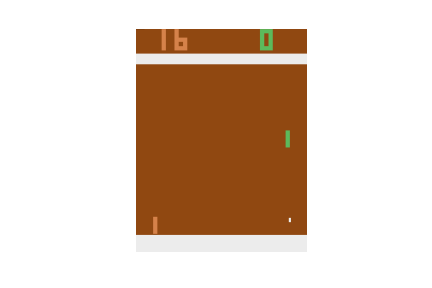
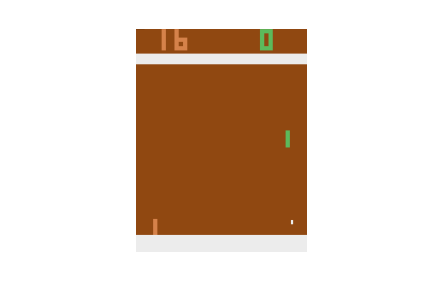
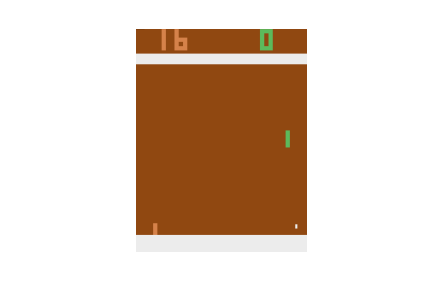
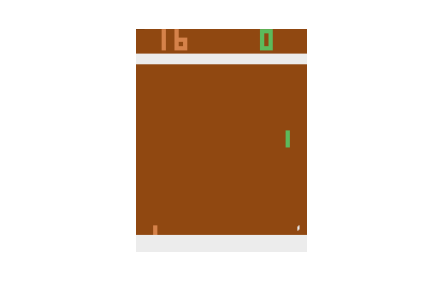
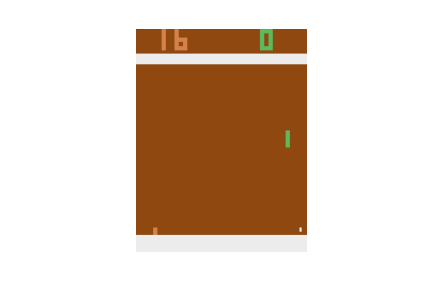
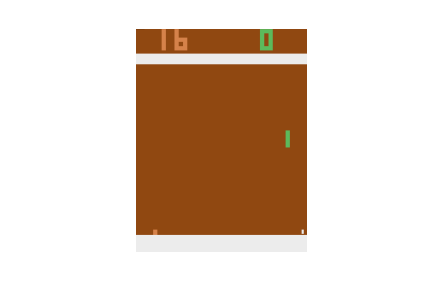
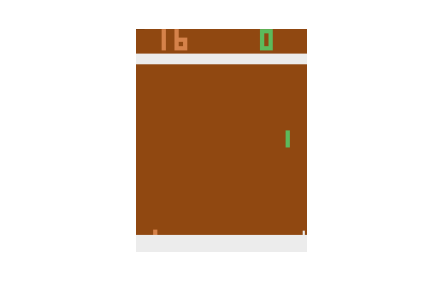
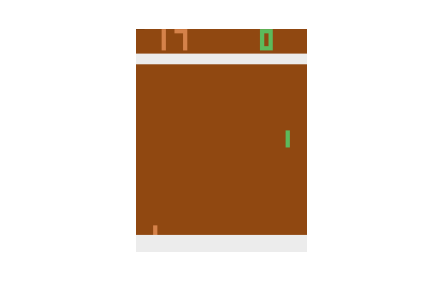
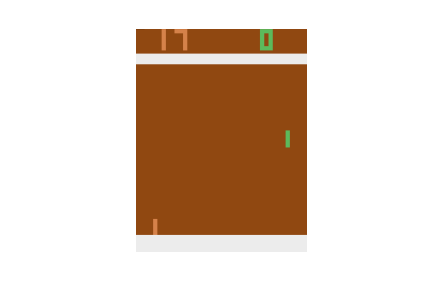
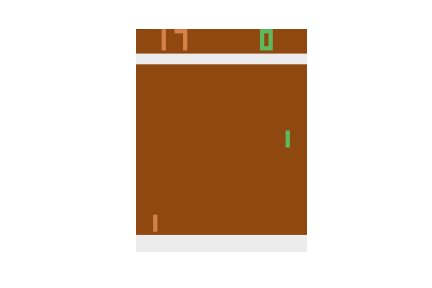
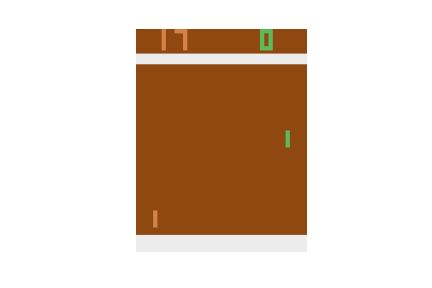
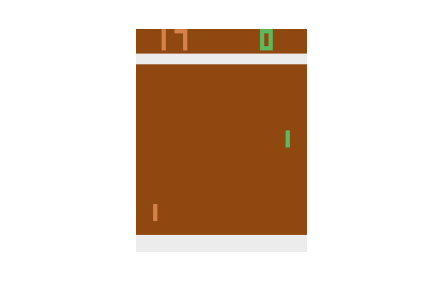
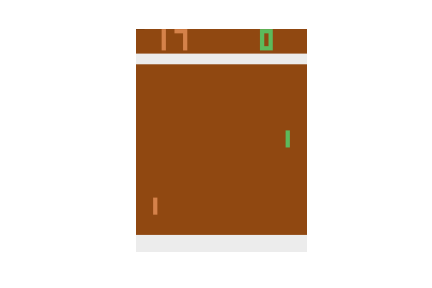
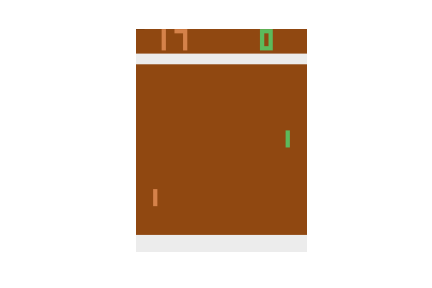
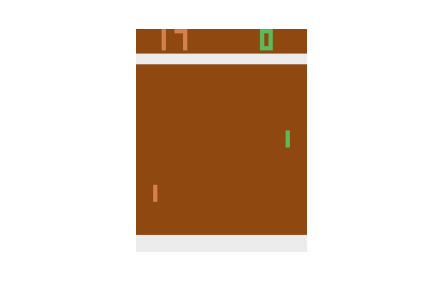
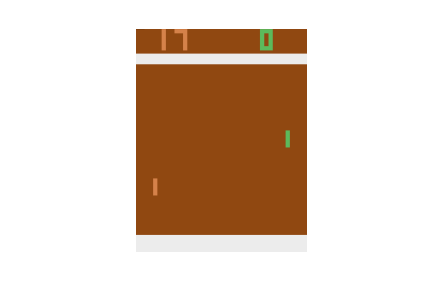
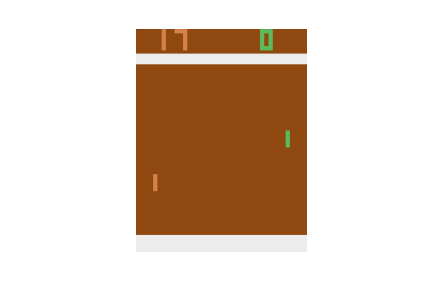
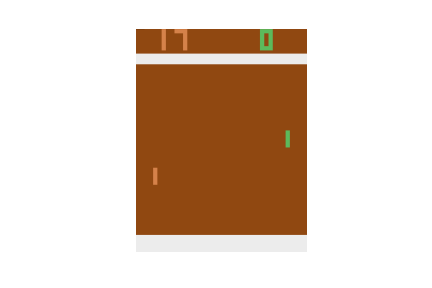
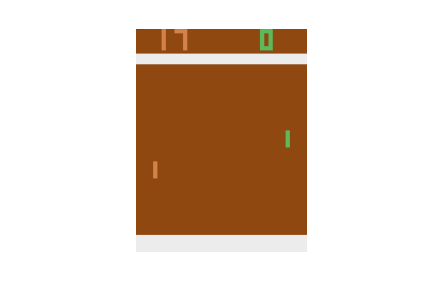
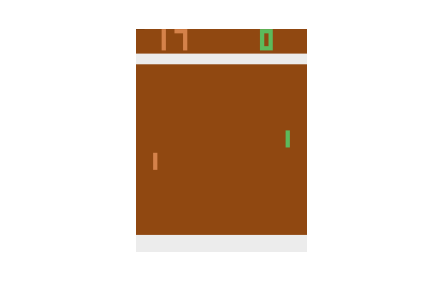
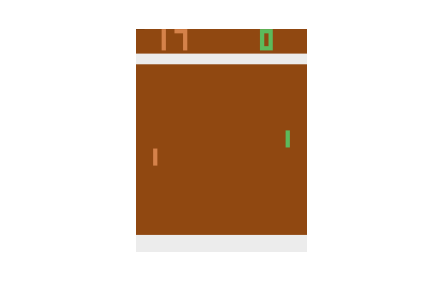
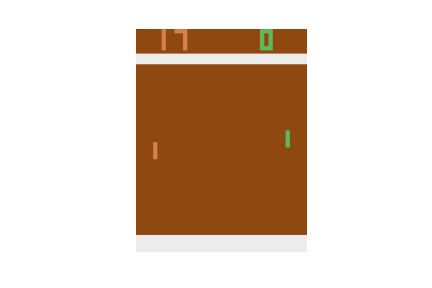
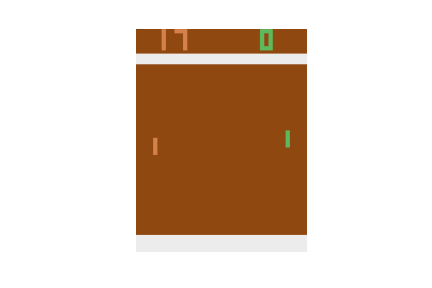
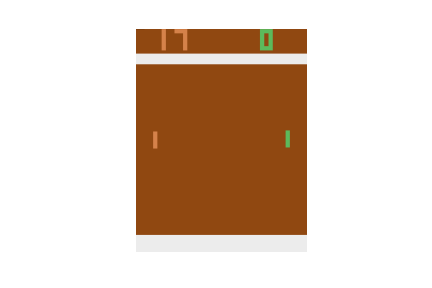
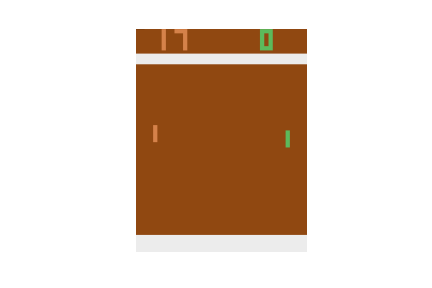
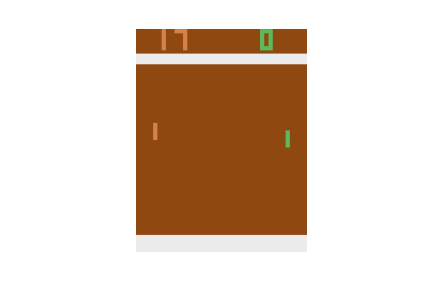
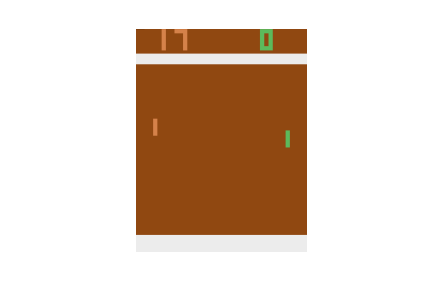
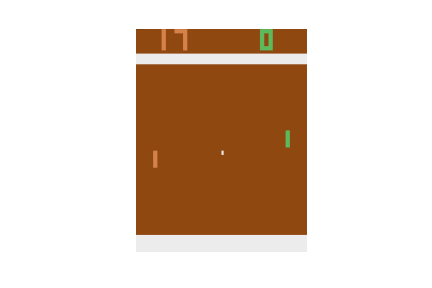
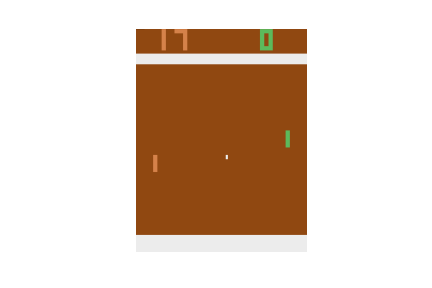
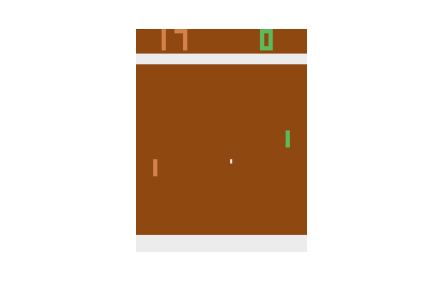
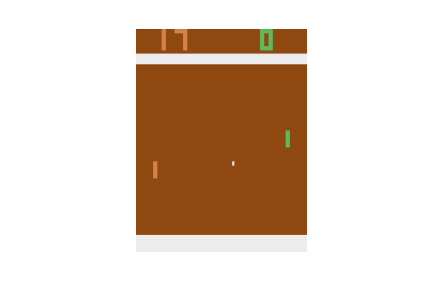
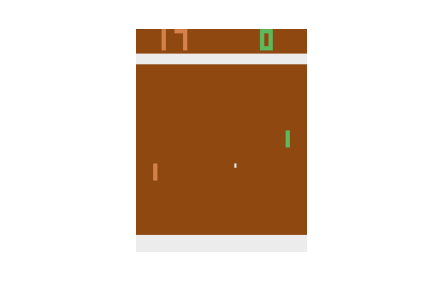
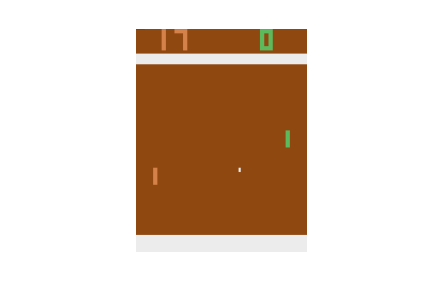
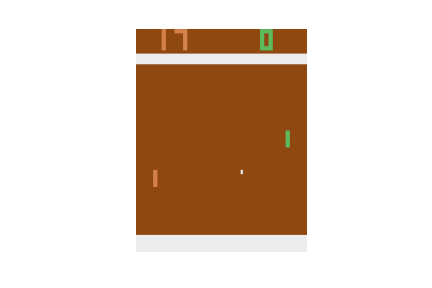
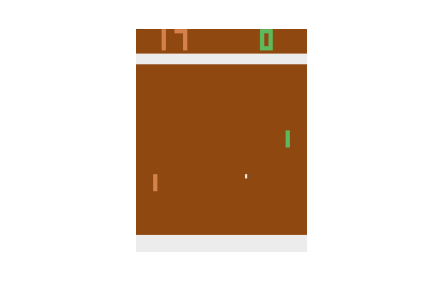
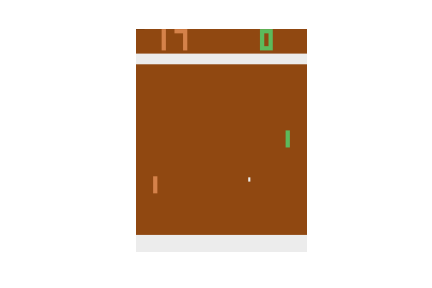
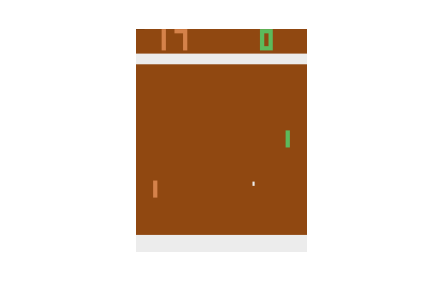
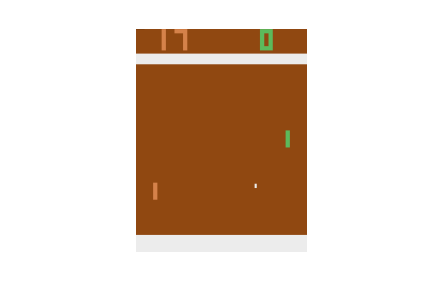
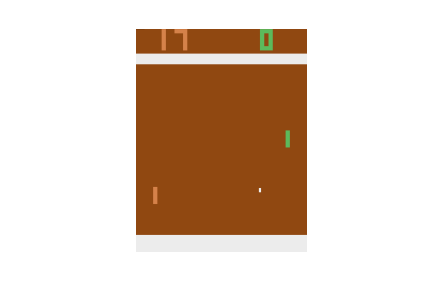
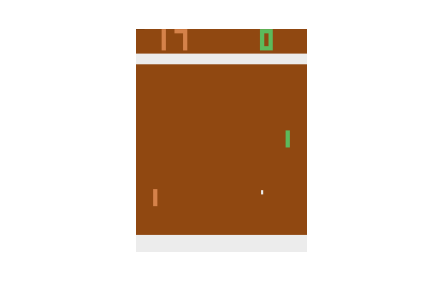
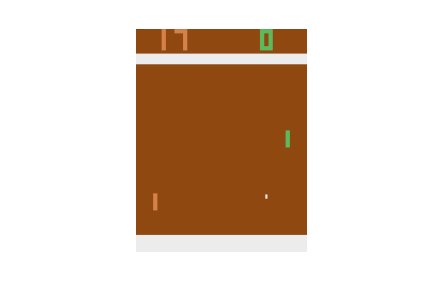
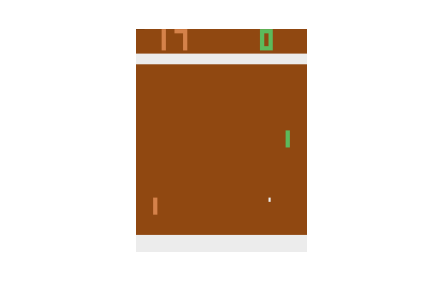
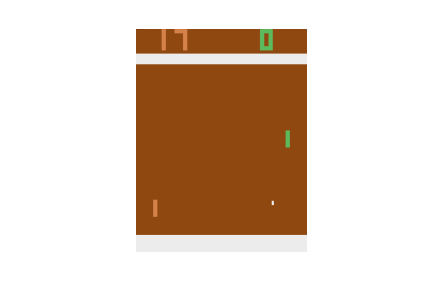
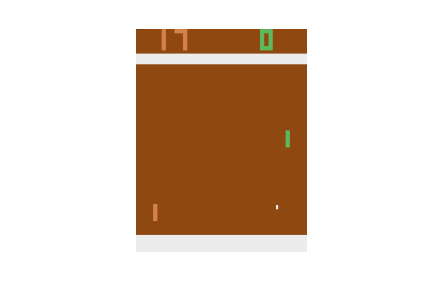
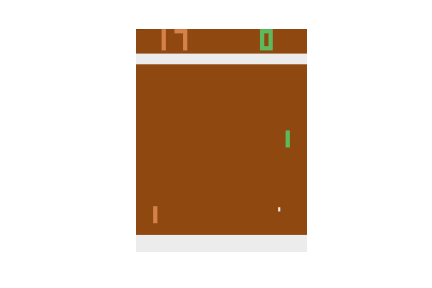
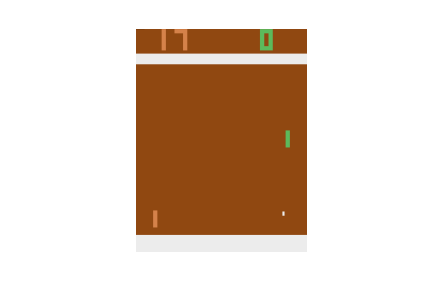
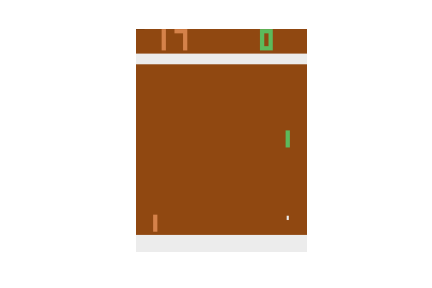
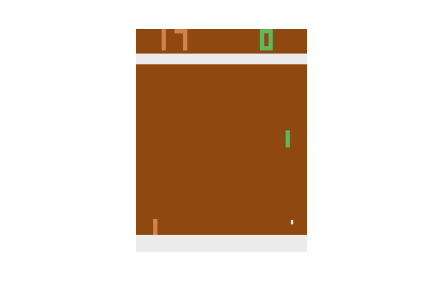
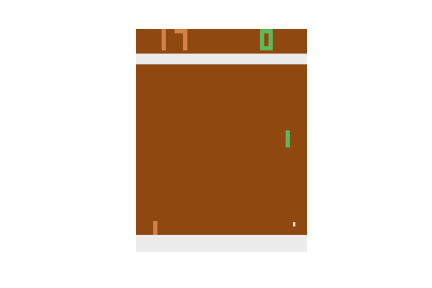
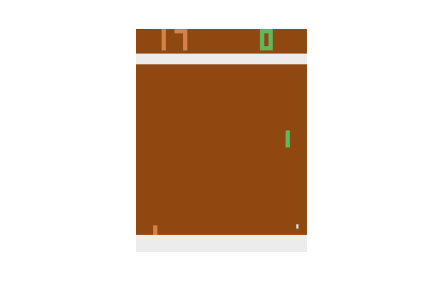
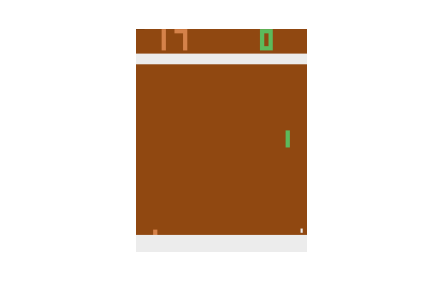
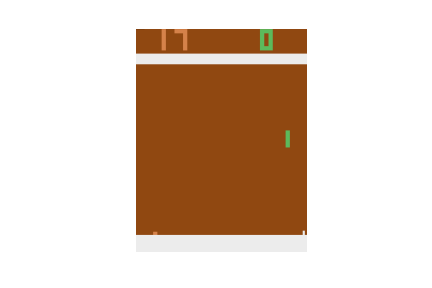
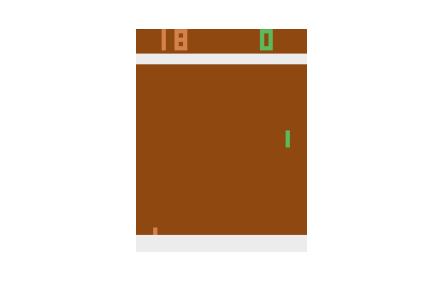
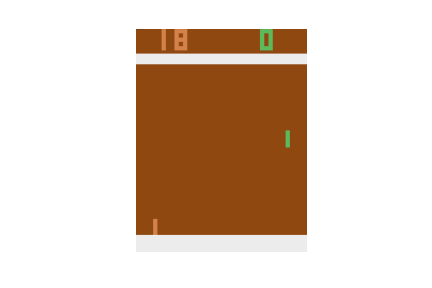
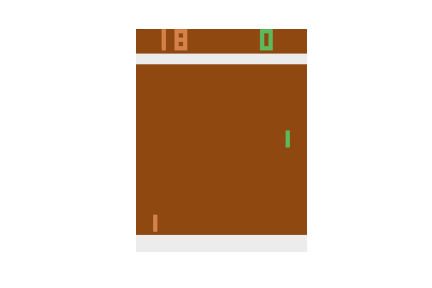
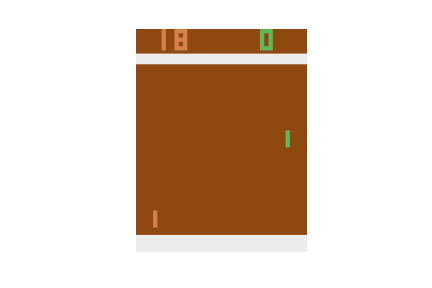
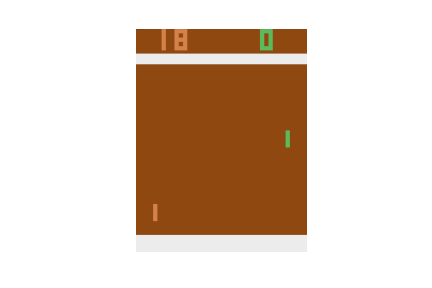
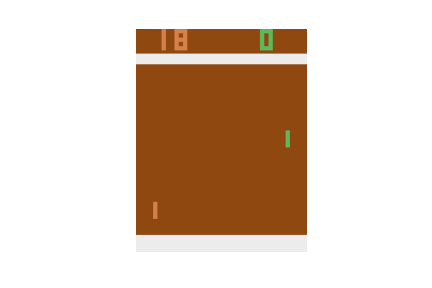
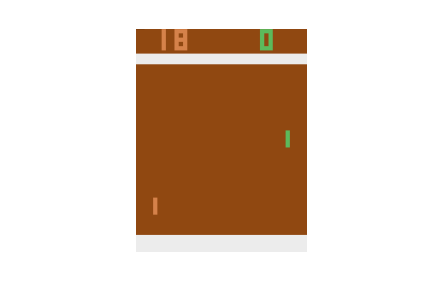
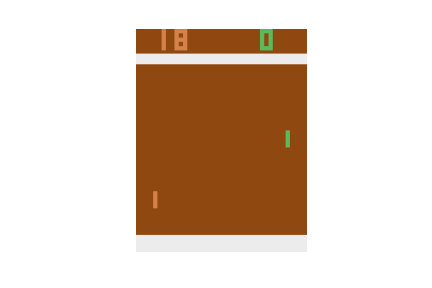
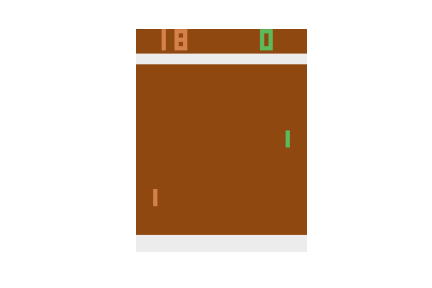
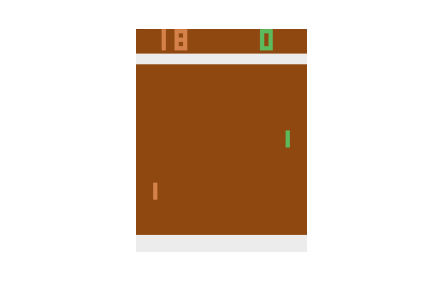
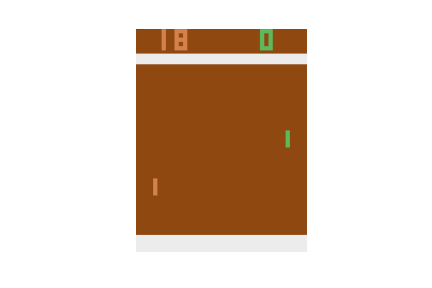
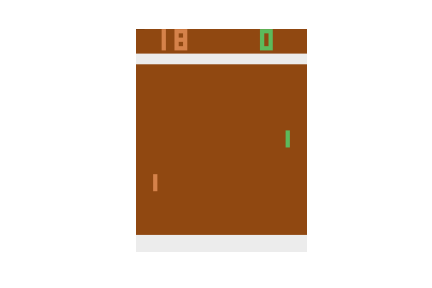
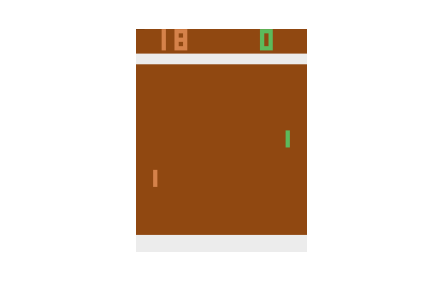
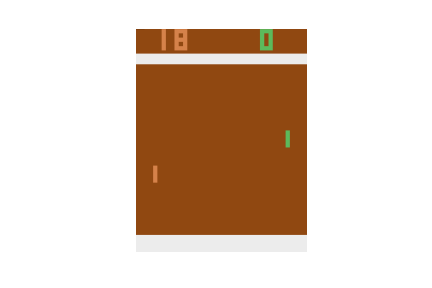
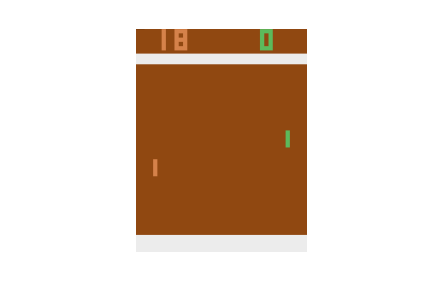
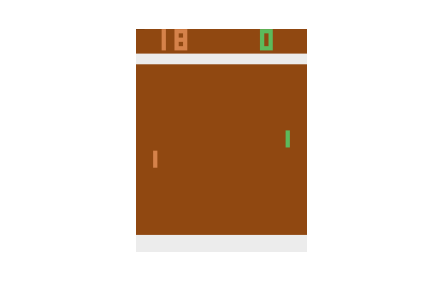
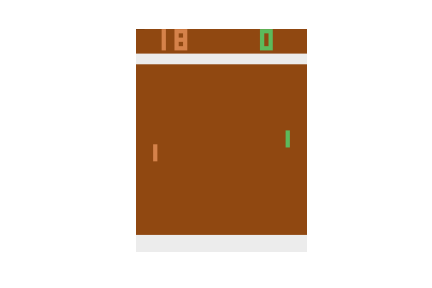
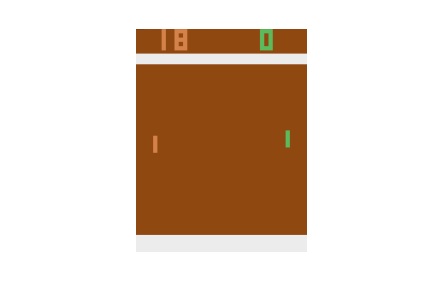
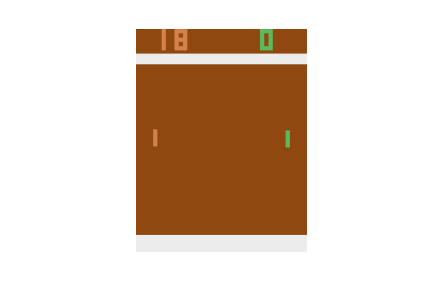
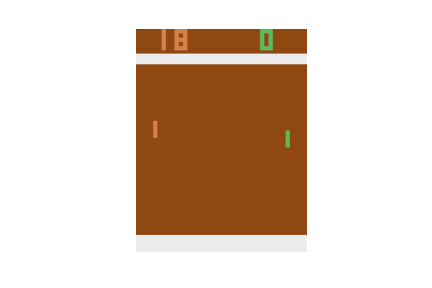
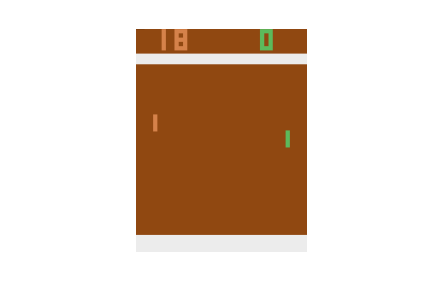
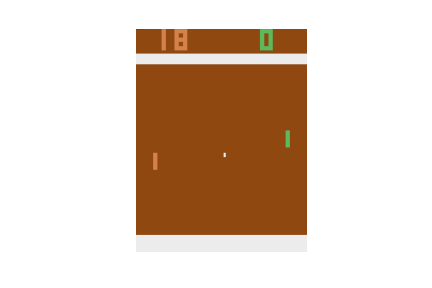
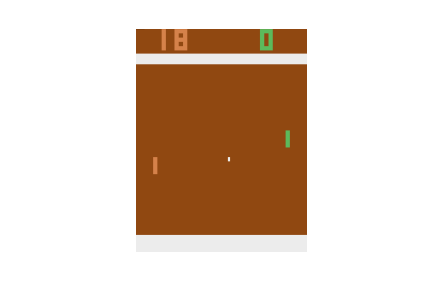
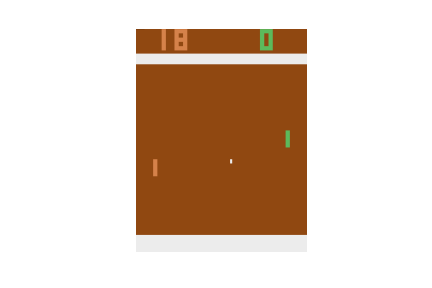
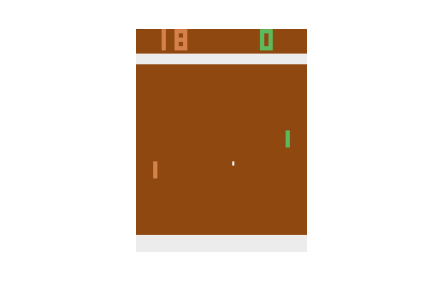
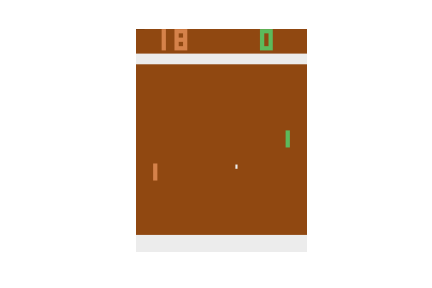
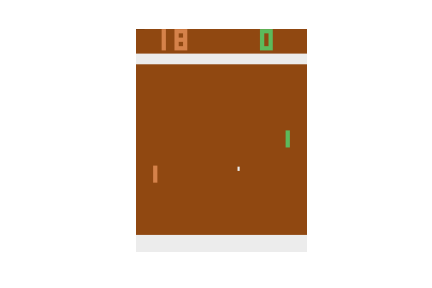
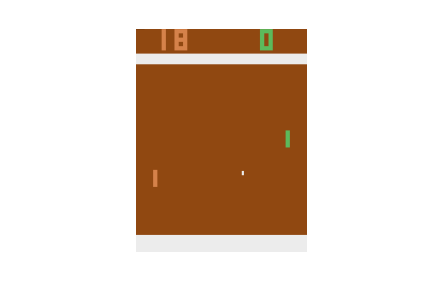
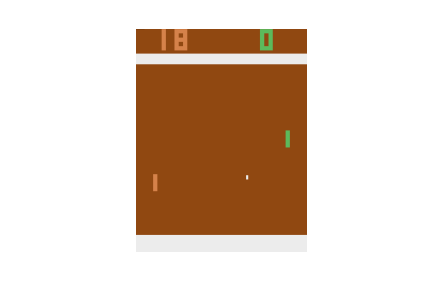
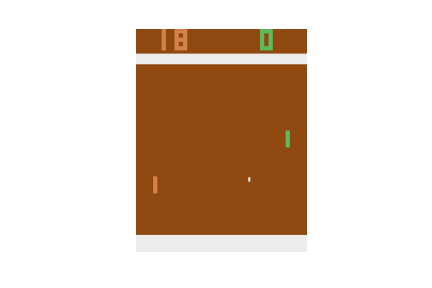
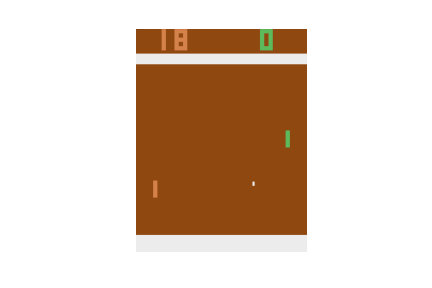
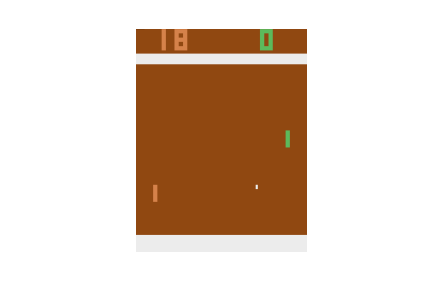
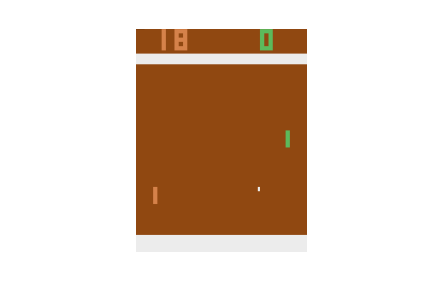
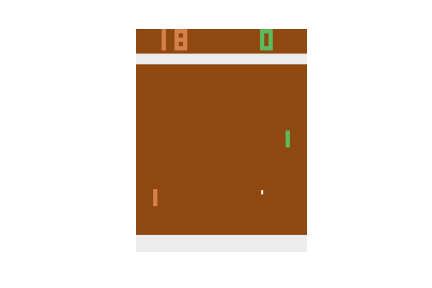
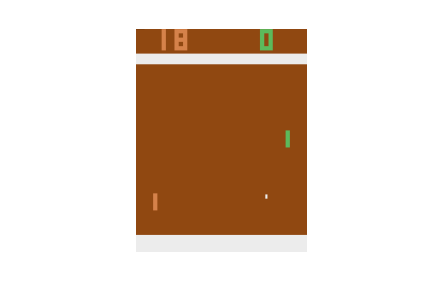
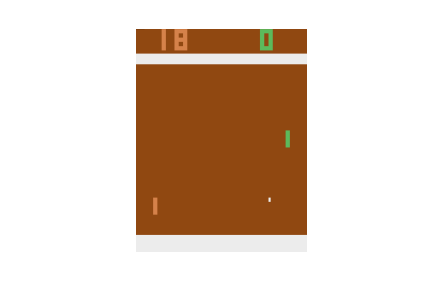
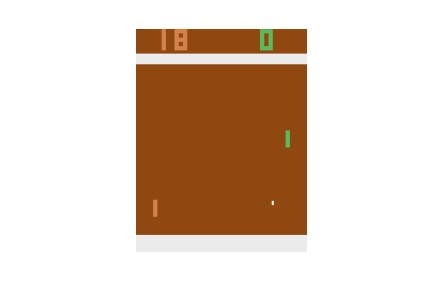
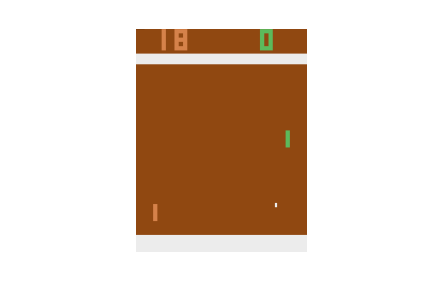
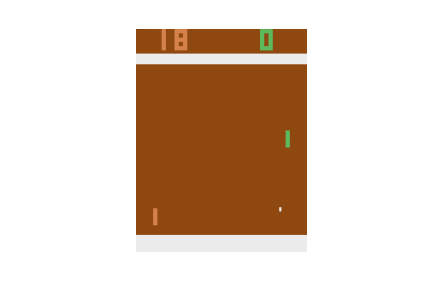
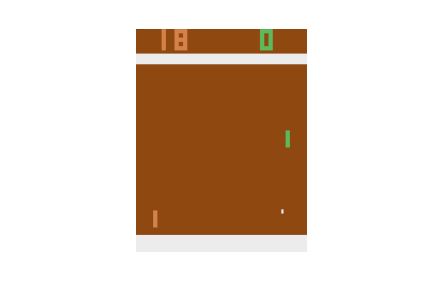
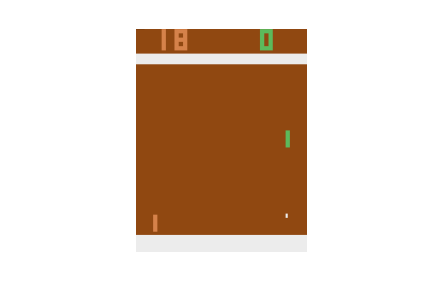
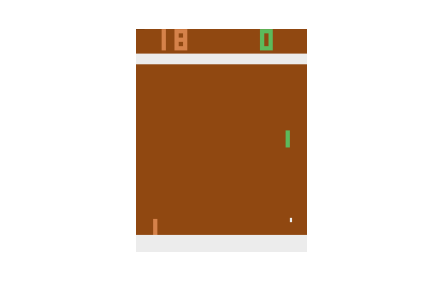
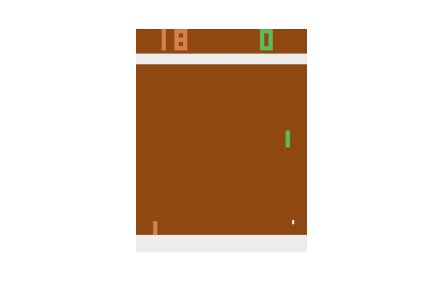
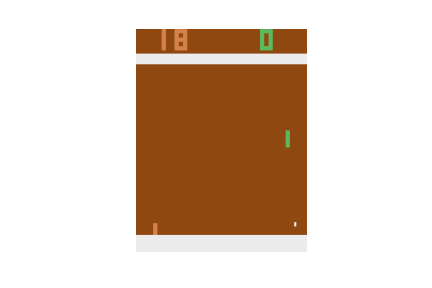
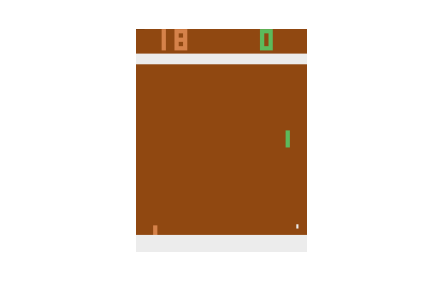
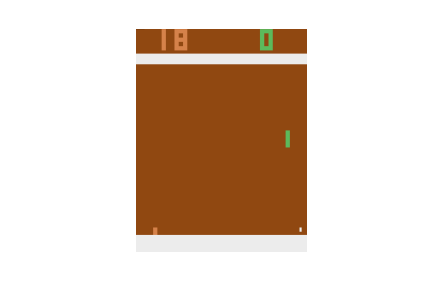
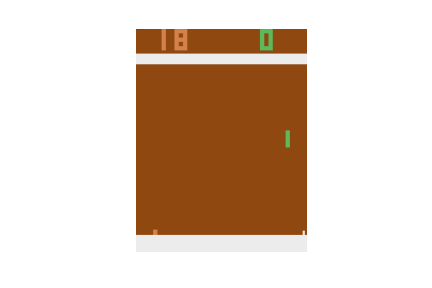
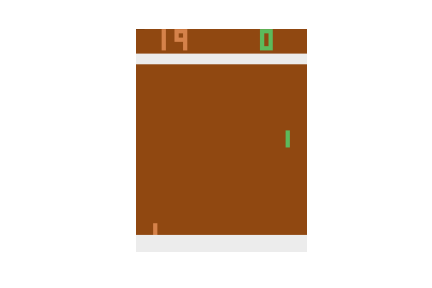
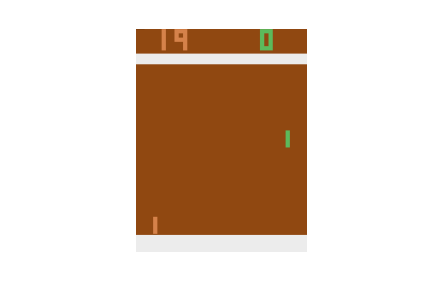
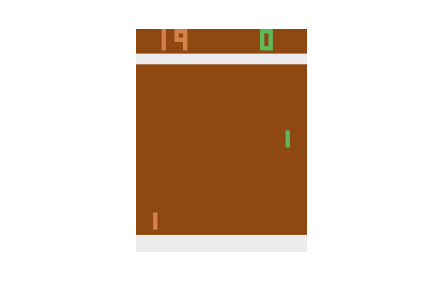
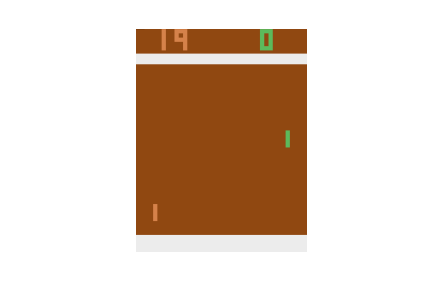
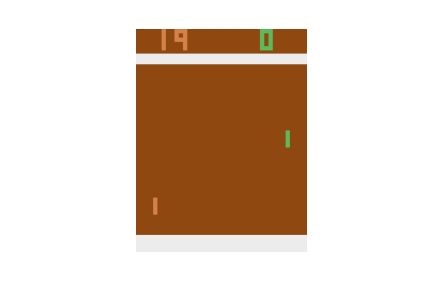
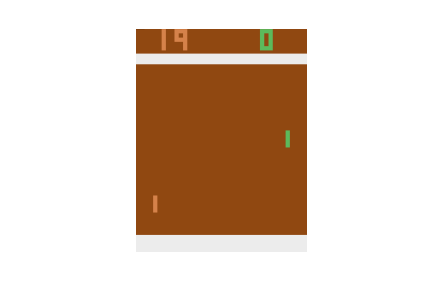
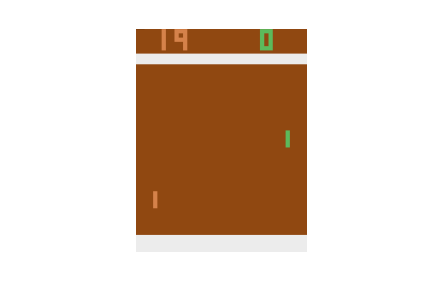
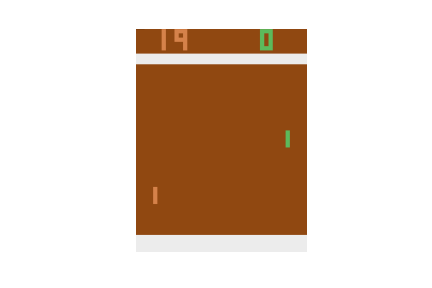
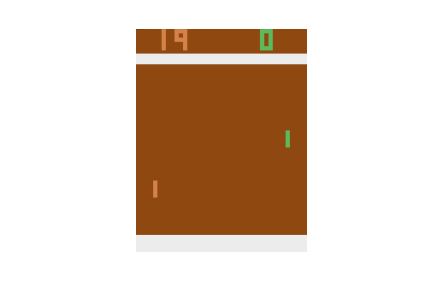
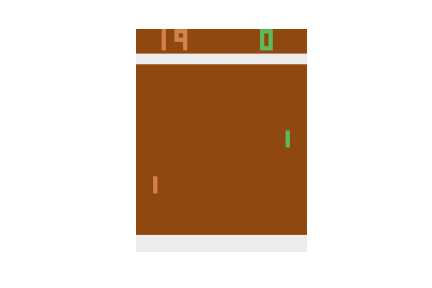
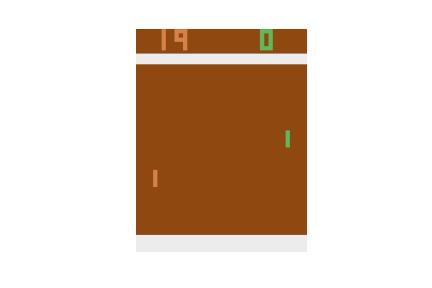
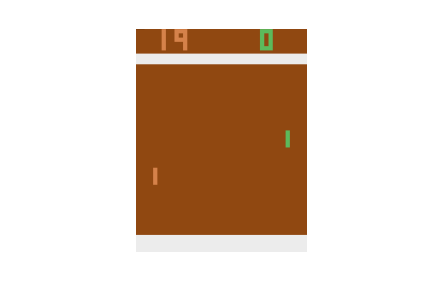
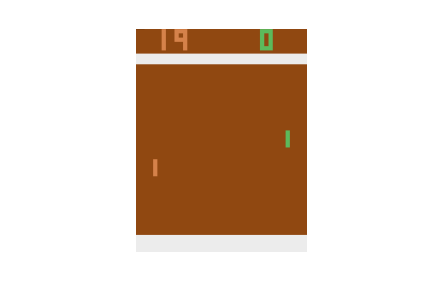
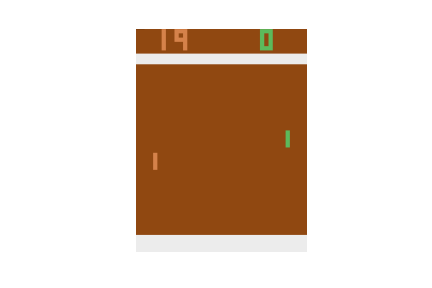
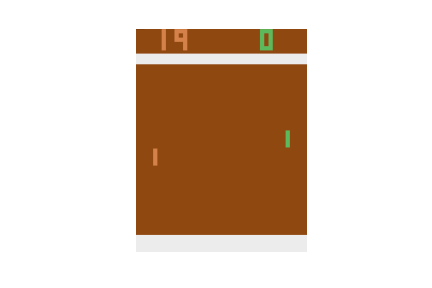
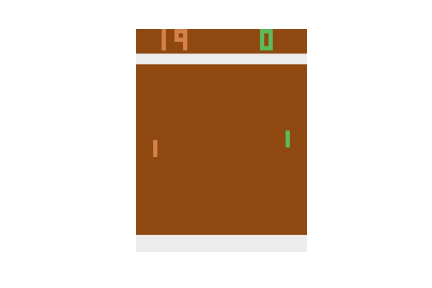
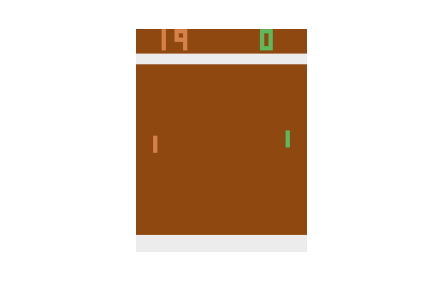
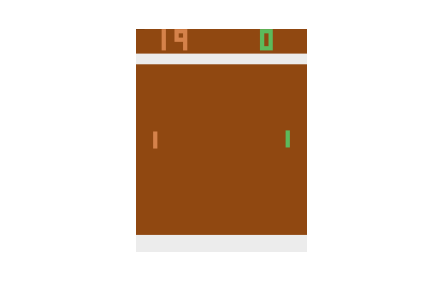
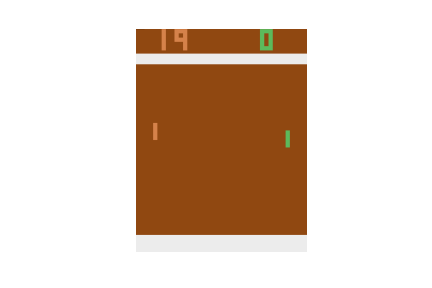
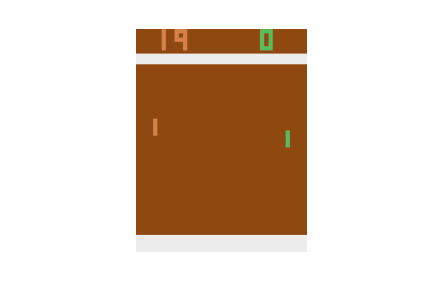
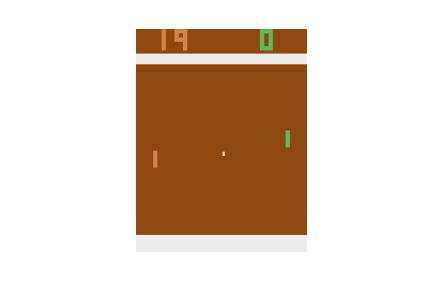
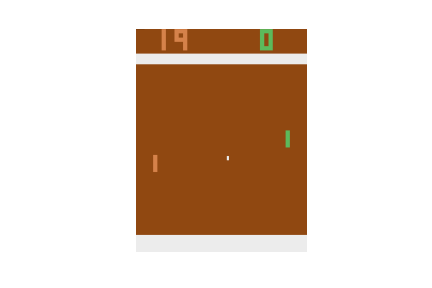
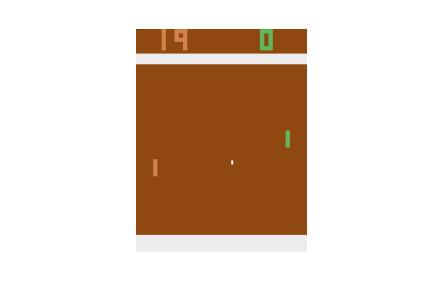
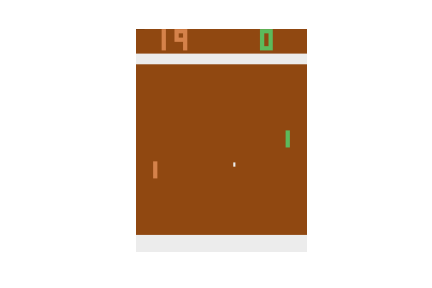
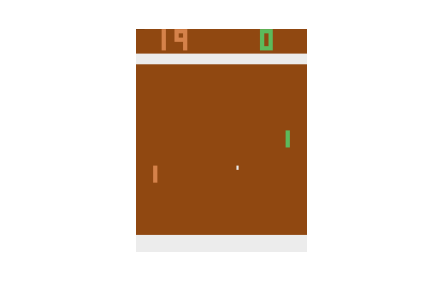
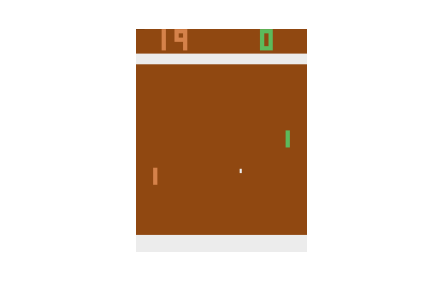
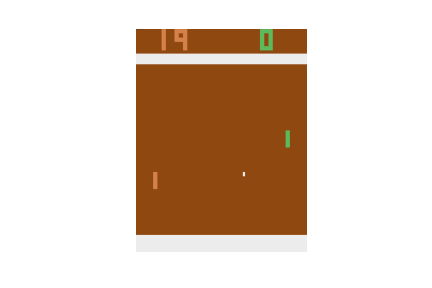
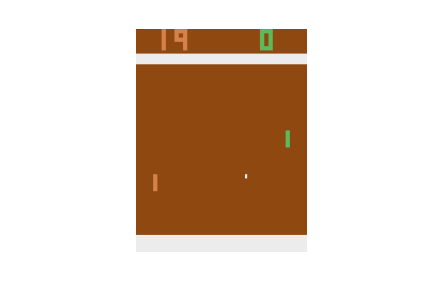
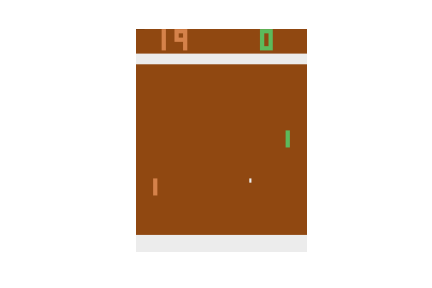
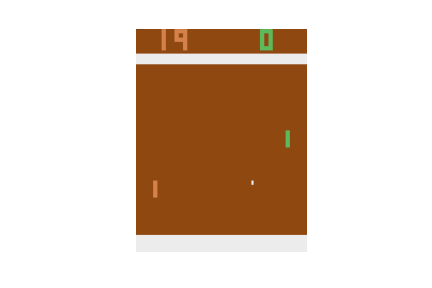
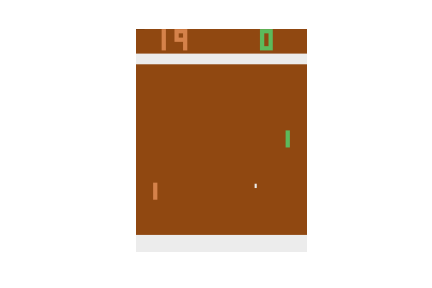
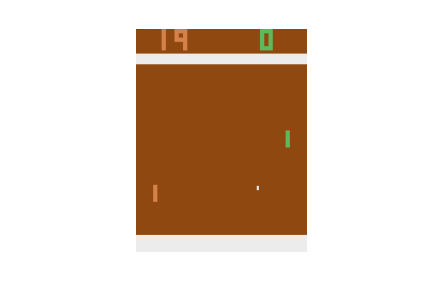
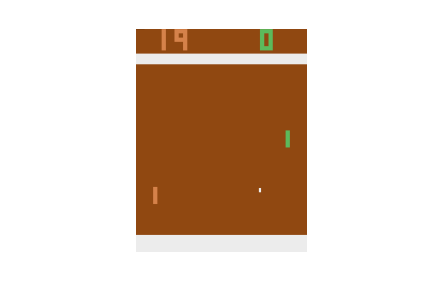
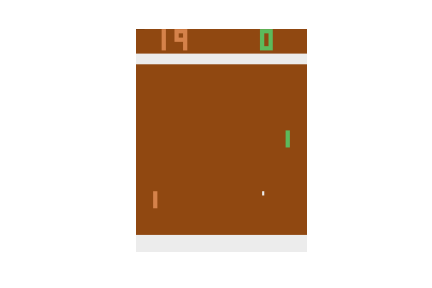
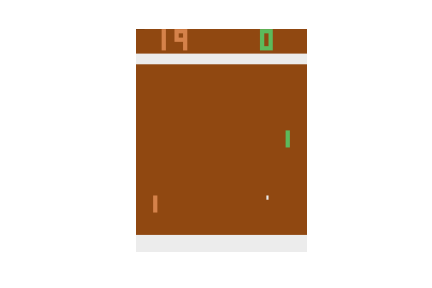
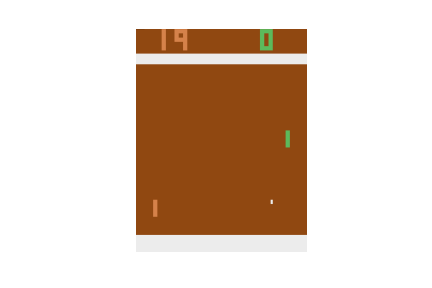
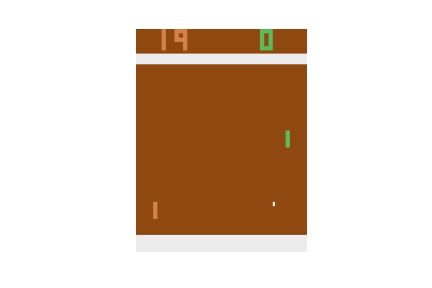
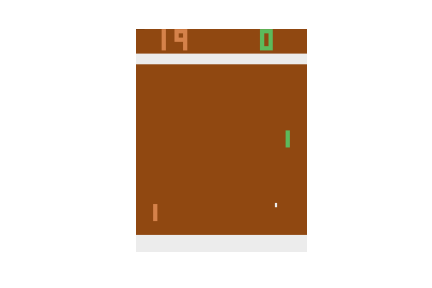
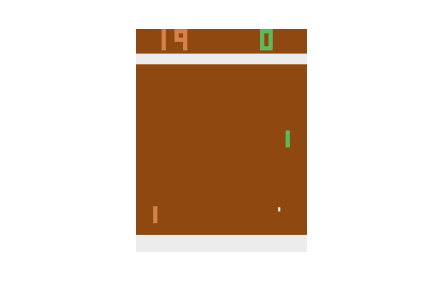
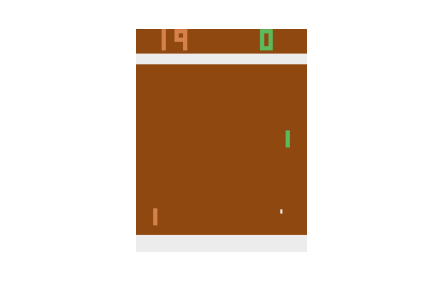
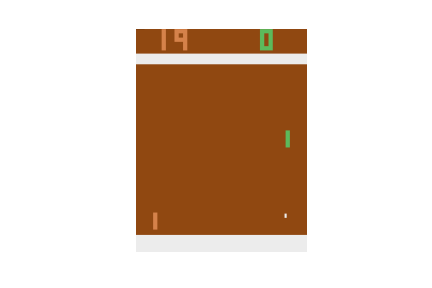
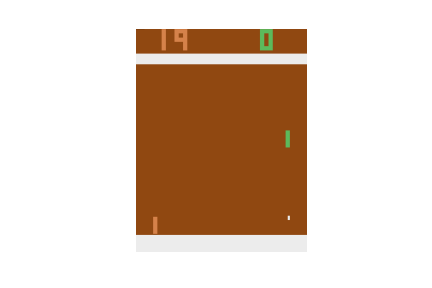
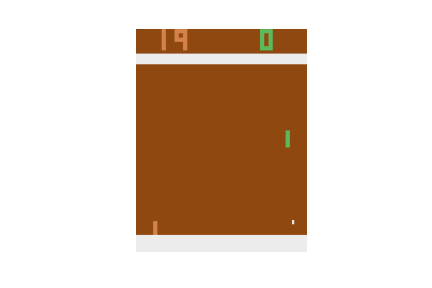
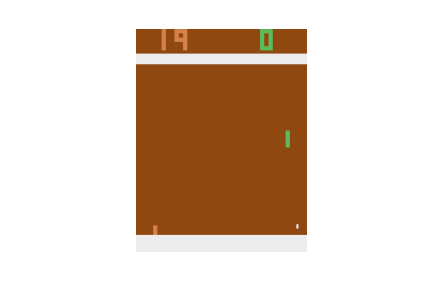
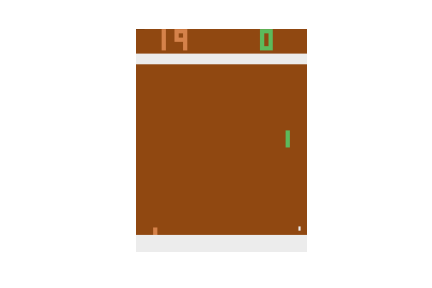
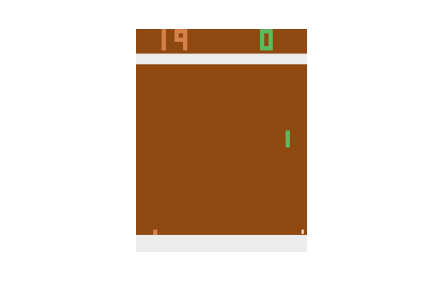
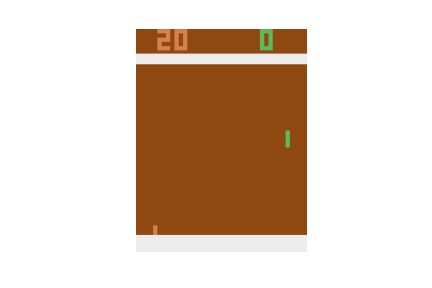
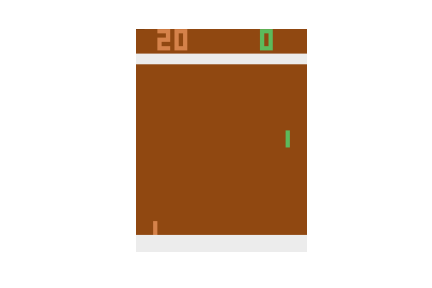
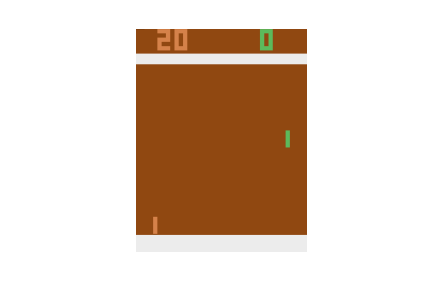
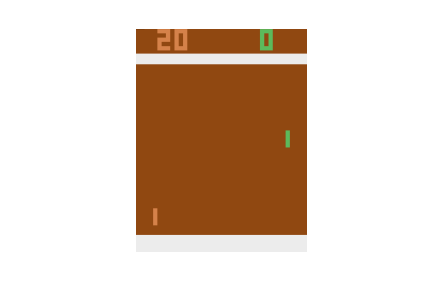
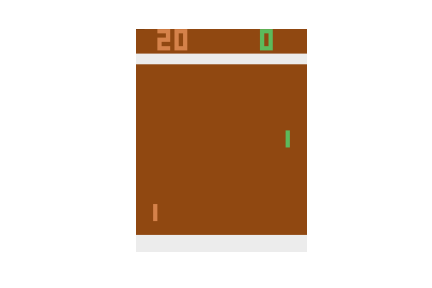
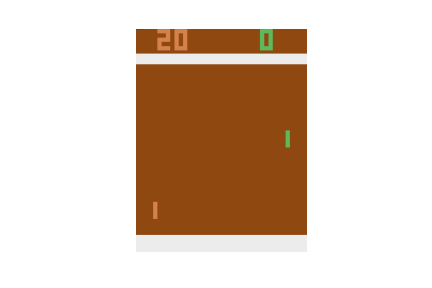
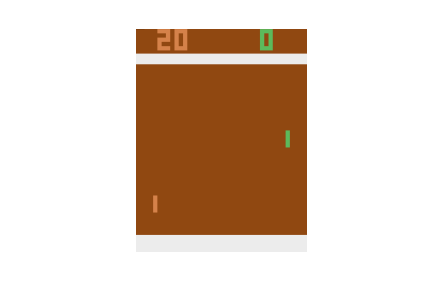
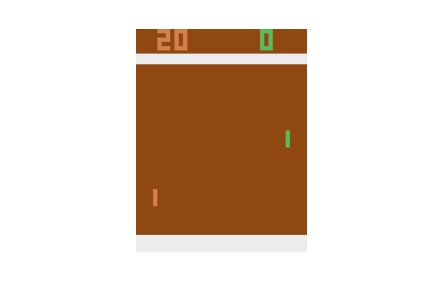
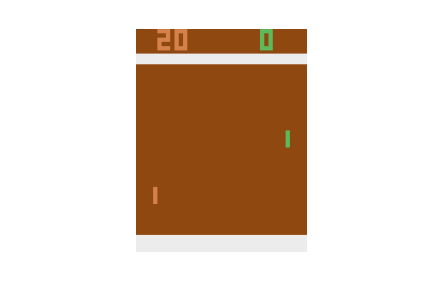
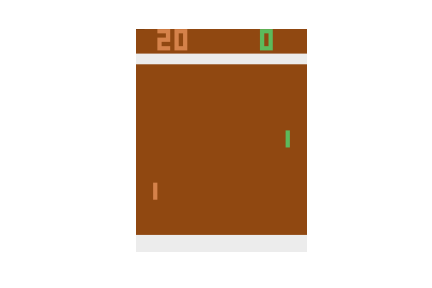
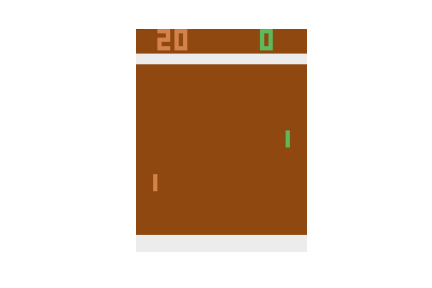
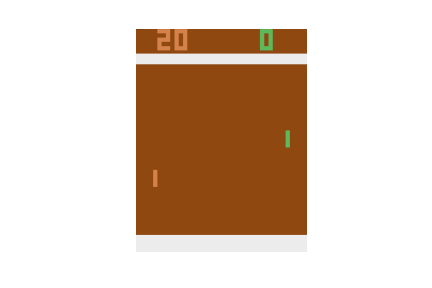
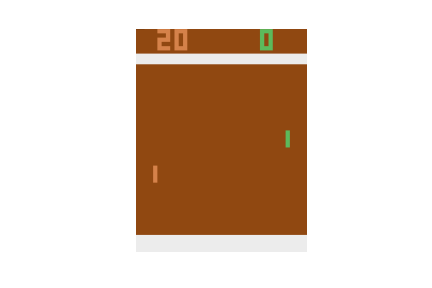
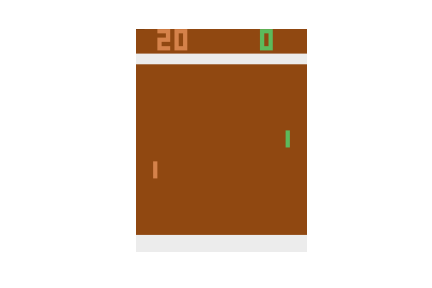
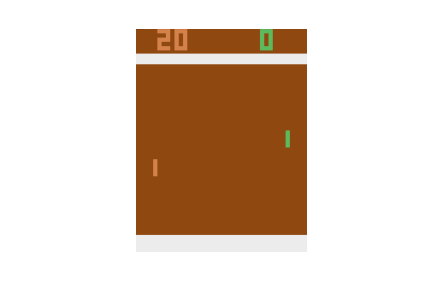
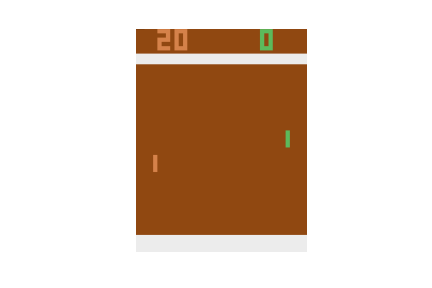
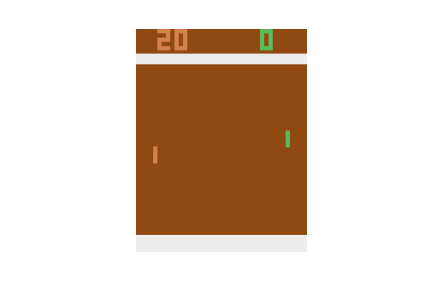
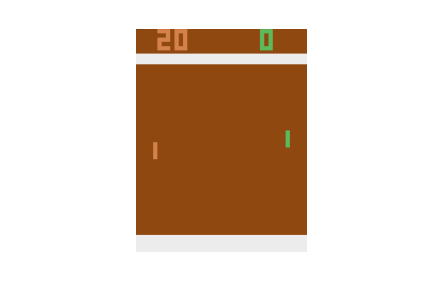
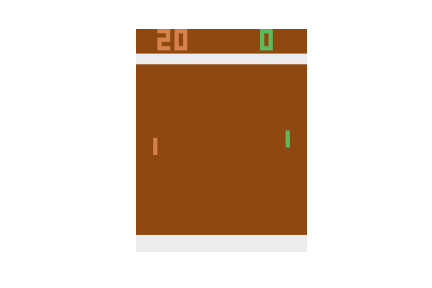
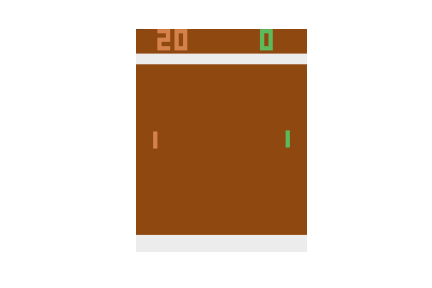
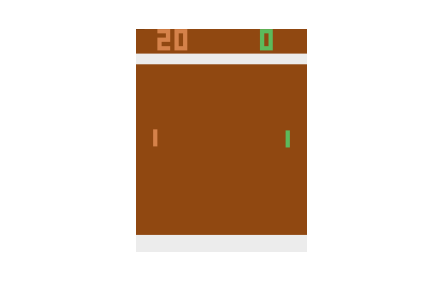
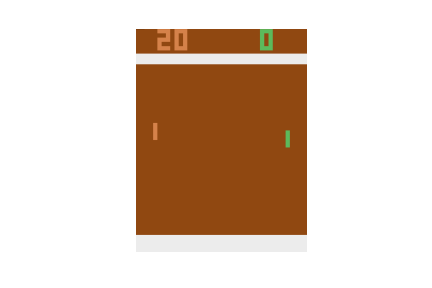
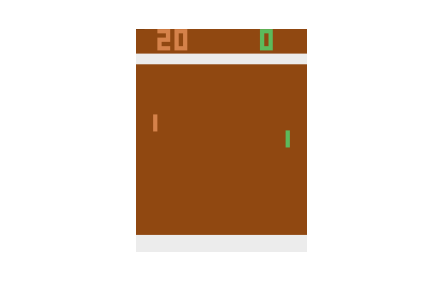
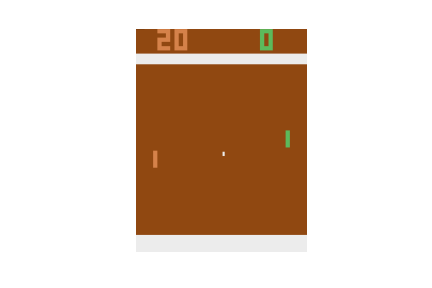
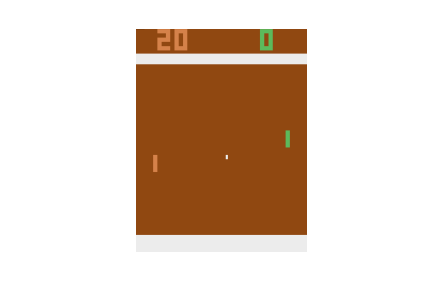
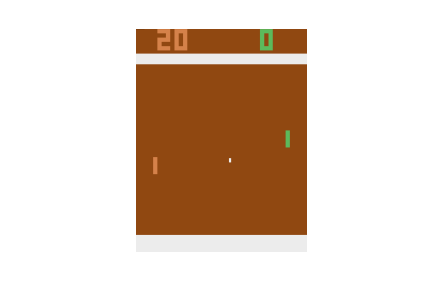
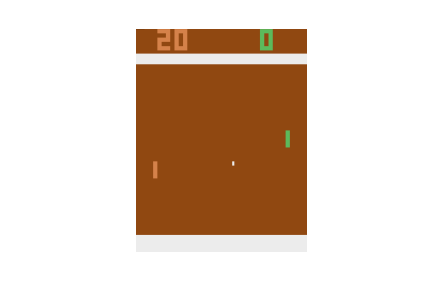
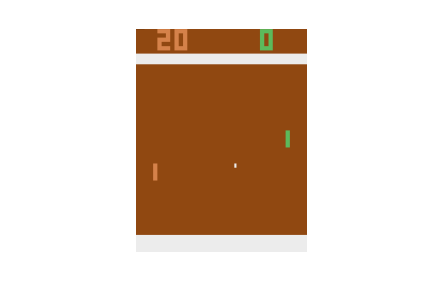
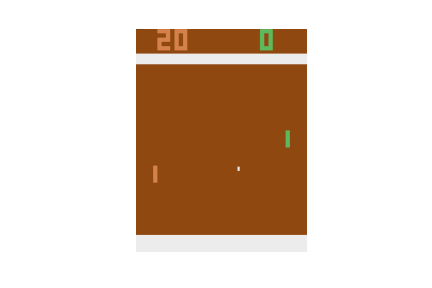
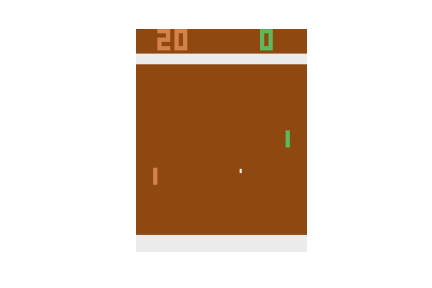
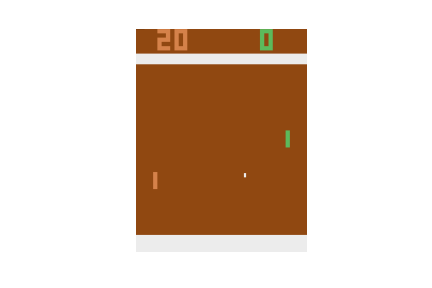
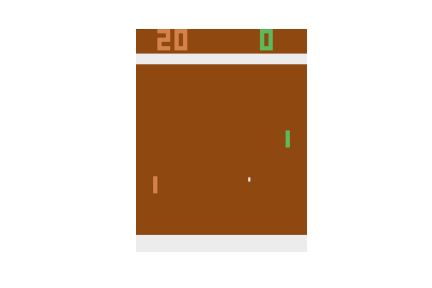
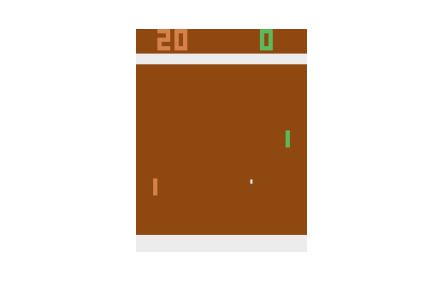
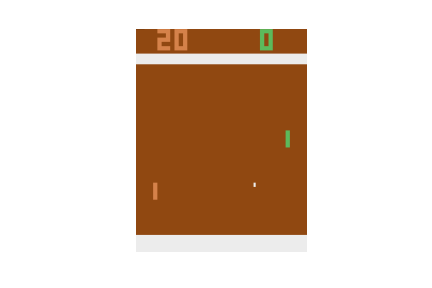
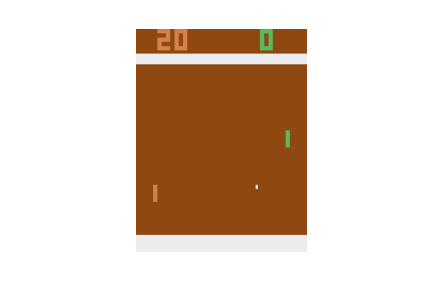
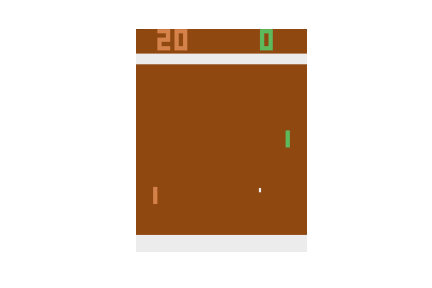
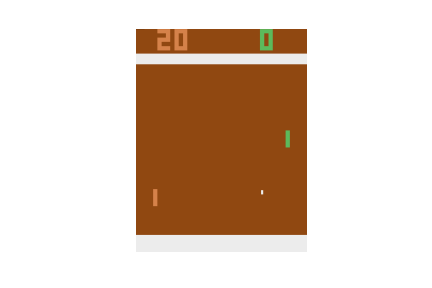
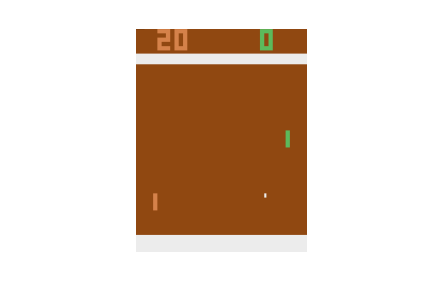
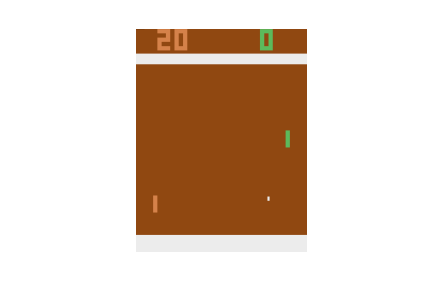
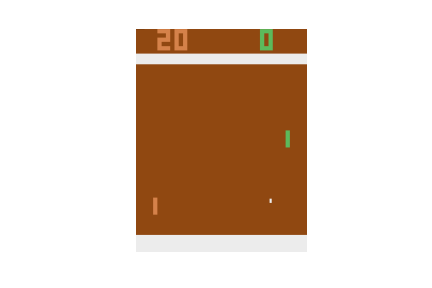
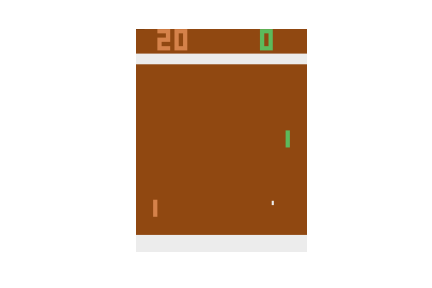
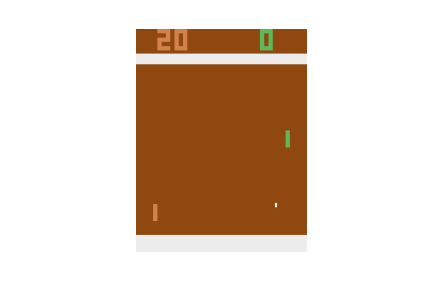
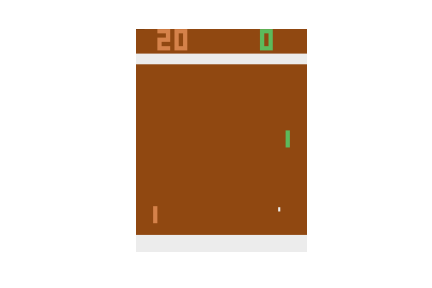
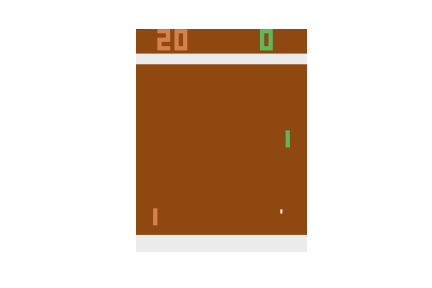
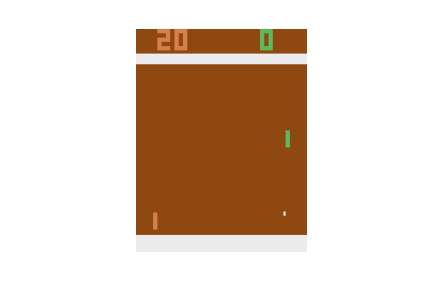
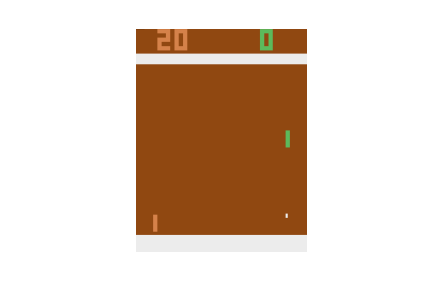
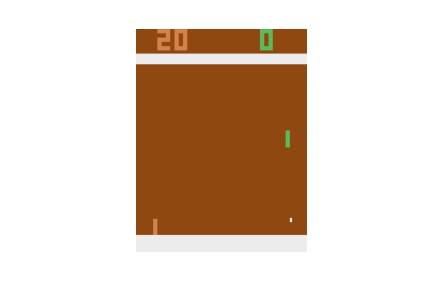
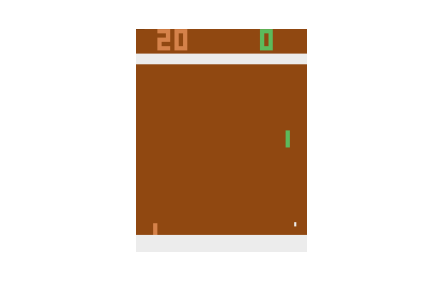
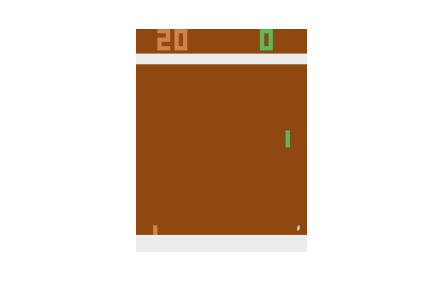
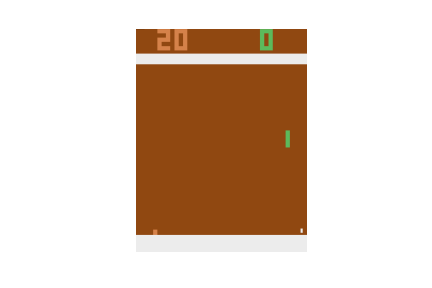
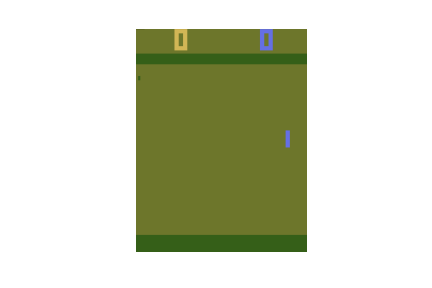

In [14]:
state1 = np.zeros([1,n_input])
state2 = preprocess(env.reset())
frameshistory = []
episode = 1
done = False
while episode != 0:
    
    state = state2-state1
    state1 = state2
    
    feed = {X: np.reshape(state, (1,n_input))}
    aprob = sess.run(tf_aprob,feed) ; aprob = aprob[0,:]
    action = np.argmax(aprob)+1
    state2, reward, done, info = env.step(action)
    if done:
        state2 = env.reset()
        episode -= 1
    frameshistory.append(state2)
    state2 = preprocess(state2)
    
display_frames_as_gif(frameshistory)